In [1]:
#méthode de gradient boosting avec surement du stacking pour le forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")

Loading BokehJS ...

In [3]:
uber = pd.read_csv('../uber_data.csv', parse_dates = True)

In [4]:
uber_man = uber[uber['borough'] == 'Manhattan']

In [5]:
uber_man = uber_man.drop('borough', axis=1)

uber_man['pickup_dt'] = uber_man['pickup_dt'].astype(str) 

uber_man = uber_man.set_index('pickup_dt')

uber_man = pd.get_dummies(uber_man)

In [6]:
uber_man.tail()

pickups  spd   vsb  temp  dewp     slp  pcp01  pcp06  \
pickup_dt                                                                   
2015-06-30 19:00:00     4585  5.0  10.0  80.0  58.0  1012.5    0.0    0.0   
2015-06-30 20:00:00     4210  8.0  10.0  80.0  58.0  1012.4    0.0    0.0   
2015-06-30 21:00:00     4313  7.0  10.0  76.0  61.0  1012.4    0.0    0.0   
2015-06-30 22:00:00     4452  5.0  10.0  76.0  64.0  1011.9    0.0    0.0   
2015-06-30 23:00:00     3828  7.0  10.0  75.0  65.0  1011.8    0.0    0.0   

                     pcp24   sd  hday_N  hday_Y  
pickup_dt                                        
2015-06-30 19:00:00    0.0  0.0       1       0  
2015-06-30 20:00:00    0.0  0.0       1       0  
2015-06-30 21:00:00    0.0  0.0       1       0  
2015-06-30 22:00:00    0.0  0.0       1       0  
2015-06-30 23:00:00    0.0  0.0       1       0

Ajout d'une lag feature sur la serie
il s'agit d'horizon en heure donc on peut faire des lags sur les heures précédentes jusqu'à -4h par exemple
ensuite sur le jour précédent à la même heure
la semaine précédente
et enfin le mois

In [7]:
#lag features
for i in [1,2,3,4,24,7*24]:
    uber_man[f'lag_{i}'] = uber_man.pickups.shift(i)

In [8]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [9]:
import lightgbm as lgb

In [10]:
uber_man.head()

pickups  spd   vsb  temp  dewp     slp  pcp01  pcp06  \
pickup_dt                                                                   
2015-01-01 01:00:00     5258  5.0  10.0  30.0   7.0  1023.5    0.0    0.0   
2015-01-01 02:00:00     4345  3.0  10.0  30.0   6.0  1023.0    0.0    0.0   
2015-01-01 03:00:00     4577  5.0  10.0  30.0   8.0  1022.3    0.0    0.0   
2015-01-01 04:00:00     3003  5.0  10.0  29.0   9.0  1022.0    0.0    0.0   
2015-01-01 05:00:00     1313  5.0  10.0  28.0   9.0  1021.8    0.0    0.0   

                     pcp24   sd  hday_N  hday_Y   lag_1   lag_2   lag_3  \
pickup_dt                                                                 
2015-01-01 01:00:00    0.0  0.0       0       1     NaN     NaN     NaN   
2015-01-01 02:00:00    0.0  0.0       0       1  5258.0     NaN     NaN   
2015-01-01 03:00:00    0.0  0.0       0       1  4345.0  5258.0     NaN   
2015-01-01 04:00:00    0.0  0.0       0       1  4577.0  4345.0  5258.0   
2015-01-01 05:00:00    0.0  0.0       0       1  3003.0  4577.0  4345.0   

                      lag_4  lag_24  lag_168  
pickup_dt                                     
2015-01-01 01:00:00     NaN     NaN      NaN  
2015-01-01 02:00:00     NaN     NaN      NaN  
2015-01-01 03:00:00     NaN     NaN      NaN  
2015-01-01 04:00:00     NaN     NaN      NaN  
2015-01-01 05:00:00  5258.0     NaN      NaN

In [11]:
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split

#uber_mancv = uber_man.reset_index(drop=True)

X = uber_man.drop('pickups', axis=1)
y = uber_man['pickups']




tscv = TimeSeriesSplit(n_splits = 3)

    
    
    
train, test = temporal_train_test_split(uber_man, test_size = 0.3)

X_train = train.drop('pickups', axis=1)
y_train = train['pickups']
X_test = test.drop('pickups',axis=1)
y_test = test['pickups']

In [14]:
len(X_test)

1303

In [12]:
from sklearn.model_selection import RandomizedSearchCV

rs_params = {
    'learning_rate': [0.01,0.03,0.01],
    'max_depth': [2,4,6,8,10,12],
    'num_leaves': [10,20,40,60,100,200],
    'metric': ['mape'],
    'num_iterations': [500],
    'objective':['poisson','tweedie','mape','regression']
}

rs_cv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(), param_distributions=rs_params,
                           cv = tscv, n_iter=100,verbose=1)




In [15]:
#alors la le set de validation n'est pas bon il ne devrait pas etre fait avec le X_test et y_test
rs_cv.fit(X_train, y_train,verbose=1, early_stopping_rounds= 100,eval_set = (X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[1]	valid_0's mape: 0.708896
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.702101
[3]	valid_0's mape: 0.695505
[4]	valid_0's mape: 0.688845
[5]	valid_0's mape: 0.682261
[6]	valid_0's mape: 0.675856
[7]	valid_0's mape: 0.66942
[8]	valid_0's mape: 0.663039
[9]	valid_0's mape: 0.656844
[10]	valid_0's mape: 0.650557
[11]	valid_0's mape: 0.644244
[12]	valid_0's mape: 0.638238
[13]	valid_0's mape: 0.631935
[14]	valid_0's mape: 0.626039
[15]	valid_0's mape: 0.619862
[16]	valid_0's mape: 0.614008
[17]	valid_0's mape: 0.608002
[18]	valid_0's mape: 0.602373
[19]	valid_0's mape: 0.596597
[20]	valid_0's mape: 0.590945
[21]	valid_0's mape: 0.585181
[22]	valid_0's mape: 0.57969
[23]	valid_0's mape: 0.574281
[24]	valid_0's mape: 0.568857
[25]	valid_0's mape: 0.563377
[26]	valid_0's mape: 0.558112
[27]	valid_0's mape: 0.552738
[28]	valid_0's mape: 0.547683
[29]	valid_0's mape: 0.542502
[30]	valid_0's m

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[101]	valid_0's mape: 0.286055
[102]	valid_0's mape: 0.283723
[103]	valid_0's mape: 0.281507
[104]	valid_0's mape: 0.279292
[105]	valid_0's mape: 0.277029
[106]	valid_0's mape: 0.274748
[107]	valid_0's mape: 0.272637
[108]	valid_0's mape: 0.270405
[109]	valid_0's mape: 0.268265
[110]	valid_0's mape: 0.266202
[111]	valid_0's mape: 0.264164
[112]	valid_0's mape: 0.262076
[113]	valid_0's mape: 0.260043
[114]	valid_0's mape: 0.258207
[115]	valid_0's mape: 0.256144
[116]	valid_0's mape: 0.254183
[117]	valid_0's mape: 0.25212
[118]	valid_0's mape: 0.250198
[119]	valid_0's mape: 0.248497
[120]	valid_0's mape: 0.246584
[121]	valid_0's mape: 0.244653
[122]	valid_0's mape: 0.242796
[123]	valid_0's mape: 0.241006
[124]	valid_0's mape: 0.239214
[125]	valid_0's mape: 0.237574
[126]	valid_0's mape: 0.235767
[127]	valid_0's mape: 0.234007
[128]	valid_0's mape: 0.232561
[129]	valid_0's mape: 0.230928
[130]	valid_0's mape: 0.229477
[131]	valid_0's mape: 0.227751
[132]	valid_0's mape: 0.226352
[133]	val

[392]	valid_0's mape: 0.137796
[393]	valid_0's mape: 0.137794
[394]	valid_0's mape: 0.137795
[395]	valid_0's mape: 0.137797
[396]	valid_0's mape: 0.137813
[397]	valid_0's mape: 0.137817
[398]	valid_0's mape: 0.137821
[399]	valid_0's mape: 0.137788
[400]	valid_0's mape: 0.13779
[401]	valid_0's mape: 0.137819
[402]	valid_0's mape: 0.13782
[403]	valid_0's mape: 0.137822
[404]	valid_0's mape: 0.137826
[405]	valid_0's mape: 0.137828
[406]	valid_0's mape: 0.137802
[407]	valid_0's mape: 0.137806
[408]	valid_0's mape: 0.137808
[409]	valid_0's mape: 0.137786
[410]	valid_0's mape: 0.137749
[411]	valid_0's mape: 0.137725
[412]	valid_0's mape: 0.137653
[413]	valid_0's mape: 0.137632
[414]	valid_0's mape: 0.137633
[415]	valid_0's mape: 0.137612
[416]	valid_0's mape: 0.137577
[417]	valid_0's mape: 0.13757
[418]	valid_0's mape: 0.137556
[419]	valid_0's mape: 0.137501
[420]	valid_0's mape: 0.137495
[421]	valid_0's mape: 0.13749
[422]	valid_0's mape: 0.137427
[423]	valid_0's mape: 0.137413
[424]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[66]	valid_0's mape: 0.413006
[67]	valid_0's mape: 0.40921
[68]	valid_0's mape: 0.405427
[69]	valid_0's mape: 0.401826
[70]	valid_0's mape: 0.398041
[71]	valid_0's mape: 0.394666
[72]	valid_0's mape: 0.391253
[73]	valid_0's mape: 0.387681
[74]	valid_0's mape: 0.384182
[75]	valid_0's mape: 0.380977
[76]	valid_0's mape: 0.377469
[77]	valid_0's mape: 0.374232
[78]	valid_0's mape: 0.370922
[79]	valid_0's mape: 0.367526
[80]	valid_0's mape: 0.364302
[81]	valid_0's mape: 0.361292
[82]	valid_0's mape: 0.358011
[83]	valid_0's mape: 0.354853
[84]	valid_0's mape: 0.351799
[85]	valid_0's mape: 0.349099
[86]	valid_0's mape: 0.346139
[87]	valid_0's mape: 0.343028
[88]	valid_0's mape: 0.340136
[89]	valid_0's mape: 0.337434
[90]	valid_0's mape: 0.334611
[91]	valid_0's mape: 0.331729
[92]	valid_0's mape: 0.328954
[93]	valid_0's mape: 0.326055
[94]	valid_0's mape: 0.32334
[95]	valid_0's mape: 0.320508
[96]	valid_0's mape: 0.318006
[97]	valid_0's mape: 0.315495
[98]	valid_0's mape: 0.312777
[99]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.61877
[24]	valid_0's mape: 0.613092
[25]	valid_0's mape: 0.607489
[26]	valid_0's mape: 0.601795
[27]	valid_0's mape: 0.596322
[28]	valid_0's mape: 0.590833
[29]	valid_0's mape: 0.58525
[30]	valid_0's mape: 0.580004
[31]	valid_0's mape: 0.574609
[32]	valid_0's mape: 0.569476
[33]	valid_0's mape: 0.564221
[34]	valid_0's mape: 0.559094
[35]	valid_0's mape: 0.553882
[36]	valid_0's mape: 0.548569
[37]	valid_0's mape: 0.543279
[38]	valid_0's mape: 0.538269
[39]	valid_0's mape: 0.533128
[40]	valid_0's mape: 0.528011
[41]	valid_0's mape: 0.522953
[42]	valid_0's mape: 0.518146
[43]	valid_0's mape: 0.513191
[44]	valid_0's mape: 0.508243
[45]	valid_0's mape: 0.503612
[46]	valid_0's mape: 0.498889
[47]	valid_0's mape: 0.494304
[48]	valid_0's mape: 0.489816
[49]	valid_0's mape: 0.48514
[50]	valid_0's mape: 0.480712
[51]	valid_0's mape: 0.476366
[52]	valid_0's mape: 0.47196
[53]	valid_0's mape: 0.46752
[54]	valid_0's mape: 0.463359
[55]	valid_0's mape: 0.458973
[56]	valid_0's 

[423]	valid_0's mape: 0.107562
[424]	valid_0's mape: 0.107557
[425]	valid_0's mape: 0.107544
[426]	valid_0's mape: 0.10754
[427]	valid_0's mape: 0.107502
[428]	valid_0's mape: 0.107478
[429]	valid_0's mape: 0.107445
[430]	valid_0's mape: 0.107443
[431]	valid_0's mape: 0.107441
[432]	valid_0's mape: 0.107439
[433]	valid_0's mape: 0.107446
[434]	valid_0's mape: 0.10742
[435]	valid_0's mape: 0.107418
[436]	valid_0's mape: 0.107407
[437]	valid_0's mape: 0.107406
[438]	valid_0's mape: 0.107396
[439]	valid_0's mape: 0.107383
[440]	valid_0's mape: 0.107373
[441]	valid_0's mape: 0.10738
[442]	valid_0's mape: 0.107379
[443]	valid_0's mape: 0.107369
[444]	valid_0's mape: 0.10734
[445]	valid_0's mape: 0.107324
[446]	valid_0's mape: 0.107314
[447]	valid_0's mape: 0.107295
[448]	valid_0's mape: 0.107287
[449]	valid_0's mape: 0.107287
[450]	valid_0's mape: 0.107258
[451]	valid_0's mape: 0.107231
[452]	valid_0's mape: 0.107215
[453]	valid_0's mape: 0.107214
[454]	valid_0's mape: 0.107222
[455]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[97]	valid_0's mape: 0.430238
[98]	valid_0's mape: 0.426766
[99]	valid_0's mape: 0.423336
[100]	valid_0's mape: 0.419941
[101]	valid_0's mape: 0.416579
[102]	valid_0's mape: 0.413245
[103]	valid_0's mape: 0.409954
[104]	valid_0's mape: 0.406733
[105]	valid_0's mape: 0.403563
[106]	valid_0's mape: 0.400428
[107]	valid_0's mape: 0.397391
[108]	valid_0's mape: 0.394385
[109]	valid_0's mape: 0.391415
[110]	valid_0's mape: 0.388484
[111]	valid_0's mape: 0.385585
[112]	valid_0's mape: 0.382713
[113]	valid_0's mape: 0.37987
[114]	valid_0's mape: 0.377058
[115]	valid_0's mape: 0.374279
[116]	valid_0's mape: 0.371531
[117]	valid_0's mape: 0.368815
[118]	valid_0's mape: 0.366126
[119]	valid_0's mape: 0.363495
[120]	valid_0's mape: 0.3609
[121]	valid_0's mape: 0.358347
[122]	valid_0's mape: 0.355821
[123]	valid_0's mape: 0.353338
[124]	valid_0's mape: 0.350869
[125]	valid_0's mape: 0.348433
[126]	valid_0's mape: 0.346008
[127]	valid_0's mape: 0.343617
[128]	valid_0's mape: 0.341259
[129]	valid_0'

[425]	valid_0's mape: 0.185592
[426]	valid_0's mape: 0.1855
[427]	valid_0's mape: 0.185433
[428]	valid_0's mape: 0.185281
[429]	valid_0's mape: 0.18527
[430]	valid_0's mape: 0.18522
[431]	valid_0's mape: 0.185132
[432]	valid_0's mape: 0.185067
[433]	valid_0's mape: 0.185014
[434]	valid_0's mape: 0.184867
[435]	valid_0's mape: 0.184733
[436]	valid_0's mape: 0.184645
[437]	valid_0's mape: 0.184561
[438]	valid_0's mape: 0.184388
[439]	valid_0's mape: 0.184315
[440]	valid_0's mape: 0.184134
[441]	valid_0's mape: 0.183956
[442]	valid_0's mape: 0.183887
[443]	valid_0's mape: 0.183712
[444]	valid_0's mape: 0.183538
[445]	valid_0's mape: 0.183473
[446]	valid_0's mape: 0.183303
[447]	valid_0's mape: 0.183256
[448]	valid_0's mape: 0.183194
[449]	valid_0's mape: 0.18315
[450]	valid_0's mape: 0.182985
[451]	valid_0's mape: 0.182825
[452]	valid_0's mape: 0.18276
[453]	valid_0's mape: 0.182597
[454]	valid_0's mape: 0.182394
[455]	valid_0's mape: 0.182316
[456]	valid_0's mape: 0.182229
[457]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990309
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980715
[3]	valid_0's mape: 0.971217
[4]	valid_0's mape: 0.961814
[5]	valid_0's mape: 0.952505
[6]	valid_0's mape: 0.94329
[7]	valid_0's mape: 0.934166
[8]	valid_0's mape: 0.925133
[9]	valid_0's mape: 0.916191
[10]	valid_0's mape: 0.907338
[11]	valid_0's mape: 0.898574
[12]	valid_0's mape: 0.889898
[13]	valid_0's mape: 0.881308
[14]	valid_0's mape: 0.872804
[15]	valid_0's mape: 0.864385
[16]	valid_0's mape: 0.856051
[17]	valid_0's mape: 0.847799
[18]	valid_0's mape: 0.83963
[19]	valid_0's mape: 0.831543
[20]	valid_0's mape: 0.823537
[21]	valid_0's mape: 0.815611
[22]	valid_0's mape: 0.807764
[23]	valid_0's mape: 0.799996
[24]	valid_0's mape: 0.792305
[25]	valid_0's mape: 0.784691
[26]	valid_0's mape: 0.777153
[27]	valid_0's mape: 0.769691
[28]	valid_0's mape: 0.762303
[29]	valid_0's mape: 0.754989
[30]	valid_0's mape: 0.747749
[31]	valid_0's mape: 0.740582
[32]	valid_0's mape

[312]	valid_0's mape: 0.15619
[313]	valid_0's mape: 0.155944
[314]	valid_0's mape: 0.155706
[315]	valid_0's mape: 0.155642
[316]	valid_0's mape: 0.155481
[317]	valid_0's mape: 0.155312
[318]	valid_0's mape: 0.155003
[319]	valid_0's mape: 0.155134
[320]	valid_0's mape: 0.154976
[321]	valid_0's mape: 0.154799
[322]	valid_0's mape: 0.154564
[323]	valid_0's mape: 0.154392
[324]	valid_0's mape: 0.154253
[325]	valid_0's mape: 0.15409
[326]	valid_0's mape: 0.15396
[327]	valid_0's mape: 0.153802
[328]	valid_0's mape: 0.153624
[329]	valid_0's mape: 0.153421
[330]	valid_0's mape: 0.153175
[331]	valid_0's mape: 0.152932
[332]	valid_0's mape: 0.152676
[333]	valid_0's mape: 0.152419
[334]	valid_0's mape: 0.152201
[335]	valid_0's mape: 0.151948
[336]	valid_0's mape: 0.15174
[337]	valid_0's mape: 0.151493
[338]	valid_0's mape: 0.15135
[339]	valid_0's mape: 0.151196
[340]	valid_0's mape: 0.151026
[341]	valid_0's mape: 0.150967
[342]	valid_0's mape: 0.150804
[343]	valid_0's mape: 0.150644
[344]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[75]	valid_0's mape: 0.500354
[76]	valid_0's mape: 0.495878
[77]	valid_0's mape: 0.491454
[78]	valid_0's mape: 0.487075
[79]	valid_0's mape: 0.482749
[80]	valid_0's mape: 0.478477
[81]	valid_0's mape: 0.474259
[82]	valid_0's mape: 0.47009
[83]	valid_0's mape: 0.465964
[84]	valid_0's mape: 0.461854
[85]	valid_0's mape: 0.457785
[86]	valid_0's mape: 0.453757
[87]	valid_0's mape: 0.449779
[88]	valid_0's mape: 0.44585
[89]	valid_0's mape: 0.441964
[90]	valid_0's mape: 0.438128
[91]	valid_0's mape: 0.434331
[92]	valid_0's mape: 0.430577
[93]	valid_0's mape: 0.42686
[94]	valid_0's mape: 0.42318
[95]	valid_0's mape: 0.419547
[96]	valid_0's mape: 0.415961
[97]	valid_0's mape: 0.41241
[98]	valid_0's mape: 0.408893
[99]	valid_0's mape: 0.405424
[100]	valid_0's mape: 0.401998
[101]	valid_0's mape: 0.398606
[102]	valid_0's mape: 0.395236
[103]	valid_0's mape: 0.391907
[104]	valid_0's mape: 0.388618
[105]	valid_0's mape: 0.385367
[106]	valid_0's mape: 0.382156
[107]	valid_0's mape: 0.378954
[108]	v

[370]	valid_0's mape: 0.14749
[371]	valid_0's mape: 0.14745
[372]	valid_0's mape: 0.147363
[373]	valid_0's mape: 0.147339
[374]	valid_0's mape: 0.147317
[375]	valid_0's mape: 0.147294
[376]	valid_0's mape: 0.147271
[377]	valid_0's mape: 0.14723
[378]	valid_0's mape: 0.147203
[379]	valid_0's mape: 0.147158
[380]	valid_0's mape: 0.147117
[381]	valid_0's mape: 0.147104
[382]	valid_0's mape: 0.147075
[383]	valid_0's mape: 0.147025
[384]	valid_0's mape: 0.146994
[385]	valid_0's mape: 0.146969
[386]	valid_0's mape: 0.146942
[387]	valid_0's mape: 0.146883
[388]	valid_0's mape: 0.146826
[389]	valid_0's mape: 0.146761
[390]	valid_0's mape: 0.146721
[391]	valid_0's mape: 0.146693
[392]	valid_0's mape: 0.146665
[393]	valid_0's mape: 0.146598
[394]	valid_0's mape: 0.14657
[395]	valid_0's mape: 0.146502
[396]	valid_0's mape: 0.146458
[397]	valid_0's mape: 0.146391
[398]	valid_0's mape: 0.146309
[399]	valid_0's mape: 0.146251
[400]	valid_0's mape: 0.146214
[401]	valid_0's mape: 0.146187
[402]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[138]	valid_0's mape: 0.163052
[139]	valid_0's mape: 0.162298
[140]	valid_0's mape: 0.161542
[141]	valid_0's mape: 0.161075
[142]	valid_0's mape: 0.160362
[143]	valid_0's mape: 0.159684
[144]	valid_0's mape: 0.158976
[145]	valid_0's mape: 0.158658
[146]	valid_0's mape: 0.157978
[147]	valid_0's mape: 0.157334
[148]	valid_0's mape: 0.15683
[149]	valid_0's mape: 0.156206
[150]	valid_0's mape: 0.155891
[151]	valid_0's mape: 0.155301
[152]	valid_0's mape: 0.15481
[153]	valid_0's mape: 0.154279
[154]	valid_0's mape: 0.153919
[155]	valid_0's mape: 0.153413
[156]	valid_0's mape: 0.152846
[157]	valid_0's mape: 0.152254
[158]	valid_0's mape: 0.151741
[159]	valid_0's mape: 0.151265
[160]	valid_0's mape: 0.150854
[161]	valid_0's mape: 0.150316
[162]	valid_0's mape: 0.149831
[163]	valid_0's mape: 0.149572
[164]	valid_0's mape: 0.149152
[165]	valid_0's mape: 0.14876
[166]	valid_0's mape: 0.148402
[167]	valid_0's mape: 0.148044
[168]	valid_0's mape: 0.147589
[169]	valid_0's mape: 0.147272
[170]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.759018
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.748075
[3]	valid_0's mape: 0.737451
[4]	valid_0's mape: 0.727133
[5]	valid_0's mape: 0.717017
[6]	valid_0's mape: 0.707034
[7]	valid_0's mape: 0.697143
[8]	valid_0's mape: 0.687463
[9]	valid_0's mape: 0.678012
[10]	valid_0's mape: 0.668407
[11]	valid_0's mape: 0.659041
[12]	valid_0's mape: 0.650032
[13]	valid_0's mape: 0.64109
[14]	valid_0's mape: 0.6325
[15]	valid_0's mape: 0.624007
[16]	valid_0's mape: 0.615286
[17]	valid_0's mape: 0.606816
[18]	valid_0's mape: 0.598454
[19]	valid_0's mape: 0.590224
[20]	valid_0's mape: 0.582125
[21]	valid_0's mape: 0.574155
[22]	valid_0's mape: 0.566293
[23]	valid_0's mape: 0.558563
[24]	valid_0's mape: 0.551148
[25]	valid_0's mape: 0.543749
[26]	valid_0's mape: 0.536357
[27]	valid_0's mape: 0.529264
[28]	valid_0's mape: 0.522259
[29]	valid_0's mape: 0.515365
[30]	valid_0's mape: 0.508557
[31]	valid_0's mape: 0.501638
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.758716
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.748195
[3]	valid_0's mape: 0.737839
[4]	valid_0's mape: 0.7277
[5]	valid_0's mape: 0.71767
[6]	valid_0's mape: 0.707863
[7]	valid_0's mape: 0.698022
[8]	valid_0's mape: 0.688374
[9]	valid_0's mape: 0.679046
[10]	valid_0's mape: 0.669809
[11]	valid_0's mape: 0.660832
[12]	valid_0's mape: 0.651916
[13]	valid_0's mape: 0.643072
[14]	valid_0's mape: 0.634578
[15]	valid_0's mape: 0.626051
[16]	valid_0's mape: 0.617657
[17]	valid_0's mape: 0.609316
[18]	valid_0's mape: 0.601268
[19]	valid_0's mape: 0.59339
[20]	valid_0's mape: 0.5855
[21]	valid_0's mape: 0.577539
[22]	valid_0's mape: 0.569664
[23]	valid_0's mape: 0.561997
[24]	valid_0's mape: 0.554428
[25]	valid_0's mape: 0.546975
[26]	valid_0's mape: 0.539711
[27]	valid_0's mape: 0.532449
[28]	valid_0's mape: 0.525354
[29]	valid_0's mape: 0.518456
[30]	valid_0's mape: 0.511721
[31]	valid_0's mape: 0.504952
[32]	valid_0's mape: 0.

[418]	valid_0's mape: 0.108205
[419]	valid_0's mape: 0.108192
[420]	valid_0's mape: 0.108171
[421]	valid_0's mape: 0.108188
[422]	valid_0's mape: 0.108182
[423]	valid_0's mape: 0.108183
[424]	valid_0's mape: 0.108196
[425]	valid_0's mape: 0.108237
[426]	valid_0's mape: 0.108246
[427]	valid_0's mape: 0.108262
[428]	valid_0's mape: 0.108268
[429]	valid_0's mape: 0.108258
[430]	valid_0's mape: 0.108246
[431]	valid_0's mape: 0.108337
[432]	valid_0's mape: 0.108345
[433]	valid_0's mape: 0.108342
[434]	valid_0's mape: 0.108355
[435]	valid_0's mape: 0.108352
[436]	valid_0's mape: 0.108342
[437]	valid_0's mape: 0.108371
[438]	valid_0's mape: 0.108354
[439]	valid_0's mape: 0.108363
[440]	valid_0's mape: 0.108377
[441]	valid_0's mape: 0.108386
[442]	valid_0's mape: 0.108397
[443]	valid_0's mape: 0.108402
[444]	valid_0's mape: 0.108381
[445]	valid_0's mape: 0.108377
[446]	valid_0's mape: 0.108475
[447]	valid_0's mape: 0.108482
[448]	valid_0's mape: 0.108486
[449]	valid_0's mape: 0.10848
[450]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[116]	valid_0's mape: 0.232159
[117]	valid_0's mape: 0.230349
[118]	valid_0's mape: 0.228925
[119]	valid_0's mape: 0.227166
[120]	valid_0's mape: 0.22565
[121]	valid_0's mape: 0.223961
[122]	valid_0's mape: 0.222567
[123]	valid_0's mape: 0.221125
[124]	valid_0's mape: 0.21952
[125]	valid_0's mape: 0.218129
[126]	valid_0's mape: 0.216584
[127]	valid_0's mape: 0.215388
[128]	valid_0's mape: 0.213917
[129]	valid_0's mape: 0.212779
[130]	valid_0's mape: 0.211342
[131]	valid_0's mape: 0.210115
[132]	valid_0's mape: 0.208761
[133]	valid_0's mape: 0.207511
[134]	valid_0's mape: 0.206229
[135]	valid_0's mape: 0.20525
[136]	valid_0's mape: 0.203973
[137]	valid_0's mape: 0.202827
[138]	valid_0's mape: 0.201613
[139]	valid_0's mape: 0.200551
[140]	valid_0's mape: 0.199694
[141]	valid_0's mape: 0.198497
[142]	valid_0's mape: 0.197429
[143]	valid_0's mape: 0.196336
[144]	valid_0's mape: 0.195405
[145]	valid_0's mape: 0.194294
[146]	valid_0's mape: 0.193343
[147]	valid_0's mape: 0.192357
[148]	valid

[397]	valid_0's mape: 0.139084
[398]	valid_0's mape: 0.139086
[399]	valid_0's mape: 0.139073
[400]	valid_0's mape: 0.139075
[401]	valid_0's mape: 0.139059
[402]	valid_0's mape: 0.139047
[403]	valid_0's mape: 0.139049
[404]	valid_0's mape: 0.139034
[405]	valid_0's mape: 0.139125
[406]	valid_0's mape: 0.139127
[407]	valid_0's mape: 0.139115
[408]	valid_0's mape: 0.139126
[409]	valid_0's mape: 0.139066
[410]	valid_0's mape: 0.139055
[411]	valid_0's mape: 0.139053
[412]	valid_0's mape: 0.138986
[413]	valid_0's mape: 0.139077
[414]	valid_0's mape: 0.139065
[415]	valid_0's mape: 0.139063
[416]	valid_0's mape: 0.139155
[417]	valid_0's mape: 0.139144
[418]	valid_0's mape: 0.139141
[419]	valid_0's mape: 0.139084
[420]	valid_0's mape: 0.139111
[421]	valid_0's mape: 0.139109
[422]	valid_0's mape: 0.139091
[423]	valid_0's mape: 0.139108
[424]	valid_0's mape: 0.139106
[425]	valid_0's mape: 0.139134
[426]	valid_0's mape: 0.139152
[427]	valid_0's mape: 0.13915
[428]	valid_0's mape: 0.139149
[429]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[137]	valid_0's mape: 0.190173
[138]	valid_0's mape: 0.188744
[139]	valid_0's mape: 0.187554
[140]	valid_0's mape: 0.186302
[141]	valid_0's mape: 0.185115
[142]	valid_0's mape: 0.183878
[143]	valid_0's mape: 0.182672
[144]	valid_0's mape: 0.181401
[145]	valid_0's mape: 0.180282
[146]	valid_0's mape: 0.179049
[147]	valid_0's mape: 0.178026
[148]	valid_0's mape: 0.176962
[149]	valid_0's mape: 0.175786
[150]	valid_0's mape: 0.174719
[151]	valid_0's mape: 0.17359
[152]	valid_0's mape: 0.17254
[153]	valid_0's mape: 0.171449
[154]	valid_0's mape: 0.170542
[155]	valid_0's mape: 0.169587
[156]	valid_0's mape: 0.168583
[157]	valid_0's mape: 0.167569
[158]	valid_0's mape: 0.166602
[159]	valid_0's mape: 0.165741
[160]	valid_0's mape: 0.164837
[161]	valid_0's mape: 0.164007
[162]	valid_0's mape: 0.163104
[163]	valid_0's mape: 0.162275
[164]	valid_0's mape: 0.161443
[165]	valid_0's mape: 0.160568
[166]	valid_0's mape: 0.15977
[167]	valid_0's mape: 0.158935
[168]	valid_0's mape: 0.158163
[169]	valid

[404]	valid_0's mape: 0.117959
[405]	valid_0's mape: 0.117914
[406]	valid_0's mape: 0.117944
[407]	valid_0's mape: 0.117876
[408]	valid_0's mape: 0.117881
[409]	valid_0's mape: 0.117835
[410]	valid_0's mape: 0.117837
[411]	valid_0's mape: 0.117842
[412]	valid_0's mape: 0.117808
[413]	valid_0's mape: 0.117789
[414]	valid_0's mape: 0.11781
[415]	valid_0's mape: 0.117831
[416]	valid_0's mape: 0.117766
[417]	valid_0's mape: 0.117787
[418]	valid_0's mape: 0.117807
[419]	valid_0's mape: 0.117829
[420]	valid_0's mape: 0.11776
[421]	valid_0's mape: 0.117793
[422]	valid_0's mape: 0.117815
[423]	valid_0's mape: 0.117862
[424]	valid_0's mape: 0.117884
[425]	valid_0's mape: 0.117842
[426]	valid_0's mape: 0.117874
[427]	valid_0's mape: 0.117907
[428]	valid_0's mape: 0.117867
[429]	valid_0's mape: 0.117899
[430]	valid_0's mape: 0.117846
[431]	valid_0's mape: 0.117833
[432]	valid_0's mape: 0.117861
[433]	valid_0's mape: 0.117802
[434]	valid_0's mape: 0.117808
[435]	valid_0's mape: 0.117882
[436]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[105]	valid_0's mape: 0.252837
[106]	valid_0's mape: 0.250647
[107]	valid_0's mape: 0.24844
[108]	valid_0's mape: 0.246325
[109]	valid_0's mape: 0.244141
[110]	valid_0's mape: 0.241888
[111]	valid_0's mape: 0.239751
[112]	valid_0's mape: 0.2378
[113]	valid_0's mape: 0.235825
[114]	valid_0's mape: 0.233753
[115]	valid_0's mape: 0.231868
[116]	valid_0's mape: 0.230019
[117]	valid_0's mape: 0.228078
[118]	valid_0's mape: 0.226222
[119]	valid_0's mape: 0.224271
[120]	valid_0's mape: 0.22236
[121]	valid_0's mape: 0.220645
[122]	valid_0's mape: 0.218895
[123]	valid_0's mape: 0.217093
[124]	valid_0's mape: 0.215351
[125]	valid_0's mape: 0.213687
[126]	valid_0's mape: 0.212021
[127]	valid_0's mape: 0.210538
[128]	valid_0's mape: 0.208993
[129]	valid_0's mape: 0.207523
[130]	valid_0's mape: 0.205956
[131]	valid_0's mape: 0.2045
[132]	valid_0's mape: 0.203011
[133]	valid_0's mape: 0.201607
[134]	valid_0's mape: 0.200218
[135]	valid_0's mape: 0.198823
[136]	valid_0's mape: 0.197392
[137]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[38]	valid_0's mape: 0.467578
[39]	valid_0's mape: 0.463174
[40]	valid_0's mape: 0.458343
[41]	valid_0's mape: 0.454112
[42]	valid_0's mape: 0.449444
[43]	valid_0's mape: 0.444684
[44]	valid_0's mape: 0.440698
[45]	valid_0's mape: 0.436803
[46]	valid_0's mape: 0.433185
[47]	valid_0's mape: 0.428598
[48]	valid_0's mape: 0.424403
[49]	valid_0's mape: 0.420787
[50]	valid_0's mape: 0.415881
[51]	valid_0's mape: 0.411579
[52]	valid_0's mape: 0.407475
[53]	valid_0's mape: 0.40269
[54]	valid_0's mape: 0.398824
[55]	valid_0's mape: 0.395599
[56]	valid_0's mape: 0.391901
[57]	valid_0's mape: 0.388037
[58]	valid_0's mape: 0.384395
[59]	valid_0's mape: 0.380107
[60]	valid_0's mape: 0.37629
[61]	valid_0's mape: 0.372051
[62]	valid_0's mape: 0.368845
[63]	valid_0's mape: 0.365289
[64]	valid_0's mape: 0.361971
[65]	valid_0's mape: 0.358036
[66]	valid_0's mape: 0.354822
[67]	valid_0's mape: 0.351387
[68]	valid_0's mape: 0.347657
[69]	valid_0's mape: 0.344354
[70]	valid_0's mape: 0.341334
[71]	valid_0

[478]	valid_0's mape: 0.150901
[479]	valid_0's mape: 0.150834
[480]	valid_0's mape: 0.15081
[481]	valid_0's mape: 0.150753
[482]	valid_0's mape: 0.150726
[483]	valid_0's mape: 0.15065
[484]	valid_0's mape: 0.150596
[485]	valid_0's mape: 0.150557
[486]	valid_0's mape: 0.150357
[487]	valid_0's mape: 0.150333
[488]	valid_0's mape: 0.150197
[489]	valid_0's mape: 0.150457
[490]	valid_0's mape: 0.150464
[491]	valid_0's mape: 0.150469
[492]	valid_0's mape: 0.150448
[493]	valid_0's mape: 0.150385
[494]	valid_0's mape: 0.150368
[495]	valid_0's mape: 0.150299
[496]	valid_0's mape: 0.150276
[497]	valid_0's mape: 0.150221
[498]	valid_0's mape: 0.150243
[499]	valid_0's mape: 0.150248
[500]	valid_0's mape: 0.150515
Did not meet early stopping. Best iteration is:
[488]	valid_0's mape: 0.150197
[1]	valid_0's mape: 0.760117
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.750381
[3]	valid_0's mape: 0.740538
[4]	valid_0's mape: 0.731116
[5]	valid_0's mape: 0.721873
[6]

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[344]	valid_0's mape: 0.138997
[345]	valid_0's mape: 0.138833
[346]	valid_0's mape: 0.13875
[347]	valid_0's mape: 0.138478
[348]	valid_0's mape: 0.138426
[349]	valid_0's mape: 0.138417
[350]	valid_0's mape: 0.138309
[351]	valid_0's mape: 0.138139
[352]	valid_0's mape: 0.138084
[353]	valid_0's mape: 0.138082
[354]	valid_0's mape: 0.138037
[355]	valid_0's mape: 0.137916
[356]	valid_0's mape: 0.137651
[357]	valid_0's mape: 0.137502
[358]	valid_0's mape: 0.137513
[359]	valid_0's mape: 0.137335
[360]	valid_0's mape: 0.137298
[361]	valid_0's mape: 0.137293
[362]	valid_0's mape: 0.137132
[363]	valid_0's mape: 0.137024
[364]	valid_0's mape: 0.137015
[365]	valid_0's mape: 0.136844
[366]	valid_0's mape: 0.136863
[367]	valid_0's mape: 0.136884
[368]	valid_0's mape: 0.136851
[369]	valid_0's mape: 0.136727
[370]	valid_0's mape: 0.136722
[371]	valid_0's mape: 0.136635
[372]	valid_0's mape: 0.136487
[373]	valid_0's mape: 0.136236
[374]	valid_0's mape: 0.136152
[375]	valid_0's mape: 0.136066
[376]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[203]	valid_0's mape: 0.161991
[204]	valid_0's mape: 0.16146
[205]	valid_0's mape: 0.161161
[206]	valid_0's mape: 0.161071
[207]	valid_0's mape: 0.160499
[208]	valid_0's mape: 0.160001
[209]	valid_0's mape: 0.159855
[210]	valid_0's mape: 0.159641
[211]	valid_0's mape: 0.159195
[212]	valid_0's mape: 0.159111
[213]	valid_0's mape: 0.158629
[214]	valid_0's mape: 0.158249
[215]	valid_0's mape: 0.158166
[216]	valid_0's mape: 0.157579
[217]	valid_0's mape: 0.157498
[218]	valid_0's mape: 0.156953
[219]	valid_0's mape: 0.156464
[220]	valid_0's mape: 0.156383
[221]	valid_0's mape: 0.155927
[222]	valid_0's mape: 0.155714
[223]	valid_0's mape: 0.155216
[224]	valid_0's mape: 0.155089
[225]	valid_0's mape: 0.15492
[226]	valid_0's mape: 0.154417
[227]	valid_0's mape: 0.154341
[228]	valid_0's mape: 0.153911
[229]	valid_0's mape: 0.153836
[230]	valid_0's mape: 0.153384
[231]	valid_0's mape: 0.152907
[232]	valid_0's mape: 0.1528
[233]	valid_0's mape: 0.152327
[234]	valid_0's mape: 0.152261
[235]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[67]	valid_0's mape: 0.550707
[68]	valid_0's mape: 0.548738
[69]	valid_0's mape: 0.546902
[70]	valid_0's mape: 0.544958
[71]	valid_0's mape: 0.543026
[72]	valid_0's mape: 0.541222
[73]	valid_0's mape: 0.53931
[74]	valid_0's mape: 0.537524
[75]	valid_0's mape: 0.535614
[76]	valid_0's mape: 0.533714
[77]	valid_0's mape: 0.531955
[78]	valid_0's mape: 0.530076
[79]	valid_0's mape: 0.528342
[80]	valid_0's mape: 0.526475
[81]	valid_0's mape: 0.524596
[82]	valid_0's mape: 0.522729
[83]	valid_0's mape: 0.520878
[84]	valid_0's mape: 0.519039
[85]	valid_0's mape: 0.517226
[86]	valid_0's mape: 0.515551
[87]	valid_0's mape: 0.513742
[88]	valid_0's mape: 0.511944
[89]	valid_0's mape: 0.510306
[90]	valid_0's mape: 0.508534
[91]	valid_0's mape: 0.506587
[92]	valid_0's mape: 0.504977
[93]	valid_0's mape: 0.503226
[94]	valid_0's mape: 0.501305
[95]	valid_0's mape: 0.499579
[96]	valid_0's mape: 0.497679
[97]	valid_0's mape: 0.495973
[98]	valid_0's mape: 0.494105
[99]	valid_0's mape: 0.492513
[100]	valid

[468]	valid_0's mape: 0.212102
[469]	valid_0's mape: 0.211969
[470]	valid_0's mape: 0.211692
[471]	valid_0's mape: 0.211596
[472]	valid_0's mape: 0.211509
[473]	valid_0's mape: 0.211233
[474]	valid_0's mape: 0.211104
[475]	valid_0's mape: 0.210922
[476]	valid_0's mape: 0.210567
[477]	valid_0's mape: 0.210476
[478]	valid_0's mape: 0.210348
[479]	valid_0's mape: 0.210214
[480]	valid_0's mape: 0.209912
[481]	valid_0's mape: 0.209822
[482]	valid_0's mape: 0.20954
[483]	valid_0's mape: 0.209415
[484]	valid_0's mape: 0.209118
[485]	valid_0's mape: 0.20903
[486]	valid_0's mape: 0.208733
[487]	valid_0's mape: 0.20847
[488]	valid_0's mape: 0.20834
[489]	valid_0's mape: 0.208049
[490]	valid_0's mape: 0.207799
[491]	valid_0's mape: 0.207682
[492]	valid_0's mape: 0.207604
[493]	valid_0's mape: 0.207327
[494]	valid_0's mape: 0.207208
[495]	valid_0's mape: 0.206933
[496]	valid_0's mape: 0.206673
[497]	valid_0's mape: 0.206596
[498]	valid_0's mape: 0.206327
[499]	valid_0's mape: 0.206216
[500]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[310]	valid_0's mape: 0.261356
[311]	valid_0's mape: 0.260625
[312]	valid_0's mape: 0.260151
[313]	valid_0's mape: 0.259489
[314]	valid_0's mape: 0.25893
[315]	valid_0's mape: 0.25823
[316]	valid_0's mape: 0.257698
[317]	valid_0's mape: 0.257007
[318]	valid_0's mape: 0.256474
[319]	valid_0's mape: 0.255933
[320]	valid_0's mape: 0.255232
[321]	valid_0's mape: 0.2547
[322]	valid_0's mape: 0.254026
[323]	valid_0's mape: 0.253511
[324]	valid_0's mape: 0.252887
[325]	valid_0's mape: 0.252387
[326]	valid_0's mape: 0.251702
[327]	valid_0's mape: 0.251272
[328]	valid_0's mape: 0.250658
[329]	valid_0's mape: 0.250149
[330]	valid_0's mape: 0.249499
[331]	valid_0's mape: 0.249019
[332]	valid_0's mape: 0.248526
[333]	valid_0's mape: 0.247862
[334]	valid_0's mape: 0.24738
[335]	valid_0's mape: 0.246785
[336]	valid_0's mape: 0.24615
[337]	valid_0's mape: 0.24568
[338]	valid_0's mape: 0.245195
[339]	valid_0's mape: 0.244545
[340]	valid_0's mape: 0.244146
[341]	valid_0's mape: 0.243502
[342]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[172]	valid_0's mape: 0.395324
[173]	valid_0's mape: 0.394097
[174]	valid_0's mape: 0.392791
[175]	valid_0's mape: 0.391239
[176]	valid_0's mape: 0.389961
[177]	valid_0's mape: 0.388502
[178]	valid_0's mape: 0.386978
[179]	valid_0's mape: 0.385705
[180]	valid_0's mape: 0.384318
[181]	valid_0's mape: 0.382939
[182]	valid_0's mape: 0.381464
[183]	valid_0's mape: 0.380026
[184]	valid_0's mape: 0.378683
[185]	valid_0's mape: 0.37723
[186]	valid_0's mape: 0.376085
[187]	valid_0's mape: 0.374675
[188]	valid_0's mape: 0.373229
[189]	valid_0's mape: 0.371906
[190]	valid_0's mape: 0.370607
[191]	valid_0's mape: 0.369315
[192]	valid_0's mape: 0.36812
[193]	valid_0's mape: 0.366941
[194]	valid_0's mape: 0.365579
[195]	valid_0's mape: 0.364349
[196]	valid_0's mape: 0.362973
[197]	valid_0's mape: 0.361719
[198]	valid_0's mape: 0.360508
[199]	valid_0's mape: 0.359182
[200]	valid_0's mape: 0.357817
[201]	valid_0's mape: 0.356606
[202]	valid_0's mape: 0.355385
[203]	valid_0's mape: 0.354195
[204]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708627
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701561
[3]	valid_0's mape: 0.69457
[4]	valid_0's mape: 0.687741
[5]	valid_0's mape: 0.6809
[6]	valid_0's mape: 0.674113
[7]	valid_0's mape: 0.667485
[8]	valid_0's mape: 0.660838
[9]	valid_0's mape: 0.65427
[10]	valid_0's mape: 0.647891
[11]	valid_0's mape: 0.641476
[12]	valid_0's mape: 0.635158
[13]	valid_0's mape: 0.62898
[14]	valid_0's mape: 0.622823
[15]	valid_0's mape: 0.616678
[16]	valid_0's mape: 0.610482
[17]	valid_0's mape: 0.604383
[18]	valid_0's mape: 0.598384
[19]	valid_0's mape: 0.592418
[20]	valid_0's mape: 0.586619
[21]	valid_0's mape: 0.580856
[22]	valid_0's mape: 0.575148
[23]	valid_0's mape: 0.569571
[24]	valid_0's mape: 0.563985
[25]	valid_0's mape: 0.558496
[26]	valid_0's mape: 0.553093
[27]	valid_0's mape: 0.547645
[28]	valid_0's mape: 0.542474
[29]	valid_0's mape: 0.537243
[30]	valid_0's mape: 0.53211
[31]	valid_0's mape: 0.526923
[32]	valid_0's mape: 0.

[411]	valid_0's mape: 0.13087
[412]	valid_0's mape: 0.130866
[413]	valid_0's mape: 0.13087
[414]	valid_0's mape: 0.130858
[415]	valid_0's mape: 0.130834
[416]	valid_0's mape: 0.130838
[417]	valid_0's mape: 0.130823
[418]	valid_0's mape: 0.130826
[419]	valid_0's mape: 0.130825
[420]	valid_0's mape: 0.130822
[421]	valid_0's mape: 0.130808
[422]	valid_0's mape: 0.130809
[423]	valid_0's mape: 0.130814
[424]	valid_0's mape: 0.130792
[425]	valid_0's mape: 0.130796
[426]	valid_0's mape: 0.130803
[427]	valid_0's mape: 0.130786
[428]	valid_0's mape: 0.130792
[429]	valid_0's mape: 0.130775
[430]	valid_0's mape: 0.130774
[431]	valid_0's mape: 0.130785
[432]	valid_0's mape: 0.130772
[433]	valid_0's mape: 0.130782
[434]	valid_0's mape: 0.13077
[435]	valid_0's mape: 0.130781
[436]	valid_0's mape: 0.130765
[437]	valid_0's mape: 0.130778
[438]	valid_0's mape: 0.130778
[439]	valid_0's mape: 0.130762
[440]	valid_0's mape: 0.130776
[441]	valid_0's mape: 0.13076
[442]	valid_0's mape: 0.130761
[443]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[59]	valid_0's mape: 0.430909
[60]	valid_0's mape: 0.426743
[61]	valid_0's mape: 0.422696
[62]	valid_0's mape: 0.41869
[63]	valid_0's mape: 0.41466
[64]	valid_0's mape: 0.410736
[65]	valid_0's mape: 0.406867
[66]	valid_0's mape: 0.403083
[67]	valid_0's mape: 0.399306
[68]	valid_0's mape: 0.395547
[69]	valid_0's mape: 0.391831
[70]	valid_0's mape: 0.388204
[71]	valid_0's mape: 0.384582
[72]	valid_0's mape: 0.380986
[73]	valid_0's mape: 0.377271
[74]	valid_0's mape: 0.373754
[75]	valid_0's mape: 0.370318
[76]	valid_0's mape: 0.36694
[77]	valid_0's mape: 0.363521
[78]	valid_0's mape: 0.360207
[79]	valid_0's mape: 0.356692
[80]	valid_0's mape: 0.353422
[81]	valid_0's mape: 0.350143
[82]	valid_0's mape: 0.347004
[83]	valid_0's mape: 0.343829
[84]	valid_0's mape: 0.34046
[85]	valid_0's mape: 0.337373
[86]	valid_0's mape: 0.334322
[87]	valid_0's mape: 0.331384
[88]	valid_0's mape: 0.328404
[89]	valid_0's mape: 0.325527
[90]	valid_0's mape: 0.322422
[91]	valid_0's mape: 0.319523
[92]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.761805
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.75418
[3]	valid_0's mape: 0.746676
[4]	valid_0's mape: 0.739269
[5]	valid_0's mape: 0.731953
[6]	valid_0's mape: 0.724759
[7]	valid_0's mape: 0.717623
[8]	valid_0's mape: 0.710505
[9]	valid_0's mape: 0.703518
[10]	valid_0's mape: 0.696581
[11]	valid_0's mape: 0.689756
[12]	valid_0's mape: 0.683102
[13]	valid_0's mape: 0.676407
[14]	valid_0's mape: 0.669857
[15]	valid_0's mape: 0.663318
[16]	valid_0's mape: 0.656855
[17]	valid_0's mape: 0.650433
[18]	valid_0's mape: 0.644176
[19]	valid_0's mape: 0.637917
[20]	valid_0's mape: 0.631841
[21]	valid_0's mape: 0.625701
[22]	valid_0's mape: 0.619577
[23]	valid_0's mape: 0.613671
[24]	valid_0's mape: 0.607742
[25]	valid_0's mape: 0.601944
[26]	valid_0's mape: 0.596105
[27]	valid_0's mape: 0.590352
[28]	valid_0's mape: 0.584688
[29]	valid_0's mape: 0.57906
[30]	valid_0's mape: 0.573603
[31]	valid_0's mape: 0.568001
[32]	valid_0's mape

[359]	valid_0's mape: 0.10181
[360]	valid_0's mape: 0.10177
[361]	valid_0's mape: 0.101738
[362]	valid_0's mape: 0.101702
[363]	valid_0's mape: 0.101667
[364]	valid_0's mape: 0.101649
[365]	valid_0's mape: 0.101628
[366]	valid_0's mape: 0.101606
[367]	valid_0's mape: 0.101565
[368]	valid_0's mape: 0.101548
[369]	valid_0's mape: 0.101521
[370]	valid_0's mape: 0.101483
[371]	valid_0's mape: 0.10147
[372]	valid_0's mape: 0.101453
[373]	valid_0's mape: 0.101432
[374]	valid_0's mape: 0.101409
[375]	valid_0's mape: 0.101405
[376]	valid_0's mape: 0.101378
[377]	valid_0's mape: 0.101349
[378]	valid_0's mape: 0.101335
[379]	valid_0's mape: 0.10131
[380]	valid_0's mape: 0.101282
[381]	valid_0's mape: 0.10124
[382]	valid_0's mape: 0.101221
[383]	valid_0's mape: 0.101224
[384]	valid_0's mape: 0.101216
[385]	valid_0's mape: 0.101212
[386]	valid_0's mape: 0.101214
[387]	valid_0's mape: 0.101215
[388]	valid_0's mape: 0.101198
[389]	valid_0's mape: 0.101178
[390]	valid_0's mape: 0.101164
[391]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990879
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.98185
[3]	valid_0's mape: 0.97291
[4]	valid_0's mape: 0.96406
[5]	valid_0's mape: 0.955299
[6]	valid_0's mape: 0.946625
[7]	valid_0's mape: 0.938038
[8]	valid_0's mape: 0.929537
[9]	valid_0's mape: 0.921121
[10]	valid_0's mape: 0.912789
[11]	valid_0's mape: 0.90454
[12]	valid_0's mape: 0.896374
[13]	valid_0's mape: 0.888289
[14]	valid_0's mape: 0.880286
[15]	valid_0's mape: 0.872362
[16]	valid_0's mape: 0.864517
[17]	valid_0's mape: 0.856751
[18]	valid_0's mape: 0.849063
[19]	valid_0's mape: 0.841452
[20]	valid_0's mape: 0.833916
[21]	valid_0's mape: 0.826456
[22]	valid_0's mape: 0.819071
[23]	valid_0's mape: 0.81176
[24]	valid_0's mape: 0.804521
[25]	valid_0's mape: 0.797355
[26]	valid_0's mape: 0.790261
[27]	valid_0's mape: 0.783237
[28]	valid_0's mape: 0.776284
[29]	valid_0's mape: 0.7694
[30]	valid_0's mape: 0.762586
[31]	valid_0's mape: 0.755839
[32]	valid_0's mape: 0.7

[336]	valid_0's mape: 0.179305
[337]	valid_0's mape: 0.179157
[338]	valid_0's mape: 0.179022
[339]	valid_0's mape: 0.178874
[340]	valid_0's mape: 0.178728
[341]	valid_0's mape: 0.178617
[342]	valid_0's mape: 0.17847
[343]	valid_0's mape: 0.178321
[344]	valid_0's mape: 0.178177
[345]	valid_0's mape: 0.178068
[346]	valid_0's mape: 0.177919
[347]	valid_0's mape: 0.177783
[348]	valid_0's mape: 0.177634
[349]	valid_0's mape: 0.177379
[350]	valid_0's mape: 0.177127
[351]	valid_0's mape: 0.176955
[352]	valid_0's mape: 0.176764
[353]	valid_0's mape: 0.176576
[354]	valid_0's mape: 0.17641
[355]	valid_0's mape: 0.176212
[356]	valid_0's mape: 0.176012
[357]	valid_0's mape: 0.175936
[358]	valid_0's mape: 0.175774
[359]	valid_0's mape: 0.175611
[360]	valid_0's mape: 0.175447
[361]	valid_0's mape: 0.175285
[362]	valid_0's mape: 0.175126
[363]	valid_0's mape: 0.174987
[364]	valid_0's mape: 0.174854
[365]	valid_0's mape: 0.174704
[366]	valid_0's mape: 0.174597
[367]	valid_0's mape: 0.174419
[368]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990335
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980767
[3]	valid_0's mape: 0.971295
[4]	valid_0's mape: 0.961917
[5]	valid_0's mape: 0.952633
[6]	valid_0's mape: 0.943442
[7]	valid_0's mape: 0.934343
[8]	valid_0's mape: 0.925335
[9]	valid_0's mape: 0.916417
[10]	valid_0's mape: 0.907588
[11]	valid_0's mape: 0.898848
[12]	valid_0's mape: 0.890195
[13]	valid_0's mape: 0.881628
[14]	valid_0's mape: 0.873147
[15]	valid_0's mape: 0.864751
[16]	valid_0's mape: 0.856439
[17]	valid_0's mape: 0.84821
[18]	valid_0's mape: 0.840063
[19]	valid_0's mape: 0.831998
[20]	valid_0's mape: 0.824013
[21]	valid_0's mape: 0.816108
[22]	valid_0's mape: 0.808282
[23]	valid_0's mape: 0.800535
[24]	valid_0's mape: 0.792865
[25]	valid_0's mape: 0.785272
[26]	valid_0's mape: 0.777754
[27]	valid_0's mape: 0.770312
[28]	valid_0's mape: 0.762944
[29]	valid_0's mape: 0.75565
[30]	valid_0's mape: 0.748442
[31]	valid_0's mape: 0.741306
[32]	valid_0's mape

[278]	valid_0's mape: 0.146002
[279]	valid_0's mape: 0.145814
[280]	valid_0's mape: 0.145648
[281]	valid_0's mape: 0.145296
[282]	valid_0's mape: 0.145237
[283]	valid_0's mape: 0.144976
[284]	valid_0's mape: 0.144604
[285]	valid_0's mape: 0.144236
[286]	valid_0's mape: 0.14391
[287]	valid_0's mape: 0.143577
[288]	valid_0's mape: 0.143238
[289]	valid_0's mape: 0.142897
[290]	valid_0's mape: 0.142781
[291]	valid_0's mape: 0.142463
[292]	valid_0's mape: 0.142207
[293]	valid_0's mape: 0.141891
[294]	valid_0's mape: 0.14178
[295]	valid_0's mape: 0.141475
[296]	valid_0's mape: 0.141223
[297]	valid_0's mape: 0.140953
[298]	valid_0's mape: 0.140665
[299]	valid_0's mape: 0.140383
[300]	valid_0's mape: 0.140067
[301]	valid_0's mape: 0.139809
[302]	valid_0's mape: 0.139496
[303]	valid_0's mape: 0.139266
[304]	valid_0's mape: 0.139034
[305]	valid_0's mape: 0.138826
[306]	valid_0's mape: 0.138574
[307]	valid_0's mape: 0.138372
[308]	valid_0's mape: 0.138142
[309]	valid_0's mape: 0.137927
[310]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990324
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980745
[3]	valid_0's mape: 0.971262
[4]	valid_0's mape: 0.961873
[5]	valid_0's mape: 0.952579
[6]	valid_0's mape: 0.943377
[7]	valid_0's mape: 0.934267
[8]	valid_0's mape: 0.925249
[9]	valid_0's mape: 0.916321
[10]	valid_0's mape: 0.907482
[11]	valid_0's mape: 0.898731
[12]	valid_0's mape: 0.890068
[13]	valid_0's mape: 0.881491
[14]	valid_0's mape: 0.873
[15]	valid_0's mape: 0.864595
[16]	valid_0's mape: 0.856273
[17]	valid_0's mape: 0.848034
[18]	valid_0's mape: 0.839878
[19]	valid_0's mape: 0.831803
[20]	valid_0's mape: 0.82381
[21]	valid_0's mape: 0.815896
[22]	valid_0's mape: 0.808061
[23]	valid_0's mape: 0.800304
[24]	valid_0's mape: 0.792625
[25]	valid_0's mape: 0.785023
[26]	valid_0's mape: 0.777497
[27]	valid_0's mape: 0.770046
[28]	valid_0's mape: 0.76267
[29]	valid_0's mape: 0.755368
[30]	valid_0's mape: 0.748138
[31]	valid_0's mape: 0.740981
[32]	valid_0's mape: 0

[361]	valid_0's mape: 0.12324
[362]	valid_0's mape: 0.123164
[363]	valid_0's mape: 0.12309
[364]	valid_0's mape: 0.123021
[365]	valid_0's mape: 0.122953
[366]	valid_0's mape: 0.122885
[367]	valid_0's mape: 0.12283
[368]	valid_0's mape: 0.122769
[369]	valid_0's mape: 0.122722
[370]	valid_0's mape: 0.122646
[371]	valid_0's mape: 0.122589
[372]	valid_0's mape: 0.122525
[373]	valid_0's mape: 0.122452
[374]	valid_0's mape: 0.122397
[375]	valid_0's mape: 0.122323
[376]	valid_0's mape: 0.122265
[377]	valid_0's mape: 0.122226
[378]	valid_0's mape: 0.122187
[379]	valid_0's mape: 0.122137
[380]	valid_0's mape: 0.122077
[381]	valid_0's mape: 0.122018
[382]	valid_0's mape: 0.121959
[383]	valid_0's mape: 0.121923
[384]	valid_0's mape: 0.121873
[385]	valid_0's mape: 0.121841
[386]	valid_0's mape: 0.121817
[387]	valid_0's mape: 0.121798
[388]	valid_0's mape: 0.12178
[389]	valid_0's mape: 0.121762
[390]	valid_0's mape: 0.121745
[391]	valid_0's mape: 0.121722
[392]	valid_0's mape: 0.121689
[393]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[87]	valid_0's mape: 0.267877
[88]	valid_0's mape: 0.26833
[89]	valid_0's mape: 0.268774
[90]	valid_0's mape: 0.268167
[91]	valid_0's mape: 0.267062
[92]	valid_0's mape: 0.266193
[93]	valid_0's mape: 0.265358
[94]	valid_0's mape: 0.264549
[95]	valid_0's mape: 0.263765
[96]	valid_0's mape: 0.263011
[97]	valid_0's mape: 0.262283
[98]	valid_0's mape: 0.261577
[99]	valid_0's mape: 0.261257
[100]	valid_0's mape: 0.260842
[101]	valid_0's mape: 0.260415
[102]	valid_0's mape: 0.260505
[103]	valid_0's mape: 0.260107
[104]	valid_0's mape: 0.259728
[105]	valid_0's mape: 0.259384
[106]	valid_0's mape: 0.259058
[107]	valid_0's mape: 0.258745
[108]	valid_0's mape: 0.258447
[109]	valid_0's mape: 0.258161
[110]	valid_0's mape: 0.257862
[111]	valid_0's mape: 0.256784
[112]	valid_0's mape: 0.255656
[113]	valid_0's mape: 0.254975
[114]	valid_0's mape: 0.25475
[115]	valid_0's mape: 0.254368
[116]	valid_0's mape: 0.252896
[117]	valid_0's mape: 0.251467
[118]	valid_0's mape: 0.251135
[119]	valid_0's mape: 0

[375]	valid_0's mape: 0.208449
[376]	valid_0's mape: 0.208443
[377]	valid_0's mape: 0.208438
[378]	valid_0's mape: 0.208433
[379]	valid_0's mape: 0.208428
[380]	valid_0's mape: 0.208424
[381]	valid_0's mape: 0.208412
[382]	valid_0's mape: 0.208403
[383]	valid_0's mape: 0.208399
[384]	valid_0's mape: 0.208398
[385]	valid_0's mape: 0.208394
[386]	valid_0's mape: 0.208388
[387]	valid_0's mape: 0.208379
[388]	valid_0's mape: 0.208367
[389]	valid_0's mape: 0.208211
[390]	valid_0's mape: 0.208238
[391]	valid_0's mape: 0.208239
[392]	valid_0's mape: 0.20826
[393]	valid_0's mape: 0.208279
[394]	valid_0's mape: 0.208124
[395]	valid_0's mape: 0.20798
[396]	valid_0's mape: 0.207979
[397]	valid_0's mape: 0.207978
[398]	valid_0's mape: 0.207954
[399]	valid_0's mape: 0.207948
[400]	valid_0's mape: 0.207958
[401]	valid_0's mape: 0.207924
[402]	valid_0's mape: 0.207904
[403]	valid_0's mape: 0.207761
[404]	valid_0's mape: 0.207763
[405]	valid_0's mape: 0.207483
[406]	valid_0's mape: 0.207493
[407]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[96]	valid_0's mape: 0.209285
[97]	valid_0's mape: 0.208108
[98]	valid_0's mape: 0.208035
[99]	valid_0's mape: 0.206774
[100]	valid_0's mape: 0.206386
[101]	valid_0's mape: 0.20558
[102]	valid_0's mape: 0.204367
[103]	valid_0's mape: 0.20412
[104]	valid_0's mape: 0.203429
[105]	valid_0's mape: 0.20287
[106]	valid_0's mape: 0.201945
[107]	valid_0's mape: 0.201619
[108]	valid_0's mape: 0.20076
[109]	valid_0's mape: 0.199935
[110]	valid_0's mape: 0.199796
[111]	valid_0's mape: 0.199611
[112]	valid_0's mape: 0.199405
[113]	valid_0's mape: 0.199234
[114]	valid_0's mape: 0.198478
[115]	valid_0's mape: 0.197759
[116]	valid_0's mape: 0.197756
[117]	valid_0's mape: 0.197753
[118]	valid_0's mape: 0.196981
[119]	valid_0's mape: 0.196882
[120]	valid_0's mape: 0.196724
[121]	valid_0's mape: 0.19657
[122]	valid_0's mape: 0.19649
[123]	valid_0's mape: 0.196383
[124]	valid_0's mape: 0.196278
[125]	valid_0's mape: 0.196085
[126]	valid_0's mape: 0.196007
[127]	valid_0's mape: 0.195845
[128]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972579
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.945981
[3]	valid_0's mape: 0.920181
[4]	valid_0's mape: 0.895154
[5]	valid_0's mape: 0.870879
[6]	valid_0's mape: 0.847332
[7]	valid_0's mape: 0.824491
[8]	valid_0's mape: 0.802335
[9]	valid_0's mape: 0.781538
[10]	valid_0's mape: 0.761364
[11]	valid_0's mape: 0.741796
[12]	valid_0's mape: 0.722815
[13]	valid_0's mape: 0.704403
[14]	valid_0's mape: 0.686543
[15]	valid_0's mape: 0.66922
[16]	valid_0's mape: 0.652416
[17]	valid_0's mape: 0.636189
[18]	valid_0's mape: 0.620514
[19]	valid_0's mape: 0.605354
[20]	valid_0's mape: 0.590666
[21]	valid_0's mape: 0.576442
[22]	valid_0's mape: 0.562844
[23]	valid_0's mape: 0.549688
[24]	valid_0's mape: 0.537054
[25]	valid_0's mape: 0.524797
[26]	valid_0's mape: 0.513215
[27]	valid_0's mape: 0.502008
[28]	valid_0's mape: 0.491024
[29]	valid_0's mape: 0.480584
[30]	valid_0's mape: 0.470842
[31]	valid_0's mape: 0.461577
[32]	valid_0's map

[337]	valid_0's mape: 0.186567
[338]	valid_0's mape: 0.186566
[339]	valid_0's mape: 0.186576
[340]	valid_0's mape: 0.186592
[341]	valid_0's mape: 0.186595
[342]	valid_0's mape: 0.186594
[343]	valid_0's mape: 0.186564
[344]	valid_0's mape: 0.186563
[345]	valid_0's mape: 0.186269
[346]	valid_0's mape: 0.186273
[347]	valid_0's mape: 0.186272
[348]	valid_0's mape: 0.185992
[349]	valid_0's mape: 0.186005
[350]	valid_0's mape: 0.185996
[351]	valid_0's mape: 0.186089
[352]	valid_0's mape: 0.186104
[353]	valid_0's mape: 0.18604
[354]	valid_0's mape: 0.18603
[355]	valid_0's mape: 0.186033
[356]	valid_0's mape: 0.186035
[357]	valid_0's mape: 0.186042
[358]	valid_0's mape: 0.186045
[359]	valid_0's mape: 0.185792
[360]	valid_0's mape: 0.18579
[361]	valid_0's mape: 0.185793
[362]	valid_0's mape: 0.185793
[363]	valid_0's mape: 0.185787
[364]	valid_0's mape: 0.185791
[365]	valid_0's mape: 0.185795
[366]	valid_0's mape: 0.185798
[367]	valid_0's mape: 0.1858
[368]	valid_0's mape: 0.185772
[369]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[295]	valid_0's mape: 0.184958
[296]	valid_0's mape: 0.184554
[297]	valid_0's mape: 0.18441
[298]	valid_0's mape: 0.184129
[299]	valid_0's mape: 0.184
[300]	valid_0's mape: 0.183955
[301]	valid_0's mape: 0.183951
[302]	valid_0's mape: 0.183554
[303]	valid_0's mape: 0.183419
[304]	valid_0's mape: 0.183258
[305]	valid_0's mape: 0.182893
[306]	valid_0's mape: 0.182773
[307]	valid_0's mape: 0.182432
[308]	valid_0's mape: 0.182426
[309]	valid_0's mape: 0.182052
[310]	valid_0's mape: 0.182047
[311]	valid_0's mape: 0.181686
[312]	valid_0's mape: 0.181545
[313]	valid_0's mape: 0.181293
[314]	valid_0's mape: 0.181163
[315]	valid_0's mape: 0.181023
[316]	valid_0's mape: 0.1807
[317]	valid_0's mape: 0.180695
[318]	valid_0's mape: 0.180374
[319]	valid_0's mape: 0.18003
[320]	valid_0's mape: 0.180025
[321]	valid_0's mape: 0.179893
[322]	valid_0's mape: 0.17977
[323]	valid_0's mape: 0.179747
[324]	valid_0's mape: 0.179623
[325]	valid_0's mape: 0.179281
[326]	valid_0's mape: 0.179214
[327]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[168]	valid_0's mape: 0.213315
[169]	valid_0's mape: 0.212601
[170]	valid_0's mape: 0.21168
[171]	valid_0's mape: 0.210868
[172]	valid_0's mape: 0.210221
[173]	valid_0's mape: 0.209316
[174]	valid_0's mape: 0.208663
[175]	valid_0's mape: 0.208094
[176]	valid_0's mape: 0.20724
[177]	valid_0's mape: 0.206693
[178]	valid_0's mape: 0.20587
[179]	valid_0's mape: 0.205158
[180]	valid_0's mape: 0.204366
[181]	valid_0's mape: 0.203844
[182]	valid_0's mape: 0.203069
[183]	valid_0's mape: 0.202489
[184]	valid_0's mape: 0.202067
[185]	valid_0's mape: 0.201323
[186]	valid_0's mape: 0.200578
[187]	valid_0's mape: 0.199911
[188]	valid_0's mape: 0.199449
[189]	valid_0's mape: 0.198752
[190]	valid_0's mape: 0.198038
[191]	valid_0's mape: 0.197624
[192]	valid_0's mape: 0.196945
[193]	valid_0's mape: 0.196396
[194]	valid_0's mape: 0.195753
[195]	valid_0's mape: 0.195264
[196]	valid_0's mape: 0.194596
[197]	valid_0's mape: 0.194124
[198]	valid_0's mape: 0.193309
[199]	valid_0's mape: 0.192887
[200]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.499407
[43]	valid_0's mape: 0.494688
[44]	valid_0's mape: 0.490456
[45]	valid_0's mape: 0.48536
[46]	valid_0's mape: 0.481133
[47]	valid_0's mape: 0.476949
[48]	valid_0's mape: 0.472412
[49]	valid_0's mape: 0.467416
[50]	valid_0's mape: 0.462778
[51]	valid_0's mape: 0.458965
[52]	valid_0's mape: 0.454208
[53]	valid_0's mape: 0.450262
[54]	valid_0's mape: 0.446791
[55]	valid_0's mape: 0.442427
[56]	valid_0's mape: 0.437902
[57]	valid_0's mape: 0.43359
[58]	valid_0's mape: 0.430145
[59]	valid_0's mape: 0.42647
[60]	valid_0's mape: 0.42313
[61]	valid_0's mape: 0.420011
[62]	valid_0's mape: 0.416072
[63]	valid_0's mape: 0.411963
[64]	valid_0's mape: 0.408357
[65]	valid_0's mape: 0.405598
[66]	valid_0's mape: 0.402246
[67]	valid_0's mape: 0.39841
[68]	valid_0's mape: 0.395054
[69]	valid_0's mape: 0.391572
[70]	valid_0's mape: 0.388765
[71]	valid_0's mape: 0.385085
[72]	valid_0's mape: 0.381842
[73]	valid_0's mape: 0.378561
[74]	valid_0's mape: 0.375888
[75]	valid_0's 

[462]	valid_0's mape: 0.132701
[463]	valid_0's mape: 0.132686
[464]	valid_0's mape: 0.132603
[465]	valid_0's mape: 0.132408
[466]	valid_0's mape: 0.132404
[467]	valid_0's mape: 0.132253
[468]	valid_0's mape: 0.132196
[469]	valid_0's mape: 0.132108
[470]	valid_0's mape: 0.132032
[471]	valid_0's mape: 0.131882
[472]	valid_0's mape: 0.131796
[473]	valid_0's mape: 0.131792
[474]	valid_0's mape: 0.131713
[475]	valid_0's mape: 0.131679
[476]	valid_0's mape: 0.1315
[477]	valid_0's mape: 0.131403
[478]	valid_0's mape: 0.13139
[479]	valid_0's mape: 0.131246
[480]	valid_0's mape: 0.131177
[481]	valid_0's mape: 0.131089
[482]	valid_0's mape: 0.131057
[483]	valid_0's mape: 0.130982
[484]	valid_0's mape: 0.130807
[485]	valid_0's mape: 0.130805
[486]	valid_0's mape: 0.13069
[487]	valid_0's mape: 0.130684
[488]	valid_0's mape: 0.130613
[489]	valid_0's mape: 0.130607
[490]	valid_0's mape: 0.1305
[491]	valid_0's mape: 0.130387
[492]	valid_0's mape: 0.13031
[493]	valid_0's mape: 0.130258
[494]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[201]	valid_0's mape: 0.352338
[202]	valid_0's mape: 0.351229
[203]	valid_0's mape: 0.350191
[204]	valid_0's mape: 0.349073
[205]	valid_0's mape: 0.347804
[206]	valid_0's mape: 0.346784
[207]	valid_0's mape: 0.345564
[208]	valid_0's mape: 0.344617
[209]	valid_0's mape: 0.343609
[210]	valid_0's mape: 0.34254
[211]	valid_0's mape: 0.341623
[212]	valid_0's mape: 0.340542
[213]	valid_0's mape: 0.339552
[214]	valid_0's mape: 0.338329
[215]	valid_0's mape: 0.337153
[216]	valid_0's mape: 0.336177
[217]	valid_0's mape: 0.33514
[218]	valid_0's mape: 0.334094
[219]	valid_0's mape: 0.333134
[220]	valid_0's mape: 0.331983
[221]	valid_0's mape: 0.331099
[222]	valid_0's mape: 0.330085
[223]	valid_0's mape: 0.329245
[224]	valid_0's mape: 0.328225
[225]	valid_0's mape: 0.327109
[226]	valid_0's mape: 0.326286
[227]	valid_0's mape: 0.325152
[228]	valid_0's mape: 0.324326
[229]	valid_0's mape: 0.323625
[230]	valid_0's mape: 0.322823
[231]	valid_0's mape: 0.321747
[232]	valid_0's mape: 0.320953
[233]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[41]	valid_0's mape: 0.648299
[42]	valid_0's mape: 0.645719
[43]	valid_0's mape: 0.643154
[44]	valid_0's mape: 0.640607
[45]	valid_0's mape: 0.638059
[46]	valid_0's mape: 0.635591
[47]	valid_0's mape: 0.633081
[48]	valid_0's mape: 0.630638
[49]	valid_0's mape: 0.628043
[50]	valid_0's mape: 0.625735
[51]	valid_0's mape: 0.623427
[52]	valid_0's mape: 0.621047
[53]	valid_0's mape: 0.618679
[54]	valid_0's mape: 0.616325
[55]	valid_0's mape: 0.613987
[56]	valid_0's mape: 0.611664
[57]	valid_0's mape: 0.609404
[58]	valid_0's mape: 0.607104
[59]	valid_0's mape: 0.604816
[60]	valid_0's mape: 0.602589
[61]	valid_0's mape: 0.600134
[62]	valid_0's mape: 0.59788
[63]	valid_0's mape: 0.595452
[64]	valid_0's mape: 0.59322
[65]	valid_0's mape: 0.590821
[66]	valid_0's mape: 0.58866
[67]	valid_0's mape: 0.586287
[68]	valid_0's mape: 0.584101
[69]	valid_0's mape: 0.58176
[70]	valid_0's mape: 0.5796
[71]	valid_0's mape: 0.577292
[72]	valid_0's mape: 0.575205
[73]	valid_0's mape: 0.572922
[74]	valid_0's m

[449]	valid_0's mape: 0.200221
[450]	valid_0's mape: 0.200041
[451]	valid_0's mape: 0.199676
[452]	valid_0's mape: 0.199425
[453]	valid_0's mape: 0.199053
[454]	valid_0's mape: 0.19887
[455]	valid_0's mape: 0.198537
[456]	valid_0's mape: 0.198289
[457]	valid_0's mape: 0.197923
[458]	valid_0's mape: 0.197709
[459]	valid_0's mape: 0.197372
[460]	valid_0's mape: 0.197153
[461]	valid_0's mape: 0.19679
[462]	valid_0's mape: 0.196607
[463]	valid_0's mape: 0.196379
[464]	valid_0's mape: 0.196058
[465]	valid_0's mape: 0.195705
[466]	valid_0's mape: 0.195526
[467]	valid_0's mape: 0.19526
[468]	valid_0's mape: 0.194997
[469]	valid_0's mape: 0.194683
[470]	valid_0's mape: 0.194422
[471]	valid_0's mape: 0.194096
[472]	valid_0's mape: 0.193839
[473]	valid_0's mape: 0.193584
[474]	valid_0's mape: 0.193331
[475]	valid_0's mape: 0.193011
[476]	valid_0's mape: 0.192761
[477]	valid_0's mape: 0.192458
[478]	valid_0's mape: 0.192312
[479]	valid_0's mape: 0.192069
[480]	valid_0's mape: 0.191926
[481]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[210]	valid_0's mape: 0.345919
[211]	valid_0's mape: 0.344747
[212]	valid_0's mape: 0.343472
[213]	valid_0's mape: 0.342214
[214]	valid_0's mape: 0.341062
[215]	valid_0's mape: 0.339941
[216]	valid_0's mape: 0.338725
[217]	valid_0's mape: 0.337609
[218]	valid_0's mape: 0.336583
[219]	valid_0's mape: 0.335491
[220]	valid_0's mape: 0.334267
[221]	valid_0's mape: 0.333187
[222]	valid_0's mape: 0.332094
[223]	valid_0's mape: 0.331066
[224]	valid_0's mape: 0.330004
[225]	valid_0's mape: 0.328811
[226]	valid_0's mape: 0.327759
[227]	valid_0's mape: 0.326695
[228]	valid_0's mape: 0.325646
[229]	valid_0's mape: 0.324475
[230]	valid_0's mape: 0.323441
[231]	valid_0's mape: 0.322348
[232]	valid_0's mape: 0.321326
[233]	valid_0's mape: 0.320288
[234]	valid_0's mape: 0.319187
[235]	valid_0's mape: 0.31819
[236]	valid_0's mape: 0.31713
[237]	valid_0's mape: 0.316138
[238]	valid_0's mape: 0.315075
[239]	valid_0's mape: 0.313961
[240]	valid_0's mape: 0.312914
[241]	valid_0's mape: 0.311943
[242]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.626925
[29]	valid_0's mape: 0.623954
[30]	valid_0's mape: 0.621067
[31]	valid_0's mape: 0.618078
[32]	valid_0's mape: 0.61516
[33]	valid_0's mape: 0.612336
[34]	valid_0's mape: 0.60939
[35]	valid_0's mape: 0.606488
[36]	valid_0's mape: 0.603576
[37]	valid_0's mape: 0.600692
[38]	valid_0's mape: 0.59781
[39]	valid_0's mape: 0.594957
[40]	valid_0's mape: 0.592076
[41]	valid_0's mape: 0.589241
[42]	valid_0's mape: 0.586392
[43]	valid_0's mape: 0.583605
[44]	valid_0's mape: 0.580827
[45]	valid_0's mape: 0.578034
[46]	valid_0's mape: 0.575294
[47]	valid_0's mape: 0.572531
[48]	valid_0's mape: 0.56982
[49]	valid_0's mape: 0.567097
[50]	valid_0's mape: 0.564417
[51]	valid_0's mape: 0.561744
[52]	valid_0's mape: 0.559084
[53]	valid_0's mape: 0.556465
[54]	valid_0's mape: 0.553819
[55]	valid_0's mape: 0.551228
[56]	valid_0's mape: 0.548609
[57]	valid_0's mape: 0.546033
[58]	valid_0's mape: 0.54355
[59]	valid_0's mape: 0.541003
[60]	valid_0's mape: 0.538475
[61]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.766346
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762679
[3]	valid_0's mape: 0.759046
[4]	valid_0's mape: 0.755413
[5]	valid_0's mape: 0.751823
[6]	valid_0's mape: 0.748248
[7]	valid_0's mape: 0.744678
[8]	valid_0's mape: 0.741133
[9]	valid_0's mape: 0.737618
[10]	valid_0's mape: 0.734122
[11]	valid_0's mape: 0.730699
[12]	valid_0's mape: 0.727307
[13]	valid_0's mape: 0.723918
[14]	valid_0's mape: 0.720538
[15]	valid_0's mape: 0.717253
[16]	valid_0's mape: 0.713983
[17]	valid_0's mape: 0.710689
[18]	valid_0's mape: 0.707405
[19]	valid_0's mape: 0.704143
[20]	valid_0's mape: 0.700898
[21]	valid_0's mape: 0.697674
[22]	valid_0's mape: 0.694467
[23]	valid_0's mape: 0.691272
[24]	valid_0's mape: 0.688143
[25]	valid_0's mape: 0.685027
[26]	valid_0's mape: 0.681931
[27]	valid_0's mape: 0.678849
[28]	valid_0's mape: 0.675788
[29]	valid_0's mape: 0.672706
[30]	valid_0's mape: 0.669681
[31]	valid_0's mape: 0.666608
[32]	valid_0's ma

[425]	valid_0's mape: 0.148096
[426]	valid_0's mape: 0.147786
[427]	valid_0's mape: 0.147433
[428]	valid_0's mape: 0.147091
[429]	valid_0's mape: 0.146743
[430]	valid_0's mape: 0.14644
[431]	valid_0's mape: 0.14609
[432]	valid_0's mape: 0.14573
[433]	valid_0's mape: 0.1454
[434]	valid_0's mape: 0.145056
[435]	valid_0's mape: 0.144713
[436]	valid_0's mape: 0.144385
[437]	valid_0's mape: 0.144042
[438]	valid_0's mape: 0.143721
[439]	valid_0's mape: 0.143349
[440]	valid_0's mape: 0.143015
[441]	valid_0's mape: 0.142706
[442]	valid_0's mape: 0.142377
[443]	valid_0's mape: 0.142028
[444]	valid_0's mape: 0.141706
[445]	valid_0's mape: 0.141364
[446]	valid_0's mape: 0.14112
[447]	valid_0's mape: 0.140788
[448]	valid_0's mape: 0.140466
[449]	valid_0's mape: 0.140163
[450]	valid_0's mape: 0.139867
[451]	valid_0's mape: 0.139551
[452]	valid_0's mape: 0.139272
[453]	valid_0's mape: 0.138944
[454]	valid_0's mape: 0.138624
[455]	valid_0's mape: 0.138352
[456]	valid_0's mape: 0.138055
[457]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[105]	valid_0's mape: 0.474907
[106]	valid_0's mape: 0.472803
[107]	valid_0's mape: 0.470772
[108]	valid_0's mape: 0.468697
[109]	valid_0's mape: 0.466663
[110]	valid_0's mape: 0.464607
[111]	valid_0's mape: 0.462614
[112]	valid_0's mape: 0.460626
[113]	valid_0's mape: 0.458606
[114]	valid_0's mape: 0.456637
[115]	valid_0's mape: 0.454641
[116]	valid_0's mape: 0.452708
[117]	valid_0's mape: 0.450733
[118]	valid_0's mape: 0.448798
[119]	valid_0's mape: 0.446831
[120]	valid_0's mape: 0.444882
[121]	valid_0's mape: 0.442997
[122]	valid_0's mape: 0.441064
[123]	valid_0's mape: 0.439131
[124]	valid_0's mape: 0.437226
[125]	valid_0's mape: 0.435296
[126]	valid_0's mape: 0.433393
[127]	valid_0's mape: 0.431434
[128]	valid_0's mape: 0.429539
[129]	valid_0's mape: 0.427598
[130]	valid_0's mape: 0.425679
[131]	valid_0's mape: 0.423836
[132]	valid_0's mape: 0.421931
[133]	valid_0's mape: 0.420047
[134]	valid_0's mape: 0.418163
[135]	valid_0's mape: 0.416301
[136]	valid_0's mape: 0.414452
[137]	va

[478]	valid_0's mape: 0.134451
[479]	valid_0's mape: 0.134204
[480]	valid_0's mape: 0.133985
[481]	valid_0's mape: 0.133758
[482]	valid_0's mape: 0.1335
[483]	valid_0's mape: 0.133274
[484]	valid_0's mape: 0.13302
[485]	valid_0's mape: 0.132805
[486]	valid_0's mape: 0.132585
[487]	valid_0's mape: 0.132354
[488]	valid_0's mape: 0.132103
[489]	valid_0's mape: 0.131879
[490]	valid_0's mape: 0.131666
[491]	valid_0's mape: 0.131435
[492]	valid_0's mape: 0.131206
[493]	valid_0's mape: 0.130965
[494]	valid_0's mape: 0.130737
[495]	valid_0's mape: 0.130528
[496]	valid_0's mape: 0.130303
[497]	valid_0's mape: 0.130091
[498]	valid_0's mape: 0.129877
[499]	valid_0's mape: 0.129673
[500]	valid_0's mape: 0.129455
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.129455
[1]	valid_0's mape: 0.972638
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.946096
[3]	valid_0's mape: 0.920351
[4]	valid_0's mape: 0.895378
[5]	valid_0's mape: 0.871154
[6]	

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[91]	valid_0's mape: 0.190701
[92]	valid_0's mape: 0.189521
[93]	valid_0's mape: 0.18846
[94]	valid_0's mape: 0.187929
[95]	valid_0's mape: 0.18735
[96]	valid_0's mape: 0.186809
[97]	valid_0's mape: 0.186256
[98]	valid_0's mape: 0.185528
[99]	valid_0's mape: 0.185019
[100]	valid_0's mape: 0.184474
[101]	valid_0's mape: 0.183878
[102]	valid_0's mape: 0.183578
[103]	valid_0's mape: 0.183038
[104]	valid_0's mape: 0.182532
[105]	valid_0's mape: 0.181981
[106]	valid_0's mape: 0.18144
[107]	valid_0's mape: 0.180823
[108]	valid_0's mape: 0.180451
[109]	valid_0's mape: 0.180093
[110]	valid_0's mape: 0.179593
[111]	valid_0's mape: 0.179207
[112]	valid_0's mape: 0.178679
[113]	valid_0's mape: 0.178361
[114]	valid_0's mape: 0.177963
[115]	valid_0's mape: 0.17759
[116]	valid_0's mape: 0.177239
[117]	valid_0's mape: 0.176923
[118]	valid_0's mape: 0.176574
[119]	valid_0's mape: 0.176278
[120]	valid_0's mape: 0.175869
[121]	valid_0's mape: 0.17557
[122]	valid_0's mape: 0.175176
[123]	valid_0's mape: 

[430]	valid_0's mape: 0.160305
[431]	valid_0's mape: 0.160358
[432]	valid_0's mape: 0.160346
[433]	valid_0's mape: 0.160384
[434]	valid_0's mape: 0.160418
[435]	valid_0's mape: 0.160408
[436]	valid_0's mape: 0.160378
[437]	valid_0's mape: 0.160379
[438]	valid_0's mape: 0.160415
[439]	valid_0's mape: 0.160435
[440]	valid_0's mape: 0.160472
[441]	valid_0's mape: 0.160484
[442]	valid_0's mape: 0.160517
[443]	valid_0's mape: 0.160516
[444]	valid_0's mape: 0.160523
[445]	valid_0's mape: 0.160534
[446]	valid_0's mape: 0.160548
[447]	valid_0's mape: 0.160531
[448]	valid_0's mape: 0.16052
[449]	valid_0's mape: 0.160545
[450]	valid_0's mape: 0.160541
[451]	valid_0's mape: 0.160549
[452]	valid_0's mape: 0.16055
[453]	valid_0's mape: 0.160495
[454]	valid_0's mape: 0.160489
[455]	valid_0's mape: 0.160492
[456]	valid_0's mape: 0.160475
[457]	valid_0's mape: 0.160475
[458]	valid_0's mape: 0.16048
[459]	valid_0's mape: 0.160511
[460]	valid_0's mape: 0.16054
[461]	valid_0's mape: 0.160586
[462]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[33]	valid_0's mape: 0.385337
[34]	valid_0's mape: 0.374861
[35]	valid_0's mape: 0.36496
[36]	valid_0's mape: 0.355415
[37]	valid_0's mape: 0.346172
[38]	valid_0's mape: 0.337321
[39]	valid_0's mape: 0.328761
[40]	valid_0's mape: 0.32072
[41]	valid_0's mape: 0.312834
[42]	valid_0's mape: 0.305033
[43]	valid_0's mape: 0.297563
[44]	valid_0's mape: 0.290164
[45]	valid_0's mape: 0.28289
[46]	valid_0's mape: 0.276099
[47]	valid_0's mape: 0.269441
[48]	valid_0's mape: 0.263359
[49]	valid_0's mape: 0.25758
[50]	valid_0's mape: 0.252386
[51]	valid_0's mape: 0.247417
[52]	valid_0's mape: 0.242655
[53]	valid_0's mape: 0.238214
[54]	valid_0's mape: 0.233394
[55]	valid_0's mape: 0.22905
[56]	valid_0's mape: 0.225053
[57]	valid_0's mape: 0.221466
[58]	valid_0's mape: 0.21766
[59]	valid_0's mape: 0.214116
[60]	valid_0's mape: 0.210784
[61]	valid_0's mape: 0.207903
[62]	valid_0's mape: 0.20456
[63]	valid_0's mape: 0.201396
[64]	valid_0's mape: 0.198292
[65]	valid_0's mape: 0.196023
[66]	valid_0's ma

[356]	valid_0's mape: 0.128375
[357]	valid_0's mape: 0.128365
[358]	valid_0's mape: 0.128347
[359]	valid_0's mape: 0.128322
[360]	valid_0's mape: 0.128322
[361]	valid_0's mape: 0.128326
[362]	valid_0's mape: 0.128337
[363]	valid_0's mape: 0.128344
[364]	valid_0's mape: 0.128347
[365]	valid_0's mape: 0.128354
[366]	valid_0's mape: 0.128264
[367]	valid_0's mape: 0.128282
[368]	valid_0's mape: 0.128251
[369]	valid_0's mape: 0.128242
[370]	valid_0's mape: 0.128256
[371]	valid_0's mape: 0.128252
[372]	valid_0's mape: 0.128253
[373]	valid_0's mape: 0.128248
[374]	valid_0's mape: 0.128247
[375]	valid_0's mape: 0.128134
[376]	valid_0's mape: 0.128102
[377]	valid_0's mape: 0.128122
[378]	valid_0's mape: 0.128194
[379]	valid_0's mape: 0.128197
[380]	valid_0's mape: 0.128201
[381]	valid_0's mape: 0.128203
[382]	valid_0's mape: 0.128214
[383]	valid_0's mape: 0.128156
[384]	valid_0's mape: 0.128125
[385]	valid_0's mape: 0.128132
[386]	valid_0's mape: 0.128152
[387]	valid_0's mape: 0.128167
[388]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's mape: 0.369829
[37]	valid_0's mape: 0.36062
[38]	valid_0's mape: 0.35194
[39]	valid_0's mape: 0.343426
[40]	valid_0's mape: 0.334849
[41]	valid_0's mape: 0.326465
[42]	valid_0's mape: 0.318642
[43]	valid_0's mape: 0.311132
[44]	valid_0's mape: 0.30389
[45]	valid_0's mape: 0.296644
[46]	valid_0's mape: 0.289874
[47]	valid_0's mape: 0.28339
[48]	valid_0's mape: 0.277097
[49]	valid_0's mape: 0.271262
[50]	valid_0's mape: 0.265526
[51]	valid_0's mape: 0.260135
[52]	valid_0's mape: 0.254966
[53]	valid_0's mape: 0.250068
[54]	valid_0's mape: 0.245174
[55]	valid_0's mape: 0.240426
[56]	valid_0's mape: 0.235875
[57]	valid_0's mape: 0.231461
[58]	valid_0's mape: 0.227464
[59]	valid_0's mape: 0.223469
[60]	valid_0's mape: 0.219594
[61]	valid_0's mape: 0.215917
[62]	valid_0's mape: 0.212091
[63]	valid_0's mape: 0.208525
[64]	valid_0's mape: 0.205174
[65]	valid_0's mape: 0.202334
[66]	valid_0's mape: 0.1995
[67]	valid_0's mape: 0.196713
[68]	valid_0's mape: 0.194269
[69]	valid_0's m

[380]	valid_0's mape: 0.127616
[381]	valid_0's mape: 0.127611
[382]	valid_0's mape: 0.127603
[383]	valid_0's mape: 0.127615
[384]	valid_0's mape: 0.127604
[385]	valid_0's mape: 0.127362
[386]	valid_0's mape: 0.127349
[387]	valid_0's mape: 0.127347
[388]	valid_0's mape: 0.127349
[389]	valid_0's mape: 0.127348
[390]	valid_0's mape: 0.127336
[391]	valid_0's mape: 0.127337
[392]	valid_0's mape: 0.127358
[393]	valid_0's mape: 0.127338
[394]	valid_0's mape: 0.127329
[395]	valid_0's mape: 0.127326
[396]	valid_0's mape: 0.127333
[397]	valid_0's mape: 0.127332
[398]	valid_0's mape: 0.127335
[399]	valid_0's mape: 0.127333
[400]	valid_0's mape: 0.127336
[401]	valid_0's mape: 0.127339
[402]	valid_0's mape: 0.127341
[403]	valid_0's mape: 0.127334
[404]	valid_0's mape: 0.127333
[405]	valid_0's mape: 0.127333
[406]	valid_0's mape: 0.127335
[407]	valid_0's mape: 0.127339
[408]	valid_0's mape: 0.127344
[409]	valid_0's mape: 0.127342
[410]	valid_0's mape: 0.127347
[411]	valid_0's mape: 0.127345
[412]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.48845
[29]	valid_0's mape: 0.477313
[30]	valid_0's mape: 0.466538
[31]	valid_0's mape: 0.456099
[32]	valid_0's mape: 0.44604
[33]	valid_0's mape: 0.435713
[34]	valid_0's mape: 0.426265
[35]	valid_0's mape: 0.418004
[36]	valid_0's mape: 0.410107
[37]	valid_0's mape: 0.402398
[38]	valid_0's mape: 0.395515
[39]	valid_0's mape: 0.388883
[40]	valid_0's mape: 0.382562
[41]	valid_0's mape: 0.376194
[42]	valid_0's mape: 0.369815
[43]	valid_0's mape: 0.364043
[44]	valid_0's mape: 0.358475
[45]	valid_0's mape: 0.353163
[46]	valid_0's mape: 0.34887
[47]	valid_0's mape: 0.344743
[48]	valid_0's mape: 0.34079
[49]	valid_0's mape: 0.336853
[50]	valid_0's mape: 0.332886
[51]	valid_0's mape: 0.329098
[52]	valid_0's mape: 0.325449
[53]	valid_0's mape: 0.323151
[54]	valid_0's mape: 0.319735
[55]	valid_0's mape: 0.316453
[56]	valid_0's mape: 0.313492
[57]	valid_0's mape: 0.310727
[58]	valid_0's mape: 0.308089
[59]	valid_0's mape: 0.30566
[60]	valid_0's mape: 0.303321
[61]	valid_0's 

[414]	valid_0's mape: 0.207754
[415]	valid_0's mape: 0.207755
[416]	valid_0's mape: 0.207754
[417]	valid_0's mape: 0.207753
[418]	valid_0's mape: 0.207754
[419]	valid_0's mape: 0.207746
[420]	valid_0's mape: 0.207747
[421]	valid_0's mape: 0.207747
[422]	valid_0's mape: 0.207745
[423]	valid_0's mape: 0.207715
[424]	valid_0's mape: 0.207686
[425]	valid_0's mape: 0.207659
[426]	valid_0's mape: 0.207639
[427]	valid_0's mape: 0.20839
[428]	valid_0's mape: 0.209152
[429]	valid_0's mape: 0.209106
[430]	valid_0's mape: 0.20906
[431]	valid_0's mape: 0.20905
[432]	valid_0's mape: 0.209045
[433]	valid_0's mape: 0.209021
[434]	valid_0's mape: 0.20898
[435]	valid_0's mape: 0.208965
[436]	valid_0's mape: 0.20897
[437]	valid_0's mape: 0.208974
[438]	valid_0's mape: 0.208978
[439]	valid_0's mape: 0.208982
[440]	valid_0's mape: 0.208973
[441]	valid_0's mape: 0.208965
[442]	valid_0's mape: 0.208957
[443]	valid_0's mape: 0.20896
[444]	valid_0's mape: 0.208952
[445]	valid_0's mape: 0.208945
[446]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[86]	valid_0's mape: 0.221607
[87]	valid_0's mape: 0.219794
[88]	valid_0's mape: 0.218085
[89]	valid_0's mape: 0.217493
[90]	valid_0's mape: 0.215959
[91]	valid_0's mape: 0.214461
[92]	valid_0's mape: 0.21323
[93]	valid_0's mape: 0.211874
[94]	valid_0's mape: 0.210597
[95]	valid_0's mape: 0.210485
[96]	valid_0's mape: 0.209285
[97]	valid_0's mape: 0.208108
[98]	valid_0's mape: 0.208035
[99]	valid_0's mape: 0.206774
[100]	valid_0's mape: 0.206386
[101]	valid_0's mape: 0.20558
[102]	valid_0's mape: 0.204367
[103]	valid_0's mape: 0.20412
[104]	valid_0's mape: 0.203429
[105]	valid_0's mape: 0.20287
[106]	valid_0's mape: 0.201945
[107]	valid_0's mape: 0.201619
[108]	valid_0's mape: 0.20076
[109]	valid_0's mape: 0.199935
[110]	valid_0's mape: 0.199796
[111]	valid_0's mape: 0.199611
[112]	valid_0's mape: 0.199405
[113]	valid_0's mape: 0.199234
[114]	valid_0's mape: 0.198478
[115]	valid_0's mape: 0.197759
[116]	valid_0's mape: 0.197756
[117]	valid_0's mape: 0.197753
[118]	valid_0's mape: 0.196

[423]	valid_0's mape: 0.171519
[424]	valid_0's mape: 0.171136
[425]	valid_0's mape: 0.170774
[426]	valid_0's mape: 0.170778
[427]	valid_0's mape: 0.170806
[428]	valid_0's mape: 0.17081
[429]	valid_0's mape: 0.170763
[430]	valid_0's mape: 0.170745
[431]	valid_0's mape: 0.17077
[432]	valid_0's mape: 0.170774
[433]	valid_0's mape: 0.170774
[434]	valid_0's mape: 0.17077
[435]	valid_0's mape: 0.170768
[436]	valid_0's mape: 0.170751
[437]	valid_0's mape: 0.170737
[438]	valid_0's mape: 0.170724
[439]	valid_0's mape: 0.170696
[440]	valid_0's mape: 0.170536
[441]	valid_0's mape: 0.170422
[442]	valid_0's mape: 0.170446
[443]	valid_0's mape: 0.170454
[444]	valid_0's mape: 0.170372
[445]	valid_0's mape: 0.170223
[446]	valid_0's mape: 0.170165
[447]	valid_0's mape: 0.170196
[448]	valid_0's mape: 0.170175
[449]	valid_0's mape: 0.170126
[450]	valid_0's mape: 0.170105
[451]	valid_0's mape: 0.170112
[452]	valid_0's mape: 0.170116
[453]	valid_0's mape: 0.170121
[454]	valid_0's mape: 0.170123
[455]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.652416
[17]	valid_0's mape: 0.636189
[18]	valid_0's mape: 0.620514
[19]	valid_0's mape: 0.605354
[20]	valid_0's mape: 0.590666
[21]	valid_0's mape: 0.576442
[22]	valid_0's mape: 0.562844
[23]	valid_0's mape: 0.549688
[24]	valid_0's mape: 0.537054
[25]	valid_0's mape: 0.524797
[26]	valid_0's mape: 0.513215
[27]	valid_0's mape: 0.502008
[28]	valid_0's mape: 0.491024
[29]	valid_0's mape: 0.480584
[30]	valid_0's mape: 0.470842
[31]	valid_0's mape: 0.461577
[32]	valid_0's mape: 0.452756
[33]	valid_0's mape: 0.444621
[34]	valid_0's mape: 0.436543
[35]	valid_0's mape: 0.428668
[36]	valid_0's mape: 0.420938
[37]	valid_0's mape: 0.413771
[38]	valid_0's mape: 0.406775
[39]	valid_0's mape: 0.400787
[40]	valid_0's mape: 0.39368
[41]	valid_0's mape: 0.388411
[42]	valid_0's mape: 0.382657
[43]	valid_0's mape: 0.376444
[44]	valid_0's mape: 0.370497
[45]	valid_0's mape: 0.364721
[46]	valid_0's mape: 0.360597
[47]	valid_0's mape: 0.355647
[48]	valid_0's mape: 0.350692
[49]	valid_

[290]	valid_0's mape: 0.189963
[291]	valid_0's mape: 0.189526
[292]	valid_0's mape: 0.189529
[293]	valid_0's mape: 0.189228
[294]	valid_0's mape: 0.18921
[295]	valid_0's mape: 0.189321
[296]	valid_0's mape: 0.189106
[297]	valid_0's mape: 0.189098
[298]	valid_0's mape: 0.189037
[299]	valid_0's mape: 0.189032
[300]	valid_0's mape: 0.189013
[301]	valid_0's mape: 0.189008
[302]	valid_0's mape: 0.188617
[303]	valid_0's mape: 0.188629
[304]	valid_0's mape: 0.188638
[305]	valid_0's mape: 0.188645
[306]	valid_0's mape: 0.188653
[307]	valid_0's mape: 0.188665
[308]	valid_0's mape: 0.188674
[309]	valid_0's mape: 0.18868
[310]	valid_0's mape: 0.188766
[311]	valid_0's mape: 0.188759
[312]	valid_0's mape: 0.188757
[313]	valid_0's mape: 0.188755
[314]	valid_0's mape: 0.188736
[315]	valid_0's mape: 0.188717
[316]	valid_0's mape: 0.188435
[317]	valid_0's mape: 0.188188
[318]	valid_0's mape: 0.188151
[319]	valid_0's mape: 0.188139
[320]	valid_0's mape: 0.187756
[321]	valid_0's mape: 0.18773
[322]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[9]	valid_0's mape: 0.781311
[10]	valid_0's mape: 0.76051
[11]	valid_0's mape: 0.740332
[12]	valid_0's mape: 0.720589
[13]	valid_0's mape: 0.701439
[14]	valid_0's mape: 0.682864
[15]	valid_0's mape: 0.664845
[16]	valid_0's mape: 0.647367
[17]	valid_0's mape: 0.630414
[18]	valid_0's mape: 0.613969
[19]	valid_0's mape: 0.598017
[20]	valid_0's mape: 0.582544
[21]	valid_0's mape: 0.567536
[22]	valid_0's mape: 0.552977
[23]	valid_0's mape: 0.538857
[24]	valid_0's mape: 0.525204
[25]	valid_0's mape: 0.512017
[26]	valid_0's mape: 0.499253
[27]	valid_0's mape: 0.4862
[28]	valid_0's mape: 0.473396
[29]	valid_0's mape: 0.461023
[30]	valid_0's mape: 0.449074
[31]	valid_0's mape: 0.437509
[32]	valid_0's mape: 0.426383
[33]	valid_0's mape: 0.41566
[34]	valid_0's mape: 0.405281
[35]	valid_0's mape: 0.395288
[36]	valid_0's mape: 0.385875
[37]	valid_0's mape: 0.376986
[38]	valid_0's mape: 0.368581
[39]	valid_0's mape: 0.360217
[40]	valid_0's mape: 0.352161
[41]	valid_0's mape: 0.344374
[42]	valid_0's 

[319]	valid_0's mape: 0.161558
[320]	valid_0's mape: 0.161565
[321]	valid_0's mape: 0.161567
[322]	valid_0's mape: 0.161519
[323]	valid_0's mape: 0.161491
[324]	valid_0's mape: 0.16143
[325]	valid_0's mape: 0.161415
[326]	valid_0's mape: 0.161413
[327]	valid_0's mape: 0.161372
[328]	valid_0's mape: 0.161353
[329]	valid_0's mape: 0.161335
[330]	valid_0's mape: 0.161313
[331]	valid_0's mape: 0.16131
[332]	valid_0's mape: 0.161311
[333]	valid_0's mape: 0.161315
[334]	valid_0's mape: 0.161325
[335]	valid_0's mape: 0.161314
[336]	valid_0's mape: 0.161349
[337]	valid_0's mape: 0.16135
[338]	valid_0's mape: 0.16136
[339]	valid_0's mape: 0.161361
[340]	valid_0's mape: 0.161355
[341]	valid_0's mape: 0.161356
[342]	valid_0's mape: 0.161341
[343]	valid_0's mape: 0.161315
[344]	valid_0's mape: 0.1613
[345]	valid_0's mape: 0.161295
[346]	valid_0's mape: 0.16127
[347]	valid_0's mape: 0.161229
[348]	valid_0's mape: 0.161191
[349]	valid_0's mape: 0.161193
[350]	valid_0's mape: 0.161198
[351]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[59]	valid_0's mape: 0.215981
[60]	valid_0's mape: 0.212278
[61]	valid_0's mape: 0.208778
[62]	valid_0's mape: 0.205156
[63]	valid_0's mape: 0.201819
[64]	valid_0's mape: 0.199358
[65]	valid_0's mape: 0.19607
[66]	valid_0's mape: 0.193003
[67]	valid_0's mape: 0.190623
[68]	valid_0's mape: 0.188354
[69]	valid_0's mape: 0.185378
[70]	valid_0's mape: 0.182513
[71]	valid_0's mape: 0.179914
[72]	valid_0's mape: 0.177463
[73]	valid_0's mape: 0.175436
[74]	valid_0's mape: 0.173527
[75]	valid_0's mape: 0.171492
[76]	valid_0's mape: 0.169478
[77]	valid_0's mape: 0.167539
[78]	valid_0's mape: 0.165714
[79]	valid_0's mape: 0.163879
[80]	valid_0's mape: 0.162129
[81]	valid_0's mape: 0.160902
[82]	valid_0's mape: 0.159721
[83]	valid_0's mape: 0.158167
[84]	valid_0's mape: 0.156711
[85]	valid_0's mape: 0.155445
[86]	valid_0's mape: 0.154334
[87]	valid_0's mape: 0.153253
[88]	valid_0's mape: 0.152185
[89]	valid_0's mape: 0.151193
[90]	valid_0's mape: 0.150233
[91]	valid_0's mape: 0.149234
[92]	valid_

[425]	valid_0's mape: 0.125066
[426]	valid_0's mape: 0.125053
[427]	valid_0's mape: 0.124981
[428]	valid_0's mape: 0.125009
[429]	valid_0's mape: 0.124966
[430]	valid_0's mape: 0.125018
[431]	valid_0's mape: 0.125017
[432]	valid_0's mape: 0.124972
[433]	valid_0's mape: 0.124955
[434]	valid_0's mape: 0.124952
[435]	valid_0's mape: 0.124926
[436]	valid_0's mape: 0.124922
[437]	valid_0's mape: 0.124897
[438]	valid_0's mape: 0.124774
[439]	valid_0's mape: 0.124751
[440]	valid_0's mape: 0.124756
[441]	valid_0's mape: 0.124704
[442]	valid_0's mape: 0.124694
[443]	valid_0's mape: 0.124688
[444]	valid_0's mape: 0.124688
[445]	valid_0's mape: 0.12467
[446]	valid_0's mape: 0.124665
[447]	valid_0's mape: 0.124675
[448]	valid_0's mape: 0.1247
[449]	valid_0's mape: 0.124685
[450]	valid_0's mape: 0.124658
[451]	valid_0's mape: 0.124658
[452]	valid_0's mape: 0.124616
[453]	valid_0's mape: 0.124573
[454]	valid_0's mape: 0.124566
[455]	valid_0's mape: 0.124528
[456]	valid_0's mape: 0.124511
[457]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.724835
[12]	valid_0's mape: 0.704094
[13]	valid_0's mape: 0.683976
[14]	valid_0's mape: 0.664461
[15]	valid_0's mape: 0.645659
[16]	valid_0's mape: 0.627421
[17]	valid_0's mape: 0.60973
[18]	valid_0's mape: 0.59257
[19]	valid_0's mape: 0.575924
[20]	valid_0's mape: 0.559778
[21]	valid_0's mape: 0.543965
[22]	valid_0's mape: 0.528542
[23]	valid_0's mape: 0.513591
[24]	valid_0's mape: 0.499133
[25]	valid_0's mape: 0.48511
[26]	valid_0's mape: 0.471535
[27]	valid_0's mape: 0.458433
[28]	valid_0's mape: 0.44576
[29]	valid_0's mape: 0.43347
[30]	valid_0's mape: 0.421601
[31]	valid_0's mape: 0.410158
[32]	valid_0's mape: 0.399091
[33]	valid_0's mape: 0.388366
[34]	valid_0's mape: 0.377993
[35]	valid_0's mape: 0.36798
[36]	valid_0's mape: 0.357972
[37]	valid_0's mape: 0.348264
[38]	valid_0's mape: 0.339116
[39]	valid_0's mape: 0.329983
[40]	valid_0's mape: 0.321021
[41]	valid_0's mape: 0.312276
[42]	valid_0's mape: 0.303868
[43]	valid_0's mape: 0.295702
[44]	valid_0's m

[284]	valid_0's mape: 0.118703
[285]	valid_0's mape: 0.118719
[286]	valid_0's mape: 0.118724
[287]	valid_0's mape: 0.118762
[288]	valid_0's mape: 0.118769
[289]	valid_0's mape: 0.118771
[290]	valid_0's mape: 0.118773
[291]	valid_0's mape: 0.119097
[292]	valid_0's mape: 0.119103
[293]	valid_0's mape: 0.119069
[294]	valid_0's mape: 0.119056
[295]	valid_0's mape: 0.119028
[296]	valid_0's mape: 0.119032
[297]	valid_0's mape: 0.119034
[298]	valid_0's mape: 0.119026
[299]	valid_0's mape: 0.119005
[300]	valid_0's mape: 0.118987
[301]	valid_0's mape: 0.118983
[302]	valid_0's mape: 0.118975
[303]	valid_0's mape: 0.119161
[304]	valid_0's mape: 0.11916
[305]	valid_0's mape: 0.119169
[306]	valid_0's mape: 0.119166
[307]	valid_0's mape: 0.119163
[308]	valid_0's mape: 0.119164
[309]	valid_0's mape: 0.119179
[310]	valid_0's mape: 0.119177
[311]	valid_0's mape: 0.119178
[312]	valid_0's mape: 0.119173
[313]	valid_0's mape: 0.11919
[314]	valid_0's mape: 0.119185
[315]	valid_0's mape: 0.11919
[316]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708811
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701915
[3]	valid_0's mape: 0.695099
[4]	valid_0's mape: 0.688443
[5]	valid_0's mape: 0.681778
[6]	valid_0's mape: 0.67526
[7]	valid_0's mape: 0.668721
[8]	valid_0's mape: 0.662249
[9]	valid_0's mape: 0.655941
[10]	valid_0's mape: 0.649619
[11]	valid_0's mape: 0.643343
[12]	valid_0's mape: 0.637061
[13]	valid_0's mape: 0.630835
[14]	valid_0's mape: 0.624891
[15]	valid_0's mape: 0.618912
[16]	valid_0's mape: 0.612754
[17]	valid_0's mape: 0.606834
[18]	valid_0's mape: 0.6008
[19]	valid_0's mape: 0.595046
[20]	valid_0's mape: 0.589265
[21]	valid_0's mape: 0.583645
[22]	valid_0's mape: 0.577955
[23]	valid_0's mape: 0.572461
[24]	valid_0's mape: 0.567071
[25]	valid_0's mape: 0.561629
[26]	valid_0's mape: 0.556226
[27]	valid_0's mape: 0.550953
[28]	valid_0's mape: 0.545731
[29]	valid_0's mape: 0.540437
[30]	valid_0's mape: 0.53528
[31]	valid_0's mape: 0.530219
[32]	valid_0's mape: 

[320]	valid_0's mape: 0.135546
[321]	valid_0's mape: 0.135509
[322]	valid_0's mape: 0.135407
[323]	valid_0's mape: 0.135376
[324]	valid_0's mape: 0.135309
[325]	valid_0's mape: 0.135216
[326]	valid_0's mape: 0.135221
[327]	valid_0's mape: 0.135178
[328]	valid_0's mape: 0.135128
[329]	valid_0's mape: 0.135081
[330]	valid_0's mape: 0.13502
[331]	valid_0's mape: 0.134983
[332]	valid_0's mape: 0.134955
[333]	valid_0's mape: 0.134936
[334]	valid_0's mape: 0.134891
[335]	valid_0's mape: 0.134889
[336]	valid_0's mape: 0.134861
[337]	valid_0's mape: 0.134803
[338]	valid_0's mape: 0.134782
[339]	valid_0's mape: 0.134781
[340]	valid_0's mape: 0.134759
[341]	valid_0's mape: 0.13477
[342]	valid_0's mape: 0.134743
[343]	valid_0's mape: 0.134724
[344]	valid_0's mape: 0.134732
[345]	valid_0's mape: 0.134701
[346]	valid_0's mape: 0.134718
[347]	valid_0's mape: 0.1347
[348]	valid_0's mape: 0.134662
[349]	valid_0's mape: 0.13468
[350]	valid_0's mape: 0.134635
[351]	valid_0's mape: 0.134645
[352]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[95]	valid_0's mape: 0.316021
[96]	valid_0's mape: 0.313497
[97]	valid_0's mape: 0.310715
[98]	valid_0's mape: 0.308327
[99]	valid_0's mape: 0.305716
[100]	valid_0's mape: 0.30315
[101]	valid_0's mape: 0.300519
[102]	valid_0's mape: 0.298166
[103]	valid_0's mape: 0.295634
[104]	valid_0's mape: 0.29307
[105]	valid_0's mape: 0.290565
[106]	valid_0's mape: 0.288151
[107]	valid_0's mape: 0.285971
[108]	valid_0's mape: 0.283586
[109]	valid_0's mape: 0.281135
[110]	valid_0's mape: 0.278771
[111]	valid_0's mape: 0.276468
[112]	valid_0's mape: 0.274138
[113]	valid_0's mape: 0.271937
[114]	valid_0's mape: 0.26987
[115]	valid_0's mape: 0.267783
[116]	valid_0's mape: 0.265584
[117]	valid_0's mape: 0.263417
[118]	valid_0's mape: 0.261437
[119]	valid_0's mape: 0.259408
[120]	valid_0's mape: 0.257402
[121]	valid_0's mape: 0.255393
[122]	valid_0's mape: 0.253241
[123]	valid_0's mape: 0.251298
[124]	valid_0's mape: 0.249236
[125]	valid_0's mape: 0.247255
[126]	valid_0's mape: 0.245269
[127]	valid_0's 

[412]	valid_0's mape: 0.111912
[413]	valid_0's mape: 0.1119
[414]	valid_0's mape: 0.111896
[415]	valid_0's mape: 0.1119
[416]	valid_0's mape: 0.111902
[417]	valid_0's mape: 0.111918
[418]	valid_0's mape: 0.111951
[419]	valid_0's mape: 0.111969
[420]	valid_0's mape: 0.112
[421]	valid_0's mape: 0.112033
[422]	valid_0's mape: 0.112053
[423]	valid_0's mape: 0.112033
[424]	valid_0's mape: 0.11204
[425]	valid_0's mape: 0.112077
[426]	valid_0's mape: 0.112095
[427]	valid_0's mape: 0.112126
[428]	valid_0's mape: 0.112114
[429]	valid_0's mape: 0.112122
[430]	valid_0's mape: 0.112127
[431]	valid_0's mape: 0.112171
[432]	valid_0's mape: 0.112198
[433]	valid_0's mape: 0.112185
[434]	valid_0's mape: 0.112207
[435]	valid_0's mape: 0.112217
[436]	valid_0's mape: 0.112216
[437]	valid_0's mape: 0.112249
[438]	valid_0's mape: 0.112279
[439]	valid_0's mape: 0.112299
[440]	valid_0's mape: 0.112325
[441]	valid_0's mape: 0.112347
[442]	valid_0's mape: 0.112362
[443]	valid_0's mape: 0.112405
[444]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.647297
[19]	valid_0's mape: 0.641178
[20]	valid_0's mape: 0.635123
[21]	valid_0's mape: 0.629124
[22]	valid_0's mape: 0.623189
[23]	valid_0's mape: 0.617251
[24]	valid_0's mape: 0.61146
[25]	valid_0's mape: 0.60565
[26]	valid_0's mape: 0.599997
[27]	valid_0's mape: 0.594445
[28]	valid_0's mape: 0.588826
[29]	valid_0's mape: 0.58335
[30]	valid_0's mape: 0.577821
[31]	valid_0's mape: 0.572615
[32]	valid_0's mape: 0.567295
[33]	valid_0's mape: 0.562018
[34]	valid_0's mape: 0.556775
[35]	valid_0's mape: 0.551742
[36]	valid_0's mape: 0.546658
[37]	valid_0's mape: 0.541585
[38]	valid_0's mape: 0.536523
[39]	valid_0's mape: 0.531676
[40]	valid_0's mape: 0.5269
[41]	valid_0's mape: 0.522023
[42]	valid_0's mape: 0.51709
[43]	valid_0's mape: 0.512316
[44]	valid_0's mape: 0.507473
[45]	valid_0's mape: 0.50268
[46]	valid_0's mape: 0.497787
[47]	valid_0's mape: 0.493116
[48]	valid_0's mape: 0.488327
[49]	valid_0's mape: 0.483645
[50]	valid_0's mape: 0.479178
[51]	valid_0's ma

[293]	valid_0's mape: 0.11344
[294]	valid_0's mape: 0.113309
[295]	valid_0's mape: 0.113156
[296]	valid_0's mape: 0.112991
[297]	valid_0's mape: 0.112805
[298]	valid_0's mape: 0.112615
[299]	valid_0's mape: 0.112457
[300]	valid_0's mape: 0.112317
[301]	valid_0's mape: 0.112133
[302]	valid_0's mape: 0.111974
[303]	valid_0's mape: 0.111871
[304]	valid_0's mape: 0.111761
[305]	valid_0's mape: 0.111637
[306]	valid_0's mape: 0.111513
[307]	valid_0's mape: 0.1114
[308]	valid_0's mape: 0.111302
[309]	valid_0's mape: 0.111119
[310]	valid_0's mape: 0.110984
[311]	valid_0's mape: 0.110882
[312]	valid_0's mape: 0.110743
[313]	valid_0's mape: 0.110651
[314]	valid_0's mape: 0.110548
[315]	valid_0's mape: 0.110488
[316]	valid_0's mape: 0.110406
[317]	valid_0's mape: 0.110311
[318]	valid_0's mape: 0.110253
[319]	valid_0's mape: 0.110135
[320]	valid_0's mape: 0.109999
[321]	valid_0's mape: 0.109872
[322]	valid_0's mape: 0.109784
[323]	valid_0's mape: 0.109677
[324]	valid_0's mape: 0.10963
[325]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[98]	valid_0's mape: 0.251172
[99]	valid_0's mape: 0.249094
[100]	valid_0's mape: 0.247063
[101]	valid_0's mape: 0.24501
[102]	valid_0's mape: 0.243152
[103]	valid_0's mape: 0.241185
[104]	valid_0's mape: 0.239261
[105]	valid_0's mape: 0.237316
[106]	valid_0's mape: 0.235391
[107]	valid_0's mape: 0.233565
[108]	valid_0's mape: 0.231918
[109]	valid_0's mape: 0.230057
[110]	valid_0's mape: 0.228344
[111]	valid_0's mape: 0.226607
[112]	valid_0's mape: 0.22488
[113]	valid_0's mape: 0.223202
[114]	valid_0's mape: 0.221594
[115]	valid_0's mape: 0.220007
[116]	valid_0's mape: 0.218425
[117]	valid_0's mape: 0.216945
[118]	valid_0's mape: 0.21539
[119]	valid_0's mape: 0.213932
[120]	valid_0's mape: 0.212528
[121]	valid_0's mape: 0.211018
[122]	valid_0's mape: 0.209629
[123]	valid_0's mape: 0.208226
[124]	valid_0's mape: 0.206944
[125]	valid_0's mape: 0.205756
[126]	valid_0's mape: 0.204549
[127]	valid_0's mape: 0.203228
[128]	valid_0's mape: 0.201991
[129]	valid_0's mape: 0.200887
[130]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.759578
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.7493
[3]	valid_0's mape: 0.739177
[4]	valid_0's mape: 0.72916
[5]	valid_0's mape: 0.719285
[6]	valid_0's mape: 0.709594
[7]	valid_0's mape: 0.700131
[8]	valid_0's mape: 0.690773
[9]	valid_0's mape: 0.681674
[10]	valid_0's mape: 0.672666
[11]	valid_0's mape: 0.663664
[12]	valid_0's mape: 0.655046
[13]	valid_0's mape: 0.646447
[14]	valid_0's mape: 0.638074
[15]	valid_0's mape: 0.629715
[16]	valid_0's mape: 0.621575
[17]	valid_0's mape: 0.613536
[18]	valid_0's mape: 0.605663
[19]	valid_0's mape: 0.59779
[20]	valid_0's mape: 0.590302
[21]	valid_0's mape: 0.582801
[22]	valid_0's mape: 0.575305
[23]	valid_0's mape: 0.568182
[24]	valid_0's mape: 0.561155
[25]	valid_0's mape: 0.554201
[26]	valid_0's mape: 0.547407
[27]	valid_0's mape: 0.540659
[28]	valid_0's mape: 0.53399
[29]	valid_0's mape: 0.527513
[30]	valid_0's mape: 0.520936
[31]	valid_0's mape: 0.514835
[32]	valid_0's mape: 0

[312]	valid_0's mape: 0.111626
[313]	valid_0's mape: 0.111624
[314]	valid_0's mape: 0.111598
[315]	valid_0's mape: 0.111564
[316]	valid_0's mape: 0.11152
[317]	valid_0's mape: 0.111518
[318]	valid_0's mape: 0.111474
[319]	valid_0's mape: 0.111429
[320]	valid_0's mape: 0.111462
[321]	valid_0's mape: 0.111425
[322]	valid_0's mape: 0.111402
[323]	valid_0's mape: 0.111472
[324]	valid_0's mape: 0.111485
[325]	valid_0's mape: 0.111456
[326]	valid_0's mape: 0.111458
[327]	valid_0's mape: 0.111442
[328]	valid_0's mape: 0.111489
[329]	valid_0's mape: 0.111494
[330]	valid_0's mape: 0.111485
[331]	valid_0's mape: 0.111477
[332]	valid_0's mape: 0.111477
[333]	valid_0's mape: 0.111464
[334]	valid_0's mape: 0.111497
[335]	valid_0's mape: 0.111477
[336]	valid_0's mape: 0.111497
[337]	valid_0's mape: 0.111511
[338]	valid_0's mape: 0.111504
[339]	valid_0's mape: 0.111501
[340]	valid_0's mape: 0.111454
[341]	valid_0's mape: 0.111461
[342]	valid_0's mape: 0.1115
[343]	valid_0's mape: 0.111503
[344]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[29]	valid_0's mape: 0.530182
[30]	valid_0's mape: 0.523823
[31]	valid_0's mape: 0.517567
[32]	valid_0's mape: 0.511384
[33]	valid_0's mape: 0.505283
[34]	valid_0's mape: 0.499318
[35]	valid_0's mape: 0.493442
[36]	valid_0's mape: 0.487674
[37]	valid_0's mape: 0.481958
[38]	valid_0's mape: 0.476332
[39]	valid_0's mape: 0.470778
[40]	valid_0's mape: 0.465239
[41]	valid_0's mape: 0.459882
[42]	valid_0's mape: 0.454578
[43]	valid_0's mape: 0.449314
[44]	valid_0's mape: 0.444102
[45]	valid_0's mape: 0.439036
[46]	valid_0's mape: 0.43396
[47]	valid_0's mape: 0.429063
[48]	valid_0's mape: 0.424056
[49]	valid_0's mape: 0.419353
[50]	valid_0's mape: 0.414653
[51]	valid_0's mape: 0.409837
[52]	valid_0's mape: 0.405275
[53]	valid_0's mape: 0.40069
[54]	valid_0's mape: 0.396264
[55]	valid_0's mape: 0.391842
[56]	valid_0's mape: 0.387353
[57]	valid_0's mape: 0.382982
[58]	valid_0's mape: 0.378728
[59]	valid_0's mape: 0.374423
[60]	valid_0's mape: 0.370232
[61]	valid_0's mape: 0.366204
[62]	valid_0

[349]	valid_0's mape: 0.101345
[350]	valid_0's mape: 0.10131
[351]	valid_0's mape: 0.101294
[352]	valid_0's mape: 0.101275
[353]	valid_0's mape: 0.101262
[354]	valid_0's mape: 0.101245
[355]	valid_0's mape: 0.101229
[356]	valid_0's mape: 0.101219
[357]	valid_0's mape: 0.10121
[358]	valid_0's mape: 0.101187
[359]	valid_0's mape: 0.101179
[360]	valid_0's mape: 0.101181
[361]	valid_0's mape: 0.101168
[362]	valid_0's mape: 0.101156
[363]	valid_0's mape: 0.101127
[364]	valid_0's mape: 0.10111
[365]	valid_0's mape: 0.101092
[366]	valid_0's mape: 0.101096
[367]	valid_0's mape: 0.101086
[368]	valid_0's mape: 0.101057
[369]	valid_0's mape: 0.101036
[370]	valid_0's mape: 0.101018
[371]	valid_0's mape: 0.101006
[372]	valid_0's mape: 0.100999
[373]	valid_0's mape: 0.100991
[374]	valid_0's mape: 0.100989
[375]	valid_0's mape: 0.100977
[376]	valid_0's mape: 0.100974
[377]	valid_0's mape: 0.100971
[378]	valid_0's mape: 0.100967
[379]	valid_0's mape: 0.100963
[380]	valid_0's mape: 0.100949
[381]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.991267
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982621
[3]	valid_0's mape: 0.974062
[4]	valid_0's mape: 0.965588
[5]	valid_0's mape: 0.957199
[6]	valid_0's mape: 0.948894
[7]	valid_0's mape: 0.940672
[8]	valid_0's mape: 0.932532
[9]	valid_0's mape: 0.924473
[10]	valid_0's mape: 0.916495
[11]	valid_0's mape: 0.908597
[12]	valid_0's mape: 0.900778
[13]	valid_0's mape: 0.893037
[14]	valid_0's mape: 0.885374
[15]	valid_0's mape: 0.877787
[16]	valid_0's mape: 0.870276
[17]	valid_0's mape: 0.86284
[18]	valid_0's mape: 0.855478
[19]	valid_0's mape: 0.84819
[20]	valid_0's mape: 0.840975
[21]	valid_0's mape: 0.833833
[22]	valid_0's mape: 0.826761
[23]	valid_0's mape: 0.81976
[24]	valid_0's mape: 0.81283
[25]	valid_0's mape: 0.805968
[26]	valid_0's mape: 0.799175
[27]	valid_0's mape: 0.79245
[28]	valid_0's mape: 0.785793
[29]	valid_0's mape: 0.779202
[30]	valid_0's mape: 0.772641
[31]	valid_0's mape: 0.766146
[32]	valid_0's mape: 0

[405]	valid_0's mape: 0.252641
[406]	valid_0's mape: 0.251956
[407]	valid_0's mape: 0.251366
[408]	valid_0's mape: 0.25084
[409]	valid_0's mape: 0.25014
[410]	valid_0's mape: 0.249937
[411]	valid_0's mape: 0.249957
[412]	valid_0's mape: 0.249757
[413]	valid_0's mape: 0.249777
[414]	valid_0's mape: 0.249546
[415]	valid_0's mape: 0.249319
[416]	valid_0's mape: 0.249324
[417]	valid_0's mape: 0.249329
[418]	valid_0's mape: 0.249334
[419]	valid_0's mape: 0.24934
[420]	valid_0's mape: 0.248664
[421]	valid_0's mape: 0.248671
[422]	valid_0's mape: 0.248004
[423]	valid_0's mape: 0.248002
[424]	valid_0's mape: 0.248009
[425]	valid_0's mape: 0.248017
[426]	valid_0's mape: 0.248024
[427]	valid_0's mape: 0.248032
[428]	valid_0's mape: 0.24736
[429]	valid_0's mape: 0.247265
[430]	valid_0's mape: 0.247157
[431]	valid_0's mape: 0.246642
[432]	valid_0's mape: 0.246096
[433]	valid_0's mape: 0.24604
[434]	valid_0's mape: 0.245907
[435]	valid_0's mape: 0.245854
[436]	valid_0's mape: 0.24585
[437]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[45]	valid_0's mape: 0.680063
[46]	valid_0's mape: 0.675003
[47]	valid_0's mape: 0.669994
[48]	valid_0's mape: 0.665034
[49]	valid_0's mape: 0.660125
[50]	valid_0's mape: 0.655264
[51]	valid_0's mape: 0.650453
[52]	valid_0's mape: 0.645689
[53]	valid_0's mape: 0.640973
[54]	valid_0's mape: 0.63559
[55]	valid_0's mape: 0.630261
[56]	valid_0's mape: 0.624986
[57]	valid_0's mape: 0.619763
[58]	valid_0's mape: 0.614592
[59]	valid_0's mape: 0.609498
[60]	valid_0's mape: 0.604457
[61]	valid_0's mape: 0.599466
[62]	valid_0's mape: 0.594517
[63]	valid_0's mape: 0.589613
[64]	valid_0's mape: 0.584788
[65]	valid_0's mape: 0.580016
[66]	valid_0's mape: 0.575291
[67]	valid_0's mape: 0.570648
[68]	valid_0's mape: 0.566063
[69]	valid_0's mape: 0.561445
[70]	valid_0's mape: 0.556876
[71]	valid_0's mape: 0.552367
[72]	valid_0's mape: 0.547929
[73]	valid_0's mape: 0.54357
[74]	valid_0's mape: 0.539272
[75]	valid_0's mape: 0.535046
[76]	valid_0's mape: 0.531826
[77]	valid_0's mape: 0.528643
[78]	valid_0

[448]	valid_0's mape: 0.201121
[449]	valid_0's mape: 0.200978
[450]	valid_0's mape: 0.200837
[451]	valid_0's mape: 0.200697
[452]	valid_0's mape: 0.200102
[453]	valid_0's mape: 0.19991
[454]	valid_0's mape: 0.199776
[455]	valid_0's mape: 0.199644
[456]	valid_0's mape: 0.199513
[457]	valid_0's mape: 0.199383
[458]	valid_0's mape: 0.198805
[459]	valid_0's mape: 0.198624
[460]	valid_0's mape: 0.198498
[461]	valid_0's mape: 0.198373
[462]	valid_0's mape: 0.19825
[463]	valid_0's mape: 0.198128
[464]	valid_0's mape: 0.198007
[465]	valid_0's mape: 0.197833
[466]	valid_0's mape: 0.19771
[467]	valid_0's mape: 0.197588
[468]	valid_0's mape: 0.197467
[469]	valid_0's mape: 0.197347
[470]	valid_0's mape: 0.197229
[471]	valid_0's mape: 0.197069
[472]	valid_0's mape: 0.196917
[473]	valid_0's mape: 0.196377
[474]	valid_0's mape: 0.195847
[475]	valid_0's mape: 0.195742
[476]	valid_0's mape: 0.195221
[477]	valid_0's mape: 0.195132
[478]	valid_0's mape: 0.194611
[479]	valid_0's mape: 0.194089
[480]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[72]	valid_0's mape: 0.560615
[73]	valid_0's mape: 0.557314
[74]	valid_0's mape: 0.554063
[75]	valid_0's mape: 0.550855
[76]	valid_0's mape: 0.547701
[77]	valid_0's mape: 0.544581
[78]	valid_0's mape: 0.541507
[79]	valid_0's mape: 0.538474
[80]	valid_0's mape: 0.535471
[81]	valid_0's mape: 0.532503
[82]	valid_0's mape: 0.529592
[83]	valid_0's mape: 0.526717
[84]	valid_0's mape: 0.52387
[85]	valid_0's mape: 0.521062
[86]	valid_0's mape: 0.518335
[87]	valid_0's mape: 0.515687
[88]	valid_0's mape: 0.513076
[89]	valid_0's mape: 0.5105
[90]	valid_0's mape: 0.507957
[91]	valid_0's mape: 0.505446
[92]	valid_0's mape: 0.502882
[93]	valid_0's mape: 0.500354
[94]	valid_0's mape: 0.497861
[95]	valid_0's mape: 0.495421
[96]	valid_0's mape: 0.493009
[97]	valid_0's mape: 0.49063
[98]	valid_0's mape: 0.488386
[99]	valid_0's mape: 0.485833
[100]	valid_0's mape: 0.483327
[101]	valid_0's mape: 0.480853
[102]	valid_0's mape: 0.478389
[103]	valid_0's mape: 0.475955
[104]	valid_0's mape: 0.473557
[105]	val

[438]	valid_0's mape: 0.201266
[439]	valid_0's mape: 0.201225
[440]	valid_0's mape: 0.200867
[441]	valid_0's mape: 0.200779
[442]	valid_0's mape: 0.200693
[443]	valid_0's mape: 0.200607
[444]	valid_0's mape: 0.200185
[445]	valid_0's mape: 0.199763
[446]	valid_0's mape: 0.19965
[447]	valid_0's mape: 0.199246
[448]	valid_0's mape: 0.199107
[449]	valid_0's mape: 0.19897
[450]	valid_0's mape: 0.19883
[451]	valid_0's mape: 0.198691
[452]	valid_0's mape: 0.198288
[453]	valid_0's mape: 0.197863
[454]	valid_0's mape: 0.197681
[455]	valid_0's mape: 0.19726
[456]	valid_0's mape: 0.196844
[457]	valid_0's mape: 0.196433
[458]	valid_0's mape: 0.196029
[459]	valid_0's mape: 0.195903
[460]	valid_0's mape: 0.195779
[461]	valid_0's mape: 0.195648
[462]	valid_0's mape: 0.195222
[463]	valid_0's mape: 0.195118
[464]	valid_0's mape: 0.194897
[465]	valid_0's mape: 0.194677
[466]	valid_0's mape: 0.194504
[467]	valid_0's mape: 0.194332
[468]	valid_0's mape: 0.194154
[469]	valid_0's mape: 0.193986
[470]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[78]	valid_0's mape: 0.495604
[79]	valid_0's mape: 0.493245
[80]	valid_0's mape: 0.490992
[81]	valid_0's mape: 0.488751
[82]	valid_0's mape: 0.486443
[83]	valid_0's mape: 0.484258
[84]	valid_0's mape: 0.48203
[85]	valid_0's mape: 0.479765
[86]	valid_0's mape: 0.477629
[87]	valid_0's mape: 0.475395
[88]	valid_0's mape: 0.473277
[89]	valid_0's mape: 0.471112
[90]	valid_0's mape: 0.468915
[91]	valid_0's mape: 0.46679
[92]	valid_0's mape: 0.4646
[93]	valid_0's mape: 0.462379
[94]	valid_0's mape: 0.460238
[95]	valid_0's mape: 0.458083
[96]	valid_0's mape: 0.455965
[97]	valid_0's mape: 0.453863
[98]	valid_0's mape: 0.451769
[99]	valid_0's mape: 0.449694
[100]	valid_0's mape: 0.44764
[101]	valid_0's mape: 0.445563
[102]	valid_0's mape: 0.443521
[103]	valid_0's mape: 0.441469
[104]	valid_0's mape: 0.439454
[105]	valid_0's mape: 0.437425
[106]	valid_0's mape: 0.43543
[107]	valid_0's mape: 0.433422
[108]	valid_0's mape: 0.431436
[109]	valid_0's mape: 0.429462
[110]	valid_0's mape: 0.427491
[111]

[354]	valid_0's mape: 0.183334
[355]	valid_0's mape: 0.182966
[356]	valid_0's mape: 0.182547
[357]	valid_0's mape: 0.182158
[358]	valid_0's mape: 0.181769
[359]	valid_0's mape: 0.181442
[360]	valid_0's mape: 0.181052
[361]	valid_0's mape: 0.180672
[362]	valid_0's mape: 0.180356
[363]	valid_0's mape: 0.179944
[364]	valid_0's mape: 0.179591
[365]	valid_0's mape: 0.179239
[366]	valid_0's mape: 0.178875
[367]	valid_0's mape: 0.178471
[368]	valid_0's mape: 0.17816
[369]	valid_0's mape: 0.177825
[370]	valid_0's mape: 0.177518
[371]	valid_0's mape: 0.177225
[372]	valid_0's mape: 0.176836
[373]	valid_0's mape: 0.17649
[374]	valid_0's mape: 0.176203
[375]	valid_0's mape: 0.175819
[376]	valid_0's mape: 0.175492
[377]	valid_0's mape: 0.175158
[378]	valid_0's mape: 0.174798
[379]	valid_0's mape: 0.174475
[380]	valid_0's mape: 0.174221
[381]	valid_0's mape: 0.173857
[382]	valid_0's mape: 0.173584
[383]	valid_0's mape: 0.173294
[384]	valid_0's mape: 0.172941
[385]	valid_0's mape: 0.17264
[386]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[62]	valid_0's mape: 0.576811
[63]	valid_0's mape: 0.574204
[64]	valid_0's mape: 0.571489
[65]	valid_0's mape: 0.568842
[66]	valid_0's mape: 0.566216
[67]	valid_0's mape: 0.563596
[68]	valid_0's mape: 0.561009
[69]	valid_0's mape: 0.55841
[70]	valid_0's mape: 0.555848
[71]	valid_0's mape: 0.553275
[72]	valid_0's mape: 0.550735
[73]	valid_0's mape: 0.548196
[74]	valid_0's mape: 0.545682
[75]	valid_0's mape: 0.543223
[76]	valid_0's mape: 0.540687
[77]	valid_0's mape: 0.53826
[78]	valid_0's mape: 0.535759
[79]	valid_0's mape: 0.533357
[80]	valid_0's mape: 0.530856
[81]	valid_0's mape: 0.528462
[82]	valid_0's mape: 0.52599
[83]	valid_0's mape: 0.523631
[84]	valid_0's mape: 0.521208
[85]	valid_0's mape: 0.518841
[86]	valid_0's mape: 0.516429
[87]	valid_0's mape: 0.514116
[88]	valid_0's mape: 0.511747
[89]	valid_0's mape: 0.509457
[90]	valid_0's mape: 0.507115
[91]	valid_0's mape: 0.504851
[92]	valid_0's mape: 0.502503
[93]	valid_0's mape: 0.500237
[94]	valid_0's mape: 0.498012
[95]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.765853
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762231
[3]	valid_0's mape: 0.758586
[4]	valid_0's mape: 0.755002
[5]	valid_0's mape: 0.751426
[6]	valid_0's mape: 0.747919
[7]	valid_0's mape: 0.744388
[8]	valid_0's mape: 0.740916
[9]	valid_0's mape: 0.737422
[10]	valid_0's mape: 0.733989
[11]	valid_0's mape: 0.730526
[12]	valid_0's mape: 0.727135
[13]	valid_0's mape: 0.723688
[14]	valid_0's mape: 0.720304
[15]	valid_0's mape: 0.716892
[16]	valid_0's mape: 0.713537
[17]	valid_0's mape: 0.710179
[18]	valid_0's mape: 0.706881
[19]	valid_0's mape: 0.703561
[20]	valid_0's mape: 0.700306
[21]	valid_0's mape: 0.697017
[22]	valid_0's mape: 0.693801
[23]	valid_0's mape: 0.690562
[24]	valid_0's mape: 0.687381
[25]	valid_0's mape: 0.68417
[26]	valid_0's mape: 0.681018
[27]	valid_0's mape: 0.677841
[28]	valid_0's mape: 0.674723
[29]	valid_0's mape: 0.671566
[30]	valid_0's mape: 0.668496
[31]	valid_0's mape: 0.665351
[32]	valid_0's map

[421]	valid_0's mape: 0.151955
[422]	valid_0's mape: 0.151575
[423]	valid_0's mape: 0.151219
[424]	valid_0's mape: 0.15083
[425]	valid_0's mape: 0.150464
[426]	valid_0's mape: 0.150116
[427]	valid_0's mape: 0.149744
[428]	valid_0's mape: 0.149397
[429]	valid_0's mape: 0.149056
[430]	valid_0's mape: 0.148706
[431]	valid_0's mape: 0.148332
[432]	valid_0's mape: 0.147951
[433]	valid_0's mape: 0.147608
[434]	valid_0's mape: 0.147285
[435]	valid_0's mape: 0.146968
[436]	valid_0's mape: 0.146588
[437]	valid_0's mape: 0.146246
[438]	valid_0's mape: 0.145911
[439]	valid_0's mape: 0.145561
[440]	valid_0's mape: 0.145191
[441]	valid_0's mape: 0.144889
[442]	valid_0's mape: 0.14459
[443]	valid_0's mape: 0.144281
[444]	valid_0's mape: 0.14392
[445]	valid_0's mape: 0.143618
[446]	valid_0's mape: 0.143331
[447]	valid_0's mape: 0.143019
[448]	valid_0's mape: 0.142689
[449]	valid_0's mape: 0.14238
[450]	valid_0's mape: 0.142074
[451]	valid_0's mape: 0.141769
[452]	valid_0's mape: 0.141496
[453]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[217]	valid_0's mape: 0.206993
[218]	valid_0's mape: 0.206449
[219]	valid_0's mape: 0.20611
[220]	valid_0's mape: 0.205531
[221]	valid_0's mape: 0.205325
[222]	valid_0's mape: 0.204908
[223]	valid_0's mape: 0.204582
[224]	valid_0's mape: 0.204176
[225]	valid_0's mape: 0.203686
[226]	valid_0's mape: 0.203186
[227]	valid_0's mape: 0.203003
[228]	valid_0's mape: 0.202472
[229]	valid_0's mape: 0.202168
[230]	valid_0's mape: 0.201863
[231]	valid_0's mape: 0.201346
[232]	valid_0's mape: 0.201175
[233]	valid_0's mape: 0.200802
[234]	valid_0's mape: 0.200487
[235]	valid_0's mape: 0.20018
[236]	valid_0's mape: 0.199629
[237]	valid_0's mape: 0.199364
[238]	valid_0's mape: 0.198771
[239]	valid_0's mape: 0.198631
[240]	valid_0's mape: 0.198377
[241]	valid_0's mape: 0.197797
[242]	valid_0's mape: 0.197548
[243]	valid_0's mape: 0.197291
[244]	valid_0's mape: 0.196864
[245]	valid_0's mape: 0.196434
[246]	valid_0's mape: 0.196197
[247]	valid_0's mape: 0.195745
[248]	valid_0's mape: 0.195512
[249]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[71]	valid_0's mape: 0.383785
[72]	valid_0's mape: 0.380412
[73]	valid_0's mape: 0.378083
[74]	valid_0's mape: 0.374779
[75]	valid_0's mape: 0.372087
[76]	valid_0's mape: 0.369473
[77]	valid_0's mape: 0.366427
[78]	valid_0's mape: 0.363182
[79]	valid_0's mape: 0.360684
[80]	valid_0's mape: 0.358181
[81]	valid_0's mape: 0.355357
[82]	valid_0's mape: 0.352114
[83]	valid_0's mape: 0.349376
[84]	valid_0's mape: 0.346555
[85]	valid_0's mape: 0.344598
[86]	valid_0's mape: 0.341822
[87]	valid_0's mape: 0.339375
[88]	valid_0's mape: 0.33629
[89]	valid_0's mape: 0.334209
[90]	valid_0's mape: 0.331862
[91]	valid_0's mape: 0.329795
[92]	valid_0's mape: 0.327235
[93]	valid_0's mape: 0.325124
[94]	valid_0's mape: 0.32289
[95]	valid_0's mape: 0.320515
[96]	valid_0's mape: 0.317775
[97]	valid_0's mape: 0.315631
[98]	valid_0's mape: 0.313277
[99]	valid_0's mape: 0.310944
[100]	valid_0's mape: 0.308552
[101]	valid_0's mape: 0.306663
[102]	valid_0's mape: 0.304441
[103]	valid_0's mape: 0.302071
[104]	va

[457]	valid_0's mape: 0.140261
[458]	valid_0's mape: 0.140134
[459]	valid_0's mape: 0.139966
[460]	valid_0's mape: 0.139893
[461]	valid_0's mape: 0.139666
[462]	valid_0's mape: 0.139601
[463]	valid_0's mape: 0.139473
[464]	valid_0's mape: 0.139467
[465]	valid_0's mape: 0.139335
[466]	valid_0's mape: 0.139267
[467]	valid_0's mape: 0.139235
[468]	valid_0's mape: 0.139216
[469]	valid_0's mape: 0.13921
[470]	valid_0's mape: 0.139038
[471]	valid_0's mape: 0.138959
[472]	valid_0's mape: 0.138838
[473]	valid_0's mape: 0.138809
[474]	valid_0's mape: 0.138697
[475]	valid_0's mape: 0.138692
[476]	valid_0's mape: 0.138475
[477]	valid_0's mape: 0.138405
[478]	valid_0's mape: 0.138358
[479]	valid_0's mape: 0.138203
[480]	valid_0's mape: 0.138199
[481]	valid_0's mape: 0.137985
[482]	valid_0's mape: 0.137927
[483]	valid_0's mape: 0.1378
[484]	valid_0's mape: 0.137797
[485]	valid_0's mape: 0.137687
[486]	valid_0's mape: 0.137596
[487]	valid_0's mape: 0.137591
[488]	valid_0's mape: 0.137486
[489]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[272]	valid_0's mape: 0.15598
[273]	valid_0's mape: 0.155758
[274]	valid_0's mape: 0.155342
[275]	valid_0's mape: 0.155184
[276]	valid_0's mape: 0.154808
[277]	valid_0's mape: 0.154591
[278]	valid_0's mape: 0.154491
[279]	valid_0's mape: 0.154143
[280]	valid_0's mape: 0.153998
[281]	valid_0's mape: 0.153624
[282]	valid_0's mape: 0.153535
[283]	valid_0's mape: 0.153338
[284]	valid_0's mape: 0.153173
[285]	valid_0's mape: 0.152824
[286]	valid_0's mape: 0.152661
[287]	valid_0's mape: 0.152578
[288]	valid_0's mape: 0.15242
[289]	valid_0's mape: 0.152074
[290]	valid_0's mape: 0.151919
[291]	valid_0's mape: 0.151753
[292]	valid_0's mape: 0.151672
[293]	valid_0's mape: 0.151593
[294]	valid_0's mape: 0.15145
[295]	valid_0's mape: 0.151137
[296]	valid_0's mape: 0.151018
[297]	valid_0's mape: 0.150864
[298]	valid_0's mape: 0.150791
[299]	valid_0's mape: 0.150753
[300]	valid_0's mape: 0.150427
[301]	valid_0's mape: 0.150257
[302]	valid_0's mape: 0.150186
[303]	valid_0's mape: 0.150065
[304]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[89]	valid_0's mape: 0.323397
[90]	valid_0's mape: 0.320728
[91]	valid_0's mape: 0.318373
[92]	valid_0's mape: 0.315687
[93]	valid_0's mape: 0.313252
[94]	valid_0's mape: 0.310623
[95]	valid_0's mape: 0.308221
[96]	valid_0's mape: 0.305857
[97]	valid_0's mape: 0.303311
[98]	valid_0's mape: 0.300825
[99]	valid_0's mape: 0.298511
[100]	valid_0's mape: 0.296019
[101]	valid_0's mape: 0.293828
[102]	valid_0's mape: 0.291626
[103]	valid_0's mape: 0.289375
[104]	valid_0's mape: 0.286923
[105]	valid_0's mape: 0.284874
[106]	valid_0's mape: 0.282516
[107]	valid_0's mape: 0.280366
[108]	valid_0's mape: 0.278386
[109]	valid_0's mape: 0.27619
[110]	valid_0's mape: 0.273955
[111]	valid_0's mape: 0.272059
[112]	valid_0's mape: 0.270033
[113]	valid_0's mape: 0.268172
[114]	valid_0's mape: 0.26611
[115]	valid_0's mape: 0.264103
[116]	valid_0's mape: 0.262239
[117]	valid_0's mape: 0.260217
[118]	valid_0's mape: 0.258378
[119]	valid_0's mape: 0.256678
[120]	valid_0's mape: 0.25487
[121]	valid_0's mape: 

[484]	valid_0's mape: 0.141787
[485]	valid_0's mape: 0.14182
[486]	valid_0's mape: 0.14185
[487]	valid_0's mape: 0.141899
[488]	valid_0's mape: 0.141906
[489]	valid_0's mape: 0.14191
[490]	valid_0's mape: 0.1419
[491]	valid_0's mape: 0.141907
[492]	valid_0's mape: 0.141889
[493]	valid_0's mape: 0.141878
[494]	valid_0's mape: 0.14191
[495]	valid_0's mape: 0.141886
[496]	valid_0's mape: 0.141904
[497]	valid_0's mape: 0.141935
[498]	valid_0's mape: 0.141958
[499]	valid_0's mape: 0.142029
[500]	valid_0's mape: 0.142027
Did not meet early stopping. Best iteration is:
[404]	valid_0's mape: 0.140197
[1]	valid_0's mape: 0.762624
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.755222
[3]	valid_0's mape: 0.74797
[4]	valid_0's mape: 0.740796
[5]	valid_0's mape: 0.733715
[6]	valid_0's mape: 0.726547
[7]	valid_0's mape: 0.719634
[8]	valid_0's mape: 0.712806
[9]	valid_0's mape: 0.70603
[10]	valid_0's mape: 0.69931
[11]	valid_0's mape: 0.692764
[12]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[88]	valid_0's mape: 0.342624
[89]	valid_0's mape: 0.339602
[90]	valid_0's mape: 0.336844
[91]	valid_0's mape: 0.33381
[92]	valid_0's mape: 0.33118
[93]	valid_0's mape: 0.328553
[94]	valid_0's mape: 0.326035
[95]	valid_0's mape: 0.323112
[96]	valid_0's mape: 0.32049
[97]	valid_0's mape: 0.318057
[98]	valid_0's mape: 0.315453
[99]	valid_0's mape: 0.312987
[100]	valid_0's mape: 0.310404
[101]	valid_0's mape: 0.308025
[102]	valid_0's mape: 0.305575
[103]	valid_0's mape: 0.30295
[104]	valid_0's mape: 0.300315
[105]	valid_0's mape: 0.297907
[106]	valid_0's mape: 0.295691
[107]	valid_0's mape: 0.293169
[108]	valid_0's mape: 0.290939
[109]	valid_0's mape: 0.288782
[110]	valid_0's mape: 0.286344
[111]	valid_0's mape: 0.284076
[112]	valid_0's mape: 0.281936
[113]	valid_0's mape: 0.279723
[114]	valid_0's mape: 0.277359
[115]	valid_0's mape: 0.275164
[116]	valid_0's mape: 0.273117
[117]	valid_0's mape: 0.270972
[118]	valid_0's mape: 0.268894
[119]	valid_0's mape: 0.266726
[120]	valid_0's mape: 0.

[440]	valid_0's mape: 0.117473
[441]	valid_0's mape: 0.117451
[442]	valid_0's mape: 0.117459
[443]	valid_0's mape: 0.117448
[444]	valid_0's mape: 0.117423
[445]	valid_0's mape: 0.11748
[446]	valid_0's mape: 0.117469
[447]	valid_0's mape: 0.117462
[448]	valid_0's mape: 0.117438
[449]	valid_0's mape: 0.117493
[450]	valid_0's mape: 0.117483
[451]	valid_0's mape: 0.117488
[452]	valid_0's mape: 0.117478
[453]	valid_0's mape: 0.11755
[454]	valid_0's mape: 0.11757
[455]	valid_0's mape: 0.117567
[456]	valid_0's mape: 0.117573
[457]	valid_0's mape: 0.117551
[458]	valid_0's mape: 0.117549
[459]	valid_0's mape: 0.117557
[460]	valid_0's mape: 0.117532
[461]	valid_0's mape: 0.117542
[462]	valid_0's mape: 0.117532
[463]	valid_0's mape: 0.117542
[464]	valid_0's mape: 0.117522
[465]	valid_0's mape: 0.117535
[466]	valid_0's mape: 0.117539
[467]	valid_0's mape: 0.117545
[468]	valid_0's mape: 0.117526
[469]	valid_0's mape: 0.117521
[470]	valid_0's mape: 0.117552
[471]	valid_0's mape: 0.117558
[472]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[25]	valid_0's mape: 0.608472
[26]	valid_0's mape: 0.602856
[27]	valid_0's mape: 0.597129
[28]	valid_0's mape: 0.591521
[29]	valid_0's mape: 0.586154
[30]	valid_0's mape: 0.580762
[31]	valid_0's mape: 0.575287
[32]	valid_0's mape: 0.570065
[33]	valid_0's mape: 0.564911
[34]	valid_0's mape: 0.559527
[35]	valid_0's mape: 0.554422
[36]	valid_0's mape: 0.549021
[37]	valid_0's mape: 0.544067
[38]	valid_0's mape: 0.539119
[39]	valid_0's mape: 0.534279
[40]	valid_0's mape: 0.529514
[41]	valid_0's mape: 0.524359
[42]	valid_0's mape: 0.519689
[43]	valid_0's mape: 0.514606
[44]	valid_0's mape: 0.510098
[45]	valid_0's mape: 0.505501
[46]	valid_0's mape: 0.50104
[47]	valid_0's mape: 0.496216
[48]	valid_0's mape: 0.491838
[49]	valid_0's mape: 0.487105
[50]	valid_0's mape: 0.482694
[51]	valid_0's mape: 0.478495
[52]	valid_0's mape: 0.474364
[53]	valid_0's mape: 0.47009
[54]	valid_0's mape: 0.465572
[55]	valid_0's mape: 0.461421
[56]	valid_0's mape: 0.45743
[57]	valid_0's mape: 0.453075
[58]	valid_0'

[463]	valid_0's mape: 0.113018
[464]	valid_0's mape: 0.113002
[465]	valid_0's mape: 0.112985
[466]	valid_0's mape: 0.112982
[467]	valid_0's mape: 0.112947
[468]	valid_0's mape: 0.11293
[469]	valid_0's mape: 0.112926
[470]	valid_0's mape: 0.112928
[471]	valid_0's mape: 0.112915
[472]	valid_0's mape: 0.112865
[473]	valid_0's mape: 0.112845
[474]	valid_0's mape: 0.112814
[475]	valid_0's mape: 0.112797
[476]	valid_0's mape: 0.112777
[477]	valid_0's mape: 0.11276
[478]	valid_0's mape: 0.112745
[479]	valid_0's mape: 0.112691
[480]	valid_0's mape: 0.112672
[481]	valid_0's mape: 0.112667
[482]	valid_0's mape: 0.11266
[483]	valid_0's mape: 0.112626
[484]	valid_0's mape: 0.112621
[485]	valid_0's mape: 0.112612
[486]	valid_0's mape: 0.112573
[487]	valid_0's mape: 0.11254
[488]	valid_0's mape: 0.112505
[489]	valid_0's mape: 0.112497
[490]	valid_0's mape: 0.11247
[491]	valid_0's mape: 0.112465
[492]	valid_0's mape: 0.112461
[493]	valid_0's mape: 0.112436
[494]	valid_0's mape: 0.112389
[495]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[191]	valid_0's mape: 0.159133
[192]	valid_0's mape: 0.158743
[193]	valid_0's mape: 0.15834
[194]	valid_0's mape: 0.157978
[195]	valid_0's mape: 0.157618
[196]	valid_0's mape: 0.157283
[197]	valid_0's mape: 0.156869
[198]	valid_0's mape: 0.156518
[199]	valid_0's mape: 0.156065
[200]	valid_0's mape: 0.155672
[201]	valid_0's mape: 0.155368
[202]	valid_0's mape: 0.154917
[203]	valid_0's mape: 0.154591
[204]	valid_0's mape: 0.15428
[205]	valid_0's mape: 0.153787
[206]	valid_0's mape: 0.153283
[207]	valid_0's mape: 0.153041
[208]	valid_0's mape: 0.152738
[209]	valid_0's mape: 0.152509
[210]	valid_0's mape: 0.152274
[211]	valid_0's mape: 0.152074
[212]	valid_0's mape: 0.151777
[213]	valid_0's mape: 0.151344
[214]	valid_0's mape: 0.151105
[215]	valid_0's mape: 0.150838
[216]	valid_0's mape: 0.150647
[217]	valid_0's mape: 0.150482
[218]	valid_0's mape: 0.150208
[219]	valid_0's mape: 0.149792
[220]	valid_0's mape: 0.149539
[221]	valid_0's mape: 0.149295
[222]	valid_0's mape: 0.149133
[223]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.760042
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.750191
[3]	valid_0's mape: 0.740562
[4]	valid_0's mape: 0.731086
[5]	valid_0's mape: 0.721725
[6]	valid_0's mape: 0.712507
[7]	valid_0's mape: 0.703499
[8]	valid_0's mape: 0.694628
[9]	valid_0's mape: 0.685908
[10]	valid_0's mape: 0.677214
[11]	valid_0's mape: 0.668765
[12]	valid_0's mape: 0.660597
[13]	valid_0's mape: 0.652248
[14]	valid_0's mape: 0.644365
[15]	valid_0's mape: 0.636417
[16]	valid_0's mape: 0.628561
[17]	valid_0's mape: 0.620896
[18]	valid_0's mape: 0.613525
[19]	valid_0's mape: 0.606313
[20]	valid_0's mape: 0.599191
[21]	valid_0's mape: 0.592204
[22]	valid_0's mape: 0.585315
[23]	valid_0's mape: 0.578435
[24]	valid_0's mape: 0.571619
[25]	valid_0's mape: 0.564986
[26]	valid_0's mape: 0.558467
[27]	valid_0's mape: 0.551907
[28]	valid_0's mape: 0.545565
[29]	valid_0's mape: 0.539171
[30]	valid_0's mape: 0.533024
[31]	valid_0's mape: 0.5269
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.631379
[17]	valid_0's mape: 0.62411
[18]	valid_0's mape: 0.616405
[19]	valid_0's mape: 0.609371
[20]	valid_0's mape: 0.602295
[21]	valid_0's mape: 0.595181
[22]	valid_0's mape: 0.588468
[23]	valid_0's mape: 0.581412
[24]	valid_0's mape: 0.574895
[25]	valid_0's mape: 0.568304
[26]	valid_0's mape: 0.561552
[27]	valid_0's mape: 0.555276
[28]	valid_0's mape: 0.548942
[29]	valid_0's mape: 0.542455
[30]	valid_0's mape: 0.53645
[31]	valid_0's mape: 0.530462
[32]	valid_0's mape: 0.524358
[33]	valid_0's mape: 0.518608
[34]	valid_0's mape: 0.512833
[35]	valid_0's mape: 0.506885
[36]	valid_0's mape: 0.501381
[37]	valid_0's mape: 0.495822
[38]	valid_0's mape: 0.490563
[39]	valid_0's mape: 0.484939
[40]	valid_0's mape: 0.479653
[41]	valid_0's mape: 0.474552
[42]	valid_0's mape: 0.469322
[43]	valid_0's mape: 0.464256
[44]	valid_0's mape: 0.459354
[45]	valid_0's mape: 0.454351
[46]	valid_0's mape: 0.449274
[47]	valid_0's mape: 0.444354
[48]	valid_0's mape: 0.439411
[49]	valid_0

[366]	valid_0's mape: 0.10935
[367]	valid_0's mape: 0.109359
[368]	valid_0's mape: 0.109352
[369]	valid_0's mape: 0.109327
[370]	valid_0's mape: 0.109318
[371]	valid_0's mape: 0.109309
[372]	valid_0's mape: 0.109306
[373]	valid_0's mape: 0.109294
[374]	valid_0's mape: 0.109281
[375]	valid_0's mape: 0.109293
[376]	valid_0's mape: 0.10926
[377]	valid_0's mape: 0.109257
[378]	valid_0's mape: 0.109252
[379]	valid_0's mape: 0.109248
[380]	valid_0's mape: 0.109215
[381]	valid_0's mape: 0.109209
[382]	valid_0's mape: 0.109216
[383]	valid_0's mape: 0.109193
[384]	valid_0's mape: 0.109174
[385]	valid_0's mape: 0.109142
[386]	valid_0's mape: 0.109123
[387]	valid_0's mape: 0.109112
[388]	valid_0's mape: 0.109077
[389]	valid_0's mape: 0.109062
[390]	valid_0's mape: 0.109029
[391]	valid_0's mape: 0.109026
[392]	valid_0's mape: 0.109011
[393]	valid_0's mape: 0.108966
[394]	valid_0's mape: 0.108957
[395]	valid_0's mape: 0.108946
[396]	valid_0's mape: 0.108924
[397]	valid_0's mape: 0.108923
[398]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.68544
[43]	valid_0's mape: 0.679408
[44]	valid_0's mape: 0.673436
[45]	valid_0's mape: 0.667523
[46]	valid_0's mape: 0.66167
[47]	valid_0's mape: 0.655876
[48]	valid_0's mape: 0.650139
[49]	valid_0's mape: 0.64446
[50]	valid_0's mape: 0.638837
[51]	valid_0's mape: 0.633271
[52]	valid_0's mape: 0.627761
[53]	valid_0's mape: 0.622305
[54]	valid_0's mape: 0.616904
[55]	valid_0's mape: 0.611557
[56]	valid_0's mape: 0.606264
[57]	valid_0's mape: 0.601023
[58]	valid_0's mape: 0.595835
[59]	valid_0's mape: 0.590699
[60]	valid_0's mape: 0.585614
[61]	valid_0's mape: 0.58058
[62]	valid_0's mape: 0.575597
[63]	valid_0's mape: 0.570663
[64]	valid_0's mape: 0.565778
[65]	valid_0's mape: 0.560943
[66]	valid_0's mape: 0.556155
[67]	valid_0's mape: 0.551416
[68]	valid_0's mape: 0.546724
[69]	valid_0's mape: 0.542079
[70]	valid_0's mape: 0.537486
[71]	valid_0's mape: 0.532948
[72]	valid_0's mape: 0.528456
[73]	valid_0's mape: 0.524009
[74]	valid_0's mape: 0.519619
[75]	valid_0's

[432]	valid_0's mape: 0.168346
[433]	valid_0's mape: 0.168294
[434]	valid_0's mape: 0.168209
[435]	valid_0's mape: 0.168124
[436]	valid_0's mape: 0.168057
[437]	valid_0's mape: 0.167964
[438]	valid_0's mape: 0.167872
[439]	valid_0's mape: 0.167781
[440]	valid_0's mape: 0.167683
[441]	valid_0's mape: 0.167617
[442]	valid_0's mape: 0.167507
[443]	valid_0's mape: 0.167397
[444]	valid_0's mape: 0.167365
[445]	valid_0's mape: 0.167326
[446]	valid_0's mape: 0.16727
[447]	valid_0's mape: 0.167193
[448]	valid_0's mape: 0.167128
[449]	valid_0's mape: 0.167042
[450]	valid_0's mape: 0.166974
[451]	valid_0's mape: 0.166895
[452]	valid_0's mape: 0.166821
[453]	valid_0's mape: 0.166737
[454]	valid_0's mape: 0.166669
[455]	valid_0's mape: 0.166627
[456]	valid_0's mape: 0.16654
[457]	valid_0's mape: 0.166427
[458]	valid_0's mape: 0.166359
[459]	valid_0's mape: 0.166242
[460]	valid_0's mape: 0.166189
[461]	valid_0's mape: 0.166137
[462]	valid_0's mape: 0.166073
[463]	valid_0's mape: 0.166045
[464]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's mape: 0.943442
[7]	valid_0's mape: 0.934343
[8]	valid_0's mape: 0.925335
[9]	valid_0's mape: 0.916417
[10]	valid_0's mape: 0.907588
[11]	valid_0's mape: 0.898848
[12]	valid_0's mape: 0.890195
[13]	valid_0's mape: 0.881628
[14]	valid_0's mape: 0.873147
[15]	valid_0's mape: 0.864751
[16]	valid_0's mape: 0.856439
[17]	valid_0's mape: 0.84821
[18]	valid_0's mape: 0.840063
[19]	valid_0's mape: 0.831998
[20]	valid_0's mape: 0.824013
[21]	valid_0's mape: 0.816108
[22]	valid_0's mape: 0.808282
[23]	valid_0's mape: 0.800535
[24]	valid_0's mape: 0.792865
[25]	valid_0's mape: 0.785272
[26]	valid_0's mape: 0.777754
[27]	valid_0's mape: 0.770312
[28]	valid_0's mape: 0.762944
[29]	valid_0's mape: 0.75565
[30]	valid_0's mape: 0.748442
[31]	valid_0's mape: 0.741306
[32]	valid_0's mape: 0.734241
[33]	valid_0's mape: 0.727247
[34]	valid_0's mape: 0.720323
[35]	valid_0's mape: 0.713468
[36]	valid_0's mape: 0.706682
[37]	valid_0's mape: 0.699964
[38]	valid_0's mape: 0.693312
[39]	valid_0's m

[387]	valid_0's mape: 0.130196
[388]	valid_0's mape: 0.130083
[389]	valid_0's mape: 0.130022
[390]	valid_0's mape: 0.129944
[391]	valid_0's mape: 0.129899
[392]	valid_0's mape: 0.129833
[393]	valid_0's mape: 0.129758
[394]	valid_0's mape: 0.129684
[395]	valid_0's mape: 0.129639
[396]	valid_0's mape: 0.129643
[397]	valid_0's mape: 0.12957
[398]	valid_0's mape: 0.129472
[399]	valid_0's mape: 0.129453
[400]	valid_0's mape: 0.129391
[401]	valid_0's mape: 0.129354
[402]	valid_0's mape: 0.129318
[403]	valid_0's mape: 0.129271
[404]	valid_0's mape: 0.129202
[405]	valid_0's mape: 0.129168
[406]	valid_0's mape: 0.129151
[407]	valid_0's mape: 0.12909
[408]	valid_0's mape: 0.129067
[409]	valid_0's mape: 0.129017
[410]	valid_0's mape: 0.128982
[411]	valid_0's mape: 0.128914
[412]	valid_0's mape: 0.128886
[413]	valid_0's mape: 0.128814
[414]	valid_0's mape: 0.128769
[415]	valid_0's mape: 0.128724
[416]	valid_0's mape: 0.128666
[417]	valid_0's mape: 0.128633
[418]	valid_0's mape: 0.128595
[419]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990324
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980745
[3]	valid_0's mape: 0.971262
[4]	valid_0's mape: 0.961873
[5]	valid_0's mape: 0.952579
[6]	valid_0's mape: 0.943377
[7]	valid_0's mape: 0.934267
[8]	valid_0's mape: 0.925249
[9]	valid_0's mape: 0.916321
[10]	valid_0's mape: 0.907482
[11]	valid_0's mape: 0.898731
[12]	valid_0's mape: 0.890068
[13]	valid_0's mape: 0.881491
[14]	valid_0's mape: 0.873
[15]	valid_0's mape: 0.864595
[16]	valid_0's mape: 0.856273
[17]	valid_0's mape: 0.848034
[18]	valid_0's mape: 0.839878
[19]	valid_0's mape: 0.831803
[20]	valid_0's mape: 0.82381
[21]	valid_0's mape: 0.815896
[22]	valid_0's mape: 0.808061
[23]	valid_0's mape: 0.800304
[24]	valid_0's mape: 0.792625
[25]	valid_0's mape: 0.785023
[26]	valid_0's mape: 0.777497
[27]	valid_0's mape: 0.770046
[28]	valid_0's mape: 0.76267
[29]	valid_0's mape: 0.755368
[30]	valid_0's mape: 0.748138
[31]	valid_0's mape: 0.740981
[32]	valid_0's mape: 0

[283]	valid_0's mape: 0.134688
[284]	valid_0's mape: 0.134531
[285]	valid_0's mape: 0.134264
[286]	valid_0's mape: 0.134052
[287]	valid_0's mape: 0.133769
[288]	valid_0's mape: 0.13357
[289]	valid_0's mape: 0.133315
[290]	valid_0's mape: 0.133082
[291]	valid_0's mape: 0.132889
[292]	valid_0's mape: 0.132688
[293]	valid_0's mape: 0.132475
[294]	valid_0's mape: 0.132283
[295]	valid_0's mape: 0.132088
[296]	valid_0's mape: 0.132
[297]	valid_0's mape: 0.131847
[298]	valid_0's mape: 0.131617
[299]	valid_0's mape: 0.131458
[300]	valid_0's mape: 0.131345
[301]	valid_0's mape: 0.131184
[302]	valid_0's mape: 0.131007
[303]	valid_0's mape: 0.130849
[304]	valid_0's mape: 0.130699
[305]	valid_0's mape: 0.130517
[306]	valid_0's mape: 0.130368
[307]	valid_0's mape: 0.130153
[308]	valid_0's mape: 0.129997
[309]	valid_0's mape: 0.129836
[310]	valid_0's mape: 0.129661
[311]	valid_0's mape: 0.129538
[312]	valid_0's mape: 0.129332
[313]	valid_0's mape: 0.129132
[314]	valid_0's mape: 0.128929
[315]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708627
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701562
[3]	valid_0's mape: 0.694571
[4]	valid_0's mape: 0.687738
[5]	valid_0's mape: 0.680897
[6]	valid_0's mape: 0.674111
[7]	valid_0's mape: 0.667479
[8]	valid_0's mape: 0.660832
[9]	valid_0's mape: 0.654266
[10]	valid_0's mape: 0.647885
[11]	valid_0's mape: 0.641472
[12]	valid_0's mape: 0.635155
[13]	valid_0's mape: 0.628974
[14]	valid_0's mape: 0.622818
[15]	valid_0's mape: 0.616675
[16]	valid_0's mape: 0.610478
[17]	valid_0's mape: 0.604374
[18]	valid_0's mape: 0.59846
[19]	valid_0's mape: 0.592493
[20]	valid_0's mape: 0.586694
[21]	valid_0's mape: 0.580853
[22]	valid_0's mape: 0.575145
[23]	valid_0's mape: 0.569575
[24]	valid_0's mape: 0.563982
[25]	valid_0's mape: 0.558491
[26]	valid_0's mape: 0.553082
[27]	valid_0's mape: 0.547634
[28]	valid_0's mape: 0.542464
[29]	valid_0's mape: 0.537225
[30]	valid_0's mape: 0.532092
[31]	valid_0's mape: 0.526984
[32]	valid_0's map

[306]	valid_0's mape: 0.133257
[307]	valid_0's mape: 0.133218
[308]	valid_0's mape: 0.133152
[309]	valid_0's mape: 0.133135
[310]	valid_0's mape: 0.133095
[311]	valid_0's mape: 0.133066
[312]	valid_0's mape: 0.133
[313]	valid_0's mape: 0.13299
[314]	valid_0's mape: 0.132923
[315]	valid_0's mape: 0.132854
[316]	valid_0's mape: 0.132795
[317]	valid_0's mape: 0.132733
[318]	valid_0's mape: 0.132677
[319]	valid_0's mape: 0.132636
[320]	valid_0's mape: 0.132614
[321]	valid_0's mape: 0.132552
[322]	valid_0's mape: 0.132504
[323]	valid_0's mape: 0.132457
[324]	valid_0's mape: 0.132439
[325]	valid_0's mape: 0.132419
[326]	valid_0's mape: 0.132386
[327]	valid_0's mape: 0.13236
[328]	valid_0's mape: 0.13234
[329]	valid_0's mape: 0.132322
[330]	valid_0's mape: 0.132275
[331]	valid_0's mape: 0.132247
[332]	valid_0's mape: 0.132225
[333]	valid_0's mape: 0.132207
[334]	valid_0's mape: 0.132129
[335]	valid_0's mape: 0.132053
[336]	valid_0's mape: 0.131974
[337]	valid_0's mape: 0.131955
[338]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[44]	valid_0's mape: 0.496892
[45]	valid_0's mape: 0.492025
[46]	valid_0's mape: 0.487338
[47]	valid_0's mape: 0.482661
[48]	valid_0's mape: 0.477944
[49]	valid_0's mape: 0.473269
[50]	valid_0's mape: 0.468694
[51]	valid_0's mape: 0.464188
[52]	valid_0's mape: 0.459756
[53]	valid_0's mape: 0.455438
[54]	valid_0's mape: 0.451078
[55]	valid_0's mape: 0.44672
[56]	valid_0's mape: 0.442492
[57]	valid_0's mape: 0.438282
[58]	valid_0's mape: 0.434061
[59]	valid_0's mape: 0.429915
[60]	valid_0's mape: 0.425832
[61]	valid_0's mape: 0.421816
[62]	valid_0's mape: 0.417806
[63]	valid_0's mape: 0.413862
[64]	valid_0's mape: 0.409955
[65]	valid_0's mape: 0.406122
[66]	valid_0's mape: 0.402295
[67]	valid_0's mape: 0.398415
[68]	valid_0's mape: 0.394691
[69]	valid_0's mape: 0.390955
[70]	valid_0's mape: 0.387259
[71]	valid_0's mape: 0.383663
[72]	valid_0's mape: 0.380089
[73]	valid_0's mape: 0.376502
[74]	valid_0's mape: 0.372982
[75]	valid_0's mape: 0.369497
[76]	valid_0's mape: 0.365885
[77]	valid_

[317]	valid_0's mape: 0.11118
[318]	valid_0's mape: 0.111188
[319]	valid_0's mape: 0.111173
[320]	valid_0's mape: 0.111124
[321]	valid_0's mape: 0.111104
[322]	valid_0's mape: 0.111107
[323]	valid_0's mape: 0.111095
[324]	valid_0's mape: 0.11107
[325]	valid_0's mape: 0.11102
[326]	valid_0's mape: 0.111015
[327]	valid_0's mape: 0.111003
[328]	valid_0's mape: 0.111002
[329]	valid_0's mape: 0.110987
[330]	valid_0's mape: 0.110979
[331]	valid_0's mape: 0.110958
[332]	valid_0's mape: 0.110963
[333]	valid_0's mape: 0.110952
[334]	valid_0's mape: 0.110937
[335]	valid_0's mape: 0.110925
[336]	valid_0's mape: 0.110936
[337]	valid_0's mape: 0.11092
[338]	valid_0's mape: 0.110928
[339]	valid_0's mape: 0.110898
[340]	valid_0's mape: 0.110907
[341]	valid_0's mape: 0.110898
[342]	valid_0's mape: 0.110902
[343]	valid_0's mape: 0.11089
[344]	valid_0's mape: 0.110891
[345]	valid_0's mape: 0.110916
[346]	valid_0's mape: 0.110893
[347]	valid_0's mape: 0.110923
[348]	valid_0's mape: 0.110926
[349]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.761776
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.75419
[3]	valid_0's mape: 0.746645
[4]	valid_0's mape: 0.739217
[5]	valid_0's mape: 0.731894
[6]	valid_0's mape: 0.724666
[7]	valid_0's mape: 0.71751
[8]	valid_0's mape: 0.710316
[9]	valid_0's mape: 0.703322
[10]	valid_0's mape: 0.696486
[11]	valid_0's mape: 0.689636
[12]	valid_0's mape: 0.682875
[13]	valid_0's mape: 0.676127
[14]	valid_0's mape: 0.669494
[15]	valid_0's mape: 0.66291
[16]	valid_0's mape: 0.65632
[17]	valid_0's mape: 0.649902
[18]	valid_0's mape: 0.643517
[19]	valid_0's mape: 0.637233
[20]	valid_0's mape: 0.630951
[21]	valid_0's mape: 0.624745
[22]	valid_0's mape: 0.618673
[23]	valid_0's mape: 0.612575
[24]	valid_0's mape: 0.606608
[25]	valid_0's mape: 0.600657
[26]	valid_0's mape: 0.594711
[27]	valid_0's mape: 0.588891
[28]	valid_0's mape: 0.583118
[29]	valid_0's mape: 0.577462
[30]	valid_0's mape: 0.571864
[31]	valid_0's mape: 0.566294
[32]	valid_0's mape: 

[288]	valid_0's mape: 0.109187
[289]	valid_0's mape: 0.109013
[290]	valid_0's mape: 0.108856
[291]	valid_0's mape: 0.10871
[292]	valid_0's mape: 0.10857
[293]	valid_0's mape: 0.108449
[294]	valid_0's mape: 0.108269
[295]	valid_0's mape: 0.108142
[296]	valid_0's mape: 0.108032
[297]	valid_0's mape: 0.10789
[298]	valid_0's mape: 0.107749
[299]	valid_0's mape: 0.107638
[300]	valid_0's mape: 0.10751
[301]	valid_0's mape: 0.107353
[302]	valid_0's mape: 0.107253
[303]	valid_0's mape: 0.107119
[304]	valid_0's mape: 0.10699
[305]	valid_0's mape: 0.10687
[306]	valid_0's mape: 0.106743
[307]	valid_0's mape: 0.106597
[308]	valid_0's mape: 0.106489
[309]	valid_0's mape: 0.106355
[310]	valid_0's mape: 0.106262
[311]	valid_0's mape: 0.10616
[312]	valid_0's mape: 0.106046
[313]	valid_0's mape: 0.105949
[314]	valid_0's mape: 0.105849
[315]	valid_0's mape: 0.105745
[316]	valid_0's mape: 0.105643
[317]	valid_0's mape: 0.105551
[318]	valid_0's mape: 0.105486
[319]	valid_0's mape: 0.105411
[320]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712211
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.708684
[3]	valid_0's mape: 0.705187
[4]	valid_0's mape: 0.701696
[5]	valid_0's mape: 0.698235
[6]	valid_0's mape: 0.694826
[7]	valid_0's mape: 0.691394
[8]	valid_0's mape: 0.688014
[9]	valid_0's mape: 0.684622
[10]	valid_0's mape: 0.681289
[11]	valid_0's mape: 0.677913
[12]	valid_0's mape: 0.67456
[13]	valid_0's mape: 0.671278
[14]	valid_0's mape: 0.667958
[15]	valid_0's mape: 0.664726
[16]	valid_0's mape: 0.661445
[17]	valid_0's mape: 0.65822
[18]	valid_0's mape: 0.654934
[19]	valid_0's mape: 0.65177
[20]	valid_0's mape: 0.648587
[21]	valid_0's mape: 0.645386
[22]	valid_0's mape: 0.642225
[23]	valid_0's mape: 0.639086
[24]	valid_0's mape: 0.635952
[25]	valid_0's mape: 0.632819
[26]	valid_0's mape: 0.629768
[27]	valid_0's mape: 0.626644
[28]	valid_0's mape: 0.623567
[29]	valid_0's mape: 0.620593
[30]	valid_0's mape: 0.61757
[31]	valid_0's mape: 0.614603
[32]	valid_0's mape: 

[378]	valid_0's mape: 0.168843
[379]	valid_0's mape: 0.168533
[380]	valid_0's mape: 0.168221
[381]	valid_0's mape: 0.167987
[382]	valid_0's mape: 0.167673
[383]	valid_0's mape: 0.167365
[384]	valid_0's mape: 0.167043
[385]	valid_0's mape: 0.166737
[386]	valid_0's mape: 0.166414
[387]	valid_0's mape: 0.166117
[388]	valid_0's mape: 0.165769
[389]	valid_0's mape: 0.165554
[390]	valid_0's mape: 0.165254
[391]	valid_0's mape: 0.164953
[392]	valid_0's mape: 0.164613
[393]	valid_0's mape: 0.164298
[394]	valid_0's mape: 0.163986
[395]	valid_0's mape: 0.163682
[396]	valid_0's mape: 0.16338
[397]	valid_0's mape: 0.163084
[398]	valid_0's mape: 0.162779
[399]	valid_0's mape: 0.162475
[400]	valid_0's mape: 0.162176
[401]	valid_0's mape: 0.161882
[402]	valid_0's mape: 0.161589
[403]	valid_0's mape: 0.161291
[404]	valid_0's mape: 0.161006
[405]	valid_0's mape: 0.160716
[406]	valid_0's mape: 0.160438
[407]	valid_0's mape: 0.160146
[408]	valid_0's mape: 0.159857
[409]	valid_0's mape: 0.159593
[410]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.766148
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762282
[3]	valid_0's mape: 0.758437
[4]	valid_0's mape: 0.754611
[5]	valid_0's mape: 0.750804
[6]	valid_0's mape: 0.747027
[7]	valid_0's mape: 0.74325
[8]	valid_0's mape: 0.739512
[9]	valid_0's mape: 0.735778
[10]	valid_0's mape: 0.732087
[11]	valid_0's mape: 0.728415
[12]	valid_0's mape: 0.724751
[13]	valid_0's mape: 0.721121
[14]	valid_0's mape: 0.717525
[15]	valid_0's mape: 0.713946
[16]	valid_0's mape: 0.710468
[17]	valid_0's mape: 0.706993
[18]	valid_0's mape: 0.70354
[19]	valid_0's mape: 0.700089
[20]	valid_0's mape: 0.696694
[21]	valid_0's mape: 0.693298
[22]	valid_0's mape: 0.689908
[23]	valid_0's mape: 0.686559
[24]	valid_0's mape: 0.683214
[25]	valid_0's mape: 0.679896
[26]	valid_0's mape: 0.676561
[27]	valid_0's mape: 0.673309
[28]	valid_0's mape: 0.670019
[29]	valid_0's mape: 0.666746
[30]	valid_0's mape: 0.663542
[31]	valid_0's mape: 0.660298
[32]	valid_0's mape

[360]	valid_0's mape: 0.165941
[361]	valid_0's mape: 0.165483
[362]	valid_0's mape: 0.164979
[363]	valid_0's mape: 0.164498
[364]	valid_0's mape: 0.164027
[365]	valid_0's mape: 0.163566
[366]	valid_0's mape: 0.163094
[367]	valid_0's mape: 0.162652
[368]	valid_0's mape: 0.16216
[369]	valid_0's mape: 0.161707
[370]	valid_0's mape: 0.161288
[371]	valid_0's mape: 0.160828
[372]	valid_0's mape: 0.160394
[373]	valid_0's mape: 0.15997
[374]	valid_0's mape: 0.159606
[375]	valid_0's mape: 0.159144
[376]	valid_0's mape: 0.15872
[377]	valid_0's mape: 0.158302
[378]	valid_0's mape: 0.157857
[379]	valid_0's mape: 0.157422
[380]	valid_0's mape: 0.157004
[381]	valid_0's mape: 0.156606
[382]	valid_0's mape: 0.156199
[383]	valid_0's mape: 0.155819
[384]	valid_0's mape: 0.155426
[385]	valid_0's mape: 0.15502
[386]	valid_0's mape: 0.15466
[387]	valid_0's mape: 0.154254
[388]	valid_0's mape: 0.153853
[389]	valid_0's mape: 0.153486
[390]	valid_0's mape: 0.153102
[391]	valid_0's mape: 0.15271
[392]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[31]	valid_0's mape: 0.66074
[32]	valid_0's mape: 0.657551
[33]	valid_0's mape: 0.654336
[34]	valid_0's mape: 0.651178
[35]	valid_0's mape: 0.648001
[36]	valid_0's mape: 0.644864
[37]	valid_0's mape: 0.641744
[38]	valid_0's mape: 0.63864
[39]	valid_0's mape: 0.63555
[40]	valid_0's mape: 0.63246
[41]	valid_0's mape: 0.629431
[42]	valid_0's mape: 0.626343
[43]	valid_0's mape: 0.623315
[44]	valid_0's mape: 0.620275
[45]	valid_0's mape: 0.617273
[46]	valid_0's mape: 0.614288
[47]	valid_0's mape: 0.611328
[48]	valid_0's mape: 0.608388
[49]	valid_0's mape: 0.605471
[50]	valid_0's mape: 0.602528
[51]	valid_0's mape: 0.59961
[52]	valid_0's mape: 0.596726
[53]	valid_0's mape: 0.593872
[54]	valid_0's mape: 0.591011
[55]	valid_0's mape: 0.588182
[56]	valid_0's mape: 0.585341
[57]	valid_0's mape: 0.582546
[58]	valid_0's mape: 0.579751
[59]	valid_0's mape: 0.576969
[60]	valid_0's mape: 0.574207
[61]	valid_0's mape: 0.571427
[62]	valid_0's mape: 0.568686
[63]	valid_0's mape: 0.565948
[64]	valid_0's 

[308]	valid_0's mape: 0.196777
[309]	valid_0's mape: 0.196065
[310]	valid_0's mape: 0.195376
[311]	valid_0's mape: 0.194721
[312]	valid_0's mape: 0.194031
[313]	valid_0's mape: 0.193342
[314]	valid_0's mape: 0.192682
[315]	valid_0's mape: 0.192016
[316]	valid_0's mape: 0.191379
[317]	valid_0's mape: 0.190741
[318]	valid_0's mape: 0.19009
[319]	valid_0's mape: 0.189442
[320]	valid_0's mape: 0.188797
[321]	valid_0's mape: 0.188144
[322]	valid_0's mape: 0.187512
[323]	valid_0's mape: 0.186898
[324]	valid_0's mape: 0.186274
[325]	valid_0's mape: 0.185667
[326]	valid_0's mape: 0.185015
[327]	valid_0's mape: 0.184406
[328]	valid_0's mape: 0.183792
[329]	valid_0's mape: 0.183163
[330]	valid_0's mape: 0.182554
[331]	valid_0's mape: 0.18198
[332]	valid_0's mape: 0.181378
[333]	valid_0's mape: 0.180791
[334]	valid_0's mape: 0.180217
[335]	valid_0's mape: 0.17963
[336]	valid_0's mape: 0.179036
[337]	valid_0's mape: 0.17847
[338]	valid_0's mape: 0.177875
[339]	valid_0's mape: 0.17729
[340]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.691135
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.668452
[3]	valid_0's mape: 0.644864
[4]	valid_0's mape: 0.623912
[5]	valid_0's mape: 0.602659
[6]	valid_0's mape: 0.582129
[7]	valid_0's mape: 0.563237
[8]	valid_0's mape: 0.544118
[9]	valid_0's mape: 0.526009
[10]	valid_0's mape: 0.509755
[11]	valid_0's mape: 0.492873
[12]	valid_0's mape: 0.476944
[13]	valid_0's mape: 0.461397
[14]	valid_0's mape: 0.446973
[15]	valid_0's mape: 0.433122
[16]	valid_0's mape: 0.419697
[17]	valid_0's mape: 0.406844
[18]	valid_0's mape: 0.394502
[19]	valid_0's mape: 0.382495
[20]	valid_0's mape: 0.371061
[21]	valid_0's mape: 0.360309
[22]	valid_0's mape: 0.349778
[23]	valid_0's mape: 0.339834
[24]	valid_0's mape: 0.330336
[25]	valid_0's mape: 0.321332
[26]	valid_0's mape: 0.31262
[27]	valid_0's mape: 0.304046
[28]	valid_0's mape: 0.296015
[29]	valid_0's mape: 0.288447
[30]	valid_0's mape: 0.281145
[31]	valid_0's mape: 0.274451
[32]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.741003
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.713578
[3]	valid_0's mape: 0.687088
[4]	valid_0's mape: 0.663082
[5]	valid_0's mape: 0.639789
[6]	valid_0's mape: 0.616765
[7]	valid_0's mape: 0.595663
[8]	valid_0's mape: 0.574781
[9]	valid_0's mape: 0.555173
[10]	valid_0's mape: 0.536136
[11]	valid_0's mape: 0.51705
[12]	valid_0's mape: 0.49802
[13]	valid_0's mape: 0.481901
[14]	valid_0's mape: 0.464543
[15]	valid_0's mape: 0.449106
[16]	valid_0's mape: 0.433576
[17]	valid_0's mape: 0.41989
[18]	valid_0's mape: 0.40555
[19]	valid_0's mape: 0.393072
[20]	valid_0's mape: 0.379722
[21]	valid_0's mape: 0.368134
[22]	valid_0's mape: 0.356769
[23]	valid_0's mape: 0.345018
[24]	valid_0's mape: 0.334175
[25]	valid_0's mape: 0.323743
[26]	valid_0's mape: 0.313981
[27]	valid_0's mape: 0.304477
[28]	valid_0's mape: 0.295621
[29]	valid_0's mape: 0.287085
[30]	valid_0's mape: 0.27896
[31]	valid_0's mape: 0.271223
[32]	valid_0's mape: 0

[250]	valid_0's mape: 0.109848
[251]	valid_0's mape: 0.10987
[252]	valid_0's mape: 0.10986
[253]	valid_0's mape: 0.109791
[254]	valid_0's mape: 0.109826
[255]	valid_0's mape: 0.109829
[256]	valid_0's mape: 0.10982
[257]	valid_0's mape: 0.109803
[258]	valid_0's mape: 0.109836
[259]	valid_0's mape: 0.109833
[260]	valid_0's mape: 0.10978
[261]	valid_0's mape: 0.109757
[262]	valid_0's mape: 0.109753
[263]	valid_0's mape: 0.109789
[264]	valid_0's mape: 0.109981
[265]	valid_0's mape: 0.11003
[266]	valid_0's mape: 0.109987
[267]	valid_0's mape: 0.110001
[268]	valid_0's mape: 0.110066
[269]	valid_0's mape: 0.110054
[270]	valid_0's mape: 0.110045
[271]	valid_0's mape: 0.110026
[272]	valid_0's mape: 0.109959
[273]	valid_0's mape: 0.109922
[274]	valid_0's mape: 0.109893
[275]	valid_0's mape: 0.10988
[276]	valid_0's mape: 0.109862
[277]	valid_0's mape: 0.109743
[278]	valid_0's mape: 0.109756
[279]	valid_0's mape: 0.109656
[280]	valid_0's mape: 0.1096
[281]	valid_0's mape: 0.109627
[282]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[58]	valid_0's mape: 0.603003
[59]	valid_0's mape: 0.59805
[60]	valid_0's mape: 0.593164
[61]	valid_0's mape: 0.588335
[62]	valid_0's mape: 0.583564
[63]	valid_0's mape: 0.578841
[64]	valid_0's mape: 0.574165
[65]	valid_0's mape: 0.569536
[66]	valid_0's mape: 0.564953
[67]	valid_0's mape: 0.560416
[68]	valid_0's mape: 0.555933
[69]	valid_0's mape: 0.55152
[70]	valid_0's mape: 0.547189
[71]	valid_0's mape: 0.542919
[72]	valid_0's mape: 0.538695
[73]	valid_0's mape: 0.534535
[74]	valid_0's mape: 0.530439
[75]	valid_0's mape: 0.526397
[76]	valid_0's mape: 0.522407
[77]	valid_0's mape: 0.518472
[78]	valid_0's mape: 0.514589
[79]	valid_0's mape: 0.510344
[80]	valid_0's mape: 0.506156
[81]	valid_0's mape: 0.502014
[82]	valid_0's mape: 0.497921
[83]	valid_0's mape: 0.493942
[84]	valid_0's mape: 0.490442
[85]	valid_0's mape: 0.486694
[86]	valid_0's mape: 0.482991
[87]	valid_0's mape: 0.479329
[88]	valid_0's mape: 0.475705
[89]	valid_0's mape: 0.472121
[90]	valid_0's mape: 0.468577
[91]	valid_0

[379]	valid_0's mape: 0.239057
[380]	valid_0's mape: 0.239006
[381]	valid_0's mape: 0.238924
[382]	valid_0's mape: 0.238923
[383]	valid_0's mape: 0.238875
[384]	valid_0's mape: 0.238798
[385]	valid_0's mape: 0.238771
[386]	valid_0's mape: 0.238726
[387]	valid_0's mape: 0.238683
[388]	valid_0's mape: 0.238607
[389]	valid_0's mape: 0.238564
[390]	valid_0's mape: 0.238523
[391]	valid_0's mape: 0.238321
[392]	valid_0's mape: 0.238121
[393]	valid_0's mape: 0.238049
[394]	valid_0's mape: 0.238027
[395]	valid_0's mape: 0.237988
[396]	valid_0's mape: 0.237949
[397]	valid_0's mape: 0.237797
[398]	valid_0's mape: 0.237761
[399]	valid_0's mape: 0.237568
[400]	valid_0's mape: 0.237534
[401]	valid_0's mape: 0.237464
[402]	valid_0's mape: 0.237443
[403]	valid_0's mape: 0.23741
[404]	valid_0's mape: 0.236884
[405]	valid_0's mape: 0.236363
[406]	valid_0's mape: 0.235847
[407]	valid_0's mape: 0.235339
[408]	valid_0's mape: 0.23519
[409]	valid_0's mape: 0.23516
[410]	valid_0's mape: 0.234715
[411]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990308
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980712
[3]	valid_0's mape: 0.971212
[4]	valid_0's mape: 0.961808
[5]	valid_0's mape: 0.952497
[6]	valid_0's mape: 0.94328
[7]	valid_0's mape: 0.934155
[8]	valid_0's mape: 0.925121
[9]	valid_0's mape: 0.916177
[10]	valid_0's mape: 0.907323
[11]	valid_0's mape: 0.898557
[12]	valid_0's mape: 0.889879
[13]	valid_0's mape: 0.881288
[14]	valid_0's mape: 0.872782
[15]	valid_0's mape: 0.864362
[16]	valid_0's mape: 0.856026
[17]	valid_0's mape: 0.847773
[18]	valid_0's mape: 0.839603
[19]	valid_0's mape: 0.831515
[20]	valid_0's mape: 0.823507
[21]	valid_0's mape: 0.81558
[22]	valid_0's mape: 0.807731
[23]	valid_0's mape: 0.799962
[24]	valid_0's mape: 0.792269
[25]	valid_0's mape: 0.784654
[26]	valid_0's mape: 0.777115
[27]	valid_0's mape: 0.769652
[28]	valid_0's mape: 0.762263
[29]	valid_0's mape: 0.754948
[30]	valid_0's mape: 0.747706
[31]	valid_0's mape: 0.740536
[32]	valid_0's mape

[435]	valid_0's mape: 0.193214
[436]	valid_0's mape: 0.193207
[437]	valid_0's mape: 0.193203
[438]	valid_0's mape: 0.193168
[439]	valid_0's mape: 0.19301
[440]	valid_0's mape: 0.193004
[441]	valid_0's mape: 0.192849
[442]	valid_0's mape: 0.192743
[443]	valid_0's mape: 0.192731
[444]	valid_0's mape: 0.192628
[445]	valid_0's mape: 0.192587
[446]	valid_0's mape: 0.192551
[447]	valid_0's mape: 0.192516
[448]	valid_0's mape: 0.192334
[449]	valid_0's mape: 0.192159
[450]	valid_0's mape: 0.191988
[451]	valid_0's mape: 0.191836
[452]	valid_0's mape: 0.191742
[453]	valid_0's mape: 0.191729
[454]	valid_0's mape: 0.191587
[455]	valid_0's mape: 0.191453
[456]	valid_0's mape: 0.191327
[457]	valid_0's mape: 0.191204
[458]	valid_0's mape: 0.19111
[459]	valid_0's mape: 0.190702
[460]	valid_0's mape: 0.19031
[461]	valid_0's mape: 0.190138
[462]	valid_0's mape: 0.190045
[463]	valid_0's mape: 0.189994
[464]	valid_0's mape: 0.189608
[465]	valid_0's mape: 0.189602
[466]	valid_0's mape: 0.189211
[467]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[111]	valid_0's mape: 0.417306
[112]	valid_0's mape: 0.415127
[113]	valid_0's mape: 0.412788
[114]	valid_0's mape: 0.410667
[115]	valid_0's mape: 0.408622
[116]	valid_0's mape: 0.40656
[117]	valid_0's mape: 0.404524
[118]	valid_0's mape: 0.402094
[119]	valid_0's mape: 0.399964
[120]	valid_0's mape: 0.398014
[121]	valid_0's mape: 0.395959
[122]	valid_0's mape: 0.393941
[123]	valid_0's mape: 0.391959
[124]	valid_0's mape: 0.390012
[125]	valid_0's mape: 0.388093
[126]	valid_0's mape: 0.386193
[127]	valid_0's mape: 0.384315
[128]	valid_0's mape: 0.38247
[129]	valid_0's mape: 0.380657
[130]	valid_0's mape: 0.379008
[131]	valid_0's mape: 0.377255
[132]	valid_0's mape: 0.375525
[133]	valid_0's mape: 0.373833
[134]	valid_0's mape: 0.372403
[135]	valid_0's mape: 0.370727
[136]	valid_0's mape: 0.369068
[137]	valid_0's mape: 0.367395
[138]	valid_0's mape: 0.365707
[139]	valid_0's mape: 0.364038
[140]	valid_0's mape: 0.362545
[141]	valid_0's mape: 0.360921
[142]	valid_0's mape: 0.359317
[143]	vali

[377]	valid_0's mape: 0.220379
[378]	valid_0's mape: 0.22007
[379]	valid_0's mape: 0.220016
[380]	valid_0's mape: 0.219976
[381]	valid_0's mape: 0.219837
[382]	valid_0's mape: 0.219555
[383]	valid_0's mape: 0.219531
[384]	valid_0's mape: 0.219324
[385]	valid_0's mape: 0.219029
[386]	valid_0's mape: 0.218994
[387]	valid_0's mape: 0.218887
[388]	valid_0's mape: 0.21877
[389]	valid_0's mape: 0.218649
[390]	valid_0's mape: 0.21846
[391]	valid_0's mape: 0.218342
[392]	valid_0's mape: 0.218225
[393]	valid_0's mape: 0.218114
[394]	valid_0's mape: 0.217735
[395]	valid_0's mape: 0.217625
[396]	valid_0's mape: 0.217227
[397]	valid_0's mape: 0.21689
[398]	valid_0's mape: 0.216839
[399]	valid_0's mape: 0.216782
[400]	valid_0's mape: 0.216745
[401]	valid_0's mape: 0.216677
[402]	valid_0's mape: 0.216295
[403]	valid_0's mape: 0.215935
[404]	valid_0's mape: 0.215834
[405]	valid_0's mape: 0.215674
[406]	valid_0's mape: 0.215255
[407]	valid_0's mape: 0.214885
[408]	valid_0's mape: 0.214528
[409]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708627
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701562
[3]	valid_0's mape: 0.694571
[4]	valid_0's mape: 0.687738
[5]	valid_0's mape: 0.680897
[6]	valid_0's mape: 0.674111
[7]	valid_0's mape: 0.667479
[8]	valid_0's mape: 0.660832
[9]	valid_0's mape: 0.654266
[10]	valid_0's mape: 0.647885
[11]	valid_0's mape: 0.641472
[12]	valid_0's mape: 0.635155
[13]	valid_0's mape: 0.628974
[14]	valid_0's mape: 0.622818
[15]	valid_0's mape: 0.616675
[16]	valid_0's mape: 0.610478
[17]	valid_0's mape: 0.604374
[18]	valid_0's mape: 0.59846
[19]	valid_0's mape: 0.592493
[20]	valid_0's mape: 0.586694
[21]	valid_0's mape: 0.580853
[22]	valid_0's mape: 0.575145
[23]	valid_0's mape: 0.569575
[24]	valid_0's mape: 0.563982
[25]	valid_0's mape: 0.558491
[26]	valid_0's mape: 0.553082
[27]	valid_0's mape: 0.547634
[28]	valid_0's mape: 0.542464
[29]	valid_0's mape: 0.537225
[30]	valid_0's mape: 0.532092
[31]	valid_0's mape: 0.526984
[32]	valid_0's map

[292]	valid_0's mape: 0.134454
[293]	valid_0's mape: 0.134399
[294]	valid_0's mape: 0.134256
[295]	valid_0's mape: 0.134117
[296]	valid_0's mape: 0.13406
[297]	valid_0's mape: 0.134043
[298]	valid_0's mape: 0.133948
[299]	valid_0's mape: 0.133892
[300]	valid_0's mape: 0.133746
[301]	valid_0's mape: 0.133684
[302]	valid_0's mape: 0.13358
[303]	valid_0's mape: 0.133553
[304]	valid_0's mape: 0.133509
[305]	valid_0's mape: 0.133376
[306]	valid_0's mape: 0.133257
[307]	valid_0's mape: 0.133218
[308]	valid_0's mape: 0.133152
[309]	valid_0's mape: 0.133135
[310]	valid_0's mape: 0.133095
[311]	valid_0's mape: 0.133066
[312]	valid_0's mape: 0.133
[313]	valid_0's mape: 0.13299
[314]	valid_0's mape: 0.132923
[315]	valid_0's mape: 0.132854
[316]	valid_0's mape: 0.132795
[317]	valid_0's mape: 0.132733
[318]	valid_0's mape: 0.132677
[319]	valid_0's mape: 0.132636
[320]	valid_0's mape: 0.132614
[321]	valid_0's mape: 0.132552
[322]	valid_0's mape: 0.132504
[323]	valid_0's mape: 0.132457
[324]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.655265
[17]	valid_0's mape: 0.648753
[18]	valid_0's mape: 0.642296
[19]	valid_0's mape: 0.635828
[20]	valid_0's mape: 0.62947
[21]	valid_0's mape: 0.623196
[22]	valid_0's mape: 0.616984
[23]	valid_0's mape: 0.610813
[24]	valid_0's mape: 0.604851
[25]	valid_0's mape: 0.598886
[26]	valid_0's mape: 0.592877
[27]	valid_0's mape: 0.587048
[28]	valid_0's mape: 0.58138
[29]	valid_0's mape: 0.575691
[30]	valid_0's mape: 0.56994
[31]	valid_0's mape: 0.564371
[32]	valid_0's mape: 0.558881
[33]	valid_0's mape: 0.553397
[34]	valid_0's mape: 0.547941
[35]	valid_0's mape: 0.542538
[36]	valid_0's mape: 0.537402
[37]	valid_0's mape: 0.532152
[38]	valid_0's mape: 0.526856
[39]	valid_0's mape: 0.521656
[40]	valid_0's mape: 0.516601
[41]	valid_0's mape: 0.511724
[42]	valid_0's mape: 0.506738
[43]	valid_0's mape: 0.501812
[44]	valid_0's mape: 0.496906
[45]	valid_0's mape: 0.492039
[46]	valid_0's mape: 0.487352
[47]	valid_0's mape: 0.482675
[48]	valid_0's mape: 0.477962
[49]	valid_0'

[297]	valid_0's mape: 0.111817
[298]	valid_0's mape: 0.11173
[299]	valid_0's mape: 0.111661
[300]	valid_0's mape: 0.111603
[301]	valid_0's mape: 0.111537
[302]	valid_0's mape: 0.111448
[303]	valid_0's mape: 0.111389
[304]	valid_0's mape: 0.111325
[305]	valid_0's mape: 0.111225
[306]	valid_0's mape: 0.11118
[307]	valid_0's mape: 0.111135
[308]	valid_0's mape: 0.111039
[309]	valid_0's mape: 0.111002
[310]	valid_0's mape: 0.110965
[311]	valid_0's mape: 0.110926
[312]	valid_0's mape: 0.110839
[313]	valid_0's mape: 0.110799
[314]	valid_0's mape: 0.110743
[315]	valid_0's mape: 0.110732
[316]	valid_0's mape: 0.110628
[317]	valid_0's mape: 0.110607
[318]	valid_0's mape: 0.110513
[319]	valid_0's mape: 0.110486
[320]	valid_0's mape: 0.110454
[321]	valid_0's mape: 0.110375
[322]	valid_0's mape: 0.110365
[323]	valid_0's mape: 0.11031
[324]	valid_0's mape: 0.110293
[325]	valid_0's mape: 0.110237
[326]	valid_0's mape: 0.110231
[327]	valid_0's mape: 0.110186
[328]	valid_0's mape: 0.11015
[329]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.761754
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.754148
[3]	valid_0's mape: 0.746621
[4]	valid_0's mape: 0.739153
[5]	valid_0's mape: 0.731803
[6]	valid_0's mape: 0.724562
[7]	valid_0's mape: 0.717412
[8]	valid_0's mape: 0.710323
[9]	valid_0's mape: 0.703258
[10]	valid_0's mape: 0.696428
[11]	valid_0's mape: 0.689545
[12]	valid_0's mape: 0.682813
[13]	valid_0's mape: 0.676062
[14]	valid_0's mape: 0.669467
[15]	valid_0's mape: 0.662946
[16]	valid_0's mape: 0.656398
[17]	valid_0's mape: 0.649935
[18]	valid_0's mape: 0.643637
[19]	valid_0's mape: 0.637301
[20]	valid_0's mape: 0.631032
[21]	valid_0's mape: 0.624877
[22]	valid_0's mape: 0.61879
[23]	valid_0's mape: 0.612754
[24]	valid_0's mape: 0.606782
[25]	valid_0's mape: 0.600768
[26]	valid_0's mape: 0.594898
[27]	valid_0's mape: 0.589019
[28]	valid_0's mape: 0.583272
[29]	valid_0's mape: 0.577553
[30]	valid_0's mape: 0.571912
[31]	valid_0's mape: 0.566377
[32]	valid_0's map

[271]	valid_0's mape: 0.112313
[272]	valid_0's mape: 0.112109
[273]	valid_0's mape: 0.111846
[274]	valid_0's mape: 0.111636
[275]	valid_0's mape: 0.111417
[276]	valid_0's mape: 0.111196
[277]	valid_0's mape: 0.110963
[278]	valid_0's mape: 0.110772
[279]	valid_0's mape: 0.110585
[280]	valid_0's mape: 0.110375
[281]	valid_0's mape: 0.110156
[282]	valid_0's mape: 0.109967
[283]	valid_0's mape: 0.109773
[284]	valid_0's mape: 0.109559
[285]	valid_0's mape: 0.109379
[286]	valid_0's mape: 0.109209
[287]	valid_0's mape: 0.109058
[288]	valid_0's mape: 0.108917
[289]	valid_0's mape: 0.108772
[290]	valid_0's mape: 0.108586
[291]	valid_0's mape: 0.108441
[292]	valid_0's mape: 0.108292
[293]	valid_0's mape: 0.108158
[294]	valid_0's mape: 0.108008
[295]	valid_0's mape: 0.107821
[296]	valid_0's mape: 0.107636
[297]	valid_0's mape: 0.107472
[298]	valid_0's mape: 0.1073
[299]	valid_0's mape: 0.107184
[300]	valid_0's mape: 0.107026
[301]	valid_0's mape: 0.106884
[302]	valid_0's mape: 0.106729
[303]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712345
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.708959
[3]	valid_0's mape: 0.70559
[4]	valid_0's mape: 0.702238
[5]	valid_0's mape: 0.698962
[6]	valid_0's mape: 0.695645
[7]	valid_0's mape: 0.692397
[8]	valid_0's mape: 0.689111
[9]	valid_0's mape: 0.685841
[10]	valid_0's mape: 0.682643
[11]	valid_0's mape: 0.679406
[12]	valid_0's mape: 0.676231
[13]	valid_0's mape: 0.673028
[14]	valid_0's mape: 0.669838
[15]	valid_0's mape: 0.666623
[16]	valid_0's mape: 0.663472
[17]	valid_0's mape: 0.660266
[18]	valid_0's mape: 0.657191
[19]	valid_0's mape: 0.654099
[20]	valid_0's mape: 0.651009
[21]	valid_0's mape: 0.647909
[22]	valid_0's mape: 0.644885
[23]	valid_0's mape: 0.641842
[24]	valid_0's mape: 0.638897
[25]	valid_0's mape: 0.635925
[26]	valid_0's mape: 0.632832
[27]	valid_0's mape: 0.629896
[28]	valid_0's mape: 0.626925
[29]	valid_0's mape: 0.623954
[30]	valid_0's mape: 0.621067
[31]	valid_0's mape: 0.618078
[32]	valid_0's map

[284]	valid_0's mape: 0.218862
[285]	valid_0's mape: 0.218197
[286]	valid_0's mape: 0.217498
[287]	valid_0's mape: 0.216869
[288]	valid_0's mape: 0.21628
[289]	valid_0's mape: 0.215664
[290]	valid_0's mape: 0.215077
[291]	valid_0's mape: 0.214405
[292]	valid_0's mape: 0.213846
[293]	valid_0's mape: 0.213192
[294]	valid_0's mape: 0.212568
[295]	valid_0's mape: 0.21195
[296]	valid_0's mape: 0.211305
[297]	valid_0's mape: 0.210721
[298]	valid_0's mape: 0.210175
[299]	valid_0's mape: 0.209558
[300]	valid_0's mape: 0.208963
[301]	valid_0's mape: 0.208394
[302]	valid_0's mape: 0.207821
[303]	valid_0's mape: 0.207237
[304]	valid_0's mape: 0.206722
[305]	valid_0's mape: 0.206127
[306]	valid_0's mape: 0.205559
[307]	valid_0's mape: 0.204998
[308]	valid_0's mape: 0.20444
[309]	valid_0's mape: 0.2039
[310]	valid_0's mape: 0.20334
[311]	valid_0's mape: 0.202776
[312]	valid_0's mape: 0.202237
[313]	valid_0's mape: 0.201696
[314]	valid_0's mape: 0.201174
[315]	valid_0's mape: 0.20074
[316]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.766346
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762679
[3]	valid_0's mape: 0.759046
[4]	valid_0's mape: 0.755413
[5]	valid_0's mape: 0.751823
[6]	valid_0's mape: 0.748248
[7]	valid_0's mape: 0.744678
[8]	valid_0's mape: 0.741133
[9]	valid_0's mape: 0.737618
[10]	valid_0's mape: 0.734122
[11]	valid_0's mape: 0.730699
[12]	valid_0's mape: 0.727307
[13]	valid_0's mape: 0.723918
[14]	valid_0's mape: 0.720538
[15]	valid_0's mape: 0.717253
[16]	valid_0's mape: 0.713983
[17]	valid_0's mape: 0.710689
[18]	valid_0's mape: 0.707405
[19]	valid_0's mape: 0.704143
[20]	valid_0's mape: 0.700898
[21]	valid_0's mape: 0.697674
[22]	valid_0's mape: 0.694467
[23]	valid_0's mape: 0.691272
[24]	valid_0's mape: 0.688143
[25]	valid_0's mape: 0.685027
[26]	valid_0's mape: 0.681931
[27]	valid_0's mape: 0.678849
[28]	valid_0's mape: 0.675788
[29]	valid_0's mape: 0.672706
[30]	valid_0's mape: 0.669681
[31]	valid_0's mape: 0.666608
[32]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.765853
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762231
[3]	valid_0's mape: 0.758586
[4]	valid_0's mape: 0.755002
[5]	valid_0's mape: 0.751426
[6]	valid_0's mape: 0.747919
[7]	valid_0's mape: 0.744388
[8]	valid_0's mape: 0.740916
[9]	valid_0's mape: 0.737422
[10]	valid_0's mape: 0.733989
[11]	valid_0's mape: 0.730526
[12]	valid_0's mape: 0.727135
[13]	valid_0's mape: 0.723688
[14]	valid_0's mape: 0.720304
[15]	valid_0's mape: 0.716892
[16]	valid_0's mape: 0.713537
[17]	valid_0's mape: 0.710179
[18]	valid_0's mape: 0.706881
[19]	valid_0's mape: 0.703561
[20]	valid_0's mape: 0.700306
[21]	valid_0's mape: 0.697017
[22]	valid_0's mape: 0.693801
[23]	valid_0's mape: 0.690562
[24]	valid_0's mape: 0.687381
[25]	valid_0's mape: 0.68417
[26]	valid_0's mape: 0.681018
[27]	valid_0's mape: 0.677841
[28]	valid_0's mape: 0.674723
[29]	valid_0's mape: 0.671566
[30]	valid_0's mape: 0.668496
[31]	valid_0's mape: 0.665351
[32]	valid_0's map

[451]	valid_0's mape: 0.141769
[452]	valid_0's mape: 0.141496
[453]	valid_0's mape: 0.141182
[454]	valid_0's mape: 0.140887
[455]	valid_0's mape: 0.140609
[456]	valid_0's mape: 0.140302
[457]	valid_0's mape: 0.139998
[458]	valid_0's mape: 0.139726
[459]	valid_0's mape: 0.139425
[460]	valid_0's mape: 0.13914
[461]	valid_0's mape: 0.138873
[462]	valid_0's mape: 0.138577
[463]	valid_0's mape: 0.138319
[464]	valid_0's mape: 0.138027
[465]	valid_0's mape: 0.137751
[466]	valid_0's mape: 0.137492
[467]	valid_0's mape: 0.137213
[468]	valid_0's mape: 0.136961
[469]	valid_0's mape: 0.136677
[470]	valid_0's mape: 0.13644
[471]	valid_0's mape: 0.136169
[472]	valid_0's mape: 0.135932
[473]	valid_0's mape: 0.135674
[474]	valid_0's mape: 0.135443
[475]	valid_0's mape: 0.135173
[476]	valid_0's mape: 0.134939
[477]	valid_0's mape: 0.134676
[478]	valid_0's mape: 0.134451
[479]	valid_0's mape: 0.134204
[480]	valid_0's mape: 0.133985
[481]	valid_0's mape: 0.133758
[482]	valid_0's mape: 0.1335
[483]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[251]	valid_0's mape: 0.196489
[252]	valid_0's mape: 0.19631
[253]	valid_0's mape: 0.195941
[254]	valid_0's mape: 0.195426
[255]	valid_0's mape: 0.19485
[256]	valid_0's mape: 0.194725
[257]	valid_0's mape: 0.194569
[258]	valid_0's mape: 0.194202
[259]	valid_0's mape: 0.193702
[260]	valid_0's mape: 0.193562
[261]	valid_0's mape: 0.193443
[262]	valid_0's mape: 0.193295
[263]	valid_0's mape: 0.193069
[264]	valid_0's mape: 0.192578
[265]	valid_0's mape: 0.192436
[266]	valid_0's mape: 0.191828
[267]	valid_0's mape: 0.1917
[268]	valid_0's mape: 0.191293
[269]	valid_0's mape: 0.191048
[270]	valid_0's mape: 0.190549
[271]	valid_0's mape: 0.190415
[272]	valid_0's mape: 0.190309
[273]	valid_0's mape: 0.189773
[274]	valid_0's mape: 0.189644
[275]	valid_0's mape: 0.189187
[276]	valid_0's mape: 0.188889
[277]	valid_0's mape: 0.188408
[278]	valid_0's mape: 0.188184
[279]	valid_0's mape: 0.187757
[280]	valid_0's mape: 0.187639
[281]	valid_0's mape: 0.187072
[282]	valid_0's mape: 0.186567
[283]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[146]	valid_0's mape: 0.273408
[147]	valid_0's mape: 0.271807
[148]	valid_0's mape: 0.269955
[149]	valid_0's mape: 0.268504
[150]	valid_0's mape: 0.266854
[151]	valid_0's mape: 0.265321
[152]	valid_0's mape: 0.263527
[153]	valid_0's mape: 0.2622
[154]	valid_0's mape: 0.26072
[155]	valid_0's mape: 0.258984
[156]	valid_0's mape: 0.257422
[157]	valid_0's mape: 0.256105
[158]	valid_0's mape: 0.254458
[159]	valid_0's mape: 0.253079
[160]	valid_0's mape: 0.25181
[161]	valid_0's mape: 0.250322
[162]	valid_0's mape: 0.249064
[163]	valid_0's mape: 0.247493
[164]	valid_0's mape: 0.246347
[165]	valid_0's mape: 0.244928
[166]	valid_0's mape: 0.243671
[167]	valid_0's mape: 0.24228
[168]	valid_0's mape: 0.241183
[169]	valid_0's mape: 0.239987
[170]	valid_0's mape: 0.238546
[171]	valid_0's mape: 0.237436
[172]	valid_0's mape: 0.236368
[173]	valid_0's mape: 0.235374
[174]	valid_0's mape: 0.234196
[175]	valid_0's mape: 0.232836
[176]	valid_0's mape: 0.231697
[177]	valid_0's mape: 0.23069
[178]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.756553
[3]	valid_0's mape: 0.75021
[4]	valid_0's mape: 0.74383
[5]	valid_0's mape: 0.737545
[6]	valid_0's mape: 0.731311
[7]	valid_0's mape: 0.725159
[8]	valid_0's mape: 0.719077
[9]	valid_0's mape: 0.713071
[10]	valid_0's mape: 0.707051
[11]	valid_0's mape: 0.701196
[12]	valid_0's mape: 0.695311
[13]	valid_0's mape: 0.689568
[14]	valid_0's mape: 0.683683
[15]	valid_0's mape: 0.678032
[16]	valid_0's mape: 0.672307
[17]	valid_0's mape: 0.666779
[18]	valid_0's mape: 0.661366
[19]	valid_0's mape: 0.656023
[20]	valid_0's mape: 0.65072
[21]	valid_0's mape: 0.645487
[22]	valid_0's mape: 0.640176
[23]	valid_0's mape: 0.635018
[24]	valid_0's mape: 0.629889
[25]	valid_0's mape: 0.624668
[26]	valid_0's mape: 0.61952
[27]	valid_0's mape: 0.614557
[28]	valid_0's mape: 0.609799
[29]	valid_0's mape: 0.604897
[30]	valid_0's mape: 0.600232
[31]	valid_0's mape: 0.595489
[32]	valid_0's mape: 0.590371
[33]	valid_0's mape: 0.585694
[34]	valid_0's mape: 0.581175
[35]	valid_0's mape: 0

[418]	valid_0's mape: 0.140466
[419]	valid_0's mape: 0.140431
[420]	valid_0's mape: 0.140402
[421]	valid_0's mape: 0.140366
[422]	valid_0's mape: 0.140269
[423]	valid_0's mape: 0.140241
[424]	valid_0's mape: 0.140213
[425]	valid_0's mape: 0.140144
[426]	valid_0's mape: 0.140011
[427]	valid_0's mape: 0.139907
[428]	valid_0's mape: 0.139761
[429]	valid_0's mape: 0.139667
[430]	valid_0's mape: 0.139539
[431]	valid_0's mape: 0.139468
[432]	valid_0's mape: 0.139462
[433]	valid_0's mape: 0.139326
[434]	valid_0's mape: 0.139217
[435]	valid_0's mape: 0.139204
[436]	valid_0's mape: 0.139135
[437]	valid_0's mape: 0.139119
[438]	valid_0's mape: 0.139042
[439]	valid_0's mape: 0.138909
[440]	valid_0's mape: 0.138877
[441]	valid_0's mape: 0.13887
[442]	valid_0's mape: 0.138743
[443]	valid_0's mape: 0.138624
[444]	valid_0's mape: 0.138574
[445]	valid_0's mape: 0.138459
[446]	valid_0's mape: 0.138459
[447]	valid_0's mape: 0.13839
[448]	valid_0's mape: 0.138276
[449]	valid_0's mape: 0.138232
[450]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[174]	valid_0's mape: 0.227059
[175]	valid_0's mape: 0.227028
[176]	valid_0's mape: 0.226509
[177]	valid_0's mape: 0.2263
[178]	valid_0's mape: 0.226245
[179]	valid_0's mape: 0.226218
[180]	valid_0's mape: 0.226195
[181]	valid_0's mape: 0.225428
[182]	valid_0's mape: 0.22542
[183]	valid_0's mape: 0.225377
[184]	valid_0's mape: 0.22537
[185]	valid_0's mape: 0.225426
[186]	valid_0's mape: 0.225453
[187]	valid_0's mape: 0.225471
[188]	valid_0's mape: 0.224755
[189]	valid_0's mape: 0.224732
[190]	valid_0's mape: 0.223634
[191]	valid_0's mape: 0.22367
[192]	valid_0's mape: 0.223735
[193]	valid_0's mape: 0.222421
[194]	valid_0's mape: 0.222383
[195]	valid_0's mape: 0.221151
[196]	valid_0's mape: 0.221132
[197]	valid_0's mape: 0.219985
[198]	valid_0's mape: 0.220032
[199]	valid_0's mape: 0.218923
[200]	valid_0's mape: 0.21883
[201]	valid_0's mape: 0.218782
[202]	valid_0's mape: 0.21872
[203]	valid_0's mape: 0.218754
[204]	valid_0's mape: 0.218727
[205]	valid_0's mape: 0.218741
[206]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[82]	valid_0's mape: 0.279811
[83]	valid_0's mape: 0.278711
[84]	valid_0's mape: 0.278059
[85]	valid_0's mape: 0.27753
[86]	valid_0's mape: 0.276912
[87]	valid_0's mape: 0.276261
[88]	valid_0's mape: 0.275633
[89]	valid_0's mape: 0.273397
[90]	valid_0's mape: 0.271258
[91]	valid_0's mape: 0.27082
[92]	valid_0's mape: 0.269253
[93]	valid_0's mape: 0.268596
[94]	valid_0's mape: 0.266574
[95]	valid_0's mape: 0.264007
[96]	valid_0's mape: 0.261564
[97]	valid_0's mape: 0.260451
[98]	valid_0's mape: 0.257669
[99]	valid_0's mape: 0.256503
[100]	valid_0's mape: 0.255282
[101]	valid_0's mape: 0.252739
[102]	valid_0's mape: 0.251587
[103]	valid_0's mape: 0.249179
[104]	valid_0's mape: 0.248321
[105]	valid_0's mape: 0.246551
[106]	valid_0's mape: 0.245686
[107]	valid_0's mape: 0.24391
[108]	valid_0's mape: 0.243808
[109]	valid_0's mape: 0.243649
[110]	valid_0's mape: 0.243432
[111]	valid_0's mape: 0.243222
[112]	valid_0's mape: 0.24304
[113]	valid_0's mape: 0.242821
[114]	valid_0's mape: 0.242591

[421]	valid_0's mape: 0.161529
[422]	valid_0's mape: 0.16148
[423]	valid_0's mape: 0.161677
[424]	valid_0's mape: 0.161662
[425]	valid_0's mape: 0.161715
[426]	valid_0's mape: 0.161768
[427]	valid_0's mape: 0.161819
[428]	valid_0's mape: 0.161833
[429]	valid_0's mape: 0.161834
[430]	valid_0's mape: 0.161996
[431]	valid_0's mape: 0.161983
[432]	valid_0's mape: 0.161979
[433]	valid_0's mape: 0.161988
[434]	valid_0's mape: 0.16199
[435]	valid_0's mape: 0.161908
[436]	valid_0's mape: 0.161942
[437]	valid_0's mape: 0.16195
[438]	valid_0's mape: 0.161948
[439]	valid_0's mape: 0.161955
[440]	valid_0's mape: 0.161928
[441]	valid_0's mape: 0.161884
[442]	valid_0's mape: 0.161862
[443]	valid_0's mape: 0.161774
[444]	valid_0's mape: 0.161781
[445]	valid_0's mape: 0.161884
[446]	valid_0's mape: 0.161867
[447]	valid_0's mape: 0.161903
[448]	valid_0's mape: 0.161867
[449]	valid_0's mape: 0.161868
[450]	valid_0's mape: 0.161869
[451]	valid_0's mape: 0.161853
[452]	valid_0's mape: 0.161861
[453]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.973686
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.948161
[3]	valid_0's mape: 0.923401
[4]	valid_0's mape: 0.899385
[5]	valid_0's mape: 0.876089
[6]	valid_0's mape: 0.853492
[7]	valid_0's mape: 0.831573
[8]	valid_0's mape: 0.810311
[9]	valid_0's mape: 0.790223
[10]	valid_0's mape: 0.770737
[11]	valid_0's mape: 0.751835
[12]	valid_0's mape: 0.733501
[13]	valid_0's mape: 0.715716
[14]	valid_0's mape: 0.698466
[15]	valid_0's mape: 0.68179
[16]	valid_0's mape: 0.665642
[17]	valid_0's mape: 0.649977
[18]	valid_0's mape: 0.633706
[19]	valid_0's mape: 0.61804
[20]	valid_0's mape: 0.602347
[21]	valid_0's mape: 0.590832
[22]	valid_0's mape: 0.579765
[23]	valid_0's mape: 0.569149
[24]	valid_0's mape: 0.559018
[25]	valid_0's mape: 0.549308
[26]	valid_0's mape: 0.539986
[27]	valid_0's mape: 0.530996
[28]	valid_0's mape: 0.522363
[29]	valid_0's mape: 0.514216
[30]	valid_0's mape: 0.506485
[31]	valid_0's mape: 0.499109
[32]	valid_0's mape

[273]	valid_0's mape: 0.168494
[274]	valid_0's mape: 0.168473
[275]	valid_0's mape: 0.168452
[276]	valid_0's mape: 0.168432
[277]	valid_0's mape: 0.168412
[278]	valid_0's mape: 0.168391
[279]	valid_0's mape: 0.168369
[280]	valid_0's mape: 0.168351
[281]	valid_0's mape: 0.168314
[282]	valid_0's mape: 0.168278
[283]	valid_0's mape: 0.168114
[284]	valid_0's mape: 0.167884
[285]	valid_0's mape: 0.167806
[286]	valid_0's mape: 0.167761
[287]	valid_0's mape: 0.167736
[288]	valid_0's mape: 0.167726
[289]	valid_0's mape: 0.167708
[290]	valid_0's mape: 0.167691
[291]	valid_0's mape: 0.166733
[292]	valid_0's mape: 0.165883
[293]	valid_0's mape: 0.165454
[294]	valid_0's mape: 0.164679
[295]	valid_0's mape: 0.164682
[296]	valid_0's mape: 0.163926
[297]	valid_0's mape: 0.163805
[298]	valid_0's mape: 0.163088
[299]	valid_0's mape: 0.16239
[300]	valid_0's mape: 0.16197
[301]	valid_0's mape: 0.161967
[302]	valid_0's mape: 0.161963
[303]	valid_0's mape: 0.161932
[304]	valid_0's mape: 0.161904
[305]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[26]	valid_0's mape: 0.83596
[27]	valid_0's mape: 0.830467
[28]	valid_0's mape: 0.825028
[29]	valid_0's mape: 0.819645
[30]	valid_0's mape: 0.814315
[31]	valid_0's mape: 0.809038
[32]	valid_0's mape: 0.803814
[33]	valid_0's mape: 0.798642
[34]	valid_0's mape: 0.793522
[35]	valid_0's mape: 0.788454
[36]	valid_0's mape: 0.783436
[37]	valid_0's mape: 0.778468
[38]	valid_0's mape: 0.77355
[39]	valid_0's mape: 0.768681
[40]	valid_0's mape: 0.76386
[41]	valid_0's mape: 0.759088
[42]	valid_0's mape: 0.754364
[43]	valid_0's mape: 0.749686
[44]	valid_0's mape: 0.745078
[45]	valid_0's mape: 0.740532
[46]	valid_0's mape: 0.736048
[47]	valid_0's mape: 0.731631
[48]	valid_0's mape: 0.727275
[49]	valid_0's mape: 0.722975
[50]	valid_0's mape: 0.718728
[51]	valid_0's mape: 0.714561
[52]	valid_0's mape: 0.710436
[53]	valid_0's mape: 0.706351
[54]	valid_0's mape: 0.70233
[55]	valid_0's mape: 0.698391
[56]	valid_0's mape: 0.694523
[57]	valid_0's mape: 0.690715
[58]	valid_0's mape: 0.686974
[59]	valid_0's

[379]	valid_0's mape: 0.399156
[380]	valid_0's mape: 0.39913
[381]	valid_0's mape: 0.399083
[382]	valid_0's mape: 0.398979
[383]	valid_0's mape: 0.398932
[384]	valid_0's mape: 0.398884
[385]	valid_0's mape: 0.398782
[386]	valid_0's mape: 0.39868
[387]	valid_0's mape: 0.398579
[388]	valid_0's mape: 0.398478
[389]	valid_0's mape: 0.39838
[390]	valid_0's mape: 0.398278
[391]	valid_0's mape: 0.39818
[392]	valid_0's mape: 0.398085
[393]	valid_0's mape: 0.397242
[394]	valid_0's mape: 0.397225
[395]	valid_0's mape: 0.396394
[396]	valid_0's mape: 0.395571
[397]	valid_0's mape: 0.394757
[398]	valid_0's mape: 0.393951
[399]	valid_0's mape: 0.393157
[400]	valid_0's mape: 0.393082
[401]	valid_0's mape: 0.392987
[402]	valid_0's mape: 0.392893
[403]	valid_0's mape: 0.392801
[404]	valid_0's mape: 0.392756
[405]	valid_0's mape: 0.392738
[406]	valid_0's mape: 0.392693
[407]	valid_0's mape: 0.39265
[408]	valid_0's mape: 0.391873
[409]	valid_0's mape: 0.391829
[410]	valid_0's mape: 0.391813
[411]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[71]	valid_0's mape: 0.607798
[72]	valid_0's mape: 0.604319
[73]	valid_0's mape: 0.600875
[74]	valid_0's mape: 0.597478
[75]	valid_0's mape: 0.594115
[76]	valid_0's mape: 0.590806
[77]	valid_0's mape: 0.587569
[78]	valid_0's mape: 0.584414
[79]	valid_0's mape: 0.581309
[80]	valid_0's mape: 0.578243
[81]	valid_0's mape: 0.575237
[82]	valid_0's mape: 0.57228
[83]	valid_0's mape: 0.569365
[84]	valid_0's mape: 0.566489
[85]	valid_0's mape: 0.563645
[86]	valid_0's mape: 0.560844
[87]	valid_0's mape: 0.55808
[88]	valid_0's mape: 0.555349
[89]	valid_0's mape: 0.552651
[90]	valid_0's mape: 0.549989
[91]	valid_0's mape: 0.547353
[92]	valid_0's mape: 0.544744
[93]	valid_0's mape: 0.54217
[94]	valid_0's mape: 0.539644
[95]	valid_0's mape: 0.53718
[96]	valid_0's mape: 0.534747
[97]	valid_0's mape: 0.532359
[98]	valid_0's mape: 0.530015
[99]	valid_0's mape: 0.527706
[100]	valid_0's mape: 0.52544
[101]	valid_0's mape: 0.523202
[102]	valid_0's mape: 0.52099
[103]	valid_0's mape: 0.51882
[104]	valid_0

[353]	valid_0's mape: 0.306777
[354]	valid_0's mape: 0.305873
[355]	valid_0's mape: 0.305871
[356]	valid_0's mape: 0.304983
[357]	valid_0's mape: 0.30498
[358]	valid_0's mape: 0.303984
[359]	valid_0's mape: 0.303981
[360]	valid_0's mape: 0.303116
[361]	valid_0's mape: 0.303112
[362]	valid_0's mape: 0.303077
[363]	valid_0's mape: 0.303074
[364]	valid_0's mape: 0.303071
[365]	valid_0's mape: 0.303068
[366]	valid_0's mape: 0.303065
[367]	valid_0's mape: 0.303062
[368]	valid_0's mape: 0.30306
[369]	valid_0's mape: 0.302209
[370]	valid_0's mape: 0.302206
[371]	valid_0's mape: 0.301374
[372]	valid_0's mape: 0.301371
[373]	valid_0's mape: 0.30134
[374]	valid_0's mape: 0.300521
[375]	valid_0's mape: 0.300518
[376]	valid_0's mape: 0.300516
[377]	valid_0's mape: 0.300513
[378]	valid_0's mape: 0.30051
[379]	valid_0's mape: 0.300508
[380]	valid_0's mape: 0.300505
[381]	valid_0's mape: 0.300503
[382]	valid_0's mape: 0.299695
[383]	valid_0's mape: 0.299693
[384]	valid_0's mape: 0.29969
[385]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[62]	valid_0's mape: 0.67758
[63]	valid_0's mape: 0.674029
[64]	valid_0's mape: 0.670518
[65]	valid_0's mape: 0.667127
[66]	valid_0's mape: 0.663798
[67]	valid_0's mape: 0.660519
[68]	valid_0's mape: 0.657284
[69]	valid_0's mape: 0.654092
[70]	valid_0's mape: 0.650963
[71]	valid_0's mape: 0.64789
[72]	valid_0's mape: 0.644874
[73]	valid_0's mape: 0.641891
[74]	valid_0's mape: 0.638942
[75]	valid_0's mape: 0.636051
[76]	valid_0's mape: 0.633228
[77]	valid_0's mape: 0.630444
[78]	valid_0's mape: 0.627697
[79]	valid_0's mape: 0.624993
[80]	valid_0's mape: 0.622317
[81]	valid_0's mape: 0.619676
[82]	valid_0's mape: 0.617084
[83]	valid_0's mape: 0.614535
[84]	valid_0's mape: 0.612034
[85]	valid_0's mape: 0.609588
[86]	valid_0's mape: 0.607198
[87]	valid_0's mape: 0.60485
[88]	valid_0's mape: 0.602557
[89]	valid_0's mape: 0.600291
[90]	valid_0's mape: 0.598063
[91]	valid_0's mape: 0.595869
[92]	valid_0's mape: 0.593703
[93]	valid_0's mape: 0.591567
[94]	valid_0's mape: 0.589467
[95]	valid_0'

[373]	valid_0's mape: 0.363921
[374]	valid_0's mape: 0.363179
[375]	valid_0's mape: 0.36316
[376]	valid_0's mape: 0.362881
[377]	valid_0's mape: 0.362863
[378]	valid_0's mape: 0.362039
[379]	valid_0's mape: 0.36202
[380]	valid_0's mape: 0.361209
[381]	valid_0's mape: 0.361193
[382]	valid_0's mape: 0.360684
[383]	valid_0's mape: 0.359899
[384]	valid_0's mape: 0.359882
[385]	valid_0's mape: 0.359109
[386]	valid_0's mape: 0.359093
[387]	valid_0's mape: 0.359077
[388]	valid_0's mape: 0.359061
[389]	valid_0's mape: 0.358817
[390]	valid_0's mape: 0.358059
[391]	valid_0's mape: 0.357313
[392]	valid_0's mape: 0.357297
[393]	valid_0's mape: 0.357281
[394]	valid_0's mape: 0.356818
[395]	valid_0's mape: 0.356802
[396]	valid_0's mape: 0.355899
[397]	valid_0's mape: 0.355884
[398]	valid_0's mape: 0.354989
[399]	valid_0's mape: 0.354546
[400]	valid_0's mape: 0.354531
[401]	valid_0's mape: 0.354094
[402]	valid_0's mape: 0.35408
[403]	valid_0's mape: 0.35335
[404]	valid_0's mape: 0.353336
[405]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.697223
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.679328
[3]	valid_0's mape: 0.662111
[4]	valid_0's mape: 0.645547
[5]	valid_0's mape: 0.629734
[6]	valid_0's mape: 0.613672
[7]	valid_0's mape: 0.59897
[8]	valid_0's mape: 0.584189
[9]	valid_0's mape: 0.570882
[10]	valid_0's mape: 0.556743
[11]	valid_0's mape: 0.544694
[12]	valid_0's mape: 0.531948
[13]	valid_0's mape: 0.520579
[14]	valid_0's mape: 0.508552
[15]	valid_0's mape: 0.497409
[16]	valid_0's mape: 0.487076
[17]	valid_0's mape: 0.47664
[18]	valid_0's mape: 0.467716
[19]	valid_0's mape: 0.457136
[20]	valid_0's mape: 0.447162
[21]	valid_0's mape: 0.438103
[22]	valid_0's mape: 0.429265
[23]	valid_0's mape: 0.420797
[24]	valid_0's mape: 0.412695
[25]	valid_0's mape: 0.405301
[26]	valid_0's mape: 0.398032
[27]	valid_0's mape: 0.390373
[28]	valid_0's mape: 0.383622
[29]	valid_0's mape: 0.377667
[30]	valid_0's mape: 0.370226
[31]	valid_0's mape: 0.362001
[32]	valid_0's mape

[276]	valid_0's mape: 0.152969
[277]	valid_0's mape: 0.152959
[278]	valid_0's mape: 0.153076
[279]	valid_0's mape: 0.153095
[280]	valid_0's mape: 0.153102
[281]	valid_0's mape: 0.153552
[282]	valid_0's mape: 0.15355
[283]	valid_0's mape: 0.153567
[284]	valid_0's mape: 0.153489
[285]	valid_0's mape: 0.153322
[286]	valid_0's mape: 0.153334
[287]	valid_0's mape: 0.153196
[288]	valid_0's mape: 0.153214
[289]	valid_0's mape: 0.153019
[290]	valid_0's mape: 0.152971
[291]	valid_0's mape: 0.15287
[292]	valid_0's mape: 0.15289
[293]	valid_0's mape: 0.152967
[294]	valid_0's mape: 0.152923
[295]	valid_0's mape: 0.152848
[296]	valid_0's mape: 0.152855
[297]	valid_0's mape: 0.152809
[298]	valid_0's mape: 0.152794
[299]	valid_0's mape: 0.153223
[300]	valid_0's mape: 0.153243
[301]	valid_0's mape: 0.153062
[302]	valid_0's mape: 0.153137
[303]	valid_0's mape: 0.153203
[304]	valid_0's mape: 0.153049
[305]	valid_0's mape: 0.153075
[306]	valid_0's mape: 0.152902
[307]	valid_0's mape: 0.152904
[308]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[254]	valid_0's mape: 0.135297
[255]	valid_0's mape: 0.135458
[256]	valid_0's mape: 0.13551
[257]	valid_0's mape: 0.135463
[258]	valid_0's mape: 0.135566
[259]	valid_0's mape: 0.135526
[260]	valid_0's mape: 0.135544
[261]	valid_0's mape: 0.135472
[262]	valid_0's mape: 0.135405
[263]	valid_0's mape: 0.135433
[264]	valid_0's mape: 0.135284
[265]	valid_0's mape: 0.135302
[266]	valid_0's mape: 0.135416
[267]	valid_0's mape: 0.135362
[268]	valid_0's mape: 0.135782
[269]	valid_0's mape: 0.135885
[270]	valid_0's mape: 0.135964
[271]	valid_0's mape: 0.135943
[272]	valid_0's mape: 0.136012
[273]	valid_0's mape: 0.13603
[274]	valid_0's mape: 0.136016
[275]	valid_0's mape: 0.136067
[276]	valid_0's mape: 0.136075
[277]	valid_0's mape: 0.135894
[278]	valid_0's mape: 0.135886
[279]	valid_0's mape: 0.135828
[280]	valid_0's mape: 0.135874
[281]	valid_0's mape: 0.135938
[282]	valid_0's mape: 0.136017
[283]	valid_0's mape: 0.135968
[284]	valid_0's mape: 0.135991
[285]	valid_0's mape: 0.135795
[286]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[266]	valid_0's mape: 0.129194
[267]	valid_0's mape: 0.129107
[268]	valid_0's mape: 0.129092
[269]	valid_0's mape: 0.129105
[270]	valid_0's mape: 0.129077
[271]	valid_0's mape: 0.129035
[272]	valid_0's mape: 0.129033
[273]	valid_0's mape: 0.129128
[274]	valid_0's mape: 0.129085
[275]	valid_0's mape: 0.129094
[276]	valid_0's mape: 0.129055
[277]	valid_0's mape: 0.129028
[278]	valid_0's mape: 0.12895
[279]	valid_0's mape: 0.128929
[280]	valid_0's mape: 0.128938
[281]	valid_0's mape: 0.128929
[282]	valid_0's mape: 0.128903
[283]	valid_0's mape: 0.128952
[284]	valid_0's mape: 0.12887
[285]	valid_0's mape: 0.12883
[286]	valid_0's mape: 0.128799
[287]	valid_0's mape: 0.128894
[288]	valid_0's mape: 0.128847
[289]	valid_0's mape: 0.128787
[290]	valid_0's mape: 0.128797
[291]	valid_0's mape: 0.128798
[292]	valid_0's mape: 0.12877
[293]	valid_0's mape: 0.12868
[294]	valid_0's mape: 0.12864
[295]	valid_0's mape: 0.128613
[296]	valid_0's mape: 0.128594
[297]	valid_0's mape: 0.128565
[298]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[29]	valid_0's mape: 0.273933
[30]	valid_0's mape: 0.26674
[31]	valid_0's mape: 0.259629
[32]	valid_0's mape: 0.252891
[33]	valid_0's mape: 0.246978
[34]	valid_0's mape: 0.241004
[35]	valid_0's mape: 0.235489
[36]	valid_0's mape: 0.230102
[37]	valid_0's mape: 0.224725
[38]	valid_0's mape: 0.219956
[39]	valid_0's mape: 0.215192
[40]	valid_0's mape: 0.210718
[41]	valid_0's mape: 0.206447
[42]	valid_0's mape: 0.202651
[43]	valid_0's mape: 0.198923
[44]	valid_0's mape: 0.19546
[45]	valid_0's mape: 0.192008
[46]	valid_0's mape: 0.18887
[47]	valid_0's mape: 0.185914
[48]	valid_0's mape: 0.183218
[49]	valid_0's mape: 0.180331
[50]	valid_0's mape: 0.177705
[51]	valid_0's mape: 0.175213
[52]	valid_0's mape: 0.172833
[53]	valid_0's mape: 0.170615
[54]	valid_0's mape: 0.168465
[55]	valid_0's mape: 0.166444
[56]	valid_0's mape: 0.164295
[57]	valid_0's mape: 0.16256
[58]	valid_0's mape: 0.160581
[59]	valid_0's mape: 0.159154
[60]	valid_0's mape: 0.157318
[61]	valid_0's mape: 0.156002
[62]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[51]	valid_0's mape: 0.155137
[52]	valid_0's mape: 0.152386
[53]	valid_0's mape: 0.149654
[54]	valid_0's mape: 0.147188
[55]	valid_0's mape: 0.144679
[56]	valid_0's mape: 0.142364
[57]	valid_0's mape: 0.1401
[58]	valid_0's mape: 0.138083
[59]	valid_0's mape: 0.13632
[60]	valid_0's mape: 0.134615
[61]	valid_0's mape: 0.133139
[62]	valid_0's mape: 0.131688
[63]	valid_0's mape: 0.130184
[64]	valid_0's mape: 0.128956
[65]	valid_0's mape: 0.127846
[66]	valid_0's mape: 0.126494
[67]	valid_0's mape: 0.125105
[68]	valid_0's mape: 0.123814
[69]	valid_0's mape: 0.122734
[70]	valid_0's mape: 0.121715
[71]	valid_0's mape: 0.120783
[72]	valid_0's mape: 0.120045
[73]	valid_0's mape: 0.119136
[74]	valid_0's mape: 0.118369
[75]	valid_0's mape: 0.117608
[76]	valid_0's mape: 0.116944
[77]	valid_0's mape: 0.116268
[78]	valid_0's mape: 0.115709
[79]	valid_0's mape: 0.115069
[80]	valid_0's mape: 0.114755
[81]	valid_0's mape: 0.114178
[82]	valid_0's mape: 0.113967
[83]	valid_0's mape: 0.113756
[84]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.174211
[47]	valid_0's mape: 0.170337
[48]	valid_0's mape: 0.166572
[49]	valid_0's mape: 0.162891
[50]	valid_0's mape: 0.159453
[51]	valid_0's mape: 0.156173
[52]	valid_0's mape: 0.152972
[53]	valid_0's mape: 0.149847
[54]	valid_0's mape: 0.147029
[55]	valid_0's mape: 0.144304
[56]	valid_0's mape: 0.141616
[57]	valid_0's mape: 0.139208
[58]	valid_0's mape: 0.136775
[59]	valid_0's mape: 0.134694
[60]	valid_0's mape: 0.132684
[61]	valid_0's mape: 0.130905
[62]	valid_0's mape: 0.129173
[63]	valid_0's mape: 0.127357
[64]	valid_0's mape: 0.125759
[65]	valid_0's mape: 0.12421
[66]	valid_0's mape: 0.122814
[67]	valid_0's mape: 0.121497
[68]	valid_0's mape: 0.120178
[69]	valid_0's mape: 0.118993
[70]	valid_0's mape: 0.117885
[71]	valid_0's mape: 0.116822
[72]	valid_0's mape: 0.115817
[73]	valid_0's mape: 0.114746
[74]	valid_0's mape: 0.11381
[75]	valid_0's mape: 0.112963
[76]	valid_0's mape: 0.112167
[77]	valid_0's mape: 0.111405
[78]	valid_0's mape: 0.110752
[79]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	valid_0's mape: 0.586848
[61]	valid_0's mape: 0.581829
[62]	valid_0's mape: 0.57686
[63]	valid_0's mape: 0.57194
[64]	valid_0's mape: 0.56707
[65]	valid_0's mape: 0.562249
[66]	valid_0's mape: 0.557476
[67]	valid_0's mape: 0.552751
[68]	valid_0's mape: 0.548072
[69]	valid_0's mape: 0.543441
[70]	valid_0's mape: 0.538862
[71]	valid_0's mape: 0.534338
[72]	valid_0's mape: 0.529859
[73]	valid_0's mape: 0.525425
[74]	valid_0's mape: 0.521048
[75]	valid_0's mape: 0.516724
[76]	valid_0's mape: 0.512449
[77]	valid_0's mape: 0.508217
[78]	valid_0's mape: 0.504045
[79]	valid_0's mape: 0.499925
[80]	valid_0's mape: 0.495694
[81]	valid_0's mape: 0.491508
[82]	valid_0's mape: 0.487365
[83]	valid_0's mape: 0.483239
[84]	valid_0's mape: 0.47916
[85]	valid_0's mape: 0.475127
[86]	valid_0's mape: 0.471145
[87]	valid_0's mape: 0.467211
[88]	valid_0's mape: 0.463317
[89]	valid_0's mape: 0.459462
[90]	valid_0's mape: 0.455656
[91]	valid_0's mape: 0.451891
[92]	valid_0's mape: 0.448171
[93]	valid_0's

[497]	valid_0's mape: 0.178489
[498]	valid_0's mape: 0.178478
[499]	valid_0's mape: 0.178467
[500]	valid_0's mape: 0.178427
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.178427
[1]	valid_0's mape: 0.990309
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980715
[3]	valid_0's mape: 0.971217
[4]	valid_0's mape: 0.961814
[5]	valid_0's mape: 0.952505
[6]	valid_0's mape: 0.94329
[7]	valid_0's mape: 0.934166
[8]	valid_0's mape: 0.925133
[9]	valid_0's mape: 0.916191
[10]	valid_0's mape: 0.907338
[11]	valid_0's mape: 0.898574
[12]	valid_0's mape: 0.889898
[13]	valid_0's mape: 0.881308
[14]	valid_0's mape: 0.872804
[15]	valid_0's mape: 0.864385
[16]	valid_0's mape: 0.856051
[17]	valid_0's mape: 0.847799
[18]	valid_0's mape: 0.83963
[19]	valid_0's mape: 0.831543
[20]	valid_0's mape: 0.823537
[21]	valid_0's mape: 0.815611
[22]	valid_0's mape: 0.807764
[23]	valid_0's mape: 0.799996
[24]	valid_0's mape: 0.792305
[25]	valid_0's mape: 0.784

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[114]	valid_0's mape: 0.345885
[115]	valid_0's mape: 0.343094
[116]	valid_0's mape: 0.340362
[117]	valid_0's mape: 0.337667
[118]	valid_0's mape: 0.335037
[119]	valid_0's mape: 0.332238
[120]	valid_0's mape: 0.329468
[121]	valid_0's mape: 0.326734
[122]	valid_0's mape: 0.324124
[123]	valid_0's mape: 0.32154
[124]	valid_0's mape: 0.31898
[125]	valid_0's mape: 0.316509
[126]	valid_0's mape: 0.314069
[127]	valid_0's mape: 0.311544
[128]	valid_0's mape: 0.309047
[129]	valid_0's mape: 0.306588
[130]	valid_0's mape: 0.304126
[131]	valid_0's mape: 0.301691
[132]	valid_0's mape: 0.299294
[133]	valid_0's mape: 0.296938
[134]	valid_0's mape: 0.294608
[135]	valid_0's mape: 0.292302
[136]	valid_0's mape: 0.290032
[137]	valid_0's mape: 0.287853
[138]	valid_0's mape: 0.285745
[139]	valid_0's mape: 0.283664
[140]	valid_0's mape: 0.281605
[141]	valid_0's mape: 0.279568
[142]	valid_0's mape: 0.277556
[143]	valid_0's mape: 0.275548
[144]	valid_0's mape: 0.273564
[145]	valid_0's mape: 0.271607
[146]	vali

[408]	valid_0's mape: 0.14424
[409]	valid_0's mape: 0.144183
[410]	valid_0's mape: 0.144155
[411]	valid_0's mape: 0.144139
[412]	valid_0's mape: 0.144126
[413]	valid_0's mape: 0.144098
[414]	valid_0's mape: 0.14409
[415]	valid_0's mape: 0.143983
[416]	valid_0's mape: 0.143942
[417]	valid_0's mape: 0.143924
[418]	valid_0's mape: 0.143824
[419]	valid_0's mape: 0.14376
[420]	valid_0's mape: 0.143743
[421]	valid_0's mape: 0.143725
[422]	valid_0's mape: 0.143712
[423]	valid_0's mape: 0.143636
[424]	valid_0's mape: 0.143612
[425]	valid_0's mape: 0.143505
[426]	valid_0's mape: 0.143494
[427]	valid_0's mape: 0.143421
[428]	valid_0's mape: 0.143405
[429]	valid_0's mape: 0.143301
[430]	valid_0's mape: 0.143286
[431]	valid_0's mape: 0.143317
[432]	valid_0's mape: 0.143348
[433]	valid_0's mape: 0.143379
[434]	valid_0's mape: 0.143263
[435]	valid_0's mape: 0.143213
[436]	valid_0's mape: 0.143191
[437]	valid_0's mape: 0.143093
[438]	valid_0's mape: 0.143123
[439]	valid_0's mape: 0.143154
[440]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[26]	valid_0's mape: 0.784034
[27]	valid_0's mape: 0.776802
[28]	valid_0's mape: 0.769642
[29]	valid_0's mape: 0.762554
[30]	valid_0's mape: 0.755537
[31]	valid_0's mape: 0.74859
[32]	valid_0's mape: 0.741713
[33]	valid_0's mape: 0.734904
[34]	valid_0's mape: 0.728163
[35]	valid_0's mape: 0.72149
[36]	valid_0's mape: 0.714884
[37]	valid_0's mape: 0.708343
[38]	valid_0's mape: 0.701868
[39]	valid_0's mape: 0.695458
[40]	valid_0's mape: 0.689112
[41]	valid_0's mape: 0.682829
[42]	valid_0's mape: 0.676609
[43]	valid_0's mape: 0.670451
[44]	valid_0's mape: 0.664317
[45]	valid_0's mape: 0.658243
[46]	valid_0's mape: 0.652231
[47]	valid_0's mape: 0.646278
[48]	valid_0's mape: 0.640385
[49]	valid_0's mape: 0.634551
[50]	valid_0's mape: 0.628699
[51]	valid_0's mape: 0.622905
[52]	valid_0's mape: 0.617169
[53]	valid_0's mape: 0.611535
[54]	valid_0's mape: 0.605957
[55]	valid_0's mape: 0.600419
[56]	valid_0's mape: 0.594937
[57]	valid_0's mape: 0.589485
[58]	valid_0's mape: 0.584087
[59]	valid_0

[391]	valid_0's mape: 0.146693
[392]	valid_0's mape: 0.146665
[393]	valid_0's mape: 0.146598
[394]	valid_0's mape: 0.14657
[395]	valid_0's mape: 0.146502
[396]	valid_0's mape: 0.146458
[397]	valid_0's mape: 0.146391
[398]	valid_0's mape: 0.146309
[399]	valid_0's mape: 0.146251
[400]	valid_0's mape: 0.146214
[401]	valid_0's mape: 0.146187
[402]	valid_0's mape: 0.146152
[403]	valid_0's mape: 0.146129
[404]	valid_0's mape: 0.146111
[405]	valid_0's mape: 0.146083
[406]	valid_0's mape: 0.146052
[407]	valid_0's mape: 0.146017
[408]	valid_0's mape: 0.14602
[409]	valid_0's mape: 0.145984
[410]	valid_0's mape: 0.145934
[411]	valid_0's mape: 0.145877
[412]	valid_0's mape: 0.145845
[413]	valid_0's mape: 0.145819
[414]	valid_0's mape: 0.145771
[415]	valid_0's mape: 0.145738
[416]	valid_0's mape: 0.145685
[417]	valid_0's mape: 0.145635
[418]	valid_0's mape: 0.145586
[419]	valid_0's mape: 0.145512
[420]	valid_0's mape: 0.145464
[421]	valid_0's mape: 0.145404
[422]	valid_0's mape: 0.145333
[423]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.70515
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.694688
[3]	valid_0's mape: 0.684535
[4]	valid_0's mape: 0.674376
[5]	valid_0's mape: 0.6645
[6]	valid_0's mape: 0.654742
[7]	valid_0's mape: 0.645178
[8]	valid_0's mape: 0.635576
[9]	valid_0's mape: 0.626288
[10]	valid_0's mape: 0.61726
[11]	valid_0's mape: 0.608242
[12]	valid_0's mape: 0.599331
[13]	valid_0's mape: 0.590459
[14]	valid_0's mape: 0.58171
[15]	valid_0's mape: 0.573193
[16]	valid_0's mape: 0.565033
[17]	valid_0's mape: 0.55688
[18]	valid_0's mape: 0.548768
[19]	valid_0's mape: 0.540826
[20]	valid_0's mape: 0.533129
[21]	valid_0's mape: 0.525433
[22]	valid_0's mape: 0.517941
[23]	valid_0's mape: 0.510605
[24]	valid_0's mape: 0.503435
[25]	valid_0's mape: 0.496041
[26]	valid_0's mape: 0.488661
[27]	valid_0's mape: 0.481625
[28]	valid_0's mape: 0.475104
[29]	valid_0's mape: 0.468071
[30]	valid_0's mape: 0.46136
[31]	valid_0's mape: 0.455047
[32]	valid_0's mape: 0.4

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.758365
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746898
[3]	valid_0's mape: 0.735606
[4]	valid_0's mape: 0.724486
[5]	valid_0's mape: 0.713546
[6]	valid_0's mape: 0.703343
[7]	valid_0's mape: 0.693231
[8]	valid_0's mape: 0.683323
[9]	valid_0's mape: 0.673519
[10]	valid_0's mape: 0.663955
[11]	valid_0's mape: 0.654329
[12]	valid_0's mape: 0.644923
[13]	valid_0's mape: 0.635707
[14]	valid_0's mape: 0.626608
[15]	valid_0's mape: 0.617444
[16]	valid_0's mape: 0.608687
[17]	valid_0's mape: 0.599927
[18]	valid_0's mape: 0.591345
[19]	valid_0's mape: 0.582865
[20]	valid_0's mape: 0.574351
[21]	valid_0's mape: 0.566044
[22]	valid_0's mape: 0.557916
[23]	valid_0's mape: 0.549838
[24]	valid_0's mape: 0.541912
[25]	valid_0's mape: 0.534105
[26]	valid_0's mape: 0.526436
[27]	valid_0's mape: 0.518905
[28]	valid_0's mape: 0.511486
[29]	valid_0's mape: 0.504169
[30]	valid_0's mape: 0.496879
[31]	valid_0's mape: 0.489772
[32]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.758026
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746814
[3]	valid_0's mape: 0.735783
[4]	valid_0's mape: 0.72492
[5]	valid_0's mape: 0.71428
[6]	valid_0's mape: 0.703683
[7]	valid_0's mape: 0.693279
[8]	valid_0's mape: 0.683089
[9]	valid_0's mape: 0.673065
[10]	valid_0's mape: 0.663348
[11]	valid_0's mape: 0.65365
[12]	valid_0's mape: 0.644066
[13]	valid_0's mape: 0.634632
[14]	valid_0's mape: 0.625433
[15]	valid_0's mape: 0.616359
[16]	valid_0's mape: 0.607368
[17]	valid_0's mape: 0.598627
[18]	valid_0's mape: 0.58998
[19]	valid_0's mape: 0.581501
[20]	valid_0's mape: 0.573135
[21]	valid_0's mape: 0.564909
[22]	valid_0's mape: 0.556786
[23]	valid_0's mape: 0.548767
[24]	valid_0's mape: 0.54079
[25]	valid_0's mape: 0.532966
[26]	valid_0's mape: 0.525394
[27]	valid_0's mape: 0.517862
[28]	valid_0's mape: 0.510584
[29]	valid_0's mape: 0.503421
[30]	valid_0's mape: 0.496342
[31]	valid_0's mape: 0.489361
[32]	valid_0's mape: 0

[308]	valid_0's mape: 0.10202
[309]	valid_0's mape: 0.102013
[310]	valid_0's mape: 0.102022
[311]	valid_0's mape: 0.102004
[312]	valid_0's mape: 0.102
[313]	valid_0's mape: 0.102007
[314]	valid_0's mape: 0.101999
[315]	valid_0's mape: 0.101994
[316]	valid_0's mape: 0.101996
[317]	valid_0's mape: 0.102045
[318]	valid_0's mape: 0.102032
[319]	valid_0's mape: 0.102035
[320]	valid_0's mape: 0.102025
[321]	valid_0's mape: 0.102036
[322]	valid_0's mape: 0.102032
[323]	valid_0's mape: 0.102048
[324]	valid_0's mape: 0.102051
[325]	valid_0's mape: 0.102067
[326]	valid_0's mape: 0.102072
[327]	valid_0's mape: 0.102077
[328]	valid_0's mape: 0.102093
[329]	valid_0's mape: 0.102135
[330]	valid_0's mape: 0.10214
[331]	valid_0's mape: 0.102145
[332]	valid_0's mape: 0.102156
[333]	valid_0's mape: 0.102172
[334]	valid_0's mape: 0.102178
[335]	valid_0's mape: 0.102223
[336]	valid_0's mape: 0.102245
[337]	valid_0's mape: 0.102244
[338]	valid_0's mape: 0.102292
[339]	valid_0's mape: 0.102296
[340]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990879
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.98185
[3]	valid_0's mape: 0.97291
[4]	valid_0's mape: 0.96406
[5]	valid_0's mape: 0.955299
[6]	valid_0's mape: 0.946625
[7]	valid_0's mape: 0.938038
[8]	valid_0's mape: 0.929537
[9]	valid_0's mape: 0.921121
[10]	valid_0's mape: 0.912789
[11]	valid_0's mape: 0.90454
[12]	valid_0's mape: 0.896374
[13]	valid_0's mape: 0.888289
[14]	valid_0's mape: 0.880286
[15]	valid_0's mape: 0.872362
[16]	valid_0's mape: 0.864517
[17]	valid_0's mape: 0.856751
[18]	valid_0's mape: 0.849063
[19]	valid_0's mape: 0.841452
[20]	valid_0's mape: 0.833916
[21]	valid_0's mape: 0.826456
[22]	valid_0's mape: 0.819071
[23]	valid_0's mape: 0.81176
[24]	valid_0's mape: 0.804521
[25]	valid_0's mape: 0.797355
[26]	valid_0's mape: 0.790261
[27]	valid_0's mape: 0.783237
[28]	valid_0's mape: 0.776284
[29]	valid_0's mape: 0.7694
[30]	valid_0's mape: 0.762586
[31]	valid_0's mape: 0.755839
[32]	valid_0's mape: 0.7

[273]	valid_0's mape: 0.19069
[274]	valid_0's mape: 0.19031
[275]	valid_0's mape: 0.189953
[276]	valid_0's mape: 0.1896
[277]	valid_0's mape: 0.189308
[278]	valid_0's mape: 0.188942
[279]	valid_0's mape: 0.188652
[280]	valid_0's mape: 0.188368
[281]	valid_0's mape: 0.188001
[282]	valid_0's mape: 0.187677
[283]	valid_0's mape: 0.187369
[284]	valid_0's mape: 0.187066
[285]	valid_0's mape: 0.186768
[286]	valid_0's mape: 0.186461
[287]	valid_0's mape: 0.186168
[288]	valid_0's mape: 0.185861
[289]	valid_0's mape: 0.185575
[290]	valid_0's mape: 0.185329
[291]	valid_0's mape: 0.185127
[292]	valid_0's mape: 0.18493
[293]	valid_0's mape: 0.184737
[294]	valid_0's mape: 0.184563
[295]	valid_0's mape: 0.184336
[296]	valid_0's mape: 0.184115
[297]	valid_0's mape: 0.183982
[298]	valid_0's mape: 0.183785
[299]	valid_0's mape: 0.183489
[300]	valid_0's mape: 0.183198
[301]	valid_0's mape: 0.182911
[302]	valid_0's mape: 0.182625
[303]	valid_0's mape: 0.182289
[304]	valid_0's mape: 0.182129
[305]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.856439
[17]	valid_0's mape: 0.84821
[18]	valid_0's mape: 0.840063
[19]	valid_0's mape: 0.831998
[20]	valid_0's mape: 0.824013
[21]	valid_0's mape: 0.816108
[22]	valid_0's mape: 0.808282
[23]	valid_0's mape: 0.800535
[24]	valid_0's mape: 0.792865
[25]	valid_0's mape: 0.785272
[26]	valid_0's mape: 0.777754
[27]	valid_0's mape: 0.770312
[28]	valid_0's mape: 0.762944
[29]	valid_0's mape: 0.75565
[30]	valid_0's mape: 0.748433
[31]	valid_0's mape: 0.741289
[32]	valid_0's mape: 0.734216
[33]	valid_0's mape: 0.727213
[34]	valid_0's mape: 0.720281
[35]	valid_0's mape: 0.713418
[36]	valid_0's mape: 0.706623
[37]	valid_0's mape: 0.699897
[38]	valid_0's mape: 0.693238
[39]	valid_0's mape: 0.686645
[40]	valid_0's mape: 0.680119
[41]	valid_0's mape: 0.673657
[42]	valid_0's mape: 0.66726
[43]	valid_0's mape: 0.660927
[44]	valid_0's mape: 0.654658
[45]	valid_0's mape: 0.648451
[46]	valid_0's mape: 0.642306
[47]	valid_0's mape: 0.636223
[48]	valid_0's mape: 0.630201
[49]	valid_0'

[350]	valid_0's mape: 0.134689
[351]	valid_0's mape: 0.134583
[352]	valid_0's mape: 0.13448
[353]	valid_0's mape: 0.134453
[354]	valid_0's mape: 0.134346
[355]	valid_0's mape: 0.134262
[356]	valid_0's mape: 0.134142
[357]	valid_0's mape: 0.134039
[358]	valid_0's mape: 0.133955
[359]	valid_0's mape: 0.133945
[360]	valid_0's mape: 0.133834
[361]	valid_0's mape: 0.133736
[362]	valid_0's mape: 0.133639
[363]	valid_0's mape: 0.133555
[364]	valid_0's mape: 0.133465
[365]	valid_0's mape: 0.133356
[366]	valid_0's mape: 0.133289
[367]	valid_0's mape: 0.133215
[368]	valid_0's mape: 0.133198
[369]	valid_0's mape: 0.133146
[370]	valid_0's mape: 0.133084
[371]	valid_0's mape: 0.132978
[372]	valid_0's mape: 0.132919
[373]	valid_0's mape: 0.132861
[374]	valid_0's mape: 0.132777
[375]	valid_0's mape: 0.132791
[376]	valid_0's mape: 0.132747
[377]	valid_0's mape: 0.132661
[378]	valid_0's mape: 0.132593
[379]	valid_0's mape: 0.132506
[380]	valid_0's mape: 0.132439
[381]	valid_0's mape: 0.132375
[382]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.907532
[11]	valid_0's mape: 0.898786
[12]	valid_0's mape: 0.890128
[13]	valid_0's mape: 0.881556
[14]	valid_0's mape: 0.87307
[15]	valid_0's mape: 0.864669
[16]	valid_0's mape: 0.856351
[17]	valid_0's mape: 0.848117
[18]	valid_0's mape: 0.839966
[19]	valid_0's mape: 0.831895
[20]	valid_0's mape: 0.823906
[21]	valid_0's mape: 0.815996
[22]	valid_0's mape: 0.808166
[23]	valid_0's mape: 0.800414
[24]	valid_0's mape: 0.792739
[25]	valid_0's mape: 0.785141
[26]	valid_0's mape: 0.777619
[27]	valid_0's mape: 0.770172
[28]	valid_0's mape: 0.7628
[29]	valid_0's mape: 0.755501
[30]	valid_0's mape: 0.748276
[31]	valid_0's mape: 0.741123
[32]	valid_0's mape: 0.734041
[33]	valid_0's mape: 0.72703
[34]	valid_0's mape: 0.720089
[35]	valid_0's mape: 0.713218
[36]	valid_0's mape: 0.706415
[37]	valid_0's mape: 0.69968
[38]	valid_0's mape: 0.693013
[39]	valid_0's mape: 0.686412
[40]	valid_0's mape: 0.679877
[41]	valid_0's mape: 0.673408
[42]	valid_0's mape: 0.667004
[43]	valid_0's 

[341]	valid_0's mape: 0.125193
[342]	valid_0's mape: 0.125064
[343]	valid_0's mape: 0.124937
[344]	valid_0's mape: 0.124827
[345]	valid_0's mape: 0.124718
[346]	valid_0's mape: 0.124601
[347]	valid_0's mape: 0.124483
[348]	valid_0's mape: 0.12441
[349]	valid_0's mape: 0.124337
[350]	valid_0's mape: 0.124233
[351]	valid_0's mape: 0.124132
[352]	valid_0's mape: 0.124012
[353]	valid_0's mape: 0.123896
[354]	valid_0's mape: 0.12377
[355]	valid_0's mape: 0.123654
[356]	valid_0's mape: 0.123539
[357]	valid_0's mape: 0.123458
[358]	valid_0's mape: 0.123342
[359]	valid_0's mape: 0.123238
[360]	valid_0's mape: 0.12324
[361]	valid_0's mape: 0.123136
[362]	valid_0's mape: 0.123074
[363]	valid_0's mape: 0.122996
[364]	valid_0's mape: 0.122939
[365]	valid_0's mape: 0.12288
[366]	valid_0's mape: 0.122805
[367]	valid_0's mape: 0.122752
[368]	valid_0's mape: 0.122698
[369]	valid_0's mape: 0.122619
[370]	valid_0's mape: 0.122536
[371]	valid_0's mape: 0.122459
[372]	valid_0's mape: 0.122414
[373]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.6944
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.673915
[3]	valid_0's mape: 0.653745
[4]	valid_0's mape: 0.634389
[5]	valid_0's mape: 0.615879
[6]	valid_0's mape: 0.597574
[7]	valid_0's mape: 0.579587
[8]	valid_0's mape: 0.562695
[9]	valid_0's mape: 0.54612
[10]	valid_0's mape: 0.530342
[11]	valid_0's mape: 0.515519
[12]	valid_0's mape: 0.500498
[13]	valid_0's mape: 0.486312
[14]	valid_0's mape: 0.472545
[15]	valid_0's mape: 0.459272
[16]	valid_0's mape: 0.446533
[17]	valid_0's mape: 0.434146
[18]	valid_0's mape: 0.421643
[19]	valid_0's mape: 0.410523
[20]	valid_0's mape: 0.398985
[21]	valid_0's mape: 0.387794
[22]	valid_0's mape: 0.377162
[23]	valid_0's mape: 0.366922
[24]	valid_0's mape: 0.356986
[25]	valid_0's mape: 0.347754
[26]	valid_0's mape: 0.338557
[27]	valid_0's mape: 0.329525
[28]	valid_0's mape: 0.320882
[29]	valid_0's mape: 0.312644
[30]	valid_0's mape: 0.304532
[31]	valid_0's mape: 0.296954
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[35]	valid_0's mape: 0.276119
[36]	valid_0's mape: 0.268698
[37]	valid_0's mape: 0.261609
[38]	valid_0's mape: 0.254672
[39]	valid_0's mape: 0.248044
[40]	valid_0's mape: 0.241388
[41]	valid_0's mape: 0.23511
[42]	valid_0's mape: 0.228856
[43]	valid_0's mape: 0.223111
[44]	valid_0's mape: 0.217415
[45]	valid_0's mape: 0.212306
[46]	valid_0's mape: 0.20745
[47]	valid_0's mape: 0.20267
[48]	valid_0's mape: 0.19828
[49]	valid_0's mape: 0.19385
[50]	valid_0's mape: 0.189601
[51]	valid_0's mape: 0.18557
[52]	valid_0's mape: 0.182006
[53]	valid_0's mape: 0.178499
[54]	valid_0's mape: 0.174811
[55]	valid_0's mape: 0.17159
[56]	valid_0's mape: 0.168615
[57]	valid_0's mape: 0.165572
[58]	valid_0's mape: 0.162843
[59]	valid_0's mape: 0.159831
[60]	valid_0's mape: 0.157314
[61]	valid_0's mape: 0.154987
[62]	valid_0's mape: 0.152552
[63]	valid_0's mape: 0.149965
[64]	valid_0's mape: 0.147651
[65]	valid_0's mape: 0.145363
[66]	valid_0's mape: 0.143155
[67]	valid_0's mape: 0.14098
[68]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[21]	valid_0's mape: 0.414109
[22]	valid_0's mape: 0.402433
[23]	valid_0's mape: 0.391278
[24]	valid_0's mape: 0.380539
[25]	valid_0's mape: 0.369951
[26]	valid_0's mape: 0.359751
[27]	valid_0's mape: 0.349733
[28]	valid_0's mape: 0.340404
[29]	valid_0's mape: 0.33117
[30]	valid_0's mape: 0.322314
[31]	valid_0's mape: 0.313662
[32]	valid_0's mape: 0.305429
[33]	valid_0's mape: 0.29735
[34]	valid_0's mape: 0.289631
[35]	valid_0's mape: 0.282426
[36]	valid_0's mape: 0.275334
[37]	valid_0's mape: 0.268443
[38]	valid_0's mape: 0.261522
[39]	valid_0's mape: 0.255043
[40]	valid_0's mape: 0.248635
[41]	valid_0's mape: 0.242623
[42]	valid_0's mape: 0.236569
[43]	valid_0's mape: 0.230746
[44]	valid_0's mape: 0.225338
[45]	valid_0's mape: 0.220234
[46]	valid_0's mape: 0.215005
[47]	valid_0's mape: 0.210373
[48]	valid_0's mape: 0.20556
[49]	valid_0's mape: 0.201071
[50]	valid_0's mape: 0.196643
[51]	valid_0's mape: 0.192358
[52]	valid_0's mape: 0.188253
[53]	valid_0's mape: 0.184372
[54]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[143]	valid_0's mape: 0.369114
[144]	valid_0's mape: 0.367502
[145]	valid_0's mape: 0.365878
[146]	valid_0's mape: 0.364283
[147]	valid_0's mape: 0.36267
[148]	valid_0's mape: 0.361091
[149]	valid_0's mape: 0.359498
[150]	valid_0's mape: 0.357934
[151]	valid_0's mape: 0.35643
[152]	valid_0's mape: 0.354871
[153]	valid_0's mape: 0.353304
[154]	valid_0's mape: 0.351786
[155]	valid_0's mape: 0.350322
[156]	valid_0's mape: 0.348827
[157]	valid_0's mape: 0.347332
[158]	valid_0's mape: 0.345896
[159]	valid_0's mape: 0.344422
[160]	valid_0's mape: 0.342907
[161]	valid_0's mape: 0.341431
[162]	valid_0's mape: 0.340009
[163]	valid_0's mape: 0.338556
[164]	valid_0's mape: 0.33717
[165]	valid_0's mape: 0.335695
[166]	valid_0's mape: 0.334271
[167]	valid_0's mape: 0.332895
[168]	valid_0's mape: 0.331475
[169]	valid_0's mape: 0.33014
[170]	valid_0's mape: 0.328786
[171]	valid_0's mape: 0.327408
[172]	valid_0's mape: 0.326049
[173]	valid_0's mape: 0.324682
[174]	valid_0's mape: 0.323336
[175]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[82]	valid_0's mape: 0.52599
[83]	valid_0's mape: 0.523631
[84]	valid_0's mape: 0.521208
[85]	valid_0's mape: 0.518841
[86]	valid_0's mape: 0.516429
[87]	valid_0's mape: 0.514116
[88]	valid_0's mape: 0.511747
[89]	valid_0's mape: 0.509457
[90]	valid_0's mape: 0.507115
[91]	valid_0's mape: 0.504851
[92]	valid_0's mape: 0.502503
[93]	valid_0's mape: 0.500237
[94]	valid_0's mape: 0.498012
[95]	valid_0's mape: 0.495741
[96]	valid_0's mape: 0.493443
[97]	valid_0's mape: 0.491255
[98]	valid_0's mape: 0.489081
[99]	valid_0's mape: 0.486842
[100]	valid_0's mape: 0.484696
[101]	valid_0's mape: 0.482483
[102]	valid_0's mape: 0.480359
[103]	valid_0's mape: 0.478138
[104]	valid_0's mape: 0.476034
[105]	valid_0's mape: 0.473863
[106]	valid_0's mape: 0.471703
[107]	valid_0's mape: 0.46952
[108]	valid_0's mape: 0.467387
[109]	valid_0's mape: 0.465212
[110]	valid_0's mape: 0.463103
[111]	valid_0's mape: 0.460976
[112]	valid_0's mape: 0.458912
[113]	valid_0's mape: 0.456762
[114]	valid_0's mape: 0.4547

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.765853
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762231
[3]	valid_0's mape: 0.758586
[4]	valid_0's mape: 0.755002
[5]	valid_0's mape: 0.751426
[6]	valid_0's mape: 0.747919
[7]	valid_0's mape: 0.744388
[8]	valid_0's mape: 0.740916
[9]	valid_0's mape: 0.737422
[10]	valid_0's mape: 0.733989
[11]	valid_0's mape: 0.730526
[12]	valid_0's mape: 0.727135
[13]	valid_0's mape: 0.723688
[14]	valid_0's mape: 0.720304
[15]	valid_0's mape: 0.716892
[16]	valid_0's mape: 0.713537
[17]	valid_0's mape: 0.710179
[18]	valid_0's mape: 0.706881
[19]	valid_0's mape: 0.703561
[20]	valid_0's mape: 0.700306
[21]	valid_0's mape: 0.697017
[22]	valid_0's mape: 0.693801
[23]	valid_0's mape: 0.690562
[24]	valid_0's mape: 0.687381
[25]	valid_0's mape: 0.68417
[26]	valid_0's mape: 0.681018
[27]	valid_0's mape: 0.677841
[28]	valid_0's mape: 0.674723
[29]	valid_0's mape: 0.671566
[30]	valid_0's mape: 0.668496
[31]	valid_0's mape: 0.665351
[32]	valid_0's map

[447]	valid_0's mape: 0.143019
[448]	valid_0's mape: 0.142689
[449]	valid_0's mape: 0.14238
[450]	valid_0's mape: 0.142074
[451]	valid_0's mape: 0.141769
[452]	valid_0's mape: 0.141496
[453]	valid_0's mape: 0.141182
[454]	valid_0's mape: 0.140887
[455]	valid_0's mape: 0.140609
[456]	valid_0's mape: 0.140302
[457]	valid_0's mape: 0.139998
[458]	valid_0's mape: 0.139726
[459]	valid_0's mape: 0.139425
[460]	valid_0's mape: 0.13914
[461]	valid_0's mape: 0.138873
[462]	valid_0's mape: 0.138577
[463]	valid_0's mape: 0.138319
[464]	valid_0's mape: 0.138027
[465]	valid_0's mape: 0.137751
[466]	valid_0's mape: 0.137492
[467]	valid_0's mape: 0.137213
[468]	valid_0's mape: 0.136961
[469]	valid_0's mape: 0.136677
[470]	valid_0's mape: 0.13644
[471]	valid_0's mape: 0.136169
[472]	valid_0's mape: 0.135932
[473]	valid_0's mape: 0.135674
[474]	valid_0's mape: 0.135443
[475]	valid_0's mape: 0.135173
[476]	valid_0's mape: 0.134939
[477]	valid_0's mape: 0.134676
[478]	valid_0's mape: 0.134451
[479]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[98]	valid_0's mape: 0.287458
[99]	valid_0's mape: 0.285
[100]	valid_0's mape: 0.28263
[101]	valid_0's mape: 0.280277
[102]	valid_0's mape: 0.277981
[103]	valid_0's mape: 0.275753
[104]	valid_0's mape: 0.273663
[105]	valid_0's mape: 0.271407
[106]	valid_0's mape: 0.269215
[107]	valid_0's mape: 0.267022
[108]	valid_0's mape: 0.264922
[109]	valid_0's mape: 0.262862
[110]	valid_0's mape: 0.260929
[111]	valid_0's mape: 0.258967
[112]	valid_0's mape: 0.25714
[113]	valid_0's mape: 0.255148
[114]	valid_0's mape: 0.253267
[115]	valid_0's mape: 0.251376
[116]	valid_0's mape: 0.249584
[117]	valid_0's mape: 0.247825
[118]	valid_0's mape: 0.246008
[119]	valid_0's mape: 0.244167
[120]	valid_0's mape: 0.242381
[121]	valid_0's mape: 0.240639
[122]	valid_0's mape: 0.238858
[123]	valid_0's mape: 0.237129
[124]	valid_0's mape: 0.235629
[125]	valid_0's mape: 0.233955
[126]	valid_0's mape: 0.232302
[127]	valid_0's mape: 0.230654
[128]	valid_0's mape: 0.229002
[129]	valid_0's mape: 0.227405
[130]	valid_0's

[443]	valid_0's mape: 0.130718
[444]	valid_0's mape: 0.130703
[445]	valid_0's mape: 0.13069
[446]	valid_0's mape: 0.130701
[447]	valid_0's mape: 0.130697
[448]	valid_0's mape: 0.130706
[449]	valid_0's mape: 0.13069
[450]	valid_0's mape: 0.130653
[451]	valid_0's mape: 0.130642
[452]	valid_0's mape: 0.130657
[453]	valid_0's mape: 0.130662
[454]	valid_0's mape: 0.130682
[455]	valid_0's mape: 0.130669
[456]	valid_0's mape: 0.130655
[457]	valid_0's mape: 0.130645
[458]	valid_0's mape: 0.130661
[459]	valid_0's mape: 0.130667
[460]	valid_0's mape: 0.130654
[461]	valid_0's mape: 0.130677
[462]	valid_0's mape: 0.130667
[463]	valid_0's mape: 0.130662
[464]	valid_0's mape: 0.130686
[465]	valid_0's mape: 0.130649
[466]	valid_0's mape: 0.130669
[467]	valid_0's mape: 0.130663
[468]	valid_0's mape: 0.130653
[469]	valid_0's mape: 0.130677
[470]	valid_0's mape: 0.130666
[471]	valid_0's mape: 0.130673
[472]	valid_0's mape: 0.130686
[473]	valid_0's mape: 0.130679
[474]	valid_0's mape: 0.130663
[475]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.488674
[47]	valid_0's mape: 0.484013
[48]	valid_0's mape: 0.479389
[49]	valid_0's mape: 0.47476
[50]	valid_0's mape: 0.470173
[51]	valid_0's mape: 0.465687
[52]	valid_0's mape: 0.461319
[53]	valid_0's mape: 0.456981
[54]	valid_0's mape: 0.452703
[55]	valid_0's mape: 0.448442
[56]	valid_0's mape: 0.444224
[57]	valid_0's mape: 0.440101
[58]	valid_0's mape: 0.435964
[59]	valid_0's mape: 0.431881
[60]	valid_0's mape: 0.427834
[61]	valid_0's mape: 0.423853
[62]	valid_0's mape: 0.419859
[63]	valid_0's mape: 0.415947
[64]	valid_0's mape: 0.412009
[65]	valid_0's mape: 0.40806
[66]	valid_0's mape: 0.404264
[67]	valid_0's mape: 0.400386
[68]	valid_0's mape: 0.396611
[69]	valid_0's mape: 0.392948
[70]	valid_0's mape: 0.389217
[71]	valid_0's mape: 0.385611
[72]	valid_0's mape: 0.382047
[73]	valid_0's mape: 0.378428
[74]	valid_0's mape: 0.374898
[75]	valid_0's mape: 0.371393
[76]	valid_0's mape: 0.367965
[77]	valid_0's mape: 0.364618
[78]	valid_0's mape: 0.361247
[79]	valid_0

[384]	valid_0's mape: 0.109584
[385]	valid_0's mape: 0.109641
[386]	valid_0's mape: 0.109662
[387]	valid_0's mape: 0.109689
[388]	valid_0's mape: 0.109657
[389]	valid_0's mape: 0.109673
[390]	valid_0's mape: 0.109733
[391]	valid_0's mape: 0.109757
[392]	valid_0's mape: 0.109788
[393]	valid_0's mape: 0.109804
[394]	valid_0's mape: 0.109814
[395]	valid_0's mape: 0.109822
[396]	valid_0's mape: 0.109829
[397]	valid_0's mape: 0.109845
[398]	valid_0's mape: 0.109865
[399]	valid_0's mape: 0.10988
[400]	valid_0's mape: 0.10989
[401]	valid_0's mape: 0.109923
[402]	valid_0's mape: 0.109939
[403]	valid_0's mape: 0.109964
[404]	valid_0's mape: 0.109985
[405]	valid_0's mape: 0.110023
[406]	valid_0's mape: 0.110061
[407]	valid_0's mape: 0.11006
[408]	valid_0's mape: 0.110098
[409]	valid_0's mape: 0.110145
[410]	valid_0's mape: 0.110191
[411]	valid_0's mape: 0.110209
[412]	valid_0's mape: 0.110233
[413]	valid_0's mape: 0.110256
[414]	valid_0's mape: 0.110288
[415]	valid_0's mape: 0.110301
[416]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[12]	valid_0's mape: 0.68269
[13]	valid_0's mape: 0.675978
[14]	valid_0's mape: 0.669278
[15]	valid_0's mape: 0.662642
[16]	valid_0's mape: 0.656167
[17]	valid_0's mape: 0.649693
[18]	valid_0's mape: 0.643347
[19]	valid_0's mape: 0.637076
[20]	valid_0's mape: 0.630869
[21]	valid_0's mape: 0.624707
[22]	valid_0's mape: 0.618649
[23]	valid_0's mape: 0.612576
[24]	valid_0's mape: 0.606617
[25]	valid_0's mape: 0.600771
[26]	valid_0's mape: 0.59494
[27]	valid_0's mape: 0.589209
[28]	valid_0's mape: 0.583474
[29]	valid_0's mape: 0.577827
[30]	valid_0's mape: 0.572323
[31]	valid_0's mape: 0.56674
[32]	valid_0's mape: 0.561237
[33]	valid_0's mape: 0.555872
[34]	valid_0's mape: 0.550523
[35]	valid_0's mape: 0.545206
[36]	valid_0's mape: 0.539988
[37]	valid_0's mape: 0.534711
[38]	valid_0's mape: 0.529608
[39]	valid_0's mape: 0.524558
[40]	valid_0's mape: 0.519573
[41]	valid_0's mape: 0.514581
[42]	valid_0's mape: 0.509695
[43]	valid_0's mape: 0.504821
[44]	valid_0's mape: 0.500006
[45]	valid_0'

[386]	valid_0's mape: 0.105256
[387]	valid_0's mape: 0.105239
[388]	valid_0's mape: 0.105226
[389]	valid_0's mape: 0.10521
[390]	valid_0's mape: 0.105174
[391]	valid_0's mape: 0.105147
[392]	valid_0's mape: 0.105122
[393]	valid_0's mape: 0.105118
[394]	valid_0's mape: 0.105086
[395]	valid_0's mape: 0.105052
[396]	valid_0's mape: 0.105019
[397]	valid_0's mape: 0.105004
[398]	valid_0's mape: 0.104993
[399]	valid_0's mape: 0.104991
[400]	valid_0's mape: 0.104973
[401]	valid_0's mape: 0.104963
[402]	valid_0's mape: 0.104955
[403]	valid_0's mape: 0.104939
[404]	valid_0's mape: 0.104932
[405]	valid_0's mape: 0.104921
[406]	valid_0's mape: 0.104912
[407]	valid_0's mape: 0.104902
[408]	valid_0's mape: 0.104893
[409]	valid_0's mape: 0.104862
[410]	valid_0's mape: 0.10486
[411]	valid_0's mape: 0.104837
[412]	valid_0's mape: 0.104837
[413]	valid_0's mape: 0.104831
[414]	valid_0's mape: 0.104817
[415]	valid_0's mape: 0.104804
[416]	valid_0's mape: 0.104787
[417]	valid_0's mape: 0.104789
[418]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708627
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701562
[3]	valid_0's mape: 0.694571
[4]	valid_0's mape: 0.687738
[5]	valid_0's mape: 0.680897
[6]	valid_0's mape: 0.674111
[7]	valid_0's mape: 0.667479
[8]	valid_0's mape: 0.660832
[9]	valid_0's mape: 0.654266
[10]	valid_0's mape: 0.647885
[11]	valid_0's mape: 0.641472
[12]	valid_0's mape: 0.635155
[13]	valid_0's mape: 0.628974
[14]	valid_0's mape: 0.622818
[15]	valid_0's mape: 0.616675
[16]	valid_0's mape: 0.610478
[17]	valid_0's mape: 0.604374
[18]	valid_0's mape: 0.59846
[19]	valid_0's mape: 0.592493
[20]	valid_0's mape: 0.586694
[21]	valid_0's mape: 0.580853
[22]	valid_0's mape: 0.575145
[23]	valid_0's mape: 0.569575
[24]	valid_0's mape: 0.563982
[25]	valid_0's mape: 0.558491
[26]	valid_0's mape: 0.553082
[27]	valid_0's mape: 0.547634
[28]	valid_0's mape: 0.542464
[29]	valid_0's mape: 0.537225
[30]	valid_0's mape: 0.532092
[31]	valid_0's mape: 0.526984
[32]	valid_0's map

[368]	valid_0's mape: 0.131112
[369]	valid_0's mape: 0.131097
[370]	valid_0's mape: 0.131065
[371]	valid_0's mape: 0.131048
[372]	valid_0's mape: 0.131039
[373]	valid_0's mape: 0.131026
[374]	valid_0's mape: 0.131008
[375]	valid_0's mape: 0.130991
[376]	valid_0's mape: 0.13098
[377]	valid_0's mape: 0.130974
[378]	valid_0's mape: 0.130966
[379]	valid_0's mape: 0.130931
[380]	valid_0's mape: 0.130924
[381]	valid_0's mape: 0.130904
[382]	valid_0's mape: 0.130879
[383]	valid_0's mape: 0.130843
[384]	valid_0's mape: 0.130814
[385]	valid_0's mape: 0.130779
[386]	valid_0's mape: 0.13075
[387]	valid_0's mape: 0.130715
[388]	valid_0's mape: 0.130694
[389]	valid_0's mape: 0.130666
[390]	valid_0's mape: 0.13063
[391]	valid_0's mape: 0.130644
[392]	valid_0's mape: 0.13062
[393]	valid_0's mape: 0.130587
[394]	valid_0's mape: 0.130576
[395]	valid_0's mape: 0.130592
[396]	valid_0's mape: 0.130596
[397]	valid_0's mape: 0.130619
[398]	valid_0's mape: 0.130598
[399]	valid_0's mape: 0.130608
[400]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.762195
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.754441
[3]	valid_0's mape: 0.746769
[4]	valid_0's mape: 0.739293
[5]	valid_0's mape: 0.731883
[6]	valid_0's mape: 0.72454
[7]	valid_0's mape: 0.717297
[8]	valid_0's mape: 0.710132
[9]	valid_0's mape: 0.703021
[10]	valid_0's mape: 0.696004
[11]	valid_0's mape: 0.689008
[12]	valid_0's mape: 0.682172
[13]	valid_0's mape: 0.675319
[14]	valid_0's mape: 0.668511
[15]	valid_0's mape: 0.661824
[16]	valid_0's mape: 0.655265
[17]	valid_0's mape: 0.648753
[18]	valid_0's mape: 0.642296
[19]	valid_0's mape: 0.635828
[20]	valid_0's mape: 0.62947
[21]	valid_0's mape: 0.623196
[22]	valid_0's mape: 0.616984
[23]	valid_0's mape: 0.610813
[24]	valid_0's mape: 0.604851
[25]	valid_0's mape: 0.598886
[26]	valid_0's mape: 0.592877
[27]	valid_0's mape: 0.587048
[28]	valid_0's mape: 0.58138
[29]	valid_0's mape: 0.575691
[30]	valid_0's mape: 0.56994
[31]	valid_0's mape: 0.564371
[32]	valid_0's mape: 

[310]	valid_0's mape: 0.110965
[311]	valid_0's mape: 0.110926
[312]	valid_0's mape: 0.110839
[313]	valid_0's mape: 0.110799
[314]	valid_0's mape: 0.110743
[315]	valid_0's mape: 0.110732
[316]	valid_0's mape: 0.110628
[317]	valid_0's mape: 0.110607
[318]	valid_0's mape: 0.110513
[319]	valid_0's mape: 0.110486
[320]	valid_0's mape: 0.110454
[321]	valid_0's mape: 0.110375
[322]	valid_0's mape: 0.110365
[323]	valid_0's mape: 0.11031
[324]	valid_0's mape: 0.110293
[325]	valid_0's mape: 0.110237
[326]	valid_0's mape: 0.110231
[327]	valid_0's mape: 0.110186
[328]	valid_0's mape: 0.11015
[329]	valid_0's mape: 0.110148
[330]	valid_0's mape: 0.110105
[331]	valid_0's mape: 0.110093
[332]	valid_0's mape: 0.110068
[333]	valid_0's mape: 0.110075
[334]	valid_0's mape: 0.110049
[335]	valid_0's mape: 0.110064
[336]	valid_0's mape: 0.110043
[337]	valid_0's mape: 0.110009
[338]	valid_0's mape: 0.10997
[339]	valid_0's mape: 0.109978
[340]	valid_0's mape: 0.109954
[341]	valid_0's mape: 0.109935
[342]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.689545
[12]	valid_0's mape: 0.682813
[13]	valid_0's mape: 0.676062
[14]	valid_0's mape: 0.669467
[15]	valid_0's mape: 0.662946
[16]	valid_0's mape: 0.656398
[17]	valid_0's mape: 0.649935
[18]	valid_0's mape: 0.643637
[19]	valid_0's mape: 0.637301
[20]	valid_0's mape: 0.631032
[21]	valid_0's mape: 0.624877
[22]	valid_0's mape: 0.61879
[23]	valid_0's mape: 0.612754
[24]	valid_0's mape: 0.606782
[25]	valid_0's mape: 0.600768
[26]	valid_0's mape: 0.594898
[27]	valid_0's mape: 0.589019
[28]	valid_0's mape: 0.583272
[29]	valid_0's mape: 0.577553
[30]	valid_0's mape: 0.571912
[31]	valid_0's mape: 0.566377
[32]	valid_0's mape: 0.560863
[33]	valid_0's mape: 0.555451
[34]	valid_0's mape: 0.550058
[35]	valid_0's mape: 0.544753
[36]	valid_0's mape: 0.539401
[37]	valid_0's mape: 0.534211
[38]	valid_0's mape: 0.528965
[39]	valid_0's mape: 0.523882
[40]	valid_0's mape: 0.518712
[41]	valid_0's mape: 0.513774
[42]	valid_0's mape: 0.50876
[43]	valid_0's mape: 0.503909
[44]	valid_0

[331]	valid_0's mape: 0.104041
[332]	valid_0's mape: 0.10397
[333]	valid_0's mape: 0.103897
[334]	valid_0's mape: 0.103811
[335]	valid_0's mape: 0.103741
[336]	valid_0's mape: 0.103671
[337]	valid_0's mape: 0.103607
[338]	valid_0's mape: 0.103555
[339]	valid_0's mape: 0.103483
[340]	valid_0's mape: 0.10343
[341]	valid_0's mape: 0.103374
[342]	valid_0's mape: 0.103325
[343]	valid_0's mape: 0.103267
[344]	valid_0's mape: 0.103192
[345]	valid_0's mape: 0.103106
[346]	valid_0's mape: 0.103058
[347]	valid_0's mape: 0.102988
[348]	valid_0's mape: 0.102929
[349]	valid_0's mape: 0.102881
[350]	valid_0's mape: 0.102841
[351]	valid_0's mape: 0.10279
[352]	valid_0's mape: 0.102733
[353]	valid_0's mape: 0.10267
[354]	valid_0's mape: 0.102632
[355]	valid_0's mape: 0.102578
[356]	valid_0's mape: 0.102533
[357]	valid_0's mape: 0.102485
[358]	valid_0's mape: 0.102434
[359]	valid_0's mape: 0.102388
[360]	valid_0's mape: 0.102354
[361]	valid_0's mape: 0.102325
[362]	valid_0's mape: 0.102297
[363]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.689612
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.664561
[3]	valid_0's mape: 0.640489
[4]	valid_0's mape: 0.617305
[5]	valid_0's mape: 0.595798
[6]	valid_0's mape: 0.574676
[7]	valid_0's mape: 0.554882
[8]	valid_0's mape: 0.535555
[9]	valid_0's mape: 0.517403
[10]	valid_0's mape: 0.50062
[11]	valid_0's mape: 0.483464
[12]	valid_0's mape: 0.467208
[13]	valid_0's mape: 0.451791
[14]	valid_0's mape: 0.437288
[15]	valid_0's mape: 0.423269
[16]	valid_0's mape: 0.409137
[17]	valid_0's mape: 0.396122
[18]	valid_0's mape: 0.383299
[19]	valid_0's mape: 0.371336
[20]	valid_0's mape: 0.35978
[21]	valid_0's mape: 0.348747
[22]	valid_0's mape: 0.33812
[23]	valid_0's mape: 0.328136
[24]	valid_0's mape: 0.318719
[25]	valid_0's mape: 0.309534
[26]	valid_0's mape: 0.300669
[27]	valid_0's mape: 0.292163
[28]	valid_0's mape: 0.284161
[29]	valid_0's mape: 0.276033
[30]	valid_0's mape: 0.268744
[31]	valid_0's mape: 0.261372
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[113]	valid_0's mape: 0.113307
[114]	valid_0's mape: 0.113518
[115]	valid_0's mape: 0.113477
[116]	valid_0's mape: 0.11328
[117]	valid_0's mape: 0.113417
[118]	valid_0's mape: 0.113396
[119]	valid_0's mape: 0.113442
[120]	valid_0's mape: 0.113632
[121]	valid_0's mape: 0.113649
[122]	valid_0's mape: 0.113812
[123]	valid_0's mape: 0.113924
[124]	valid_0's mape: 0.114013
[125]	valid_0's mape: 0.114244
[126]	valid_0's mape: 0.114456
[127]	valid_0's mape: 0.114391
[128]	valid_0's mape: 0.114423
[129]	valid_0's mape: 0.114508
[130]	valid_0's mape: 0.114631
[131]	valid_0's mape: 0.114618
[132]	valid_0's mape: 0.114686
[133]	valid_0's mape: 0.114842
[134]	valid_0's mape: 0.115045
[135]	valid_0's mape: 0.115024
[136]	valid_0's mape: 0.115012
[137]	valid_0's mape: 0.114789
[138]	valid_0's mape: 0.114794
[139]	valid_0's mape: 0.114863
[140]	valid_0's mape: 0.11481
[141]	valid_0's mape: 0.114739
[142]	valid_0's mape: 0.115023
[143]	valid_0's mape: 0.115186
[144]	valid_0's mape: 0.115185
[145]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[55]	valid_0's mape: 0.152412
[56]	valid_0's mape: 0.149845
[57]	valid_0's mape: 0.147361
[58]	valid_0's mape: 0.145021
[59]	valid_0's mape: 0.142963
[60]	valid_0's mape: 0.141026
[61]	valid_0's mape: 0.139009
[62]	valid_0's mape: 0.137068
[63]	valid_0's mape: 0.135226
[64]	valid_0's mape: 0.133427
[65]	valid_0's mape: 0.131702
[66]	valid_0's mape: 0.130134
[67]	valid_0's mape: 0.128793
[68]	valid_0's mape: 0.127411
[69]	valid_0's mape: 0.126177
[70]	valid_0's mape: 0.124977
[71]	valid_0's mape: 0.123912
[72]	valid_0's mape: 0.122868
[73]	valid_0's mape: 0.121789
[74]	valid_0's mape: 0.120911
[75]	valid_0's mape: 0.119862
[76]	valid_0's mape: 0.119087
[77]	valid_0's mape: 0.118226
[78]	valid_0's mape: 0.117443
[79]	valid_0's mape: 0.116876
[80]	valid_0's mape: 0.116109
[81]	valid_0's mape: 0.115315
[82]	valid_0's mape: 0.114661
[83]	valid_0's mape: 0.114034
[84]	valid_0's mape: 0.113521
[85]	valid_0's mape: 0.113004
[86]	valid_0's mape: 0.112615
[87]	valid_0's mape: 0.112059
[88]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.991026
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982142
[3]	valid_0's mape: 0.973347
[4]	valid_0's mape: 0.96464
[5]	valid_0's mape: 0.956019
[6]	valid_0's mape: 0.947485
[7]	valid_0's mape: 0.939037
[8]	valid_0's mape: 0.930672
[9]	valid_0's mape: 0.922392
[10]	valid_0's mape: 0.914194
[11]	valid_0's mape: 0.906078
[12]	valid_0's mape: 0.898044
[13]	valid_0's mape: 0.890089
[14]	valid_0's mape: 0.882215
[15]	valid_0's mape: 0.874419
[16]	valid_0's mape: 0.866701
[17]	valid_0's mape: 0.85906
[18]	valid_0's mape: 0.851495
[19]	valid_0's mape: 0.844007
[20]	valid_0's mape: 0.836593
[21]	valid_0's mape: 0.829253
[22]	valid_0's mape: 0.821987
[23]	valid_0's mape: 0.814793
[24]	valid_0's mape: 0.807671
[25]	valid_0's mape: 0.800621
[26]	valid_0's mape: 0.793641
[27]	valid_0's mape: 0.78673
[28]	valid_0's mape: 0.779889
[29]	valid_0's mape: 0.773116
[30]	valid_0's mape: 0.766376
[31]	valid_0's mape: 0.759703
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's mape: 0.952497
[6]	valid_0's mape: 0.94328
[7]	valid_0's mape: 0.934155
[8]	valid_0's mape: 0.925121
[9]	valid_0's mape: 0.916177
[10]	valid_0's mape: 0.907323
[11]	valid_0's mape: 0.898557
[12]	valid_0's mape: 0.889879
[13]	valid_0's mape: 0.881288
[14]	valid_0's mape: 0.872782
[15]	valid_0's mape: 0.864362
[16]	valid_0's mape: 0.856026
[17]	valid_0's mape: 0.847773
[18]	valid_0's mape: 0.839603
[19]	valid_0's mape: 0.831515
[20]	valid_0's mape: 0.823507
[21]	valid_0's mape: 0.81558
[22]	valid_0's mape: 0.807731
[23]	valid_0's mape: 0.799962
[24]	valid_0's mape: 0.792269
[25]	valid_0's mape: 0.784654
[26]	valid_0's mape: 0.777115
[27]	valid_0's mape: 0.769652
[28]	valid_0's mape: 0.762263
[29]	valid_0's mape: 0.754948
[30]	valid_0's mape: 0.747706
[31]	valid_0's mape: 0.740536
[32]	valid_0's mape: 0.733438
[33]	valid_0's mape: 0.726412
[34]	valid_0's mape: 0.719801
[35]	valid_0's mape: 0.713256
[36]	valid_0's mape: 0.706777
[37]	valid_0's mape: 0.700363
[38]	valid_0's ma

[439]	valid_0's mape: 0.19301
[440]	valid_0's mape: 0.193004
[441]	valid_0's mape: 0.192849
[442]	valid_0's mape: 0.192743
[443]	valid_0's mape: 0.192731
[444]	valid_0's mape: 0.192628
[445]	valid_0's mape: 0.192587
[446]	valid_0's mape: 0.192551
[447]	valid_0's mape: 0.192516
[448]	valid_0's mape: 0.192334
[449]	valid_0's mape: 0.192159
[450]	valid_0's mape: 0.191988
[451]	valid_0's mape: 0.191836
[452]	valid_0's mape: 0.191742
[453]	valid_0's mape: 0.191729
[454]	valid_0's mape: 0.191587
[455]	valid_0's mape: 0.191453
[456]	valid_0's mape: 0.191327
[457]	valid_0's mape: 0.191204
[458]	valid_0's mape: 0.19111
[459]	valid_0's mape: 0.190702
[460]	valid_0's mape: 0.19031
[461]	valid_0's mape: 0.190138
[462]	valid_0's mape: 0.190045
[463]	valid_0's mape: 0.189994
[464]	valid_0's mape: 0.189608
[465]	valid_0's mape: 0.189602
[466]	valid_0's mape: 0.189211
[467]	valid_0's mape: 0.189026
[468]	valid_0's mape: 0.188843
[469]	valid_0's mape: 0.188794
[470]	valid_0's mape: 0.188782
[471]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[114]	valid_0's mape: 0.410667
[115]	valid_0's mape: 0.408622
[116]	valid_0's mape: 0.40656
[117]	valid_0's mape: 0.404524
[118]	valid_0's mape: 0.402094
[119]	valid_0's mape: 0.399964
[120]	valid_0's mape: 0.398014
[121]	valid_0's mape: 0.395959
[122]	valid_0's mape: 0.393941
[123]	valid_0's mape: 0.391959
[124]	valid_0's mape: 0.390012
[125]	valid_0's mape: 0.388093
[126]	valid_0's mape: 0.386193
[127]	valid_0's mape: 0.384315
[128]	valid_0's mape: 0.38247
[129]	valid_0's mape: 0.380657
[130]	valid_0's mape: 0.379008
[131]	valid_0's mape: 0.377255
[132]	valid_0's mape: 0.375525
[133]	valid_0's mape: 0.373833
[134]	valid_0's mape: 0.372403
[135]	valid_0's mape: 0.370727
[136]	valid_0's mape: 0.369068
[137]	valid_0's mape: 0.367395
[138]	valid_0's mape: 0.365707
[139]	valid_0's mape: 0.364038
[140]	valid_0's mape: 0.362545
[141]	valid_0's mape: 0.360921
[142]	valid_0's mape: 0.359317
[143]	valid_0's mape: 0.357731
[144]	valid_0's mape: 0.356179
[145]	valid_0's mape: 0.354933
[146]	vali

[442]	valid_0's mape: 0.20959
[443]	valid_0's mape: 0.209567
[444]	valid_0's mape: 0.209436
[445]	valid_0's mape: 0.209365
[446]	valid_0's mape: 0.209239
[447]	valid_0's mape: 0.209198
[448]	valid_0's mape: 0.209157
[449]	valid_0's mape: 0.20909
[450]	valid_0's mape: 0.209047
[451]	valid_0's mape: 0.209005
[452]	valid_0's mape: 0.208882
[453]	valid_0's mape: 0.208871
[454]	valid_0's mape: 0.208866
[455]	valid_0's mape: 0.208534
[456]	valid_0's mape: 0.208519
[457]	valid_0's mape: 0.208399
[458]	valid_0's mape: 0.208336
[459]	valid_0's mape: 0.208199
[460]	valid_0's mape: 0.208143
[461]	valid_0's mape: 0.208133
[462]	valid_0's mape: 0.207884
[463]	valid_0's mape: 0.20769
[464]	valid_0's mape: 0.207569
[465]	valid_0's mape: 0.20745
[466]	valid_0's mape: 0.207428
[467]	valid_0's mape: 0.207375
[468]	valid_0's mape: 0.207268
[469]	valid_0's mape: 0.207167
[470]	valid_0's mape: 0.207146
[471]	valid_0's mape: 0.206967
[472]	valid_0's mape: 0.206955
[473]	valid_0's mape: 0.206776
[474]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[95]	valid_0's mape: 0.287352
[96]	valid_0's mape: 0.286806
[97]	valid_0's mape: 0.284175
[98]	valid_0's mape: 0.281808
[99]	valid_0's mape: 0.278893
[100]	valid_0's mape: 0.276028
[101]	valid_0's mape: 0.275833
[102]	valid_0's mape: 0.27484
[103]	valid_0's mape: 0.274049
[104]	valid_0's mape: 0.273493
[105]	valid_0's mape: 0.272627
[106]	valid_0's mape: 0.272117
[107]	valid_0's mape: 0.269677
[108]	valid_0's mape: 0.269726
[109]	valid_0's mape: 0.269074
[110]	valid_0's mape: 0.268257
[111]	valid_0's mape: 0.267624
[112]	valid_0's mape: 0.266631
[113]	valid_0's mape: 0.263911
[114]	valid_0's mape: 0.261324
[115]	valid_0's mape: 0.25889
[116]	valid_0's mape: 0.256548
[117]	valid_0's mape: 0.256206
[118]	valid_0's mape: 0.25547
[119]	valid_0's mape: 0.255164
[120]	valid_0's mape: 0.252983
[121]	valid_0's mape: 0.252136
[122]	valid_0's mape: 0.251967
[123]	valid_0's mape: 0.251779
[124]	valid_0's mape: 0.251372
[125]	valid_0's mape: 0.24919
[126]	valid_0's mape: 0.248948
[127]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[31]	valid_0's mape: 0.480793
[32]	valid_0's mape: 0.473391
[33]	valid_0's mape: 0.466262
[34]	valid_0's mape: 0.459352
[35]	valid_0's mape: 0.452885
[36]	valid_0's mape: 0.445894
[37]	valid_0's mape: 0.439122
[38]	valid_0's mape: 0.432012
[39]	valid_0's mape: 0.426281
[40]	valid_0's mape: 0.41963
[41]	valid_0's mape: 0.413226
[42]	valid_0's mape: 0.406995
[43]	valid_0's mape: 0.401947
[44]	valid_0's mape: 0.396313
[45]	valid_0's mape: 0.391663
[46]	valid_0's mape: 0.386438
[47]	valid_0's mape: 0.382138
[48]	valid_0's mape: 0.37729
[49]	valid_0's mape: 0.372664
[50]	valid_0's mape: 0.368714
[51]	valid_0's mape: 0.364465
[52]	valid_0's mape: 0.360671
[53]	valid_0's mape: 0.357445
[54]	valid_0's mape: 0.353582
[55]	valid_0's mape: 0.349553
[56]	valid_0's mape: 0.346462
[57]	valid_0's mape: 0.343351
[58]	valid_0's mape: 0.340701
[59]	valid_0's mape: 0.337851
[60]	valid_0's mape: 0.333924
[61]	valid_0's mape: 0.33139
[62]	valid_0's mape: 0.328793
[63]	valid_0's mape: 0.326343
[64]	valid_0'

[353]	valid_0's mape: 0.162229
[354]	valid_0's mape: 0.161572
[355]	valid_0's mape: 0.161515
[356]	valid_0's mape: 0.161513
[357]	valid_0's mape: 0.161573
[358]	valid_0's mape: 0.161582
[359]	valid_0's mape: 0.161601
[360]	valid_0's mape: 0.161602
[361]	valid_0's mape: 0.161612
[362]	valid_0's mape: 0.161617
[363]	valid_0's mape: 0.161618
[364]	valid_0's mape: 0.161573
[365]	valid_0's mape: 0.161868
[366]	valid_0's mape: 0.16185
[367]	valid_0's mape: 0.161818
[368]	valid_0's mape: 0.161747
[369]	valid_0's mape: 0.161738
[370]	valid_0's mape: 0.161729
[371]	valid_0's mape: 0.161721
[372]	valid_0's mape: 0.1617
[373]	valid_0's mape: 0.161702
[374]	valid_0's mape: 0.161704
[375]	valid_0's mape: 0.161649
[376]	valid_0's mape: 0.161623
[377]	valid_0's mape: 0.160947
[378]	valid_0's mape: 0.160951
[379]	valid_0's mape: 0.161244
[380]	valid_0's mape: 0.161219
[381]	valid_0's mape: 0.161198
[382]	valid_0's mape: 0.161203
[383]	valid_0's mape: 0.161174
[384]	valid_0's mape: 0.161163
[385]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.973686
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.948161
[3]	valid_0's mape: 0.923401
[4]	valid_0's mape: 0.899385
[5]	valid_0's mape: 0.876089
[6]	valid_0's mape: 0.853492
[7]	valid_0's mape: 0.831573
[8]	valid_0's mape: 0.810311
[9]	valid_0's mape: 0.790223
[10]	valid_0's mape: 0.770737
[11]	valid_0's mape: 0.751835
[12]	valid_0's mape: 0.733501
[13]	valid_0's mape: 0.715716
[14]	valid_0's mape: 0.698466
[15]	valid_0's mape: 0.68179
[16]	valid_0's mape: 0.665642
[17]	valid_0's mape: 0.649977
[18]	valid_0's mape: 0.633706
[19]	valid_0's mape: 0.61804
[20]	valid_0's mape: 0.602347
[21]	valid_0's mape: 0.590832
[22]	valid_0's mape: 0.579765
[23]	valid_0's mape: 0.569149
[24]	valid_0's mape: 0.559018
[25]	valid_0's mape: 0.549308
[26]	valid_0's mape: 0.539986
[27]	valid_0's mape: 0.530996
[28]	valid_0's mape: 0.522363
[29]	valid_0's mape: 0.514216
[30]	valid_0's mape: 0.506485
[31]	valid_0's mape: 0.499109
[32]	valid_0's mape

[282]	valid_0's mape: 0.168278
[283]	valid_0's mape: 0.168114
[284]	valid_0's mape: 0.167884
[285]	valid_0's mape: 0.167806
[286]	valid_0's mape: 0.167761
[287]	valid_0's mape: 0.167736
[288]	valid_0's mape: 0.167726
[289]	valid_0's mape: 0.167708
[290]	valid_0's mape: 0.167691
[291]	valid_0's mape: 0.166733
[292]	valid_0's mape: 0.165883
[293]	valid_0's mape: 0.165454
[294]	valid_0's mape: 0.164679
[295]	valid_0's mape: 0.164682
[296]	valid_0's mape: 0.163926
[297]	valid_0's mape: 0.163805
[298]	valid_0's mape: 0.163088
[299]	valid_0's mape: 0.16239
[300]	valid_0's mape: 0.16197
[301]	valid_0's mape: 0.161967
[302]	valid_0's mape: 0.161963
[303]	valid_0's mape: 0.161932
[304]	valid_0's mape: 0.161904
[305]	valid_0's mape: 0.161898
[306]	valid_0's mape: 0.161874
[307]	valid_0's mape: 0.161849
[308]	valid_0's mape: 0.161822
[309]	valid_0's mape: 0.161814
[310]	valid_0's mape: 0.161813
[311]	valid_0's mape: 0.161812
[312]	valid_0's mape: 0.161803
[313]	valid_0's mape: 0.161711
[314]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[72]	valid_0's mape: 0.528456
[73]	valid_0's mape: 0.524009
[74]	valid_0's mape: 0.519619
[75]	valid_0's mape: 0.515282
[76]	valid_0's mape: 0.510994
[77]	valid_0's mape: 0.50675
[78]	valid_0's mape: 0.502565
[79]	valid_0's mape: 0.498422
[80]	valid_0's mape: 0.494077
[81]	valid_0's mape: 0.48978
[82]	valid_0's mape: 0.485531
[83]	valid_0's mape: 0.481269
[84]	valid_0's mape: 0.477051
[85]	valid_0's mape: 0.472875
[86]	valid_0's mape: 0.468752
[87]	valid_0's mape: 0.464675
[88]	valid_0's mape: 0.460642
[89]	valid_0's mape: 0.456656
[90]	valid_0's mape: 0.452723
[91]	valid_0's mape: 0.448829
[92]	valid_0's mape: 0.444974
[93]	valid_0's mape: 0.441157
[94]	valid_0's mape: 0.437386
[95]	valid_0's mape: 0.433676
[96]	valid_0's mape: 0.430006
[97]	valid_0's mape: 0.426377
[98]	valid_0's mape: 0.422791
[99]	valid_0's mape: 0.41924
[100]	valid_0's mape: 0.415733
[101]	valid_0's mape: 0.412268
[102]	valid_0's mape: 0.408842
[103]	valid_0's mape: 0.405456
[104]	valid_0's mape: 0.402112
[105]	va

[479]	valid_0's mape: 0.167646
[480]	valid_0's mape: 0.16761
[481]	valid_0's mape: 0.167555
[482]	valid_0's mape: 0.167549
[483]	valid_0's mape: 0.167533
[484]	valid_0's mape: 0.167467
[485]	valid_0's mape: 0.167405
[486]	valid_0's mape: 0.167368
[487]	valid_0's mape: 0.167339
[488]	valid_0's mape: 0.167316
[489]	valid_0's mape: 0.167277
[490]	valid_0's mape: 0.167249
[491]	valid_0's mape: 0.167197
[492]	valid_0's mape: 0.167197
[493]	valid_0's mape: 0.167163
[494]	valid_0's mape: 0.167119
[495]	valid_0's mape: 0.167074
[496]	valid_0's mape: 0.166941
[497]	valid_0's mape: 0.166871
[498]	valid_0's mape: 0.166864
[499]	valid_0's mape: 0.166805
[500]	valid_0's mape: 0.166764
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.166764
[1]	valid_0's mape: 0.99035
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980796
[3]	valid_0's mape: 0.971338
[4]	valid_0's mape: 0.961974
[5]	valid_0's mape: 0.952704
[6]	valid_0's mape: 0.943527
[7]	v

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[49]	valid_0's mape: 0.624317
[50]	valid_0's mape: 0.618401
[51]	valid_0's mape: 0.612545
[52]	valid_0's mape: 0.606747
[53]	valid_0's mape: 0.601007
[54]	valid_0's mape: 0.595325
[55]	valid_0's mape: 0.589699
[56]	valid_0's mape: 0.58413
[57]	valid_0's mape: 0.578616
[58]	valid_0's mape: 0.573157
[59]	valid_0's mape: 0.567753
[60]	valid_0's mape: 0.562404
[61]	valid_0's mape: 0.557107
[62]	valid_0's mape: 0.551864
[63]	valid_0's mape: 0.546673
[64]	valid_0's mape: 0.541534
[65]	valid_0's mape: 0.536446
[66]	valid_0's mape: 0.531409
[67]	valid_0's mape: 0.526423
[68]	valid_0's mape: 0.521486
[69]	valid_0's mape: 0.516599
[70]	valid_0's mape: 0.51176
[71]	valid_0's mape: 0.50697
[72]	valid_0's mape: 0.502228
[73]	valid_0's mape: 0.497534
[74]	valid_0's mape: 0.492886
[75]	valid_0's mape: 0.488285
[76]	valid_0's mape: 0.483736
[77]	valid_0's mape: 0.479247
[78]	valid_0's mape: 0.474773
[79]	valid_0's mape: 0.470344
[80]	valid_0's mape: 0.465959
[81]	valid_0's mape: 0.461618
[82]	valid_0'

[370]	valid_0's mape: 0.133839
[371]	valid_0's mape: 0.13376
[372]	valid_0's mape: 0.133697
[373]	valid_0's mape: 0.133621
[374]	valid_0's mape: 0.133551
[375]	valid_0's mape: 0.133527
[376]	valid_0's mape: 0.133499
[377]	valid_0's mape: 0.133427
[378]	valid_0's mape: 0.133363
[379]	valid_0's mape: 0.1333
[380]	valid_0's mape: 0.133246
[381]	valid_0's mape: 0.133142
[382]	valid_0's mape: 0.133081
[383]	valid_0's mape: 0.133021
[384]	valid_0's mape: 0.13301
[385]	valid_0's mape: 0.132937
[386]	valid_0's mape: 0.132871
[387]	valid_0's mape: 0.13281
[388]	valid_0's mape: 0.132728
[389]	valid_0's mape: 0.132665
[390]	valid_0's mape: 0.132538
[391]	valid_0's mape: 0.132477
[392]	valid_0's mape: 0.132408
[393]	valid_0's mape: 0.132328
[394]	valid_0's mape: 0.132268
[395]	valid_0's mape: 0.132175
[396]	valid_0's mape: 0.13211
[397]	valid_0's mape: 0.132019
[398]	valid_0's mape: 0.131931
[399]	valid_0's mape: 0.13189
[400]	valid_0's mape: 0.131853
[401]	valid_0's mape: 0.131796
[402]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.925206
[9]	valid_0's mape: 0.916273
[10]	valid_0's mape: 0.907429
[11]	valid_0's mape: 0.898673
[12]	valid_0's mape: 0.890005
[13]	valid_0's mape: 0.881424
[14]	valid_0's mape: 0.872928
[15]	valid_0's mape: 0.864518
[16]	valid_0's mape: 0.856191
[17]	valid_0's mape: 0.847948
[18]	valid_0's mape: 0.839787
[19]	valid_0's mape: 0.831708
[20]	valid_0's mape: 0.823709
[21]	valid_0's mape: 0.815791
[22]	valid_0's mape: 0.807952
[23]	valid_0's mape: 0.800191
[24]	valid_0's mape: 0.792508
[25]	valid_0's mape: 0.784901
[26]	valid_0's mape: 0.777371
[27]	valid_0's mape: 0.769916
[28]	valid_0's mape: 0.762535
[29]	valid_0's mape: 0.755229
[30]	valid_0's mape: 0.747995
[31]	valid_0's mape: 0.740834
[32]	valid_0's mape: 0.733744
[33]	valid_0's mape: 0.726725
[34]	valid_0's mape: 0.719777
[35]	valid_0's mape: 0.712897
[36]	valid_0's mape: 0.706087
[37]	valid_0's mape: 0.699345
[38]	valid_0's mape: 0.69267
[39]	valid_0's mape: 0.686062
[40]	valid_0's mape: 0.67952
[41]	valid_0's

[344]	valid_0's mape: 0.128479
[345]	valid_0's mape: 0.128393
[346]	valid_0's mape: 0.128264
[347]	valid_0's mape: 0.128094
[348]	valid_0's mape: 0.127955
[349]	valid_0's mape: 0.12781
[350]	valid_0's mape: 0.127728
[351]	valid_0's mape: 0.127644
[352]	valid_0's mape: 0.127586
[353]	valid_0's mape: 0.127496
[354]	valid_0's mape: 0.127407
[355]	valid_0's mape: 0.127345
[356]	valid_0's mape: 0.127249
[357]	valid_0's mape: 0.127154
[358]	valid_0's mape: 0.12706
[359]	valid_0's mape: 0.126977
[360]	valid_0's mape: 0.126894
[361]	valid_0's mape: 0.12682
[362]	valid_0's mape: 0.126731
[363]	valid_0's mape: 0.126659
[364]	valid_0's mape: 0.126583
[365]	valid_0's mape: 0.126506
[366]	valid_0's mape: 0.126407
[367]	valid_0's mape: 0.126316
[368]	valid_0's mape: 0.126187
[369]	valid_0's mape: 0.126097
[370]	valid_0's mape: 0.126028
[371]	valid_0's mape: 0.125941
[372]	valid_0's mape: 0.125868
[373]	valid_0's mape: 0.12582
[374]	valid_0's mape: 0.125775
[375]	valid_0's mape: 0.125678
[376]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[54]	valid_0's mape: 0.384714
[55]	valid_0's mape: 0.38075
[56]	valid_0's mape: 0.376635
[57]	valid_0's mape: 0.372598
[58]	valid_0's mape: 0.368628
[59]	valid_0's mape: 0.364887
[60]	valid_0's mape: 0.361032
[61]	valid_0's mape: 0.357175
[62]	valid_0's mape: 0.353624
[63]	valid_0's mape: 0.34988
[64]	valid_0's mape: 0.346261
[65]	valid_0's mape: 0.342691
[66]	valid_0's mape: 0.339454
[67]	valid_0's mape: 0.335971
[68]	valid_0's mape: 0.332495
[69]	valid_0's mape: 0.329123
[70]	valid_0's mape: 0.325775
[71]	valid_0's mape: 0.322491
[72]	valid_0's mape: 0.319292
[73]	valid_0's mape: 0.316082
[74]	valid_0's mape: 0.312957
[75]	valid_0's mape: 0.309856
[76]	valid_0's mape: 0.306852
[77]	valid_0's mape: 0.303894
[78]	valid_0's mape: 0.300898
[79]	valid_0's mape: 0.29796
[80]	valid_0's mape: 0.295065
[81]	valid_0's mape: 0.29226
[82]	valid_0's mape: 0.289497
[83]	valid_0's mape: 0.286705
[84]	valid_0's mape: 0.284055
[85]	valid_0's mape: 0.281407
[86]	valid_0's mape: 0.278837
[87]	valid_0's

[324]	valid_0's mape: 0.135851
[325]	valid_0's mape: 0.13587
[326]	valid_0's mape: 0.135889
[327]	valid_0's mape: 0.135922
[328]	valid_0's mape: 0.135955
[329]	valid_0's mape: 0.135896
[330]	valid_0's mape: 0.135916
[331]	valid_0's mape: 0.135938
[332]	valid_0's mape: 0.135951
[333]	valid_0's mape: 0.136018
[334]	valid_0's mape: 0.13604
[335]	valid_0's mape: 0.136019
[336]	valid_0's mape: 0.13604
[337]	valid_0's mape: 0.136039
[338]	valid_0's mape: 0.136019
[339]	valid_0's mape: 0.136029
[340]	valid_0's mape: 0.136018
[341]	valid_0's mape: 0.136032
[342]	valid_0's mape: 0.136042
[343]	valid_0's mape: 0.136008
[344]	valid_0's mape: 0.136012
[345]	valid_0's mape: 0.136027
[346]	valid_0's mape: 0.136037
[347]	valid_0's mape: 0.136024
[348]	valid_0's mape: 0.136026
[349]	valid_0's mape: 0.136006
[350]	valid_0's mape: 0.136004
[351]	valid_0's mape: 0.136041
[352]	valid_0's mape: 0.136038
[353]	valid_0's mape: 0.136031
[354]	valid_0's mape: 0.136022
[355]	valid_0's mape: 0.136032
[356]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[12]	valid_0's mape: 0.656669
[13]	valid_0's mape: 0.64819
[14]	valid_0's mape: 0.639964
[15]	valid_0's mape: 0.631756
[16]	valid_0's mape: 0.623687
[17]	valid_0's mape: 0.615746
[18]	valid_0's mape: 0.607946
[19]	valid_0's mape: 0.600192
[20]	valid_0's mape: 0.592783
[21]	valid_0's mape: 0.585331
[22]	valid_0's mape: 0.578108
[23]	valid_0's mape: 0.570868
[24]	valid_0's mape: 0.563765
[25]	valid_0's mape: 0.557069
[26]	valid_0's mape: 0.550249
[27]	valid_0's mape: 0.543734
[28]	valid_0's mape: 0.537311
[29]	valid_0's mape: 0.530826
[30]	valid_0's mape: 0.524412
[31]	valid_0's mape: 0.518223
[32]	valid_0's mape: 0.512067
[33]	valid_0's mape: 0.506023
[34]	valid_0's mape: 0.500108
[35]	valid_0's mape: 0.493996
[36]	valid_0's mape: 0.48828
[37]	valid_0's mape: 0.48262
[38]	valid_0's mape: 0.477006
[39]	valid_0's mape: 0.471435
[40]	valid_0's mape: 0.46612
[41]	valid_0's mape: 0.460504
[42]	valid_0's mape: 0.455268
[43]	valid_0's mape: 0.450035
[44]	valid_0's mape: 0.445021
[45]	valid_0's

[368]	valid_0's mape: 0.111993
[369]	valid_0's mape: 0.111981
[370]	valid_0's mape: 0.112006
[371]	valid_0's mape: 0.11199
[372]	valid_0's mape: 0.112017
[373]	valid_0's mape: 0.112009
[374]	valid_0's mape: 0.111994
[375]	valid_0's mape: 0.112041
[376]	valid_0's mape: 0.112084
[377]	valid_0's mape: 0.112075
[378]	valid_0's mape: 0.112069
[379]	valid_0's mape: 0.11203
[380]	valid_0's mape: 0.112048
[381]	valid_0's mape: 0.112096
[382]	valid_0's mape: 0.112082
[383]	valid_0's mape: 0.112056
[384]	valid_0's mape: 0.112115
[385]	valid_0's mape: 0.112106
[386]	valid_0's mape: 0.112146
[387]	valid_0's mape: 0.112135
[388]	valid_0's mape: 0.112195
[389]	valid_0's mape: 0.112184
[390]	valid_0's mape: 0.112161
[391]	valid_0's mape: 0.11221
[392]	valid_0's mape: 0.112205
[393]	valid_0's mape: 0.112265
[394]	valid_0's mape: 0.112239
[395]	valid_0's mape: 0.112228
[396]	valid_0's mape: 0.112212
[397]	valid_0's mape: 0.112251
[398]	valid_0's mape: 0.112264
[399]	valid_0's mape: 0.112311
[400]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.759238
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.749157
[3]	valid_0's mape: 0.739235
[4]	valid_0's mape: 0.729492
[5]	valid_0's mape: 0.719902
[6]	valid_0's mape: 0.710473
[7]	valid_0's mape: 0.70118
[8]	valid_0's mape: 0.692014
[9]	valid_0's mape: 0.683024
[10]	valid_0's mape: 0.674092
[11]	valid_0's mape: 0.665451
[12]	valid_0's mape: 0.656875
[13]	valid_0's mape: 0.648477
[14]	valid_0's mape: 0.640107
[15]	valid_0's mape: 0.631954
[16]	valid_0's mape: 0.623954
[17]	valid_0's mape: 0.616048
[18]	valid_0's mape: 0.60818
[19]	valid_0's mape: 0.600518
[20]	valid_0's mape: 0.592915
[21]	valid_0's mape: 0.585448
[22]	valid_0's mape: 0.578133
[23]	valid_0's mape: 0.570979
[24]	valid_0's mape: 0.563967
[25]	valid_0's mape: 0.557095
[26]	valid_0's mape: 0.550255
[27]	valid_0's mape: 0.543614
[28]	valid_0's mape: 0.537059
[29]	valid_0's mape: 0.530616
[30]	valid_0's mape: 0.524229
[31]	valid_0's mape: 0.517979
[32]	valid_0's mape

[329]	valid_0's mape: 0.103113
[330]	valid_0's mape: 0.10308
[331]	valid_0's mape: 0.103057
[332]	valid_0's mape: 0.103016
[333]	valid_0's mape: 0.102976
[334]	valid_0's mape: 0.102957
[335]	valid_0's mape: 0.102919
[336]	valid_0's mape: 0.102911
[337]	valid_0's mape: 0.102899
[338]	valid_0's mape: 0.10288
[339]	valid_0's mape: 0.102869
[340]	valid_0's mape: 0.102844
[341]	valid_0's mape: 0.102829
[342]	valid_0's mape: 0.102811
[343]	valid_0's mape: 0.102795
[344]	valid_0's mape: 0.102772
[345]	valid_0's mape: 0.102753
[346]	valid_0's mape: 0.102749
[347]	valid_0's mape: 0.102739
[348]	valid_0's mape: 0.102717
[349]	valid_0's mape: 0.102681
[350]	valid_0's mape: 0.102677
[351]	valid_0's mape: 0.102662
[352]	valid_0's mape: 0.102646
[353]	valid_0's mape: 0.102638
[354]	valid_0's mape: 0.102623
[355]	valid_0's mape: 0.102614
[356]	valid_0's mape: 0.102601
[357]	valid_0's mape: 0.102586
[358]	valid_0's mape: 0.102567
[359]	valid_0's mape: 0.102541
[360]	valid_0's mape: 0.102507
[361]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[201]	valid_0's mape: 0.214272
[202]	valid_0's mape: 0.21386
[203]	valid_0's mape: 0.213192
[204]	valid_0's mape: 0.212585
[205]	valid_0's mape: 0.212193
[206]	valid_0's mape: 0.211814
[207]	valid_0's mape: 0.211127
[208]	valid_0's mape: 0.210749
[209]	valid_0's mape: 0.210518
[210]	valid_0's mape: 0.210047
[211]	valid_0's mape: 0.20931
[212]	valid_0's mape: 0.209063
[213]	valid_0's mape: 0.208444
[214]	valid_0's mape: 0.20821
[215]	valid_0's mape: 0.207839
[216]	valid_0's mape: 0.207209
[217]	valid_0's mape: 0.206993
[218]	valid_0's mape: 0.206449
[219]	valid_0's mape: 0.20611
[220]	valid_0's mape: 0.205531
[221]	valid_0's mape: 0.205325
[222]	valid_0's mape: 0.204908
[223]	valid_0's mape: 0.204582
[224]	valid_0's mape: 0.204176
[225]	valid_0's mape: 0.203686
[226]	valid_0's mape: 0.203186
[227]	valid_0's mape: 0.203003
[228]	valid_0's mape: 0.202472
[229]	valid_0's mape: 0.202168
[230]	valid_0's mape: 0.201863
[231]	valid_0's mape: 0.201346
[232]	valid_0's mape: 0.201175
[233]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[114]	valid_0's mape: 0.281006
[115]	valid_0's mape: 0.278927
[116]	valid_0's mape: 0.277035
[117]	valid_0's mape: 0.275308
[118]	valid_0's mape: 0.273906
[119]	valid_0's mape: 0.272673
[120]	valid_0's mape: 0.271044
[121]	valid_0's mape: 0.269734
[122]	valid_0's mape: 0.267818
[123]	valid_0's mape: 0.266205
[124]	valid_0's mape: 0.264901
[125]	valid_0's mape: 0.263317
[126]	valid_0's mape: 0.261617
[127]	valid_0's mape: 0.259814
[128]	valid_0's mape: 0.258716
[129]	valid_0's mape: 0.257291
[130]	valid_0's mape: 0.256048
[131]	valid_0's mape: 0.254491
[132]	valid_0's mape: 0.252639
[133]	valid_0's mape: 0.251683
[134]	valid_0's mape: 0.250282
[135]	valid_0's mape: 0.248701
[136]	valid_0's mape: 0.247602
[137]	valid_0's mape: 0.246477
[138]	valid_0's mape: 0.244794
[139]	valid_0's mape: 0.243309
[140]	valid_0's mape: 0.242215
[141]	valid_0's mape: 0.240842
[142]	valid_0's mape: 0.239245
[143]	valid_0's mape: 0.237837
[144]	valid_0's mape: 0.236852
[145]	valid_0's mape: 0.235825
[146]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.760869
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.752335
[3]	valid_0's mape: 0.743994
[4]	valid_0's mape: 0.735738
[5]	valid_0's mape: 0.727672
[6]	valid_0's mape: 0.719684
[7]	valid_0's mape: 0.711914
[8]	valid_0's mape: 0.704329
[9]	valid_0's mape: 0.696803
[10]	valid_0's mape: 0.689464
[11]	valid_0's mape: 0.682135
[12]	valid_0's mape: 0.675187
[13]	valid_0's mape: 0.66793
[14]	valid_0's mape: 0.660801
[15]	valid_0's mape: 0.654412
[16]	valid_0's mape: 0.647656
[17]	valid_0's mape: 0.641478
[18]	valid_0's mape: 0.634759
[19]	valid_0's mape: 0.628153
[20]	valid_0's mape: 0.622246
[21]	valid_0's mape: 0.615986
[22]	valid_0's mape: 0.609632
[23]	valid_0's mape: 0.604
[24]	valid_0's mape: 0.597844
[25]	valid_0's mape: 0.591695
[26]	valid_0's mape: 0.586007
[27]	valid_0's mape: 0.579465
[28]	valid_0's mape: 0.574046
[29]	valid_0's mape: 0.568577
[30]	valid_0's mape: 0.563537
[31]	valid_0's mape: 0.557435
[32]	valid_0's mape: 

[383]	valid_0's mape: 0.140059
[384]	valid_0's mape: 0.140044
[385]	valid_0's mape: 0.139891
[386]	valid_0's mape: 0.139863
[387]	valid_0's mape: 0.139778
[388]	valid_0's mape: 0.139759
[389]	valid_0's mape: 0.139579
[390]	valid_0's mape: 0.139573
[391]	valid_0's mape: 0.139426
[392]	valid_0's mape: 0.139361
[393]	valid_0's mape: 0.139355
[394]	valid_0's mape: 0.139206
[395]	valid_0's mape: 0.139029
[396]	valid_0's mape: 0.139015
[397]	valid_0's mape: 0.138883
[398]	valid_0's mape: 0.13883
[399]	valid_0's mape: 0.138751
[400]	valid_0's mape: 0.13856
[401]	valid_0's mape: 0.138516
[402]	valid_0's mape: 0.138358
[403]	valid_0's mape: 0.138352
[404]	valid_0's mape: 0.138222
[405]	valid_0's mape: 0.138175
[406]	valid_0's mape: 0.138154
[407]	valid_0's mape: 0.137984
[408]	valid_0's mape: 0.137966
[409]	valid_0's mape: 0.137875
[410]	valid_0's mape: 0.13772
[411]	valid_0's mape: 0.137677
[412]	valid_0's mape: 0.137527
[413]	valid_0's mape: 0.137345
[414]	valid_0's mape: 0.137339
[415]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[74]	valid_0's mape: 0.353262
[75]	valid_0's mape: 0.350116
[76]	valid_0's mape: 0.346982
[77]	valid_0's mape: 0.344034
[78]	valid_0's mape: 0.341016
[79]	valid_0's mape: 0.338023
[80]	valid_0's mape: 0.335027
[81]	valid_0's mape: 0.332122
[82]	valid_0's mape: 0.329247
[83]	valid_0's mape: 0.326359
[84]	valid_0's mape: 0.323553
[85]	valid_0's mape: 0.320798
[86]	valid_0's mape: 0.318061
[87]	valid_0's mape: 0.315325
[88]	valid_0's mape: 0.312733
[89]	valid_0's mape: 0.310055
[90]	valid_0's mape: 0.307373
[91]	valid_0's mape: 0.304869
[92]	valid_0's mape: 0.302262
[93]	valid_0's mape: 0.299671
[94]	valid_0's mape: 0.297184
[95]	valid_0's mape: 0.294771
[96]	valid_0's mape: 0.292328
[97]	valid_0's mape: 0.289841
[98]	valid_0's mape: 0.287458
[99]	valid_0's mape: 0.285
[100]	valid_0's mape: 0.28263
[101]	valid_0's mape: 0.280277
[102]	valid_0's mape: 0.277981
[103]	valid_0's mape: 0.275753
[104]	valid_0's mape: 0.273663
[105]	valid_0's mape: 0.271407
[106]	valid_0's mape: 0.269215
[107]	v

[465]	valid_0's mape: 0.130649
[466]	valid_0's mape: 0.130669
[467]	valid_0's mape: 0.130663
[468]	valid_0's mape: 0.130653
[469]	valid_0's mape: 0.130677
[470]	valid_0's mape: 0.130666
[471]	valid_0's mape: 0.130673
[472]	valid_0's mape: 0.130686
[473]	valid_0's mape: 0.130679
[474]	valid_0's mape: 0.130663
[475]	valid_0's mape: 0.130676
[476]	valid_0's mape: 0.130671
[477]	valid_0's mape: 0.130655
[478]	valid_0's mape: 0.130665
[479]	valid_0's mape: 0.13068
[480]	valid_0's mape: 0.130674
[481]	valid_0's mape: 0.130658
[482]	valid_0's mape: 0.130642
[483]	valid_0's mape: 0.13064
[484]	valid_0's mape: 0.130631
[485]	valid_0's mape: 0.130655
[486]	valid_0's mape: 0.130658
[487]	valid_0's mape: 0.130656
[488]	valid_0's mape: 0.130651
[489]	valid_0's mape: 0.130674
[490]	valid_0's mape: 0.130677
[491]	valid_0's mape: 0.130676
[492]	valid_0's mape: 0.130668
[493]	valid_0's mape: 0.130663
[494]	valid_0's mape: 0.130655
[495]	valid_0's mape: 0.130663
[496]	valid_0's mape: 0.130667
[497]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's mape: 0.52166
[40]	valid_0's mape: 0.516529
[41]	valid_0's mape: 0.511427
[42]	valid_0's mape: 0.506543
[43]	valid_0's mape: 0.50161
[44]	valid_0's mape: 0.496771
[45]	valid_0's mape: 0.491887
[46]	valid_0's mape: 0.487168
[47]	valid_0's mape: 0.482427
[48]	valid_0's mape: 0.477793
[49]	valid_0's mape: 0.473098
[50]	valid_0's mape: 0.468538
[51]	valid_0's mape: 0.463977
[52]	valid_0's mape: 0.459526
[53]	valid_0's mape: 0.455119
[54]	valid_0's mape: 0.450809
[55]	valid_0's mape: 0.446412
[56]	valid_0's mape: 0.44222
[57]	valid_0's mape: 0.438024
[58]	valid_0's mape: 0.43384
[59]	valid_0's mape: 0.429731
[60]	valid_0's mape: 0.425659
[61]	valid_0's mape: 0.421534
[62]	valid_0's mape: 0.417558
[63]	valid_0's mape: 0.413605
[64]	valid_0's mape: 0.409771
[65]	valid_0's mape: 0.405814
[66]	valid_0's mape: 0.402017
[67]	valid_0's mape: 0.398258
[68]	valid_0's mape: 0.394529
[69]	valid_0's mape: 0.390857
[70]	valid_0's mape: 0.387235
[71]	valid_0's mape: 0.383449
[72]	valid_0's

[325]	valid_0's mape: 0.110955
[326]	valid_0's mape: 0.110957
[327]	valid_0's mape: 0.110948
[328]	valid_0's mape: 0.110935
[329]	valid_0's mape: 0.110905
[330]	valid_0's mape: 0.110905
[331]	valid_0's mape: 0.110852
[332]	valid_0's mape: 0.110864
[333]	valid_0's mape: 0.110844
[334]	valid_0's mape: 0.110854
[335]	valid_0's mape: 0.110831
[336]	valid_0's mape: 0.110801
[337]	valid_0's mape: 0.110808
[338]	valid_0's mape: 0.110797
[339]	valid_0's mape: 0.110771
[340]	valid_0's mape: 0.110779
[341]	valid_0's mape: 0.110766
[342]	valid_0's mape: 0.110751
[343]	valid_0's mape: 0.110728
[344]	valid_0's mape: 0.110725
[345]	valid_0's mape: 0.110725
[346]	valid_0's mape: 0.110703
[347]	valid_0's mape: 0.110678
[348]	valid_0's mape: 0.110672
[349]	valid_0's mape: 0.110675
[350]	valid_0's mape: 0.11067
[351]	valid_0's mape: 0.110655
[352]	valid_0's mape: 0.11064
[353]	valid_0's mape: 0.11065
[354]	valid_0's mape: 0.110624
[355]	valid_0's mape: 0.110625
[356]	valid_0's mape: 0.110622
[357]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.761776
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.754192
[3]	valid_0's mape: 0.746648
[4]	valid_0's mape: 0.739228
[5]	valid_0's mape: 0.731904
[6]	valid_0's mape: 0.724679
[7]	valid_0's mape: 0.717495
[8]	valid_0's mape: 0.710346
[9]	valid_0's mape: 0.703347
[10]	valid_0's mape: 0.696489
[11]	valid_0's mape: 0.689572
[12]	valid_0's mape: 0.682839
[13]	valid_0's mape: 0.67613
[14]	valid_0's mape: 0.669467
[15]	valid_0's mape: 0.662897
[16]	valid_0's mape: 0.656309
[17]	valid_0's mape: 0.649862
[18]	valid_0's mape: 0.643477
[19]	valid_0's mape: 0.63716
[20]	valid_0's mape: 0.630881
[21]	valid_0's mape: 0.624682
[22]	valid_0's mape: 0.618652
[23]	valid_0's mape: 0.612556
[24]	valid_0's mape: 0.606575
[25]	valid_0's mape: 0.600583
[26]	valid_0's mape: 0.59475
[27]	valid_0's mape: 0.588927
[28]	valid_0's mape: 0.583218
[29]	valid_0's mape: 0.577518
[30]	valid_0's mape: 0.571923
[31]	valid_0's mape: 0.56636
[32]	valid_0's mape: 

[338]	valid_0's mape: 0.104009
[339]	valid_0's mape: 0.103939
[340]	valid_0's mape: 0.103863
[341]	valid_0's mape: 0.103805
[342]	valid_0's mape: 0.103758
[343]	valid_0's mape: 0.103709
[344]	valid_0's mape: 0.103644
[345]	valid_0's mape: 0.103589
[346]	valid_0's mape: 0.103532
[347]	valid_0's mape: 0.103482
[348]	valid_0's mape: 0.10343
[349]	valid_0's mape: 0.103388
[350]	valid_0's mape: 0.103331
[351]	valid_0's mape: 0.103271
[352]	valid_0's mape: 0.103243
[353]	valid_0's mape: 0.103215
[354]	valid_0's mape: 0.103171
[355]	valid_0's mape: 0.103096
[356]	valid_0's mape: 0.103067
[357]	valid_0's mape: 0.103027
[358]	valid_0's mape: 0.102957
[359]	valid_0's mape: 0.102939
[360]	valid_0's mape: 0.102903
[361]	valid_0's mape: 0.102872
[362]	valid_0's mape: 0.102839
[363]	valid_0's mape: 0.102826
[364]	valid_0's mape: 0.102791
[365]	valid_0's mape: 0.102732
[366]	valid_0's mape: 0.102716
[367]	valid_0's mape: 0.102699
[368]	valid_0's mape: 0.102649
[369]	valid_0's mape: 0.102637
[370]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.578374
[47]	valid_0's mape: 0.575719
[48]	valid_0's mape: 0.573063
[49]	valid_0's mape: 0.570457
[50]	valid_0's mape: 0.567771
[51]	valid_0's mape: 0.565112
[52]	valid_0's mape: 0.562469
[53]	valid_0's mape: 0.559871
[54]	valid_0's mape: 0.557266
[55]	valid_0's mape: 0.554777
[56]	valid_0's mape: 0.552311
[57]	valid_0's mape: 0.549849
[58]	valid_0's mape: 0.547411
[59]	valid_0's mape: 0.544946
[60]	valid_0's mape: 0.542504
[61]	valid_0's mape: 0.540101
[62]	valid_0's mape: 0.537722
[63]	valid_0's mape: 0.535346
[64]	valid_0's mape: 0.53296
[65]	valid_0's mape: 0.53061
[66]	valid_0's mape: 0.528282
[67]	valid_0's mape: 0.525927
[68]	valid_0's mape: 0.52363
[69]	valid_0's mape: 0.521184
[70]	valid_0's mape: 0.518802
[71]	valid_0's mape: 0.516537
[72]	valid_0's mape: 0.514294
[73]	valid_0's mape: 0.511905
[74]	valid_0's mape: 0.509648
[75]	valid_0's mape: 0.507285
[76]	valid_0's mape: 0.50509
[77]	valid_0's mape: 0.502761
[78]	valid_0's mape: 0.500597
[79]	valid_0's

[456]	valid_0's mape: 0.155715
[457]	valid_0's mape: 0.155519
[458]	valid_0's mape: 0.15542
[459]	valid_0's mape: 0.155234
[460]	valid_0's mape: 0.155023
[461]	valid_0's mape: 0.154835
[462]	valid_0's mape: 0.154719
[463]	valid_0's mape: 0.154529
[464]	valid_0's mape: 0.154337
[465]	valid_0's mape: 0.154241
[466]	valid_0's mape: 0.154054
[467]	valid_0's mape: 0.15394
[468]	valid_0's mape: 0.15375
[469]	valid_0's mape: 0.153562
[470]	valid_0's mape: 0.153376
[471]	valid_0's mape: 0.153194
[472]	valid_0's mape: 0.153013
[473]	valid_0's mape: 0.152915
[474]	valid_0's mape: 0.152751
[475]	valid_0's mape: 0.152594
[476]	valid_0's mape: 0.152434
[477]	valid_0's mape: 0.15227
[478]	valid_0's mape: 0.152113
[479]	valid_0's mape: 0.151948
[480]	valid_0's mape: 0.151778
[481]	valid_0's mape: 0.151622
[482]	valid_0's mape: 0.151459
[483]	valid_0's mape: 0.151291
[484]	valid_0's mape: 0.15114
[485]	valid_0's mape: 0.150995
[486]	valid_0's mape: 0.150834
[487]	valid_0's mape: 0.150676
[488]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[99]	valid_0's mape: 0.488853
[100]	valid_0's mape: 0.486637
[101]	valid_0's mape: 0.484468
[102]	valid_0's mape: 0.482281
[103]	valid_0's mape: 0.480104
[104]	valid_0's mape: 0.477948
[105]	valid_0's mape: 0.475826
[106]	valid_0's mape: 0.473684
[107]	valid_0's mape: 0.471573
[108]	valid_0's mape: 0.469481
[109]	valid_0's mape: 0.46736
[110]	valid_0's mape: 0.465241
[111]	valid_0's mape: 0.463153
[112]	valid_0's mape: 0.461067
[113]	valid_0's mape: 0.458987
[114]	valid_0's mape: 0.456917
[115]	valid_0's mape: 0.454855
[116]	valid_0's mape: 0.45281
[117]	valid_0's mape: 0.450771
[118]	valid_0's mape: 0.448721
[119]	valid_0's mape: 0.446703
[120]	valid_0's mape: 0.444696
[121]	valid_0's mape: 0.442705
[122]	valid_0's mape: 0.440689
[123]	valid_0's mape: 0.438732
[124]	valid_0's mape: 0.436772
[125]	valid_0's mape: 0.434801
[126]	valid_0's mape: 0.432896
[127]	valid_0's mape: 0.43097
[128]	valid_0's mape: 0.429015
[129]	valid_0's mape: 0.427153
[130]	valid_0's mape: 0.42526
[131]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.765893
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762314
[3]	valid_0's mape: 0.758756
[4]	valid_0's mape: 0.755215
[5]	valid_0's mape: 0.751718
[6]	valid_0's mape: 0.74824
[7]	valid_0's mape: 0.744785
[8]	valid_0's mape: 0.741348
[9]	valid_0's mape: 0.737925
[10]	valid_0's mape: 0.734524
[11]	valid_0's mape: 0.731128
[12]	valid_0's mape: 0.727752
[13]	valid_0's mape: 0.724402
[14]	valid_0's mape: 0.721069
[15]	valid_0's mape: 0.717752
[16]	valid_0's mape: 0.714462
[17]	valid_0's mape: 0.71114
[18]	valid_0's mape: 0.707895
[19]	valid_0's mape: 0.704612
[20]	valid_0's mape: 0.7014
[21]	valid_0's mape: 0.698148
[22]	valid_0's mape: 0.694923
[23]	valid_0's mape: 0.691765
[24]	valid_0's mape: 0.688574
[25]	valid_0's mape: 0.685448
[26]	valid_0's mape: 0.682315
[27]	valid_0's mape: 0.679224
[28]	valid_0's mape: 0.676122
[29]	valid_0's mape: 0.673053
[30]	valid_0's mape: 0.670033
[31]	valid_0's mape: 0.666997
[32]	valid_0's mape: 

[443]	valid_0's mape: 0.148845
[444]	valid_0's mape: 0.148513
[445]	valid_0's mape: 0.148162
[446]	valid_0's mape: 0.147827
[447]	valid_0's mape: 0.147465
[448]	valid_0's mape: 0.14714
[449]	valid_0's mape: 0.146809
[450]	valid_0's mape: 0.14653
[451]	valid_0's mape: 0.146225
[452]	valid_0's mape: 0.145901
[453]	valid_0's mape: 0.145591
[454]	valid_0's mape: 0.145295
[455]	valid_0's mape: 0.144996
[456]	valid_0's mape: 0.144693
[457]	valid_0's mape: 0.144435
[458]	valid_0's mape: 0.144148
[459]	valid_0's mape: 0.143849
[460]	valid_0's mape: 0.143545
[461]	valid_0's mape: 0.143277
[462]	valid_0's mape: 0.143024
[463]	valid_0's mape: 0.142739
[464]	valid_0's mape: 0.142432
[465]	valid_0's mape: 0.142183
[466]	valid_0's mape: 0.141916
[467]	valid_0's mape: 0.141645
[468]	valid_0's mape: 0.141349
[469]	valid_0's mape: 0.141051
[470]	valid_0's mape: 0.140766
[471]	valid_0's mape: 0.140465
[472]	valid_0's mape: 0.140184
[473]	valid_0's mape: 0.139895
[474]	valid_0's mape: 0.139641
[475]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[254]	valid_0's mape: 0.195426
[255]	valid_0's mape: 0.19485
[256]	valid_0's mape: 0.194725
[257]	valid_0's mape: 0.194569
[258]	valid_0's mape: 0.194202
[259]	valid_0's mape: 0.193702
[260]	valid_0's mape: 0.193562
[261]	valid_0's mape: 0.193443
[262]	valid_0's mape: 0.193295
[263]	valid_0's mape: 0.193069
[264]	valid_0's mape: 0.192578
[265]	valid_0's mape: 0.192436
[266]	valid_0's mape: 0.191828
[267]	valid_0's mape: 0.1917
[268]	valid_0's mape: 0.191293
[269]	valid_0's mape: 0.191048
[270]	valid_0's mape: 0.190549
[271]	valid_0's mape: 0.190415
[272]	valid_0's mape: 0.190309
[273]	valid_0's mape: 0.189773
[274]	valid_0's mape: 0.189644
[275]	valid_0's mape: 0.189187
[276]	valid_0's mape: 0.188889
[277]	valid_0's mape: 0.188408
[278]	valid_0's mape: 0.188184
[279]	valid_0's mape: 0.187757
[280]	valid_0's mape: 0.187639
[281]	valid_0's mape: 0.187072
[282]	valid_0's mape: 0.186567
[283]	valid_0's mape: 0.186375
[284]	valid_0's mape: 0.186209
[285]	valid_0's mape: 0.185911
[286]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[118]	valid_0's mape: 0.324319
[119]	valid_0's mape: 0.322106
[120]	valid_0's mape: 0.320144
[121]	valid_0's mape: 0.318241
[122]	valid_0's mape: 0.316483
[123]	valid_0's mape: 0.314355
[124]	valid_0's mape: 0.312539
[125]	valid_0's mape: 0.310578
[126]	valid_0's mape: 0.308501
[127]	valid_0's mape: 0.30669
[128]	valid_0's mape: 0.304794
[129]	valid_0's mape: 0.303132
[130]	valid_0's mape: 0.301251
[131]	valid_0's mape: 0.299389
[132]	valid_0's mape: 0.297441
[133]	valid_0's mape: 0.295668
[134]	valid_0's mape: 0.294078
[135]	valid_0's mape: 0.292298
[136]	valid_0's mape: 0.290765
[137]	valid_0's mape: 0.28902
[138]	valid_0's mape: 0.287176
[139]	valid_0's mape: 0.28549
[140]	valid_0's mape: 0.28391
[141]	valid_0's mape: 0.282222
[142]	valid_0's mape: 0.280663
[143]	valid_0's mape: 0.279
[144]	valid_0's mape: 0.277072
[145]	valid_0's mape: 0.275134
[146]	valid_0's mape: 0.273408
[147]	valid_0's mape: 0.271807
[148]	valid_0's mape: 0.269955
[149]	valid_0's mape: 0.268504
[150]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.76298
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.756553
[3]	valid_0's mape: 0.75021
[4]	valid_0's mape: 0.74383
[5]	valid_0's mape: 0.737545
[6]	valid_0's mape: 0.731311
[7]	valid_0's mape: 0.725159
[8]	valid_0's mape: 0.719077
[9]	valid_0's mape: 0.713071
[10]	valid_0's mape: 0.707051
[11]	valid_0's mape: 0.701196
[12]	valid_0's mape: 0.695311
[13]	valid_0's mape: 0.689568
[14]	valid_0's mape: 0.683683
[15]	valid_0's mape: 0.678032
[16]	valid_0's mape: 0.672307
[17]	valid_0's mape: 0.666779
[18]	valid_0's mape: 0.661366
[19]	valid_0's mape: 0.656023
[20]	valid_0's mape: 0.65072
[21]	valid_0's mape: 0.645487
[22]	valid_0's mape: 0.640176
[23]	valid_0's mape: 0.635018
[24]	valid_0's mape: 0.629889
[25]	valid_0's mape: 0.624668
[26]	valid_0's mape: 0.61952
[27]	valid_0's mape: 0.614557
[28]	valid_0's mape: 0.609799
[29]	valid_0's mape: 0.604897
[30]	valid_0's mape: 0.600232
[31]	valid_0's mape: 0.595489
[32]	valid_0's mape: 0

[413]	valid_0's mape: 0.141049
[414]	valid_0's mape: 0.140915
[415]	valid_0's mape: 0.140842
[416]	valid_0's mape: 0.140746
[417]	valid_0's mape: 0.140625
[418]	valid_0's mape: 0.140466
[419]	valid_0's mape: 0.140431
[420]	valid_0's mape: 0.140402
[421]	valid_0's mape: 0.140366
[422]	valid_0's mape: 0.140269
[423]	valid_0's mape: 0.140241
[424]	valid_0's mape: 0.140213
[425]	valid_0's mape: 0.140144
[426]	valid_0's mape: 0.140011
[427]	valid_0's mape: 0.139907
[428]	valid_0's mape: 0.139761
[429]	valid_0's mape: 0.139667
[430]	valid_0's mape: 0.139539
[431]	valid_0's mape: 0.139468
[432]	valid_0's mape: 0.139462
[433]	valid_0's mape: 0.139326
[434]	valid_0's mape: 0.139217
[435]	valid_0's mape: 0.139204
[436]	valid_0's mape: 0.139135
[437]	valid_0's mape: 0.139119
[438]	valid_0's mape: 0.139042
[439]	valid_0's mape: 0.138909
[440]	valid_0's mape: 0.138877
[441]	valid_0's mape: 0.13887
[442]	valid_0's mape: 0.138743
[443]	valid_0's mape: 0.138624
[444]	valid_0's mape: 0.138574
[445]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[130]	valid_0's mape: 0.384506
[131]	valid_0's mape: 0.382677
[132]	valid_0's mape: 0.380862
[133]	valid_0's mape: 0.379105
[134]	valid_0's mape: 0.377341
[135]	valid_0's mape: 0.375686
[136]	valid_0's mape: 0.37396
[137]	valid_0's mape: 0.372225
[138]	valid_0's mape: 0.370599
[139]	valid_0's mape: 0.368974
[140]	valid_0's mape: 0.367271
[141]	valid_0's mape: 0.365682
[142]	valid_0's mape: 0.364107
[143]	valid_0's mape: 0.362463
[144]	valid_0's mape: 0.360933
[145]	valid_0's mape: 0.359417
[146]	valid_0's mape: 0.35783
[147]	valid_0's mape: 0.356264
[148]	valid_0's mape: 0.354703
[149]	valid_0's mape: 0.353136
[150]	valid_0's mape: 0.351594
[151]	valid_0's mape: 0.350044
[152]	valid_0's mape: 0.348479
[153]	valid_0's mape: 0.346931
[154]	valid_0's mape: 0.345387
[155]	valid_0's mape: 0.34386
[156]	valid_0's mape: 0.342327
[157]	valid_0's mape: 0.340842
[158]	valid_0's mape: 0.339324
[159]	valid_0's mape: 0.337824
[160]	valid_0's mape: 0.336379
[161]	valid_0's mape: 0.334927
[162]	valid

[422]	valid_0's mape: 0.156144
[423]	valid_0's mape: 0.155898
[424]	valid_0's mape: 0.155676
[425]	valid_0's mape: 0.155428
[426]	valid_0's mape: 0.155199
[427]	valid_0's mape: 0.154972
[428]	valid_0's mape: 0.15474
[429]	valid_0's mape: 0.154528
[430]	valid_0's mape: 0.154313
[431]	valid_0's mape: 0.154062
[432]	valid_0's mape: 0.153843
[433]	valid_0's mape: 0.153628
[434]	valid_0's mape: 0.153406
[435]	valid_0's mape: 0.153191
[436]	valid_0's mape: 0.15296
[437]	valid_0's mape: 0.152735
[438]	valid_0's mape: 0.152522
[439]	valid_0's mape: 0.152301
[440]	valid_0's mape: 0.152096
[441]	valid_0's mape: 0.151883
[442]	valid_0's mape: 0.151664
[443]	valid_0's mape: 0.15145
[444]	valid_0's mape: 0.151236
[445]	valid_0's mape: 0.151045
[446]	valid_0's mape: 0.150839
[447]	valid_0's mape: 0.150635
[448]	valid_0's mape: 0.150442
[449]	valid_0's mape: 0.150223
[450]	valid_0's mape: 0.150032
[451]	valid_0's mape: 0.149845
[452]	valid_0's mape: 0.149633
[453]	valid_0's mape: 0.149454
[454]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.717315
[15]	valid_0's mape: 0.713701
[16]	valid_0's mape: 0.710127
[17]	valid_0's mape: 0.706714
[18]	valid_0's mape: 0.703341
[19]	valid_0's mape: 0.699961
[20]	valid_0's mape: 0.696622
[21]	valid_0's mape: 0.693306
[22]	valid_0's mape: 0.689976
[23]	valid_0's mape: 0.686691
[24]	valid_0's mape: 0.683419
[25]	valid_0's mape: 0.680141
[26]	valid_0's mape: 0.676909
[27]	valid_0's mape: 0.673677
[28]	valid_0's mape: 0.67045
[29]	valid_0's mape: 0.667276
[30]	valid_0's mape: 0.664125
[31]	valid_0's mape: 0.660909
[32]	valid_0's mape: 0.65771
[33]	valid_0's mape: 0.654529
[34]	valid_0's mape: 0.651384
[35]	valid_0's mape: 0.648257
[36]	valid_0's mape: 0.645137
[37]	valid_0's mape: 0.642063
[38]	valid_0's mape: 0.638998
[39]	valid_0's mape: 0.635963
[40]	valid_0's mape: 0.632911
[41]	valid_0's mape: 0.62988
[42]	valid_0's mape: 0.62687
[43]	valid_0's mape: 0.623806
[44]	valid_0's mape: 0.620823
[45]	valid_0's mape: 0.617791
[46]	valid_0's mape: 0.614826
[47]	valid_0's

[354]	valid_0's mape: 0.170069
[355]	valid_0's mape: 0.169573
[356]	valid_0's mape: 0.169095
[357]	valid_0's mape: 0.168642
[358]	valid_0's mape: 0.168137
[359]	valid_0's mape: 0.167646
[360]	valid_0's mape: 0.167191
[361]	valid_0's mape: 0.166721
[362]	valid_0's mape: 0.166248
[363]	valid_0's mape: 0.165781
[364]	valid_0's mape: 0.165322
[365]	valid_0's mape: 0.164879
[366]	valid_0's mape: 0.164402
[367]	valid_0's mape: 0.16394
[368]	valid_0's mape: 0.163486
[369]	valid_0's mape: 0.163025
[370]	valid_0's mape: 0.16257
[371]	valid_0's mape: 0.16212
[372]	valid_0's mape: 0.161675
[373]	valid_0's mape: 0.161217
[374]	valid_0's mape: 0.160784
[375]	valid_0's mape: 0.160347
[376]	valid_0's mape: 0.159907
[377]	valid_0's mape: 0.159487
[378]	valid_0's mape: 0.159055
[379]	valid_0's mape: 0.158609
[380]	valid_0's mape: 0.158149
[381]	valid_0's mape: 0.157697
[382]	valid_0's mape: 0.157292
[383]	valid_0's mape: 0.156866
[384]	valid_0's mape: 0.156423
[385]	valid_0's mape: 0.156015
[386]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[19]	valid_0's mape: 0.70043
[20]	valid_0's mape: 0.696975
[21]	valid_0's mape: 0.693552
[22]	valid_0's mape: 0.690137
[23]	valid_0's mape: 0.686753
[24]	valid_0's mape: 0.683386
[25]	valid_0's mape: 0.680035
[26]	valid_0's mape: 0.676736
[27]	valid_0's mape: 0.67343
[28]	valid_0's mape: 0.670184
[29]	valid_0's mape: 0.666904
[30]	valid_0's mape: 0.663694
[31]	valid_0's mape: 0.66045
[32]	valid_0's mape: 0.657231
[33]	valid_0's mape: 0.654031
[34]	valid_0's mape: 0.650835
[35]	valid_0's mape: 0.647632
[36]	valid_0's mape: 0.644502
[37]	valid_0's mape: 0.641353
[38]	valid_0's mape: 0.638251
[39]	valid_0's mape: 0.635132
[40]	valid_0's mape: 0.632048
[41]	valid_0's mape: 0.628995
[42]	valid_0's mape: 0.625953
[43]	valid_0's mape: 0.622911
[44]	valid_0's mape: 0.619878
[45]	valid_0's mape: 0.616897
[46]	valid_0's mape: 0.613891
[47]	valid_0's mape: 0.61096
[48]	valid_0's mape: 0.608003
[49]	valid_0's mape: 0.605079
[50]	valid_0's mape: 0.602161
[51]	valid_0's mape: 0.599271
[52]	valid_0's

[373]	valid_0's mape: 0.160195
[374]	valid_0's mape: 0.15974
[375]	valid_0's mape: 0.159269
[376]	valid_0's mape: 0.158811
[377]	valid_0's mape: 0.158359
[378]	valid_0's mape: 0.157907
[379]	valid_0's mape: 0.157454
[380]	valid_0's mape: 0.157018
[381]	valid_0's mape: 0.156555
[382]	valid_0's mape: 0.156125
[383]	valid_0's mape: 0.155677
[384]	valid_0's mape: 0.155237
[385]	valid_0's mape: 0.154787
[386]	valid_0's mape: 0.154363
[387]	valid_0's mape: 0.15392
[388]	valid_0's mape: 0.153485
[389]	valid_0's mape: 0.153067
[390]	valid_0's mape: 0.152635
[391]	valid_0's mape: 0.152234
[392]	valid_0's mape: 0.151837
[393]	valid_0's mape: 0.151426
[394]	valid_0's mape: 0.151033
[395]	valid_0's mape: 0.150617
[396]	valid_0's mape: 0.150235
[397]	valid_0's mape: 0.149858
[398]	valid_0's mape: 0.149455
[399]	valid_0's mape: 0.149075
[400]	valid_0's mape: 0.148673
[401]	valid_0's mape: 0.148309
[402]	valid_0's mape: 0.147924
[403]	valid_0's mape: 0.147549
[404]	valid_0's mape: 0.147164
[405]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.691135
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.668452
[3]	valid_0's mape: 0.644864
[4]	valid_0's mape: 0.623912
[5]	valid_0's mape: 0.602659
[6]	valid_0's mape: 0.582129
[7]	valid_0's mape: 0.563237
[8]	valid_0's mape: 0.544118
[9]	valid_0's mape: 0.526009
[10]	valid_0's mape: 0.509755
[11]	valid_0's mape: 0.492873
[12]	valid_0's mape: 0.476944
[13]	valid_0's mape: 0.461397
[14]	valid_0's mape: 0.446973
[15]	valid_0's mape: 0.433122
[16]	valid_0's mape: 0.419697
[17]	valid_0's mape: 0.406844
[18]	valid_0's mape: 0.394502
[19]	valid_0's mape: 0.382495
[20]	valid_0's mape: 0.371061
[21]	valid_0's mape: 0.360309
[22]	valid_0's mape: 0.349778
[23]	valid_0's mape: 0.339834
[24]	valid_0's mape: 0.330336
[25]	valid_0's mape: 0.321332
[26]	valid_0's mape: 0.31262
[27]	valid_0's mape: 0.304046
[28]	valid_0's mape: 0.296015
[29]	valid_0's mape: 0.288447
[30]	valid_0's mape: 0.281145
[31]	valid_0's mape: 0.274451
[32]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.412805
[19]	valid_0's mape: 0.399529
[20]	valid_0's mape: 0.386819
[21]	valid_0's mape: 0.375517
[22]	valid_0's mape: 0.363632
[23]	valid_0's mape: 0.353155
[24]	valid_0's mape: 0.343059
[25]	valid_0's mape: 0.332667
[26]	valid_0's mape: 0.323626
[27]	valid_0's mape: 0.313886
[28]	valid_0's mape: 0.305083
[29]	valid_0's mape: 0.296825
[30]	valid_0's mape: 0.28856
[31]	valid_0's mape: 0.28011
[32]	valid_0's mape: 0.272214
[33]	valid_0's mape: 0.264563
[34]	valid_0's mape: 0.257404
[35]	valid_0's mape: 0.250544
[36]	valid_0's mape: 0.243722
[37]	valid_0's mape: 0.237719
[38]	valid_0's mape: 0.231525
[39]	valid_0's mape: 0.225423
[40]	valid_0's mape: 0.220347
[41]	valid_0's mape: 0.21518
[42]	valid_0's mape: 0.210032
[43]	valid_0's mape: 0.205416
[44]	valid_0's mape: 0.200725
[45]	valid_0's mape: 0.196352
[46]	valid_0's mape: 0.19217
[47]	valid_0's mape: 0.188236
[48]	valid_0's mape: 0.184683
[49]	valid_0's mape: 0.181199
[50]	valid_0's mape: 0.177767
[51]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[62]	valid_0's mape: 0.67263
[63]	valid_0's mape: 0.66919
[64]	valid_0's mape: 0.665812
[65]	valid_0's mape: 0.6625
[66]	valid_0's mape: 0.659228
[67]	valid_0's mape: 0.656004
[68]	valid_0's mape: 0.652852
[69]	valid_0's mape: 0.649755
[70]	valid_0's mape: 0.646703
[71]	valid_0's mape: 0.643704
[72]	valid_0's mape: 0.640751
[73]	valid_0's mape: 0.637838
[74]	valid_0's mape: 0.634971
[75]	valid_0's mape: 0.632134
[76]	valid_0's mape: 0.629353
[77]	valid_0's mape: 0.6266
[78]	valid_0's mape: 0.623874
[79]	valid_0's mape: 0.621179
[80]	valid_0's mape: 0.61852
[81]	valid_0's mape: 0.615888
[82]	valid_0's mape: 0.613288
[83]	valid_0's mape: 0.610732
[84]	valid_0's mape: 0.608206
[85]	valid_0's mape: 0.605729
[86]	valid_0's mape: 0.603303
[87]	valid_0's mape: 0.60092
[88]	valid_0's mape: 0.598572
[89]	valid_0's mape: 0.596253
[90]	valid_0's mape: 0.593978
[91]	valid_0's mape: 0.59176
[92]	valid_0's mape: 0.589571
[93]	valid_0's mape: 0.587416
[94]	valid_0's mape: 0.585287
[95]	valid_0's mape

[449]	valid_0's mape: 0.381658
[450]	valid_0's mape: 0.380997
[451]	valid_0's mape: 0.379824
[452]	valid_0's mape: 0.379761
[453]	valid_0's mape: 0.379755
[454]	valid_0's mape: 0.379469
[455]	valid_0's mape: 0.378858
[456]	valid_0's mape: 0.377994
[457]	valid_0's mape: 0.377141
[458]	valid_0's mape: 0.377118
[459]	valid_0's mape: 0.377058
[460]	valid_0's mape: 0.377034
[461]	valid_0's mape: 0.377011
[462]	valid_0's mape: 0.376989
[463]	valid_0's mape: 0.376968
[464]	valid_0's mape: 0.376957
[465]	valid_0's mape: 0.376935
[466]	valid_0's mape: 0.376914
[467]	valid_0's mape: 0.376892
[468]	valid_0's mape: 0.376871
[469]	valid_0's mape: 0.37685
[470]	valid_0's mape: 0.376004
[471]	valid_0's mape: 0.375996
[472]	valid_0's mape: 0.375974
[473]	valid_0's mape: 0.375952
[474]	valid_0's mape: 0.37593
[475]	valid_0's mape: 0.375909
[476]	valid_0's mape: 0.375888
[477]	valid_0's mape: 0.37505
[478]	valid_0's mape: 0.375042
[479]	valid_0's mape: 0.374212
[480]	valid_0's mape: 0.374189
[481]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	valid_0's mape: 0.416773
[201]	valid_0's mape: 0.415901
[202]	valid_0's mape: 0.41504
[203]	valid_0's mape: 0.41419
[204]	valid_0's mape: 0.41335
[205]	valid_0's mape: 0.412519
[206]	valid_0's mape: 0.411707
[207]	valid_0's mape: 0.410907
[208]	valid_0's mape: 0.410115
[209]	valid_0's mape: 0.409697
[210]	valid_0's mape: 0.408991
[211]	valid_0's mape: 0.408293
[212]	valid_0's mape: 0.407523
[213]	valid_0's mape: 0.406815
[214]	valid_0's mape: 0.406114
[215]	valid_0's mape: 0.40546
[216]	valid_0's mape: 0.404705
[217]	valid_0's mape: 0.403866
[218]	valid_0's mape: 0.403042
[219]	valid_0's mape: 0.402229
[220]	valid_0's mape: 0.40188
[221]	valid_0's mape: 0.401079
[222]	valid_0's mape: 0.400379
[223]	valid_0's mape: 0.399599
[224]	valid_0's mape: 0.399001
[225]	valid_0's mape: 0.398409
[226]	valid_0's mape: 0.397824
[227]	valid_0's mape: 0.397207
[228]	valid_0's mape: 0.396597
[229]	valid_0's mape: 0.395992
[230]	valid_0's mape: 0.395677
[231]	valid_0's mape: 0.394814
[232]	valid_0

[481]	valid_0's mape: 0.2762
[482]	valid_0's mape: 0.275599
[483]	valid_0's mape: 0.275605
[484]	valid_0's mape: 0.274892
[485]	valid_0's mape: 0.274898
[486]	valid_0's mape: 0.274192
[487]	valid_0's mape: 0.274198
[488]	valid_0's mape: 0.274204
[489]	valid_0's mape: 0.273628
[490]	valid_0's mape: 0.273634
[491]	valid_0's mape: 0.273066
[492]	valid_0's mape: 0.273072
[493]	valid_0's mape: 0.273077
[494]	valid_0's mape: 0.272265
[495]	valid_0's mape: 0.27227
[496]	valid_0's mape: 0.271466
[497]	valid_0's mape: 0.271474
[498]	valid_0's mape: 0.270678
[499]	valid_0's mape: 0.270686
[500]	valid_0's mape: 0.26992
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.26992
[1]	valid_0's mape: 0.992988
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.986047
[3]	valid_0's mape: 0.979175
[4]	valid_0's mape: 0.972372
[5]	valid_0's mape: 0.965636
[6]	valid_0's mape: 0.958969
[7]	valid_0's mape: 0.952367
[8]	valid_0's mape: 0.945832
[9]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[119]	valid_0's mape: 0.54635
[120]	valid_0's mape: 0.544909
[121]	valid_0's mape: 0.543484
[122]	valid_0's mape: 0.542078
[123]	valid_0's mape: 0.540688
[124]	valid_0's mape: 0.539316
[125]	valid_0's mape: 0.537958
[126]	valid_0's mape: 0.536618
[127]	valid_0's mape: 0.535294
[128]	valid_0's mape: 0.533982
[129]	valid_0's mape: 0.532687
[130]	valid_0's mape: 0.531415
[131]	valid_0's mape: 0.530165
[132]	valid_0's mape: 0.528935
[133]	valid_0's mape: 0.527722
[134]	valid_0's mape: 0.526521
[135]	valid_0's mape: 0.525338
[136]	valid_0's mape: 0.524167
[137]	valid_0's mape: 0.523007
[138]	valid_0's mape: 0.521859
[139]	valid_0's mape: 0.520722
[140]	valid_0's mape: 0.5196
[141]	valid_0's mape: 0.518495
[142]	valid_0's mape: 0.517403
[143]	valid_0's mape: 0.51633
[144]	valid_0's mape: 0.51527
[145]	valid_0's mape: 0.514228
[146]	valid_0's mape: 0.5132
[147]	valid_0's mape: 0.512188
[148]	valid_0's mape: 0.511186
[149]	valid_0's mape: 0.510195
[150]	valid_0's mape: 0.509213
[151]	valid_0's

[498]	valid_0's mape: 0.327445
[499]	valid_0's mape: 0.327436
[500]	valid_0's mape: 0.327337
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.327337
[1]	valid_0's mape: 0.991267
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982621
[3]	valid_0's mape: 0.974062
[4]	valid_0's mape: 0.965588
[5]	valid_0's mape: 0.957199
[6]	valid_0's mape: 0.948894
[7]	valid_0's mape: 0.940672
[8]	valid_0's mape: 0.932532
[9]	valid_0's mape: 0.924473
[10]	valid_0's mape: 0.916495
[11]	valid_0's mape: 0.908597
[12]	valid_0's mape: 0.900778
[13]	valid_0's mape: 0.893037
[14]	valid_0's mape: 0.885374
[15]	valid_0's mape: 0.877787
[16]	valid_0's mape: 0.870276
[17]	valid_0's mape: 0.86284
[18]	valid_0's mape: 0.855478
[19]	valid_0's mape: 0.84819
[20]	valid_0's mape: 0.840975
[21]	valid_0's mape: 0.833833
[22]	valid_0's mape: 0.826761
[23]	valid_0's mape: 0.81976
[24]	valid_0's mape: 0.81283
[25]	valid_0's mape: 0.805968
[26]	valid_0's mape: 0.799175

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[236]	valid_0's mape: 0.310549
[237]	valid_0's mape: 0.310089
[238]	valid_0's mape: 0.309347
[239]	valid_0's mape: 0.308626
[240]	valid_0's mape: 0.308081
[241]	valid_0's mape: 0.307388
[242]	valid_0's mape: 0.306758
[243]	valid_0's mape: 0.306109
[244]	valid_0's mape: 0.305455
[245]	valid_0's mape: 0.304776
[246]	valid_0's mape: 0.304275
[247]	valid_0's mape: 0.303592
[248]	valid_0's mape: 0.302949
[249]	valid_0's mape: 0.30234
[250]	valid_0's mape: 0.30172
[251]	valid_0's mape: 0.301379
[252]	valid_0's mape: 0.300737
[253]	valid_0's mape: 0.300105
[254]	valid_0's mape: 0.299483
[255]	valid_0's mape: 0.298816
[256]	valid_0's mape: 0.298251
[257]	valid_0's mape: 0.297582
[258]	valid_0's mape: 0.296921
[259]	valid_0's mape: 0.296693
[260]	valid_0's mape: 0.296467
[261]	valid_0's mape: 0.29584
[262]	valid_0's mape: 0.29522
[263]	valid_0's mape: 0.294679
[264]	valid_0's mape: 0.294471
[265]	valid_0's mape: 0.293734
[266]	valid_0's mape: 0.293022
[267]	valid_0's mape: 0.292577
[268]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[99]	valid_0's mape: 0.468434
[100]	valid_0's mape: 0.46612
[101]	valid_0's mape: 0.463853
[102]	valid_0's mape: 0.461583
[103]	valid_0's mape: 0.459369
[104]	valid_0's mape: 0.457207
[105]	valid_0's mape: 0.455118
[106]	valid_0's mape: 0.452673
[107]	valid_0's mape: 0.450252
[108]	valid_0's mape: 0.447856
[109]	valid_0's mape: 0.445483
[110]	valid_0's mape: 0.443079
[111]	valid_0's mape: 0.440704
[112]	valid_0's mape: 0.438354
[113]	valid_0's mape: 0.436031
[114]	valid_0's mape: 0.433702
[115]	valid_0's mape: 0.431756
[116]	valid_0's mape: 0.42984
[117]	valid_0's mape: 0.427568
[118]	valid_0's mape: 0.425693
[119]	valid_0's mape: 0.42347
[120]	valid_0's mape: 0.421274
[121]	valid_0's mape: 0.419112
[122]	valid_0's mape: 0.41695
[123]	valid_0's mape: 0.41481
[124]	valid_0's mape: 0.413036
[125]	valid_0's mape: 0.41099
[126]	valid_0's mape: 0.409242
[127]	valid_0's mape: 0.407519
[128]	valid_0's mape: 0.405822
[129]	valid_0's mape: 0.403861
[130]	valid_0's mape: 0.401937
[131]	valid_0's

[469]	valid_0's mape: 0.197347
[470]	valid_0's mape: 0.197229
[471]	valid_0's mape: 0.197069
[472]	valid_0's mape: 0.196917
[473]	valid_0's mape: 0.196377
[474]	valid_0's mape: 0.195847
[475]	valid_0's mape: 0.195742
[476]	valid_0's mape: 0.195221
[477]	valid_0's mape: 0.195132
[478]	valid_0's mape: 0.194611
[479]	valid_0's mape: 0.194089
[480]	valid_0's mape: 0.193584
[481]	valid_0's mape: 0.193109
[482]	valid_0's mape: 0.193022
[483]	valid_0's mape: 0.192937
[484]	valid_0's mape: 0.192841
[485]	valid_0's mape: 0.192375
[486]	valid_0's mape: 0.192287
[487]	valid_0's mape: 0.192201
[488]	valid_0's mape: 0.19174
[489]	valid_0's mape: 0.191291
[490]	valid_0's mape: 0.191199
[491]	valid_0's mape: 0.190756
[492]	valid_0's mape: 0.190299
[493]	valid_0's mape: 0.189809
[494]	valid_0's mape: 0.18972
[495]	valid_0's mape: 0.189242
[496]	valid_0's mape: 0.18877
[497]	valid_0's mape: 0.188339
[498]	valid_0's mape: 0.187914
[499]	valid_0's mape: 0.1875
[500]	valid_0's mape: 0.187085
Did not meet 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[109]	valid_0's mape: 0.462045
[110]	valid_0's mape: 0.459847
[111]	valid_0's mape: 0.457677
[112]	valid_0's mape: 0.455538
[113]	valid_0's mape: 0.453392
[114]	valid_0's mape: 0.451277
[115]	valid_0's mape: 0.449222
[116]	valid_0's mape: 0.447196
[117]	valid_0's mape: 0.445201
[118]	valid_0's mape: 0.443236
[119]	valid_0's mape: 0.441297
[120]	valid_0's mape: 0.43938
[121]	valid_0's mape: 0.437484
[122]	valid_0's mape: 0.435607
[123]	valid_0's mape: 0.433737
[124]	valid_0's mape: 0.43191
[125]	valid_0's mape: 0.43003
[126]	valid_0's mape: 0.428045
[127]	valid_0's mape: 0.426029
[128]	valid_0's mape: 0.424102
[129]	valid_0's mape: 0.422195
[130]	valid_0's mape: 0.420001
[131]	valid_0's mape: 0.418064
[132]	valid_0's mape: 0.416157
[133]	valid_0's mape: 0.414012
[134]	valid_0's mape: 0.411888
[135]	valid_0's mape: 0.409786
[136]	valid_0's mape: 0.407716
[137]	valid_0's mape: 0.405674
[138]	valid_0's mape: 0.403652
[139]	valid_0's mape: 0.401652
[140]	valid_0's mape: 0.399677
[141]	valid

[394]	valid_0's mape: 0.212954
[395]	valid_0's mape: 0.212438
[396]	valid_0's mape: 0.212428
[397]	valid_0's mape: 0.211987
[398]	valid_0's mape: 0.211979
[399]	valid_0's mape: 0.211891
[400]	valid_0's mape: 0.211805
[401]	valid_0's mape: 0.211295
[402]	valid_0's mape: 0.210815
[403]	valid_0's mape: 0.21033
[404]	valid_0's mape: 0.209849
[405]	valid_0's mape: 0.20936
[406]	valid_0's mape: 0.208879
[407]	valid_0's mape: 0.208408
[408]	valid_0's mape: 0.208334
[409]	valid_0's mape: 0.207833
[410]	valid_0's mape: 0.207375
[411]	valid_0's mape: 0.207313
[412]	valid_0's mape: 0.206857
[413]	valid_0's mape: 0.206465
[414]	valid_0's mape: 0.20605
[415]	valid_0's mape: 0.205972
[416]	valid_0's mape: 0.205918
[417]	valid_0's mape: 0.205865
[418]	valid_0's mape: 0.205804
[419]	valid_0's mape: 0.205769
[420]	valid_0's mape: 0.205402
[421]	valid_0's mape: 0.205042
[422]	valid_0's mape: 0.204689
[423]	valid_0's mape: 0.204343
[424]	valid_0's mape: 0.204321
[425]	valid_0's mape: 0.203896
[426]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[34]	valid_0's mape: 0.621028
[35]	valid_0's mape: 0.618682
[36]	valid_0's mape: 0.616349
[37]	valid_0's mape: 0.614033
[38]	valid_0's mape: 0.611739
[39]	valid_0's mape: 0.609425
[40]	valid_0's mape: 0.607124
[41]	valid_0's mape: 0.604886
[42]	valid_0's mape: 0.602627
[43]	valid_0's mape: 0.600379
[44]	valid_0's mape: 0.598183
[45]	valid_0's mape: 0.595965
[46]	valid_0's mape: 0.593812
[47]	valid_0's mape: 0.591673
[48]	valid_0's mape: 0.589544
[49]	valid_0's mape: 0.587428
[50]	valid_0's mape: 0.585322
[51]	valid_0's mape: 0.583149
[52]	valid_0's mape: 0.58099
[53]	valid_0's mape: 0.578929
[54]	valid_0's mape: 0.576792
[55]	valid_0's mape: 0.574751
[56]	valid_0's mape: 0.572637
[57]	valid_0's mape: 0.570534
[58]	valid_0's mape: 0.568527
[59]	valid_0's mape: 0.56645
[60]	valid_0's mape: 0.56451
[61]	valid_0's mape: 0.562458
[62]	valid_0's mape: 0.560418
[63]	valid_0's mape: 0.55851
[64]	valid_0's mape: 0.55649
[65]	valid_0's mape: 0.554602
[66]	valid_0's mape: 0.552609
[67]	valid_0's

[475]	valid_0's mape: 0.210922
[476]	valid_0's mape: 0.210567
[477]	valid_0's mape: 0.210476
[478]	valid_0's mape: 0.210348
[479]	valid_0's mape: 0.210214
[480]	valid_0's mape: 0.209912
[481]	valid_0's mape: 0.209822
[482]	valid_0's mape: 0.20954
[483]	valid_0's mape: 0.209415
[484]	valid_0's mape: 0.209118
[485]	valid_0's mape: 0.20903
[486]	valid_0's mape: 0.208733
[487]	valid_0's mape: 0.20847
[488]	valid_0's mape: 0.20834
[489]	valid_0's mape: 0.208049
[490]	valid_0's mape: 0.207799
[491]	valid_0's mape: 0.207682
[492]	valid_0's mape: 0.207604
[493]	valid_0's mape: 0.207327
[494]	valid_0's mape: 0.207208
[495]	valid_0's mape: 0.206933
[496]	valid_0's mape: 0.206673
[497]	valid_0's mape: 0.206596
[498]	valid_0's mape: 0.206327
[499]	valid_0's mape: 0.206216
[500]	valid_0's mape: 0.205948
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.205948
[1]	valid_0's mape: 0.766721
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.763425

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[347]	valid_0's mape: 0.240514
[348]	valid_0's mape: 0.239885
[349]	valid_0's mape: 0.23931
[350]	valid_0's mape: 0.238864
[351]	valid_0's mape: 0.238413
[352]	valid_0's mape: 0.237796
[353]	valid_0's mape: 0.237418
[354]	valid_0's mape: 0.236876
[355]	valid_0's mape: 0.236439
[356]	valid_0's mape: 0.235856
[357]	valid_0's mape: 0.235425
[358]	valid_0's mape: 0.234825
[359]	valid_0's mape: 0.234396
[360]	valid_0's mape: 0.233986
[361]	valid_0's mape: 0.233393
[362]	valid_0's mape: 0.233039
[363]	valid_0's mape: 0.232497
[364]	valid_0's mape: 0.232092
[365]	valid_0's mape: 0.231539
[366]	valid_0's mape: 0.231125
[367]	valid_0's mape: 0.230552
[368]	valid_0's mape: 0.230167
[369]	valid_0's mape: 0.229628
[370]	valid_0's mape: 0.229286
[371]	valid_0's mape: 0.228722
[372]	valid_0's mape: 0.228326
[373]	valid_0's mape: 0.227935
[374]	valid_0's mape: 0.227377
[375]	valid_0's mape: 0.227036
[376]	valid_0's mape: 0.22653
[377]	valid_0's mape: 0.226154
[378]	valid_0's mape: 0.225571
[379]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[199]	valid_0's mape: 0.359182
[200]	valid_0's mape: 0.357817
[201]	valid_0's mape: 0.356606
[202]	valid_0's mape: 0.355385
[203]	valid_0's mape: 0.354195
[204]	valid_0's mape: 0.353065
[205]	valid_0's mape: 0.351844
[206]	valid_0's mape: 0.350525
[207]	valid_0's mape: 0.349432
[208]	valid_0's mape: 0.348164
[209]	valid_0's mape: 0.347011
[210]	valid_0's mape: 0.345919
[211]	valid_0's mape: 0.344747
[212]	valid_0's mape: 0.343472
[213]	valid_0's mape: 0.342214
[214]	valid_0's mape: 0.341062
[215]	valid_0's mape: 0.339941
[216]	valid_0's mape: 0.338725
[217]	valid_0's mape: 0.337609
[218]	valid_0's mape: 0.336583
[219]	valid_0's mape: 0.335491
[220]	valid_0's mape: 0.334267
[221]	valid_0's mape: 0.333187
[222]	valid_0's mape: 0.332094
[223]	valid_0's mape: 0.331066
[224]	valid_0's mape: 0.330004
[225]	valid_0's mape: 0.328811
[226]	valid_0's mape: 0.327759
[227]	valid_0's mape: 0.326695
[228]	valid_0's mape: 0.325646
[229]	valid_0's mape: 0.324475
[230]	valid_0's mape: 0.323441
[231]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's mape: 0.434146
[18]	valid_0's mape: 0.421643
[19]	valid_0's mape: 0.410523
[20]	valid_0's mape: 0.398985
[21]	valid_0's mape: 0.387794
[22]	valid_0's mape: 0.377162
[23]	valid_0's mape: 0.366922
[24]	valid_0's mape: 0.356986
[25]	valid_0's mape: 0.347754
[26]	valid_0's mape: 0.338557
[27]	valid_0's mape: 0.329525
[28]	valid_0's mape: 0.320882
[29]	valid_0's mape: 0.312644
[30]	valid_0's mape: 0.304532
[31]	valid_0's mape: 0.296954
[32]	valid_0's mape: 0.28972
[33]	valid_0's mape: 0.282421
[34]	valid_0's mape: 0.275541
[35]	valid_0's mape: 0.269069
[36]	valid_0's mape: 0.262919
[37]	valid_0's mape: 0.256879
[38]	valid_0's mape: 0.251042
[39]	valid_0's mape: 0.245938
[40]	valid_0's mape: 0.240598
[41]	valid_0's mape: 0.235794
[42]	valid_0's mape: 0.230656
[43]	valid_0's mape: 0.226032
[44]	valid_0's mape: 0.221845
[45]	valid_0's mape: 0.217486
[46]	valid_0's mape: 0.213742
[47]	valid_0's mape: 0.209705
[48]	valid_0's mape: 0.205882
[49]	valid_0's mape: 0.202085
[50]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[75]	valid_0's mape: 0.12886
[76]	valid_0's mape: 0.127447
[77]	valid_0's mape: 0.126289
[78]	valid_0's mape: 0.124936
[79]	valid_0's mape: 0.1237
[80]	valid_0's mape: 0.122597
[81]	valid_0's mape: 0.12149
[82]	valid_0's mape: 0.120662
[83]	valid_0's mape: 0.119726
[84]	valid_0's mape: 0.119053
[85]	valid_0's mape: 0.118342
[86]	valid_0's mape: 0.117611
[87]	valid_0's mape: 0.11684
[88]	valid_0's mape: 0.116281
[89]	valid_0's mape: 0.115714
[90]	valid_0's mape: 0.115215
[91]	valid_0's mape: 0.114695
[92]	valid_0's mape: 0.114367
[93]	valid_0's mape: 0.113919
[94]	valid_0's mape: 0.113539
[95]	valid_0's mape: 0.113211
[96]	valid_0's mape: 0.11284
[97]	valid_0's mape: 0.112437
[98]	valid_0's mape: 0.112184
[99]	valid_0's mape: 0.111937
[100]	valid_0's mape: 0.11173
[101]	valid_0's mape: 0.111561
[102]	valid_0's mape: 0.111342
[103]	valid_0's mape: 0.111187
[104]	valid_0's mape: 0.111016
[105]	valid_0's mape: 0.110851
[106]	valid_0's mape: 0.110759
[107]	valid_0's mape: 0.110619
[108]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746361
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.724066
[3]	valid_0's mape: 0.702725
[4]	valid_0's mape: 0.682089
[5]	valid_0's mape: 0.661842
[6]	valid_0's mape: 0.642299
[7]	valid_0's mape: 0.62359
[8]	valid_0's mape: 0.605282
[9]	valid_0's mape: 0.587757
[10]	valid_0's mape: 0.570471
[11]	valid_0's mape: 0.553991
[12]	valid_0's mape: 0.537974
[13]	valid_0's mape: 0.522393
[14]	valid_0's mape: 0.50705
[15]	valid_0's mape: 0.492624
[16]	valid_0's mape: 0.478117
[17]	valid_0's mape: 0.464348
[18]	valid_0's mape: 0.451118
[19]	valid_0's mape: 0.438388
[20]	valid_0's mape: 0.425781
[21]	valid_0's mape: 0.413794
[22]	valid_0's mape: 0.402115
[23]	valid_0's mape: 0.390834
[24]	valid_0's mape: 0.380163
[25]	valid_0's mape: 0.369547
[26]	valid_0's mape: 0.359386
[27]	valid_0's mape: 0.349643
[28]	valid_0's mape: 0.340254
[29]	valid_0's mape: 0.330881
[30]	valid_0's mape: 0.322053
[31]	valid_0's mape: 0.313473
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[255]	valid_0's mape: 0.173164
[256]	valid_0's mape: 0.172773
[257]	valid_0's mape: 0.17276
[258]	valid_0's mape: 0.172425
[259]	valid_0's mape: 0.172257
[260]	valid_0's mape: 0.171868
[261]	valid_0's mape: 0.171564
[262]	valid_0's mape: 0.171375
[263]	valid_0's mape: 0.171242
[264]	valid_0's mape: 0.171183
[265]	valid_0's mape: 0.171051
[266]	valid_0's mape: 0.170773
[267]	valid_0's mape: 0.170606
[268]	valid_0's mape: 0.17026
[269]	valid_0's mape: 0.170121
[270]	valid_0's mape: 0.169898
[271]	valid_0's mape: 0.169885
[272]	valid_0's mape: 0.169595
[273]	valid_0's mape: 0.169482
[274]	valid_0's mape: 0.169346
[275]	valid_0's mape: 0.169191
[276]	valid_0's mape: 0.168804
[277]	valid_0's mape: 0.168706
[278]	valid_0's mape: 0.168337
[279]	valid_0's mape: 0.168216
[280]	valid_0's mape: 0.168206
[281]	valid_0's mape: 0.167896
[282]	valid_0's mape: 0.167766
[283]	valid_0's mape: 0.167613
[284]	valid_0's mape: 0.167464
[285]	valid_0's mape: 0.167324
[286]	valid_0's mape: 0.167315
[287]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[152]	valid_0's mape: 0.198195
[153]	valid_0's mape: 0.197037
[154]	valid_0's mape: 0.19602
[155]	valid_0's mape: 0.195391
[156]	valid_0's mape: 0.194444
[157]	valid_0's mape: 0.193665
[158]	valid_0's mape: 0.192902
[159]	valid_0's mape: 0.192455
[160]	valid_0's mape: 0.191568
[161]	valid_0's mape: 0.190857
[162]	valid_0's mape: 0.190451
[163]	valid_0's mape: 0.189504
[164]	valid_0's mape: 0.188838
[165]	valid_0's mape: 0.188027
[166]	valid_0's mape: 0.187676
[167]	valid_0's mape: 0.187061
[168]	valid_0's mape: 0.186357
[169]	valid_0's mape: 0.185535
[170]	valid_0's mape: 0.185095
[171]	valid_0's mape: 0.184519
[172]	valid_0's mape: 0.184224
[173]	valid_0's mape: 0.18358
[174]	valid_0's mape: 0.183162
[175]	valid_0's mape: 0.182343
[176]	valid_0's mape: 0.181981
[177]	valid_0's mape: 0.181745
[178]	valid_0's mape: 0.181018
[179]	valid_0's mape: 0.180695
[180]	valid_0's mape: 0.17992
[181]	valid_0's mape: 0.179454
[182]	valid_0's mape: 0.178911
[183]	valid_0's mape: 0.178583
[184]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's mape: 0.500117
[37]	valid_0's mape: 0.494835
[38]	valid_0's mape: 0.488789
[39]	valid_0's mape: 0.483219
[40]	valid_0's mape: 0.47811
[41]	valid_0's mape: 0.472594
[42]	valid_0's mape: 0.467443
[43]	valid_0's mape: 0.4622
[44]	valid_0's mape: 0.457283
[45]	valid_0's mape: 0.451992
[46]	valid_0's mape: 0.44724
[47]	valid_0's mape: 0.442269
[48]	valid_0's mape: 0.437192
[49]	valid_0's mape: 0.432393
[50]	valid_0's mape: 0.427493
[51]	valid_0's mape: 0.422844
[52]	valid_0's mape: 0.418351
[53]	valid_0's mape: 0.413677
[54]	valid_0's mape: 0.409145
[55]	valid_0's mape: 0.404886
[56]	valid_0's mape: 0.400652
[57]	valid_0's mape: 0.395958
[58]	valid_0's mape: 0.39207
[59]	valid_0's mape: 0.388189
[60]	valid_0's mape: 0.383644
[61]	valid_0's mape: 0.379368
[62]	valid_0's mape: 0.375097
[63]	valid_0's mape: 0.371293
[64]	valid_0's mape: 0.367469
[65]	valid_0's mape: 0.363649
[66]	valid_0's mape: 0.3595
[67]	valid_0's mape: 0.35589
[68]	valid_0's mape: 0.352489
[69]	valid_0's map

[427]	valid_0's mape: 0.126311
[428]	valid_0's mape: 0.12627
[429]	valid_0's mape: 0.126269
[430]	valid_0's mape: 0.126285
[431]	valid_0's mape: 0.126167
[432]	valid_0's mape: 0.126166
[433]	valid_0's mape: 0.126081
[434]	valid_0's mape: 0.126079
[435]	valid_0's mape: 0.126056
[436]	valid_0's mape: 0.126019
[437]	valid_0's mape: 0.125881
[438]	valid_0's mape: 0.125882
[439]	valid_0's mape: 0.125902
[440]	valid_0's mape: 0.125833
[441]	valid_0's mape: 0.125797
[442]	valid_0's mape: 0.125796
[443]	valid_0's mape: 0.125654
[444]	valid_0's mape: 0.125653
[445]	valid_0's mape: 0.125625
[446]	valid_0's mape: 0.125563
[447]	valid_0's mape: 0.125467
[448]	valid_0's mape: 0.125386
[449]	valid_0's mape: 0.125331
[450]	valid_0's mape: 0.125352
[451]	valid_0's mape: 0.125226
[452]	valid_0's mape: 0.125225
[453]	valid_0's mape: 0.125166
[454]	valid_0's mape: 0.125084
[455]	valid_0's mape: 0.125023
[456]	valid_0's mape: 0.124891
[457]	valid_0's mape: 0.124891
[458]	valid_0's mape: 0.124876
[459]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[131]	valid_0's mape: 0.328039
[132]	valid_0's mape: 0.325693
[133]	valid_0's mape: 0.32337
[134]	valid_0's mape: 0.321079
[135]	valid_0's mape: 0.318817
[136]	valid_0's mape: 0.316583
[137]	valid_0's mape: 0.314315
[138]	valid_0's mape: 0.312141
[139]	valid_0's mape: 0.31
[140]	valid_0's mape: 0.307893
[141]	valid_0's mape: 0.306057
[142]	valid_0's mape: 0.304126
[143]	valid_0's mape: 0.302225
[144]	valid_0's mape: 0.300503
[145]	valid_0's mape: 0.298808
[146]	valid_0's mape: 0.297134
[147]	valid_0's mape: 0.29549
[148]	valid_0's mape: 0.293862
[149]	valid_0's mape: 0.292251
[150]	valid_0's mape: 0.290659
[151]	valid_0's mape: 0.289088
[152]	valid_0's mape: 0.287539
[153]	valid_0's mape: 0.286014
[154]	valid_0's mape: 0.284531
[155]	valid_0's mape: 0.283189
[156]	valid_0's mape: 0.281892
[157]	valid_0's mape: 0.280609
[158]	valid_0's mape: 0.279346
[159]	valid_0's mape: 0.278102
[160]	valid_0's mape: 0.276868
[161]	valid_0's mape: 0.275464
[162]	valid_0's mape: 0.274083
[163]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990194
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980487
[3]	valid_0's mape: 0.970876
[4]	valid_0's mape: 0.961362
[5]	valid_0's mape: 0.951943
[6]	valid_0's mape: 0.942618
[7]	valid_0's mape: 0.933386
[8]	valid_0's mape: 0.924246
[9]	valid_0's mape: 0.915198
[10]	valid_0's mape: 0.90624
[11]	valid_0's mape: 0.897372
[12]	valid_0's mape: 0.888593
[13]	valid_0's mape: 0.879901
[14]	valid_0's mape: 0.871297
[15]	valid_0's mape: 0.862778
[16]	valid_0's mape: 0.854345
[17]	valid_0's mape: 0.845996
[18]	valid_0's mape: 0.83773
[19]	valid_0's mape: 0.829547
[20]	valid_0's mape: 0.821446
[21]	valid_0's mape: 0.813426
[22]	valid_0's mape: 0.805486
[23]	valid_0's mape: 0.797625
[24]	valid_0's mape: 0.789844
[25]	valid_0's mape: 0.782139
[26]	valid_0's mape: 0.774512
[27]	valid_0's mape: 0.766962
[28]	valid_0's mape: 0.759486
[29]	valid_0's mape: 0.752086
[30]	valid_0's mape: 0.744902
[31]	valid_0's mape: 0.73779
[32]	valid_0's mape:

[340]	valid_0's mape: 0.135797
[341]	valid_0's mape: 0.135729
[342]	valid_0's mape: 0.135651
[343]	valid_0's mape: 0.135592
[344]	valid_0's mape: 0.135524
[345]	valid_0's mape: 0.135458
[346]	valid_0's mape: 0.13539
[347]	valid_0's mape: 0.135324
[348]	valid_0's mape: 0.135313
[349]	valid_0's mape: 0.135245
[350]	valid_0's mape: 0.135161
[351]	valid_0's mape: 0.135138
[352]	valid_0's mape: 0.1351
[353]	valid_0's mape: 0.135034
[354]	valid_0's mape: 0.13498
[355]	valid_0's mape: 0.134906
[356]	valid_0's mape: 0.134838
[357]	valid_0's mape: 0.134804
[358]	valid_0's mape: 0.13473
[359]	valid_0's mape: 0.134663
[360]	valid_0's mape: 0.13463
[361]	valid_0's mape: 0.134579
[362]	valid_0's mape: 0.134514
[363]	valid_0's mape: 0.134432
[364]	valid_0's mape: 0.134404
[365]	valid_0's mape: 0.134374
[366]	valid_0's mape: 0.134345
[367]	valid_0's mape: 0.134318
[368]	valid_0's mape: 0.134248
[369]	valid_0's mape: 0.134166
[370]	valid_0's mape: 0.134087
[371]	valid_0's mape: 0.134049
[372]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[48]	valid_0's mape: 0.635536
[49]	valid_0's mape: 0.629734
[50]	valid_0's mape: 0.62399
[51]	valid_0's mape: 0.618304
[52]	valid_0's mape: 0.612674
[53]	valid_0's mape: 0.607101
[54]	valid_0's mape: 0.601583
[55]	valid_0's mape: 0.596121
[56]	valid_0's mape: 0.590713
[57]	valid_0's mape: 0.585359
[58]	valid_0's mape: 0.580065
[59]	valid_0's mape: 0.574825
[60]	valid_0's mape: 0.569577
[61]	valid_0's mape: 0.564382
[62]	valid_0's mape: 0.55921
[63]	valid_0's mape: 0.55409
[64]	valid_0's mape: 0.549021
[65]	valid_0's mape: 0.544004
[66]	valid_0's mape: 0.539053
[67]	valid_0's mape: 0.53415
[68]	valid_0's mape: 0.529297
[69]	valid_0's mape: 0.524493
[70]	valid_0's mape: 0.519736
[71]	valid_0's mape: 0.515027
[72]	valid_0's mape: 0.510373
[73]	valid_0's mape: 0.505764
[74]	valid_0's mape: 0.501202
[75]	valid_0's mape: 0.496686
[76]	valid_0's mape: 0.492221
[77]	valid_0's mape: 0.487808
[78]	valid_0's mape: 0.48344
[79]	valid_0's mape: 0.479115
[80]	valid_0's mape: 0.474844
[81]	valid_0's 

[366]	valid_0's mape: 0.143587
[367]	valid_0's mape: 0.143467
[368]	valid_0's mape: 0.143366
[369]	valid_0's mape: 0.143194
[370]	valid_0's mape: 0.14308
[371]	valid_0's mape: 0.143003
[372]	valid_0's mape: 0.142939
[373]	valid_0's mape: 0.142877
[374]	valid_0's mape: 0.142823
[375]	valid_0's mape: 0.142717
[376]	valid_0's mape: 0.142639
[377]	valid_0's mape: 0.142558
[378]	valid_0's mape: 0.142488
[379]	valid_0's mape: 0.142411
[380]	valid_0's mape: 0.142382
[381]	valid_0's mape: 0.14232
[382]	valid_0's mape: 0.142283
[383]	valid_0's mape: 0.142229
[384]	valid_0's mape: 0.142144
[385]	valid_0's mape: 0.142067
[386]	valid_0's mape: 0.142013
[387]	valid_0's mape: 0.141959
[388]	valid_0's mape: 0.141906
[389]	valid_0's mape: 0.141854
[390]	valid_0's mape: 0.141802
[391]	valid_0's mape: 0.141751
[392]	valid_0's mape: 0.141702
[393]	valid_0's mape: 0.141648
[394]	valid_0's mape: 0.141598
[395]	valid_0's mape: 0.141545
[396]	valid_0's mape: 0.141512
[397]	valid_0's mape: 0.141461
[398]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[101]	valid_0's mape: 0.416579
[102]	valid_0's mape: 0.413245
[103]	valid_0's mape: 0.409954
[104]	valid_0's mape: 0.406733
[105]	valid_0's mape: 0.403563
[106]	valid_0's mape: 0.400428
[107]	valid_0's mape: 0.397391
[108]	valid_0's mape: 0.394385
[109]	valid_0's mape: 0.391415
[110]	valid_0's mape: 0.388484
[111]	valid_0's mape: 0.385585
[112]	valid_0's mape: 0.382713
[113]	valid_0's mape: 0.37987
[114]	valid_0's mape: 0.377058
[115]	valid_0's mape: 0.374279
[116]	valid_0's mape: 0.371531
[117]	valid_0's mape: 0.368815
[118]	valid_0's mape: 0.366126
[119]	valid_0's mape: 0.363495
[120]	valid_0's mape: 0.3609
[121]	valid_0's mape: 0.358347
[122]	valid_0's mape: 0.355821
[123]	valid_0's mape: 0.353338
[124]	valid_0's mape: 0.350869
[125]	valid_0's mape: 0.348433
[126]	valid_0's mape: 0.346008
[127]	valid_0's mape: 0.343617
[128]	valid_0's mape: 0.341259
[129]	valid_0's mape: 0.338866
[130]	valid_0's mape: 0.336498
[131]	valid_0's mape: 0.334161
[132]	valid_0's mape: 0.331855
[133]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.980715
[3]	valid_0's mape: 0.971217
[4]	valid_0's mape: 0.961814
[5]	valid_0's mape: 0.952505
[6]	valid_0's mape: 0.94329
[7]	valid_0's mape: 0.934166
[8]	valid_0's mape: 0.925133
[9]	valid_0's mape: 0.916191
[10]	valid_0's mape: 0.907338
[11]	valid_0's mape: 0.898574
[12]	valid_0's mape: 0.889898
[13]	valid_0's mape: 0.881308
[14]	valid_0's mape: 0.872804
[15]	valid_0's mape: 0.864385
[16]	valid_0's mape: 0.856051
[17]	valid_0's mape: 0.847799
[18]	valid_0's mape: 0.83963
[19]	valid_0's mape: 0.831543
[20]	valid_0's mape: 0.823537
[21]	valid_0's mape: 0.815611
[22]	valid_0's mape: 0.807764
[23]	valid_0's mape: 0.799996
[24]	valid_0's mape: 0.792305
[25]	valid_0's mape: 0.784691
[26]	valid_0's mape: 0.777153
[27]	valid_0's mape: 0.769691
[28]	valid_0's mape: 0.762303
[29]	valid_0's mape: 0.754989
[30]	valid_0's mape: 0.747749
[31]	valid_0's mape: 0.740582
[32]	valid_0's mape: 0.733486
[33]	valid_0's mape: 0.726461
[34]	valid_0's mape: 0.719507
[35]	valid_0's mape:

[312]	valid_0's mape: 0.15619
[313]	valid_0's mape: 0.155944
[314]	valid_0's mape: 0.155706
[315]	valid_0's mape: 0.155642
[316]	valid_0's mape: 0.155481
[317]	valid_0's mape: 0.155312
[318]	valid_0's mape: 0.155003
[319]	valid_0's mape: 0.155134
[320]	valid_0's mape: 0.154976
[321]	valid_0's mape: 0.154799
[322]	valid_0's mape: 0.154564
[323]	valid_0's mape: 0.154392
[324]	valid_0's mape: 0.154253
[325]	valid_0's mape: 0.15409
[326]	valid_0's mape: 0.15396
[327]	valid_0's mape: 0.153802
[328]	valid_0's mape: 0.153624
[329]	valid_0's mape: 0.153421
[330]	valid_0's mape: 0.153175
[331]	valid_0's mape: 0.152932
[332]	valid_0's mape: 0.152676
[333]	valid_0's mape: 0.152419
[334]	valid_0's mape: 0.152201
[335]	valid_0's mape: 0.151948
[336]	valid_0's mape: 0.15174
[337]	valid_0's mape: 0.151493
[338]	valid_0's mape: 0.15135
[339]	valid_0's mape: 0.151196
[340]	valid_0's mape: 0.151026
[341]	valid_0's mape: 0.150967
[342]	valid_0's mape: 0.150804
[343]	valid_0's mape: 0.150644
[344]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[93]	valid_0's mape: 0.42686
[94]	valid_0's mape: 0.42318
[95]	valid_0's mape: 0.419547
[96]	valid_0's mape: 0.415961
[97]	valid_0's mape: 0.41241
[98]	valid_0's mape: 0.408893
[99]	valid_0's mape: 0.405424
[100]	valid_0's mape: 0.401998
[101]	valid_0's mape: 0.398606
[102]	valid_0's mape: 0.395236
[103]	valid_0's mape: 0.391907
[104]	valid_0's mape: 0.388618
[105]	valid_0's mape: 0.385367
[106]	valid_0's mape: 0.382156
[107]	valid_0's mape: 0.378954
[108]	valid_0's mape: 0.375797
[109]	valid_0's mape: 0.372672
[110]	valid_0's mape: 0.369581
[111]	valid_0's mape: 0.366532
[112]	valid_0's mape: 0.363515
[113]	valid_0's mape: 0.360409
[114]	valid_0's mape: 0.357302
[115]	valid_0's mape: 0.354319
[116]	valid_0's mape: 0.351391
[117]	valid_0's mape: 0.348515
[118]	valid_0's mape: 0.345675
[119]	valid_0's mape: 0.342859
[120]	valid_0's mape: 0.340053
[121]	valid_0's mape: 0.337257
[122]	valid_0's mape: 0.334457
[123]	valid_0's mape: 0.331731
[124]	valid_0's mape: 0.329038
[125]	valid_0's ma

[484]	valid_0's mape: 0.142861
[485]	valid_0's mape: 0.142853
[486]	valid_0's mape: 0.142815
[487]	valid_0's mape: 0.142823
[488]	valid_0's mape: 0.142782
[489]	valid_0's mape: 0.142784
[490]	valid_0's mape: 0.142781
[491]	valid_0's mape: 0.142734
[492]	valid_0's mape: 0.142733
[493]	valid_0's mape: 0.142641
[494]	valid_0's mape: 0.142554
[495]	valid_0's mape: 0.142533
[496]	valid_0's mape: 0.142484
[497]	valid_0's mape: 0.142481
[498]	valid_0's mape: 0.142472
[499]	valid_0's mape: 0.142468
[500]	valid_0's mape: 0.142436
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.142436
[1]	valid_0's mape: 0.712211
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.708684
[3]	valid_0's mape: 0.705187
[4]	valid_0's mape: 0.701696
[5]	valid_0's mape: 0.698235
[6]	valid_0's mape: 0.694826
[7]	valid_0's mape: 0.691394
[8]	valid_0's mape: 0.688014
[9]	valid_0's mape: 0.684622
[10]	valid_0's mape: 0.681289
[11]	valid_0's mape: 0.677913
[12]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[112]	valid_0's mape: 0.417164
[113]	valid_0's mape: 0.41527
[114]	valid_0's mape: 0.413366
[115]	valid_0's mape: 0.41142
[116]	valid_0's mape: 0.409632
[117]	valid_0's mape: 0.40773
[118]	valid_0's mape: 0.405922
[119]	valid_0's mape: 0.404048
[120]	valid_0's mape: 0.402252
[121]	valid_0's mape: 0.400446
[122]	valid_0's mape: 0.398636
[123]	valid_0's mape: 0.396799
[124]	valid_0's mape: 0.395087
[125]	valid_0's mape: 0.393344
[126]	valid_0's mape: 0.391577
[127]	valid_0's mape: 0.389835
[128]	valid_0's mape: 0.388106
[129]	valid_0's mape: 0.386293
[130]	valid_0's mape: 0.384506
[131]	valid_0's mape: 0.382677
[132]	valid_0's mape: 0.380862
[133]	valid_0's mape: 0.379105
[134]	valid_0's mape: 0.377341
[135]	valid_0's mape: 0.375686
[136]	valid_0's mape: 0.37396
[137]	valid_0's mape: 0.372225
[138]	valid_0's mape: 0.370599
[139]	valid_0's mape: 0.368974
[140]	valid_0's mape: 0.367271
[141]	valid_0's mape: 0.365682
[142]	valid_0's mape: 0.364107
[143]	valid_0's mape: 0.362463
[144]	valid_

[438]	valid_0's mape: 0.152522
[439]	valid_0's mape: 0.152301
[440]	valid_0's mape: 0.152096
[441]	valid_0's mape: 0.151883
[442]	valid_0's mape: 0.151664
[443]	valid_0's mape: 0.15145
[444]	valid_0's mape: 0.151236
[445]	valid_0's mape: 0.151045
[446]	valid_0's mape: 0.150839
[447]	valid_0's mape: 0.150635
[448]	valid_0's mape: 0.150442
[449]	valid_0's mape: 0.150223
[450]	valid_0's mape: 0.150032
[451]	valid_0's mape: 0.149845
[452]	valid_0's mape: 0.149633
[453]	valid_0's mape: 0.149454
[454]	valid_0's mape: 0.14925
[455]	valid_0's mape: 0.149081
[456]	valid_0's mape: 0.148906
[457]	valid_0's mape: 0.148705
[458]	valid_0's mape: 0.148531
[459]	valid_0's mape: 0.148332
[460]	valid_0's mape: 0.148141
[461]	valid_0's mape: 0.147962
[462]	valid_0's mape: 0.147766
[463]	valid_0's mape: 0.147565
[464]	valid_0's mape: 0.147399
[465]	valid_0's mape: 0.147208
[466]	valid_0's mape: 0.147043
[467]	valid_0's mape: 0.146856
[468]	valid_0's mape: 0.146685
[469]	valid_0's mape: 0.146503
[470]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's mape: 0.706714
[18]	valid_0's mape: 0.703341
[19]	valid_0's mape: 0.699961
[20]	valid_0's mape: 0.696622
[21]	valid_0's mape: 0.693306
[22]	valid_0's mape: 0.689976
[23]	valid_0's mape: 0.686691
[24]	valid_0's mape: 0.683419
[25]	valid_0's mape: 0.680141
[26]	valid_0's mape: 0.676909
[27]	valid_0's mape: 0.673677
[28]	valid_0's mape: 0.67045
[29]	valid_0's mape: 0.667276
[30]	valid_0's mape: 0.664125
[31]	valid_0's mape: 0.660909
[32]	valid_0's mape: 0.65771
[33]	valid_0's mape: 0.654529
[34]	valid_0's mape: 0.651384
[35]	valid_0's mape: 0.648257
[36]	valid_0's mape: 0.645137
[37]	valid_0's mape: 0.642063
[38]	valid_0's mape: 0.638998
[39]	valid_0's mape: 0.635963
[40]	valid_0's mape: 0.632911
[41]	valid_0's mape: 0.62988
[42]	valid_0's mape: 0.62687
[43]	valid_0's mape: 0.623806
[44]	valid_0's mape: 0.620823
[45]	valid_0's mape: 0.617791
[46]	valid_0's mape: 0.614826
[47]	valid_0's mape: 0.611848
[48]	valid_0's mape: 0.608931
[49]	valid_0's mape: 0.606084
[50]	valid_0's

[290]	valid_0's mape: 0.210779
[291]	valid_0's mape: 0.209985
[292]	valid_0's mape: 0.209188
[293]	valid_0's mape: 0.208383
[294]	valid_0's mape: 0.207624
[295]	valid_0's mape: 0.206841
[296]	valid_0's mape: 0.206054
[297]	valid_0's mape: 0.205285
[298]	valid_0's mape: 0.204503
[299]	valid_0's mape: 0.203749
[300]	valid_0's mape: 0.20299
[301]	valid_0's mape: 0.202231
[302]	valid_0's mape: 0.201478
[303]	valid_0's mape: 0.200741
[304]	valid_0's mape: 0.200007
[305]	valid_0's mape: 0.199254
[306]	valid_0's mape: 0.198513
[307]	valid_0's mape: 0.197768
[308]	valid_0's mape: 0.197076
[309]	valid_0's mape: 0.196338
[310]	valid_0's mape: 0.195619
[311]	valid_0's mape: 0.194898
[312]	valid_0's mape: 0.194236
[313]	valid_0's mape: 0.19352
[314]	valid_0's mape: 0.19285
[315]	valid_0's mape: 0.192148
[316]	valid_0's mape: 0.191458
[317]	valid_0's mape: 0.190777
[318]	valid_0's mape: 0.190144
[319]	valid_0's mape: 0.189524
[320]	valid_0's mape: 0.188908
[321]	valid_0's mape: 0.188299
[322]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[27]	valid_0's mape: 0.67356
[28]	valid_0's mape: 0.670305
[29]	valid_0's mape: 0.66704
[30]	valid_0's mape: 0.66385
[31]	valid_0's mape: 0.660626
[32]	valid_0's mape: 0.657467
[33]	valid_0's mape: 0.65423
[34]	valid_0's mape: 0.651088
[35]	valid_0's mape: 0.647915
[36]	valid_0's mape: 0.644747
[37]	valid_0's mape: 0.64162
[38]	valid_0's mape: 0.638489
[39]	valid_0's mape: 0.635393
[40]	valid_0's mape: 0.632343
[41]	valid_0's mape: 0.629284
[42]	valid_0's mape: 0.626261
[43]	valid_0's mape: 0.623227
[44]	valid_0's mape: 0.620192
[45]	valid_0's mape: 0.617207
[46]	valid_0's mape: 0.614222
[47]	valid_0's mape: 0.611261
[48]	valid_0's mape: 0.608303
[49]	valid_0's mape: 0.6054
[50]	valid_0's mape: 0.602472
[51]	valid_0's mape: 0.599612
[52]	valid_0's mape: 0.596729
[53]	valid_0's mape: 0.59388
[54]	valid_0's mape: 0.591028
[55]	valid_0's mape: 0.588157
[56]	valid_0's mape: 0.585335
[57]	valid_0's mape: 0.582506
[58]	valid_0's mape: 0.579719
[59]	valid_0's mape: 0.576927
[60]	valid_0's map

[308]	valid_0's mape: 0.198286
[309]	valid_0's mape: 0.197596
[310]	valid_0's mape: 0.196885
[311]	valid_0's mape: 0.19617
[312]	valid_0's mape: 0.195469
[313]	valid_0's mape: 0.194755
[314]	valid_0's mape: 0.194082
[315]	valid_0's mape: 0.193383
[316]	valid_0's mape: 0.192704
[317]	valid_0's mape: 0.192026
[318]	valid_0's mape: 0.191369
[319]	valid_0's mape: 0.190684
[320]	valid_0's mape: 0.190018
[321]	valid_0's mape: 0.189354
[322]	valid_0's mape: 0.188694
[323]	valid_0's mape: 0.188041
[324]	valid_0's mape: 0.187401
[325]	valid_0's mape: 0.186739
[326]	valid_0's mape: 0.186098
[327]	valid_0's mape: 0.185468
[328]	valid_0's mape: 0.184837
[329]	valid_0's mape: 0.184208
[330]	valid_0's mape: 0.183587
[331]	valid_0's mape: 0.182956
[332]	valid_0's mape: 0.182333
[333]	valid_0's mape: 0.181717
[334]	valid_0's mape: 0.181103
[335]	valid_0's mape: 0.18049
[336]	valid_0's mape: 0.179888
[337]	valid_0's mape: 0.179284
[338]	valid_0's mape: 0.178697
[339]	valid_0's mape: 0.178102
[340]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.630095
[12]	valid_0's mape: 0.622893
[13]	valid_0's mape: 0.615772
[14]	valid_0's mape: 0.609151
[15]	valid_0's mape: 0.602102
[16]	valid_0's mape: 0.595289
[17]	valid_0's mape: 0.589022
[18]	valid_0's mape: 0.582235
[19]	valid_0's mape: 0.575691
[20]	valid_0's mape: 0.569208
[21]	valid_0's mape: 0.562697
[22]	valid_0's mape: 0.55632
[23]	valid_0's mape: 0.550145
[24]	valid_0's mape: 0.544267
[25]	valid_0's mape: 0.538148
[26]	valid_0's mape: 0.532154
[27]	valid_0's mape: 0.526319
[28]	valid_0's mape: 0.520613
[29]	valid_0's mape: 0.514804
[30]	valid_0's mape: 0.509144
[31]	valid_0's mape: 0.503626
[32]	valid_0's mape: 0.498499
[33]	valid_0's mape: 0.492999
[34]	valid_0's mape: 0.487639
[35]	valid_0's mape: 0.482358
[36]	valid_0's mape: 0.47713
[37]	valid_0's mape: 0.472337
[38]	valid_0's mape: 0.46727
[39]	valid_0's mape: 0.462237
[40]	valid_0's mape: 0.457269
[41]	valid_0's mape: 0.452487
[42]	valid_0's mape: 0.447791
[43]	valid_0's mape: 0.443195
[44]	valid_0'

[489]	valid_0's mape: 0.138237
[490]	valid_0's mape: 0.138245
[491]	valid_0's mape: 0.138218
[492]	valid_0's mape: 0.138226
[493]	valid_0's mape: 0.138234
[494]	valid_0's mape: 0.138257
[495]	valid_0's mape: 0.138209
[496]	valid_0's mape: 0.138209
[497]	valid_0's mape: 0.138214
[498]	valid_0's mape: 0.138216
[499]	valid_0's mape: 0.138273
[500]	valid_0's mape: 0.138281
Did not meet early stopping. Best iteration is:
[419]	valid_0's mape: 0.137346
[1]	valid_0's mape: 0.760262
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.750625
[3]	valid_0's mape: 0.741207
[4]	valid_0's mape: 0.731932
[5]	valid_0's mape: 0.722775
[6]	valid_0's mape: 0.713836
[7]	valid_0's mape: 0.704919
[8]	valid_0's mape: 0.696559
[9]	valid_0's mape: 0.687977
[10]	valid_0's mape: 0.679894
[11]	valid_0's mape: 0.671642
[12]	valid_0's mape: 0.663682
[13]	valid_0's mape: 0.655633
[14]	valid_0's mape: 0.647917
[15]	valid_0's mape: 0.640043
[16]	valid_0's mape: 0.632303
[17]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[168]	valid_0's mape: 0.158536
[169]	valid_0's mape: 0.157752
[170]	valid_0's mape: 0.156919
[171]	valid_0's mape: 0.156141
[172]	valid_0's mape: 0.155411
[173]	valid_0's mape: 0.154672
[174]	valid_0's mape: 0.154007
[175]	valid_0's mape: 0.153283
[176]	valid_0's mape: 0.15256
[177]	valid_0's mape: 0.151882
[178]	valid_0's mape: 0.151231
[179]	valid_0's mape: 0.150502
[180]	valid_0's mape: 0.149828
[181]	valid_0's mape: 0.14913
[182]	valid_0's mape: 0.148481
[183]	valid_0's mape: 0.147837
[184]	valid_0's mape: 0.147216
[185]	valid_0's mape: 0.146641
[186]	valid_0's mape: 0.146121
[187]	valid_0's mape: 0.145583
[188]	valid_0's mape: 0.145042
[189]	valid_0's mape: 0.144477
[190]	valid_0's mape: 0.143947
[191]	valid_0's mape: 0.143447
[192]	valid_0's mape: 0.142938
[193]	valid_0's mape: 0.142475
[194]	valid_0's mape: 0.141996
[195]	valid_0's mape: 0.141483
[196]	valid_0's mape: 0.14096
[197]	valid_0's mape: 0.140489
[198]	valid_0's mape: 0.140077
[199]	valid_0's mape: 0.139638
[200]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[113]	valid_0's mape: 0.235921
[114]	valid_0's mape: 0.233872
[115]	valid_0's mape: 0.231893
[116]	valid_0's mape: 0.230034
[117]	valid_0's mape: 0.228103
[118]	valid_0's mape: 0.226125
[119]	valid_0's mape: 0.224311
[120]	valid_0's mape: 0.222415
[121]	valid_0's mape: 0.220668
[122]	valid_0's mape: 0.218976
[123]	valid_0's mape: 0.217194
[124]	valid_0's mape: 0.215547
[125]	valid_0's mape: 0.213864
[126]	valid_0's mape: 0.212176
[127]	valid_0's mape: 0.210591
[128]	valid_0's mape: 0.208988
[129]	valid_0's mape: 0.207481
[130]	valid_0's mape: 0.205973
[131]	valid_0's mape: 0.204399
[132]	valid_0's mape: 0.202945
[133]	valid_0's mape: 0.201443
[134]	valid_0's mape: 0.19997
[135]	valid_0's mape: 0.198484
[136]	valid_0's mape: 0.1971
[137]	valid_0's mape: 0.195701
[138]	valid_0's mape: 0.194303
[139]	valid_0's mape: 0.19295
[140]	valid_0's mape: 0.191666
[141]	valid_0's mape: 0.190282
[142]	valid_0's mape: 0.18905
[143]	valid_0's mape: 0.18776
[144]	valid_0's mape: 0.186558
[145]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[59]	valid_0's mape: 0.181672
[60]	valid_0's mape: 0.17919
[61]	valid_0's mape: 0.176858
[62]	valid_0's mape: 0.174655
[63]	valid_0's mape: 0.172866
[64]	valid_0's mape: 0.170741
[65]	valid_0's mape: 0.169072
[66]	valid_0's mape: 0.167571
[67]	valid_0's mape: 0.166192
[68]	valid_0's mape: 0.164488
[69]	valid_0's mape: 0.163026
[70]	valid_0's mape: 0.161753
[71]	valid_0's mape: 0.160366
[72]	valid_0's mape: 0.159096
[73]	valid_0's mape: 0.157987
[74]	valid_0's mape: 0.156803
[75]	valid_0's mape: 0.155441
[76]	valid_0's mape: 0.154791
[77]	valid_0's mape: 0.1543
[78]	valid_0's mape: 0.153523
[79]	valid_0's mape: 0.152956
[80]	valid_0's mape: 0.15219
[81]	valid_0's mape: 0.151087
[82]	valid_0's mape: 0.15036
[83]	valid_0's mape: 0.149517
[84]	valid_0's mape: 0.149021
[85]	valid_0's mape: 0.14856
[86]	valid_0's mape: 0.147853
[87]	valid_0's mape: 0.147521
[88]	valid_0's mape: 0.14705
[89]	valid_0's mape: 0.146713
[90]	valid_0's mape: 0.146177
[91]	valid_0's mape: 0.145889
[92]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.22964
[47]	valid_0's mape: 0.224846
[48]	valid_0's mape: 0.219805
[49]	valid_0's mape: 0.215276
[50]	valid_0's mape: 0.210854
[51]	valid_0's mape: 0.207102
[52]	valid_0's mape: 0.202877
[53]	valid_0's mape: 0.199077
[54]	valid_0's mape: 0.195045
[55]	valid_0's mape: 0.191413
[56]	valid_0's mape: 0.187887
[57]	valid_0's mape: 0.184533
[58]	valid_0's mape: 0.181514
[59]	valid_0's mape: 0.17861
[60]	valid_0's mape: 0.176018
[61]	valid_0's mape: 0.173166
[62]	valid_0's mape: 0.170521
[63]	valid_0's mape: 0.16795
[64]	valid_0's mape: 0.16553
[65]	valid_0's mape: 0.163374
[66]	valid_0's mape: 0.161094
[67]	valid_0's mape: 0.158749
[68]	valid_0's mape: 0.157029
[69]	valid_0's mape: 0.15507
[70]	valid_0's mape: 0.15299
[71]	valid_0's mape: 0.151272
[72]	valid_0's mape: 0.149554
[73]	valid_0's mape: 0.147755
[74]	valid_0's mape: 0.146208
[75]	valid_0's mape: 0.144577
[76]	valid_0's mape: 0.142972
[77]	valid_0's mape: 0.141415
[78]	valid_0's mape: 0.140108
[79]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.489855
[17]	valid_0's mape: 0.476617
[18]	valid_0's mape: 0.463813
[19]	valid_0's mape: 0.451649
[20]	valid_0's mape: 0.438681
[21]	valid_0's mape: 0.427485
[22]	valid_0's mape: 0.416034
[23]	valid_0's mape: 0.404587
[24]	valid_0's mape: 0.393708
[25]	valid_0's mape: 0.383543
[26]	valid_0's mape: 0.373934
[27]	valid_0's mape: 0.363847
[28]	valid_0's mape: 0.354397
[29]	valid_0's mape: 0.346037
[30]	valid_0's mape: 0.337195
[31]	valid_0's mape: 0.330051
[32]	valid_0's mape: 0.322271
[33]	valid_0's mape: 0.314381
[34]	valid_0's mape: 0.306696
[35]	valid_0's mape: 0.299533
[36]	valid_0's mape: 0.292036
[37]	valid_0's mape: 0.285603
[38]	valid_0's mape: 0.278797
[39]	valid_0's mape: 0.272084
[40]	valid_0's mape: 0.266123
[41]	valid_0's mape: 0.259736
[42]	valid_0's mape: 0.253881
[43]	valid_0's mape: 0.248179
[44]	valid_0's mape: 0.242959
[45]	valid_0's mape: 0.237662
[46]	valid_0's mape: 0.232797
[47]	valid_0's mape: 0.227772
[48]	valid_0's mape: 0.223136
[49]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[22]	valid_0's mape: 0.819611
[23]	valid_0's mape: 0.812322
[24]	valid_0's mape: 0.805105
[25]	valid_0's mape: 0.79796
[26]	valid_0's mape: 0.790887
[27]	valid_0's mape: 0.783885
[28]	valid_0's mape: 0.776952
[29]	valid_0's mape: 0.770089
[30]	valid_0's mape: 0.763295
[31]	valid_0's mape: 0.756568
[32]	valid_0's mape: 0.749909
[33]	valid_0's mape: 0.743316
[34]	valid_0's mape: 0.736732
[35]	valid_0's mape: 0.730214
[36]	valid_0's mape: 0.723762
[37]	valid_0's mape: 0.717373
[38]	valid_0's mape: 0.711049
[39]	valid_0's mape: 0.704788
[40]	valid_0's mape: 0.698589
[41]	valid_0's mape: 0.692453
[42]	valid_0's mape: 0.686378
[43]	valid_0's mape: 0.680363
[44]	valid_0's mape: 0.674409
[45]	valid_0's mape: 0.668514
[46]	valid_0's mape: 0.662679
[47]	valid_0's mape: 0.656901
[48]	valid_0's mape: 0.651182
[49]	valid_0's mape: 0.645519
[50]	valid_0's mape: 0.639913
[51]	valid_0's mape: 0.634364
[52]	valid_0's mape: 0.628869
[53]	valid_0's mape: 0.62343
[54]	valid_0's mape: 0.618045
[55]	valid_0

[442]	valid_0's mape: 0.183887
[443]	valid_0's mape: 0.183712
[444]	valid_0's mape: 0.183538
[445]	valid_0's mape: 0.183473
[446]	valid_0's mape: 0.183303
[447]	valid_0's mape: 0.183256
[448]	valid_0's mape: 0.183194
[449]	valid_0's mape: 0.18315
[450]	valid_0's mape: 0.182985
[451]	valid_0's mape: 0.182825
[452]	valid_0's mape: 0.18276
[453]	valid_0's mape: 0.182597
[454]	valid_0's mape: 0.182394
[455]	valid_0's mape: 0.182316
[456]	valid_0's mape: 0.182229
[457]	valid_0's mape: 0.182184
[458]	valid_0's mape: 0.181958
[459]	valid_0's mape: 0.181911
[460]	valid_0's mape: 0.181695
[461]	valid_0's mape: 0.181482
[462]	valid_0's mape: 0.181425
[463]	valid_0's mape: 0.181309
[464]	valid_0's mape: 0.181254
[465]	valid_0's mape: 0.181141
[466]	valid_0's mape: 0.181145
[467]	valid_0's mape: 0.181082
[468]	valid_0's mape: 0.181044
[469]	valid_0's mape: 0.180963
[470]	valid_0's mape: 0.180926
[471]	valid_0's mape: 0.180828
[472]	valid_0's mape: 0.180609
[473]	valid_0's mape: 0.180387
[474]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[71]	valid_0's mape: 0.505695
[72]	valid_0's mape: 0.500966
[73]	valid_0's mape: 0.496283
[74]	valid_0's mape: 0.491647
[75]	valid_0's mape: 0.487058
[76]	valid_0's mape: 0.482514
[77]	valid_0's mape: 0.478016
[78]	valid_0's mape: 0.473588
[79]	valid_0's mape: 0.469204
[80]	valid_0's mape: 0.464872
[81]	valid_0's mape: 0.460586
[82]	valid_0's mape: 0.456303
[83]	valid_0's mape: 0.452069
[84]	valid_0's mape: 0.447877
[85]	valid_0's mape: 0.443727
[86]	valid_0's mape: 0.439663
[87]	valid_0's mape: 0.435654
[88]	valid_0's mape: 0.431756
[89]	valid_0's mape: 0.427907
[90]	valid_0's mape: 0.424111
[91]	valid_0's mape: 0.420365
[92]	valid_0's mape: 0.416694
[93]	valid_0's mape: 0.413099
[94]	valid_0's mape: 0.409543
[95]	valid_0's mape: 0.406023
[96]	valid_0's mape: 0.402551
[97]	valid_0's mape: 0.399113
[98]	valid_0's mape: 0.395711
[99]	valid_0's mape: 0.392352
[100]	valid_0's mape: 0.389031
[101]	valid_0's mape: 0.385748
[102]	valid_0's mape: 0.382508
[103]	valid_0's mape: 0.379318
[104]	

[380]	valid_0's mape: 0.146078
[381]	valid_0's mape: 0.146049
[382]	valid_0's mape: 0.14596
[383]	valid_0's mape: 0.145936
[384]	valid_0's mape: 0.145773
[385]	valid_0's mape: 0.145698
[386]	valid_0's mape: 0.145563
[387]	valid_0's mape: 0.145435
[388]	valid_0's mape: 0.145337
[389]	valid_0's mape: 0.145221
[390]	valid_0's mape: 0.145171
[391]	valid_0's mape: 0.145079
[392]	valid_0's mape: 0.145001
[393]	valid_0's mape: 0.144922
[394]	valid_0's mape: 0.144908
[395]	valid_0's mape: 0.144876
[396]	valid_0's mape: 0.144825
[397]	valid_0's mape: 0.144777
[398]	valid_0's mape: 0.14473
[399]	valid_0's mape: 0.144695
[400]	valid_0's mape: 0.144593
[401]	valid_0's mape: 0.144549
[402]	valid_0's mape: 0.144508
[403]	valid_0's mape: 0.144467
[404]	valid_0's mape: 0.144372
[405]	valid_0's mape: 0.14434
[406]	valid_0's mape: 0.144315
[407]	valid_0's mape: 0.144286
[408]	valid_0's mape: 0.14424
[409]	valid_0's mape: 0.144183
[410]	valid_0's mape: 0.144155
[411]	valid_0's mape: 0.144139
[412]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.876731
[15]	valid_0's mape: 0.868572
[16]	valid_0's mape: 0.860495
[17]	valid_0's mape: 0.852499
[18]	valid_0's mape: 0.844582
[19]	valid_0's mape: 0.836745
[20]	valid_0's mape: 0.828986
[21]	valid_0's mape: 0.821304
[22]	valid_0's mape: 0.8137
[23]	valid_0's mape: 0.806171
[24]	valid_0's mape: 0.798718
[25]	valid_0's mape: 0.791339
[26]	valid_0's mape: 0.784034
[27]	valid_0's mape: 0.776802
[28]	valid_0's mape: 0.769642
[29]	valid_0's mape: 0.762554
[30]	valid_0's mape: 0.755537
[31]	valid_0's mape: 0.74859
[32]	valid_0's mape: 0.741713
[33]	valid_0's mape: 0.734904
[34]	valid_0's mape: 0.728163
[35]	valid_0's mape: 0.72149
[36]	valid_0's mape: 0.714884
[37]	valid_0's mape: 0.708343
[38]	valid_0's mape: 0.701868
[39]	valid_0's mape: 0.695458
[40]	valid_0's mape: 0.689112
[41]	valid_0's mape: 0.682829
[42]	valid_0's mape: 0.676609
[43]	valid_0's mape: 0.670451
[44]	valid_0's mape: 0.664317
[45]	valid_0's mape: 0.658243
[46]	valid_0's mape: 0.652231
[47]	valid_0's

[404]	valid_0's mape: 0.146111
[405]	valid_0's mape: 0.146083
[406]	valid_0's mape: 0.146052
[407]	valid_0's mape: 0.146017
[408]	valid_0's mape: 0.14602
[409]	valid_0's mape: 0.145984
[410]	valid_0's mape: 0.145934
[411]	valid_0's mape: 0.145877
[412]	valid_0's mape: 0.145845
[413]	valid_0's mape: 0.145819
[414]	valid_0's mape: 0.145771
[415]	valid_0's mape: 0.145738
[416]	valid_0's mape: 0.145685
[417]	valid_0's mape: 0.145635
[418]	valid_0's mape: 0.145586
[419]	valid_0's mape: 0.145512
[420]	valid_0's mape: 0.145464
[421]	valid_0's mape: 0.145404
[422]	valid_0's mape: 0.145333
[423]	valid_0's mape: 0.145266
[424]	valid_0's mape: 0.145197
[425]	valid_0's mape: 0.145106
[426]	valid_0's mape: 0.145091
[427]	valid_0's mape: 0.145068
[428]	valid_0's mape: 0.145017
[429]	valid_0's mape: 0.144992
[430]	valid_0's mape: 0.144894
[431]	valid_0's mape: 0.144882
[432]	valid_0's mape: 0.144824
[433]	valid_0's mape: 0.144755
[434]	valid_0's mape: 0.144689
[435]	valid_0's mape: 0.144663
[436]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.709568
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.703457
[3]	valid_0's mape: 0.697408
[4]	valid_0's mape: 0.691424
[5]	valid_0's mape: 0.685512
[6]	valid_0's mape: 0.679683
[7]	valid_0's mape: 0.67393
[8]	valid_0's mape: 0.668241
[9]	valid_0's mape: 0.662622
[10]	valid_0's mape: 0.657091
[11]	valid_0's mape: 0.651617
[12]	valid_0's mape: 0.64621
[13]	valid_0's mape: 0.640871
[14]	valid_0's mape: 0.635647
[15]	valid_0's mape: 0.630511
[16]	valid_0's mape: 0.625134
[17]	valid_0's mape: 0.620136
[18]	valid_0's mape: 0.61489
[19]	valid_0's mape: 0.609948
[20]	valid_0's mape: 0.604844
[21]	valid_0's mape: 0.600059
[22]	valid_0's mape: 0.595093
[23]	valid_0's mape: 0.590509
[24]	valid_0's mape: 0.585719
[25]	valid_0's mape: 0.581187
[26]	valid_0's mape: 0.576272
[27]	valid_0's mape: 0.572049
[28]	valid_0's mape: 0.567486
[29]	valid_0's mape: 0.563434
[30]	valid_0's mape: 0.55894
[31]	valid_0's mape: 0.554852
[32]	valid_0's mape: 

[499]	valid_0's mape: 0.155414
[500]	valid_0's mape: 0.155282
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.155282
[1]	valid_0's mape: 0.763358
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.756766
[3]	valid_0's mape: 0.750233
[4]	valid_0's mape: 0.743825
[5]	valid_0's mape: 0.737248
[6]	valid_0's mape: 0.731037
[7]	valid_0's mape: 0.72464
[8]	valid_0's mape: 0.718377
[9]	valid_0's mape: 0.712357
[10]	valid_0's mape: 0.706225
[11]	valid_0's mape: 0.700355
[12]	valid_0's mape: 0.694345
[13]	valid_0's mape: 0.688514
[14]	valid_0's mape: 0.68264
[15]	valid_0's mape: 0.676846
[16]	valid_0's mape: 0.671196
[17]	valid_0's mape: 0.665531
[18]	valid_0's mape: 0.660011
[19]	valid_0's mape: 0.654431
[20]	valid_0's mape: 0.649045
[21]	valid_0's mape: 0.643643
[22]	valid_0's mape: 0.638476
[23]	valid_0's mape: 0.633223
[24]	valid_0's mape: 0.627959
[25]	valid_0's mape: 0.622965
[26]	valid_0's mape: 0.618004
[27]	valid_0's mape: 0.61309

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[378]	valid_0's mape: 0.149395
[379]	valid_0's mape: 0.149364
[380]	valid_0's mape: 0.149177
[381]	valid_0's mape: 0.149132
[382]	valid_0's mape: 0.148949
[383]	valid_0's mape: 0.148869
[384]	valid_0's mape: 0.148723
[385]	valid_0's mape: 0.148498
[386]	valid_0's mape: 0.148357
[387]	valid_0's mape: 0.148326
[388]	valid_0's mape: 0.148167
[389]	valid_0's mape: 0.14795
[390]	valid_0's mape: 0.147919
[391]	valid_0's mape: 0.147821
[392]	valid_0's mape: 0.147646
[393]	valid_0's mape: 0.147477
[394]	valid_0's mape: 0.147442
[395]	valid_0's mape: 0.147311
[396]	valid_0's mape: 0.14709
[397]	valid_0's mape: 0.147059
[398]	valid_0's mape: 0.146965
[399]	valid_0's mape: 0.14683
[400]	valid_0's mape: 0.146689
[401]	valid_0's mape: 0.146486
[402]	valid_0's mape: 0.146455
[403]	valid_0's mape: 0.146256
[404]	valid_0's mape: 0.146226
[405]	valid_0's mape: 0.146088
[406]	valid_0's mape: 0.146009
[407]	valid_0's mape: 0.145848
[408]	valid_0's mape: 0.145805
[409]	valid_0's mape: 0.145624
[410]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[240]	valid_0's mape: 0.179546
[241]	valid_0's mape: 0.179021
[242]	valid_0's mape: 0.178593
[243]	valid_0's mape: 0.178186
[244]	valid_0's mape: 0.1776
[245]	valid_0's mape: 0.17722
[246]	valid_0's mape: 0.176725
[247]	valid_0's mape: 0.176183
[248]	valid_0's mape: 0.175742
[249]	valid_0's mape: 0.175229
[250]	valid_0's mape: 0.174899
[251]	valid_0's mape: 0.174581
[252]	valid_0's mape: 0.174127
[253]	valid_0's mape: 0.173617
[254]	valid_0's mape: 0.173274
[255]	valid_0's mape: 0.172947
[256]	valid_0's mape: 0.172442
[257]	valid_0's mape: 0.171956
[258]	valid_0's mape: 0.171469
[259]	valid_0's mape: 0.171023
[260]	valid_0's mape: 0.170516
[261]	valid_0's mape: 0.170188
[262]	valid_0's mape: 0.169718
[263]	valid_0's mape: 0.169462
[264]	valid_0's mape: 0.169029
[265]	valid_0's mape: 0.168525
[266]	valid_0's mape: 0.168076
[267]	valid_0's mape: 0.167534
[268]	valid_0's mape: 0.167111
[269]	valid_0's mape: 0.166643
[270]	valid_0's mape: 0.166219
[271]	valid_0's mape: 0.165806
[272]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[32]	valid_0's mape: 0.759716
[33]	valid_0's mape: 0.75335
[34]	valid_0's mape: 0.747047
[35]	valid_0's mape: 0.740808
[36]	valid_0's mape: 0.734631
[37]	valid_0's mape: 0.728516
[38]	valid_0's mape: 0.722462
[39]	valid_0's mape: 0.716469
[40]	valid_0's mape: 0.710535
[41]	valid_0's mape: 0.704661
[42]	valid_0's mape: 0.698846
[43]	valid_0's mape: 0.693089
[44]	valid_0's mape: 0.687389
[45]	valid_0's mape: 0.68175
[46]	valid_0's mape: 0.67619
[47]	valid_0's mape: 0.670687
[48]	valid_0's mape: 0.665238
[49]	valid_0's mape: 0.659854
[50]	valid_0's mape: 0.654538
[51]	valid_0's mape: 0.649275
[52]	valid_0's mape: 0.644065
[53]	valid_0's mape: 0.638907
[54]	valid_0's mape: 0.633801
[55]	valid_0's mape: 0.628766
[56]	valid_0's mape: 0.623787
[57]	valid_0's mape: 0.618918
[58]	valid_0's mape: 0.614125
[59]	valid_0's mape: 0.608825
[60]	valid_0's mape: 0.603585
[61]	valid_0's mape: 0.598409
[62]	valid_0's mape: 0.593101
[63]	valid_0's mape: 0.587855
[64]	valid_0's mape: 0.582696
[65]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.99062
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981333
[3]	valid_0's mape: 0.97214
[4]	valid_0's mape: 0.963038
[5]	valid_0's mape: 0.954027
[6]	valid_0's mape: 0.945107
[7]	valid_0's mape: 0.936275
[8]	valid_0's mape: 0.927532
[9]	valid_0's mape: 0.918877
[10]	valid_0's mape: 0.910307
[11]	valid_0's mape: 0.901824
[12]	valid_0's mape: 0.893426
[13]	valid_0's mape: 0.885111
[14]	valid_0's mape: 0.87688
[15]	valid_0's mape: 0.86873
[16]	valid_0's mape: 0.860663
[17]	valid_0's mape: 0.852676
[18]	valid_0's mape: 0.844769
[19]	valid_0's mape: 0.836941
[20]	valid_0's mape: 0.829191
[21]	valid_0's mape: 0.821519
[22]	valid_0's mape: 0.813923
[23]	valid_0's mape: 0.806404
[24]	valid_0's mape: 0.79896
[25]	valid_0's mape: 0.792711
[26]	valid_0's mape: 0.786525
[27]	valid_0's mape: 0.7804
[28]	valid_0's mape: 0.774337
[29]	valid_0's mape: 0.768334
[30]	valid_0's mape: 0.762392
[31]	valid_0's mape: 0.756509
[32]	valid_0's mape: 0.7

[313]	valid_0's mape: 0.250088
[314]	valid_0's mape: 0.250007
[315]	valid_0's mape: 0.249729
[316]	valid_0's mape: 0.249658
[317]	valid_0's mape: 0.249296
[318]	valid_0's mape: 0.249214
[319]	valid_0's mape: 0.249143
[320]	valid_0's mape: 0.249065
[321]	valid_0's mape: 0.248988
[322]	valid_0's mape: 0.248607
[323]	valid_0's mape: 0.248531
[324]	valid_0's mape: 0.248455
[325]	valid_0's mape: 0.248398
[326]	valid_0's mape: 0.248377
[327]	valid_0's mape: 0.248308
[328]	valid_0's mape: 0.248239
[329]	valid_0's mape: 0.247942
[330]	valid_0's mape: 0.247853
[331]	valid_0's mape: 0.247519
[332]	valid_0's mape: 0.24727
[333]	valid_0's mape: 0.24691
[334]	valid_0's mape: 0.246782
[335]	valid_0's mape: 0.246784
[336]	valid_0's mape: 0.24647
[337]	valid_0's mape: 0.246402
[338]	valid_0's mape: 0.245727
[339]	valid_0's mape: 0.245069
[340]	valid_0's mape: 0.244197
[341]	valid_0's mape: 0.243331
[342]	valid_0's mape: 0.243241
[343]	valid_0's mape: 0.242922
[344]	valid_0's mape: 0.242878
[345]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[103]	valid_0's mape: 0.475955
[104]	valid_0's mape: 0.473557
[105]	valid_0's mape: 0.471192
[106]	valid_0's mape: 0.468858
[107]	valid_0's mape: 0.466553
[108]	valid_0's mape: 0.464272
[109]	valid_0's mape: 0.462045
[110]	valid_0's mape: 0.459847
[111]	valid_0's mape: 0.457677
[112]	valid_0's mape: 0.455538
[113]	valid_0's mape: 0.453392
[114]	valid_0's mape: 0.451277
[115]	valid_0's mape: 0.449222
[116]	valid_0's mape: 0.447196
[117]	valid_0's mape: 0.445201
[118]	valid_0's mape: 0.443236
[119]	valid_0's mape: 0.441297
[120]	valid_0's mape: 0.43938
[121]	valid_0's mape: 0.437484
[122]	valid_0's mape: 0.435607
[123]	valid_0's mape: 0.433737
[124]	valid_0's mape: 0.43191
[125]	valid_0's mape: 0.43003
[126]	valid_0's mape: 0.428045
[127]	valid_0's mape: 0.426029
[128]	valid_0's mape: 0.424102
[129]	valid_0's mape: 0.422195
[130]	valid_0's mape: 0.420001
[131]	valid_0's mape: 0.418064
[132]	valid_0's mape: 0.416157
[133]	valid_0's mape: 0.414012
[134]	valid_0's mape: 0.411888
[135]	valid

[417]	valid_0's mape: 0.205865
[418]	valid_0's mape: 0.205804
[419]	valid_0's mape: 0.205769
[420]	valid_0's mape: 0.205402
[421]	valid_0's mape: 0.205042
[422]	valid_0's mape: 0.204689
[423]	valid_0's mape: 0.204343
[424]	valid_0's mape: 0.204321
[425]	valid_0's mape: 0.203896
[426]	valid_0's mape: 0.203808
[427]	valid_0's mape: 0.203605
[428]	valid_0's mape: 0.203544
[429]	valid_0's mape: 0.203414
[430]	valid_0's mape: 0.20301
[431]	valid_0's mape: 0.202596
[432]	valid_0's mape: 0.202194
[433]	valid_0's mape: 0.201841
[434]	valid_0's mape: 0.201794
[435]	valid_0's mape: 0.201748
[436]	valid_0's mape: 0.201702
[437]	valid_0's mape: 0.201632
[438]	valid_0's mape: 0.201266
[439]	valid_0's mape: 0.201225
[440]	valid_0's mape: 0.200867
[441]	valid_0's mape: 0.200779
[442]	valid_0's mape: 0.200693
[443]	valid_0's mape: 0.200607
[444]	valid_0's mape: 0.200185
[445]	valid_0's mape: 0.199763
[446]	valid_0's mape: 0.19965
[447]	valid_0's mape: 0.199246
[448]	valid_0's mape: 0.199107
[449]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[45]	valid_0's mape: 0.667523
[46]	valid_0's mape: 0.66167
[47]	valid_0's mape: 0.655876
[48]	valid_0's mape: 0.650139
[49]	valid_0's mape: 0.64446
[50]	valid_0's mape: 0.638837
[51]	valid_0's mape: 0.633271
[52]	valid_0's mape: 0.627761
[53]	valid_0's mape: 0.622305
[54]	valid_0's mape: 0.616904
[55]	valid_0's mape: 0.611557
[56]	valid_0's mape: 0.606264
[57]	valid_0's mape: 0.601023
[58]	valid_0's mape: 0.595835
[59]	valid_0's mape: 0.590699
[60]	valid_0's mape: 0.585614
[61]	valid_0's mape: 0.58058
[62]	valid_0's mape: 0.575597
[63]	valid_0's mape: 0.570663
[64]	valid_0's mape: 0.565778
[65]	valid_0's mape: 0.560943
[66]	valid_0's mape: 0.556155
[67]	valid_0's mape: 0.551416
[68]	valid_0's mape: 0.546724
[69]	valid_0's mape: 0.542079
[70]	valid_0's mape: 0.537486
[71]	valid_0's mape: 0.532948
[72]	valid_0's mape: 0.528456
[73]	valid_0's mape: 0.524009
[74]	valid_0's mape: 0.519619
[75]	valid_0's mape: 0.515282
[76]	valid_0's mape: 0.510994
[77]	valid_0's mape: 0.50675
[78]	valid_0's

[324]	valid_0's mape: 0.183126
[325]	valid_0's mape: 0.182939
[326]	valid_0's mape: 0.182782
[327]	valid_0's mape: 0.182629
[328]	valid_0's mape: 0.182481
[329]	valid_0's mape: 0.182303
[330]	valid_0's mape: 0.182128
[331]	valid_0's mape: 0.181954
[332]	valid_0's mape: 0.181784
[333]	valid_0's mape: 0.18164
[334]	valid_0's mape: 0.181507
[335]	valid_0's mape: 0.181345
[336]	valid_0's mape: 0.181183
[337]	valid_0's mape: 0.181059
[338]	valid_0's mape: 0.180903
[339]	valid_0's mape: 0.180783
[340]	valid_0's mape: 0.180665
[341]	valid_0's mape: 0.180572
[342]	valid_0's mape: 0.180418
[343]	valid_0's mape: 0.180303
[344]	valid_0's mape: 0.180157
[345]	valid_0's mape: 0.180036
[346]	valid_0's mape: 0.179856
[347]	valid_0's mape: 0.179659
[348]	valid_0's mape: 0.179505
[349]	valid_0's mape: 0.179351
[350]	valid_0's mape: 0.179199
[351]	valid_0's mape: 0.179048
[352]	valid_0's mape: 0.178899
[353]	valid_0's mape: 0.178788
[354]	valid_0's mape: 0.178616
[355]	valid_0's mape: 0.178431
[356]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.99035
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980796
[3]	valid_0's mape: 0.971338
[4]	valid_0's mape: 0.961974
[5]	valid_0's mape: 0.952704
[6]	valid_0's mape: 0.943527
[7]	valid_0's mape: 0.934442
[8]	valid_0's mape: 0.925447
[9]	valid_0's mape: 0.916543
[10]	valid_0's mape: 0.907727
[11]	valid_0's mape: 0.898999
[12]	valid_0's mape: 0.890359
[13]	valid_0's mape: 0.881806
[14]	valid_0's mape: 0.873337
[15]	valid_0's mape: 0.864954
[16]	valid_0's mape: 0.856654
[17]	valid_0's mape: 0.848437
[18]	valid_0's mape: 0.840303
[19]	valid_0's mape: 0.832249
[20]	valid_0's mape: 0.824277
[21]	valid_0's mape: 0.816384
[22]	valid_0's mape: 0.80857
[23]	valid_0's mape: 0.800834
[24]	valid_0's mape: 0.793175
[25]	valid_0's mape: 0.785593
[26]	valid_0's mape: 0.778087
[27]	valid_0's mape: 0.770656
[28]	valid_0's mape: 0.7633
[29]	valid_0's mape: 0.756016
[30]	valid_0's mape: 0.748784
[31]	valid_0's mape: 0.741624
[32]	valid_0's mape: 

[280]	valid_0's mape: 0.146169
[281]	valid_0's mape: 0.145861
[282]	valid_0's mape: 0.145544
[283]	valid_0's mape: 0.145261
[284]	valid_0's mape: 0.144962
[285]	valid_0's mape: 0.144684
[286]	valid_0's mape: 0.144379
[287]	valid_0's mape: 0.144077
[288]	valid_0's mape: 0.143778
[289]	valid_0's mape: 0.143516
[290]	valid_0's mape: 0.143261
[291]	valid_0's mape: 0.142982
[292]	valid_0's mape: 0.142725
[293]	valid_0's mape: 0.142474
[294]	valid_0's mape: 0.142194
[295]	valid_0's mape: 0.141897
[296]	valid_0's mape: 0.141707
[297]	valid_0's mape: 0.141521
[298]	valid_0's mape: 0.141411
[299]	valid_0's mape: 0.141301
[300]	valid_0's mape: 0.141074
[301]	valid_0's mape: 0.140895
[302]	valid_0's mape: 0.140674
[303]	valid_0's mape: 0.140569
[304]	valid_0's mape: 0.140466
[305]	valid_0's mape: 0.140299
[306]	valid_0's mape: 0.140135
[307]	valid_0's mape: 0.139973
[308]	valid_0's mape: 0.139814
[309]	valid_0's mape: 0.139681
[310]	valid_0's mape: 0.139539
[311]	valid_0's mape: 0.139414
[312]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990319
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980734
[3]	valid_0's mape: 0.971245
[4]	valid_0's mape: 0.961852
[5]	valid_0's mape: 0.952552
[6]	valid_0's mape: 0.943345
[7]	valid_0's mape: 0.93423
[8]	valid_0's mape: 0.925206
[9]	valid_0's mape: 0.916273
[10]	valid_0's mape: 0.907429
[11]	valid_0's mape: 0.898673
[12]	valid_0's mape: 0.890005
[13]	valid_0's mape: 0.881424
[14]	valid_0's mape: 0.872928
[15]	valid_0's mape: 0.864518
[16]	valid_0's mape: 0.856191
[17]	valid_0's mape: 0.847948
[18]	valid_0's mape: 0.839787
[19]	valid_0's mape: 0.831708
[20]	valid_0's mape: 0.823709
[21]	valid_0's mape: 0.815791
[22]	valid_0's mape: 0.807952
[23]	valid_0's mape: 0.800191
[24]	valid_0's mape: 0.792508
[25]	valid_0's mape: 0.784901
[26]	valid_0's mape: 0.777371
[27]	valid_0's mape: 0.769916
[28]	valid_0's mape: 0.762535
[29]	valid_0's mape: 0.755229
[30]	valid_0's mape: 0.747995
[31]	valid_0's mape: 0.740834
[32]	valid_0's map

[317]	valid_0's mape: 0.132452
[318]	valid_0's mape: 0.132275
[319]	valid_0's mape: 0.132094
[320]	valid_0's mape: 0.131921
[321]	valid_0's mape: 0.131734
[322]	valid_0's mape: 0.131583
[323]	valid_0's mape: 0.131418
[324]	valid_0's mape: 0.131221
[325]	valid_0's mape: 0.131108
[326]	valid_0's mape: 0.130908
[327]	valid_0's mape: 0.130754
[328]	valid_0's mape: 0.130633
[329]	valid_0's mape: 0.130476
[330]	valid_0's mape: 0.130321
[331]	valid_0's mape: 0.130204
[332]	valid_0's mape: 0.130063
[333]	valid_0's mape: 0.129918
[334]	valid_0's mape: 0.129814
[335]	valid_0's mape: 0.129651
[336]	valid_0's mape: 0.129556
[337]	valid_0's mape: 0.12939
[338]	valid_0's mape: 0.129318
[339]	valid_0's mape: 0.129128
[340]	valid_0's mape: 0.128972
[341]	valid_0's mape: 0.128863
[342]	valid_0's mape: 0.128696
[343]	valid_0's mape: 0.128588
[344]	valid_0's mape: 0.128479
[345]	valid_0's mape: 0.128393
[346]	valid_0's mape: 0.128264
[347]	valid_0's mape: 0.128094
[348]	valid_0's mape: 0.127955
[349]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712678
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.709628
[3]	valid_0's mape: 0.706595
[4]	valid_0's mape: 0.703576
[5]	valid_0's mape: 0.700573
[6]	valid_0's mape: 0.697584
[7]	valid_0's mape: 0.694611
[8]	valid_0's mape: 0.691657
[9]	valid_0's mape: 0.68872
[10]	valid_0's mape: 0.6858
[11]	valid_0's mape: 0.682902
[12]	valid_0's mape: 0.680024
[13]	valid_0's mape: 0.677164
[14]	valid_0's mape: 0.674323
[15]	valid_0's mape: 0.671496
[16]	valid_0's mape: 0.668685
[17]	valid_0's mape: 0.66589
[18]	valid_0's mape: 0.663115
[19]	valid_0's mape: 0.660364
[20]	valid_0's mape: 0.657631
[21]	valid_0's mape: 0.654912
[22]	valid_0's mape: 0.652201
[23]	valid_0's mape: 0.649509
[24]	valid_0's mape: 0.64683
[25]	valid_0's mape: 0.644177
[26]	valid_0's mape: 0.641497
[27]	valid_0's mape: 0.638885
[28]	valid_0's mape: 0.636301
[29]	valid_0's mape: 0.633702
[30]	valid_0's mape: 0.630974
[31]	valid_0's mape: 0.628453
[32]	valid_0's mape: 0

[437]	valid_0's mape: 0.218653
[438]	valid_0's mape: 0.218535
[439]	valid_0's mape: 0.218223
[440]	valid_0's mape: 0.218004
[441]	valid_0's mape: 0.217682
[442]	valid_0's mape: 0.217519
[443]	valid_0's mape: 0.217302
[444]	valid_0's mape: 0.216963
[445]	valid_0's mape: 0.216846
[446]	valid_0's mape: 0.216631
[447]	valid_0's mape: 0.216322
[448]	valid_0's mape: 0.216167
[449]	valid_0's mape: 0.215956
[450]	valid_0's mape: 0.215627
[451]	valid_0's mape: 0.215517
[452]	valid_0's mape: 0.21522
[453]	valid_0's mape: 0.215014
[454]	valid_0's mape: 0.21486
[455]	valid_0's mape: 0.21457
[456]	valid_0's mape: 0.214421
[457]	valid_0's mape: 0.214125
[458]	valid_0's mape: 0.213922
[459]	valid_0's mape: 0.213606
[460]	valid_0's mape: 0.213506
[461]	valid_0's mape: 0.21331
[462]	valid_0's mape: 0.213024
[463]	valid_0's mape: 0.212926
[464]	valid_0's mape: 0.21283
[465]	valid_0's mape: 0.212526
[466]	valid_0's mape: 0.212388
[467]	valid_0's mape: 0.212289
[468]	valid_0's mape: 0.212102
[469]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[212]	valid_0's mape: 0.345719
[213]	valid_0's mape: 0.344574
[214]	valid_0's mape: 0.343442
[215]	valid_0's mape: 0.34219
[216]	valid_0's mape: 0.341073
[217]	valid_0's mape: 0.339832
[218]	valid_0's mape: 0.338727
[219]	valid_0's mape: 0.33762
[220]	valid_0's mape: 0.336527
[221]	valid_0's mape: 0.335434
[222]	valid_0's mape: 0.334393
[223]	valid_0's mape: 0.333192
[224]	valid_0's mape: 0.332161
[225]	valid_0's mape: 0.330964
[226]	valid_0's mape: 0.329948
[227]	valid_0's mape: 0.328749
[228]	valid_0's mape: 0.327743
[229]	valid_0's mape: 0.326688
[230]	valid_0's mape: 0.325787
[231]	valid_0's mape: 0.324796
[232]	valid_0's mape: 0.323638
[233]	valid_0's mape: 0.322659
[234]	valid_0's mape: 0.321499
[235]	valid_0's mape: 0.320529
[236]	valid_0's mape: 0.319504
[237]	valid_0's mape: 0.318545
[238]	valid_0's mape: 0.31741
[239]	valid_0's mape: 0.3164
[240]	valid_0's mape: 0.315458
[241]	valid_0's mape: 0.314479
[242]	valid_0's mape: 0.31338
[243]	valid_0's mape: 0.312453
[244]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[185]	valid_0's mape: 0.37723
[186]	valid_0's mape: 0.376085
[187]	valid_0's mape: 0.374675
[188]	valid_0's mape: 0.373229
[189]	valid_0's mape: 0.371906
[190]	valid_0's mape: 0.370607
[191]	valid_0's mape: 0.369315
[192]	valid_0's mape: 0.36812
[193]	valid_0's mape: 0.366941
[194]	valid_0's mape: 0.365579
[195]	valid_0's mape: 0.364349
[196]	valid_0's mape: 0.362973
[197]	valid_0's mape: 0.361719
[198]	valid_0's mape: 0.360508
[199]	valid_0's mape: 0.359182
[200]	valid_0's mape: 0.357817
[201]	valid_0's mape: 0.356606
[202]	valid_0's mape: 0.355385
[203]	valid_0's mape: 0.354195
[204]	valid_0's mape: 0.353065
[205]	valid_0's mape: 0.351844
[206]	valid_0's mape: 0.350525
[207]	valid_0's mape: 0.349432
[208]	valid_0's mape: 0.348164
[209]	valid_0's mape: 0.347011
[210]	valid_0's mape: 0.345919
[211]	valid_0's mape: 0.344747
[212]	valid_0's mape: 0.343472
[213]	valid_0's mape: 0.342214
[214]	valid_0's mape: 0.341062
[215]	valid_0's mape: 0.339941
[216]	valid_0's mape: 0.338725
[217]	vali

[496]	valid_0's mape: 0.181008
[497]	valid_0's mape: 0.180814
[498]	valid_0's mape: 0.180633
[499]	valid_0's mape: 0.180344
[500]	valid_0's mape: 0.180166
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.180166
[1]	valid_0's mape: 0.70515
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.694688
[3]	valid_0's mape: 0.684535
[4]	valid_0's mape: 0.674376
[5]	valid_0's mape: 0.6645
[6]	valid_0's mape: 0.654742
[7]	valid_0's mape: 0.645178
[8]	valid_0's mape: 0.635576
[9]	valid_0's mape: 0.626288
[10]	valid_0's mape: 0.61726
[11]	valid_0's mape: 0.608242
[12]	valid_0's mape: 0.599331
[13]	valid_0's mape: 0.590459
[14]	valid_0's mape: 0.58171
[15]	valid_0's mape: 0.573193
[16]	valid_0's mape: 0.565033
[17]	valid_0's mape: 0.55688
[18]	valid_0's mape: 0.548768
[19]	valid_0's mape: 0.540826
[20]	valid_0's mape: 0.533129
[21]	valid_0's mape: 0.525433
[22]	valid_0's mape: 0.517941
[23]	valid_0's mape: 0.510605
[24]	valid_0's mape: 0.503435

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[144]	valid_0's mape: 0.152768
[145]	valid_0's mape: 0.15209
[146]	valid_0's mape: 0.15141
[147]	valid_0's mape: 0.150751
[148]	valid_0's mape: 0.150108
[149]	valid_0's mape: 0.149477
[150]	valid_0's mape: 0.148901
[151]	valid_0's mape: 0.148362
[152]	valid_0's mape: 0.147785
[153]	valid_0's mape: 0.147262
[154]	valid_0's mape: 0.146762
[155]	valid_0's mape: 0.146215
[156]	valid_0's mape: 0.145737
[157]	valid_0's mape: 0.145152
[158]	valid_0's mape: 0.144665
[159]	valid_0's mape: 0.144174
[160]	valid_0's mape: 0.143663
[161]	valid_0's mape: 0.143141
[162]	valid_0's mape: 0.142666
[163]	valid_0's mape: 0.14215
[164]	valid_0's mape: 0.141762
[165]	valid_0's mape: 0.141443
[166]	valid_0's mape: 0.14099
[167]	valid_0's mape: 0.140537
[168]	valid_0's mape: 0.140127
[169]	valid_0's mape: 0.13973
[170]	valid_0's mape: 0.139379
[171]	valid_0's mape: 0.139076
[172]	valid_0's mape: 0.138742
[173]	valid_0's mape: 0.138389
[174]	valid_0's mape: 0.138101
[175]	valid_0's mape: 0.137835
[176]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.758384
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746937
[3]	valid_0's mape: 0.735666
[4]	valid_0's mape: 0.724565
[5]	valid_0's mape: 0.713651
[6]	valid_0's mape: 0.703462
[7]	valid_0's mape: 0.693364
[8]	valid_0's mape: 0.68347
[9]	valid_0's mape: 0.673679
[10]	valid_0's mape: 0.664128
[11]	valid_0's mape: 0.654515
[12]	valid_0's mape: 0.645123
[13]	valid_0's mape: 0.635919
[14]	valid_0's mape: 0.626832
[15]	valid_0's mape: 0.617685
[16]	valid_0's mape: 0.608943
[17]	valid_0's mape: 0.6002
[18]	valid_0's mape: 0.591631
[19]	valid_0's mape: 0.583168
[20]	valid_0's mape: 0.574651
[21]	valid_0's mape: 0.566341
[22]	valid_0's mape: 0.558209
[23]	valid_0's mape: 0.550132
[24]	valid_0's mape: 0.542172
[25]	valid_0's mape: 0.534355
[26]	valid_0's mape: 0.526672
[27]	valid_0's mape: 0.51913
[28]	valid_0's mape: 0.511702
[29]	valid_0's mape: 0.504375
[30]	valid_0's mape: 0.497077
[31]	valid_0's mape: 0.489965
[32]	valid_0's mape: 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.757992
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746753
[3]	valid_0's mape: 0.735721
[4]	valid_0's mape: 0.724893
[5]	valid_0's mape: 0.714266
[6]	valid_0's mape: 0.70369
[7]	valid_0's mape: 0.693367
[8]	valid_0's mape: 0.683192
[9]	valid_0's mape: 0.673218
[10]	valid_0's mape: 0.66345
[11]	valid_0's mape: 0.653838
[12]	valid_0's mape: 0.644294
[13]	valid_0's mape: 0.634947
[14]	valid_0's mape: 0.625787
[15]	valid_0's mape: 0.616737
[16]	valid_0's mape: 0.607786
[17]	valid_0's mape: 0.599069
[18]	valid_0's mape: 0.59041
[19]	valid_0's mape: 0.581935
[20]	valid_0's mape: 0.573655
[21]	valid_0's mape: 0.565427
[22]	valid_0's mape: 0.557314
[23]	valid_0's mape: 0.549462
[24]	valid_0's mape: 0.541653
[25]	valid_0's mape: 0.53401
[26]	valid_0's mape: 0.526477
[27]	valid_0's mape: 0.518943
[28]	valid_0's mape: 0.511737
[29]	valid_0's mape: 0.504639
[30]	valid_0's mape: 0.497532
[31]	valid_0's mape: 0.490604
[32]	valid_0's mape: 

[271]	valid_0's mape: 0.101306
[272]	valid_0's mape: 0.101286
[273]	valid_0's mape: 0.101274
[274]	valid_0's mape: 0.101262
[275]	valid_0's mape: 0.101234
[276]	valid_0's mape: 0.101213
[277]	valid_0's mape: 0.101203
[278]	valid_0's mape: 0.101219
[279]	valid_0's mape: 0.10119
[280]	valid_0's mape: 0.101178
[281]	valid_0's mape: 0.101183
[282]	valid_0's mape: 0.101156
[283]	valid_0's mape: 0.101153
[284]	valid_0's mape: 0.101136
[285]	valid_0's mape: 0.101127
[286]	valid_0's mape: 0.101123
[287]	valid_0's mape: 0.101108
[288]	valid_0's mape: 0.101123
[289]	valid_0's mape: 0.101128
[290]	valid_0's mape: 0.101128
[291]	valid_0's mape: 0.10114
[292]	valid_0's mape: 0.101138
[293]	valid_0's mape: 0.101148
[294]	valid_0's mape: 0.10114
[295]	valid_0's mape: 0.101137
[296]	valid_0's mape: 0.101145
[297]	valid_0's mape: 0.101146
[298]	valid_0's mape: 0.101135
[299]	valid_0's mape: 0.10114
[300]	valid_0's mape: 0.101145
[301]	valid_0's mape: 0.101162
[302]	valid_0's mape: 0.10116
[303]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[58]	valid_0's mape: 0.174941
[59]	valid_0's mape: 0.172339
[60]	valid_0's mape: 0.169912
[61]	valid_0's mape: 0.167607
[62]	valid_0's mape: 0.165613
[63]	valid_0's mape: 0.163702
[64]	valid_0's mape: 0.161963
[65]	valid_0's mape: 0.16017
[66]	valid_0's mape: 0.158541
[67]	valid_0's mape: 0.156945
[68]	valid_0's mape: 0.155379
[69]	valid_0's mape: 0.153947
[70]	valid_0's mape: 0.152387
[71]	valid_0's mape: 0.150929
[72]	valid_0's mape: 0.149716
[73]	valid_0's mape: 0.148535
[74]	valid_0's mape: 0.147387
[75]	valid_0's mape: 0.146361
[76]	valid_0's mape: 0.145418
[77]	valid_0's mape: 0.144372
[78]	valid_0's mape: 0.143568
[79]	valid_0's mape: 0.142928
[80]	valid_0's mape: 0.14222
[81]	valid_0's mape: 0.141514
[82]	valid_0's mape: 0.140992
[83]	valid_0's mape: 0.140308
[84]	valid_0's mape: 0.139877
[85]	valid_0's mape: 0.13926
[86]	valid_0's mape: 0.138886
[87]	valid_0's mape: 0.138417
[88]	valid_0's mape: 0.138088
[89]	valid_0's mape: 0.137672
[90]	valid_0's mape: 0.137205
[91]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[89]	valid_0's mape: 0.115419
[90]	valid_0's mape: 0.114855
[91]	valid_0's mape: 0.114289
[92]	valid_0's mape: 0.113836
[93]	valid_0's mape: 0.113498
[94]	valid_0's mape: 0.112966
[95]	valid_0's mape: 0.112457
[96]	valid_0's mape: 0.111872
[97]	valid_0's mape: 0.111617
[98]	valid_0's mape: 0.111404
[99]	valid_0's mape: 0.111136
[100]	valid_0's mape: 0.110798
[101]	valid_0's mape: 0.110418
[102]	valid_0's mape: 0.110318
[103]	valid_0's mape: 0.110052
[104]	valid_0's mape: 0.109928
[105]	valid_0's mape: 0.109779
[106]	valid_0's mape: 0.109666
[107]	valid_0's mape: 0.109497
[108]	valid_0's mape: 0.109433
[109]	valid_0's mape: 0.109401
[110]	valid_0's mape: 0.109357
[111]	valid_0's mape: 0.109315
[112]	valid_0's mape: 0.109233
[113]	valid_0's mape: 0.109204
[114]	valid_0's mape: 0.109161
[115]	valid_0's mape: 0.109085
[116]	valid_0's mape: 0.109009
[117]	valid_0's mape: 0.109062
[118]	valid_0's mape: 0.109113
[119]	valid_0's mape: 0.109126
[120]	valid_0's mape: 0.109142
[121]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[74]	valid_0's mape: 0.130448
[75]	valid_0's mape: 0.129024
[76]	valid_0's mape: 0.127409
[77]	valid_0's mape: 0.12593
[78]	valid_0's mape: 0.12436
[79]	valid_0's mape: 0.123085
[80]	valid_0's mape: 0.121904
[81]	valid_0's mape: 0.120818
[82]	valid_0's mape: 0.119818
[83]	valid_0's mape: 0.118842
[84]	valid_0's mape: 0.117903
[85]	valid_0's mape: 0.11703
[86]	valid_0's mape: 0.116292
[87]	valid_0's mape: 0.115501
[88]	valid_0's mape: 0.114815
[89]	valid_0's mape: 0.114053
[90]	valid_0's mape: 0.113427
[91]	valid_0's mape: 0.112872
[92]	valid_0's mape: 0.112278
[93]	valid_0's mape: 0.111782
[94]	valid_0's mape: 0.111358
[95]	valid_0's mape: 0.110902
[96]	valid_0's mape: 0.110505
[97]	valid_0's mape: 0.11005
[98]	valid_0's mape: 0.109678
[99]	valid_0's mape: 0.109306
[100]	valid_0's mape: 0.109008
[101]	valid_0's mape: 0.108545
[102]	valid_0's mape: 0.108298
[103]	valid_0's mape: 0.107973
[104]	valid_0's mape: 0.107698
[105]	valid_0's mape: 0.107451
[106]	valid_0's mape: 0.10718
[107]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[92]	valid_0's mape: 0.140757
[93]	valid_0's mape: 0.140569
[94]	valid_0's mape: 0.140565
[95]	valid_0's mape: 0.140278
[96]	valid_0's mape: 0.139965
[97]	valid_0's mape: 0.139824
[98]	valid_0's mape: 0.139905
[99]	valid_0's mape: 0.139673
[100]	valid_0's mape: 0.139526
[101]	valid_0's mape: 0.139363
[102]	valid_0's mape: 0.139508
[103]	valid_0's mape: 0.139367
[104]	valid_0's mape: 0.139205
[105]	valid_0's mape: 0.139029
[106]	valid_0's mape: 0.138904
[107]	valid_0's mape: 0.139036
[108]	valid_0's mape: 0.139189
[109]	valid_0's mape: 0.139028
[110]	valid_0's mape: 0.138822
[111]	valid_0's mape: 0.138683
[112]	valid_0's mape: 0.138568
[113]	valid_0's mape: 0.13856
[114]	valid_0's mape: 0.138385
[115]	valid_0's mape: 0.138267
[116]	valid_0's mape: 0.138233
[117]	valid_0's mape: 0.138205
[118]	valid_0's mape: 0.138464
[119]	valid_0's mape: 0.138385
[120]	valid_0's mape: 0.138324
[121]	valid_0's mape: 0.138529
[122]	valid_0's mape: 0.138468
[123]	valid_0's mape: 0.138709
[124]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.162612
[54]	valid_0's mape: 0.159855
[55]	valid_0's mape: 0.157196
[56]	valid_0's mape: 0.154607
[57]	valid_0's mape: 0.152059
[58]	valid_0's mape: 0.149985
[59]	valid_0's mape: 0.147843
[60]	valid_0's mape: 0.145688
[61]	valid_0's mape: 0.143552
[62]	valid_0's mape: 0.141673
[63]	valid_0's mape: 0.14008
[64]	valid_0's mape: 0.138316
[65]	valid_0's mape: 0.136506
[66]	valid_0's mape: 0.134979
[67]	valid_0's mape: 0.133521
[68]	valid_0's mape: 0.132252
[69]	valid_0's mape: 0.130842
[70]	valid_0's mape: 0.12976
[71]	valid_0's mape: 0.128696
[72]	valid_0's mape: 0.127719
[73]	valid_0's mape: 0.126627
[74]	valid_0's mape: 0.125811
[75]	valid_0's mape: 0.124884
[76]	valid_0's mape: 0.124094
[77]	valid_0's mape: 0.123195
[78]	valid_0's mape: 0.122375
[79]	valid_0's mape: 0.121806
[80]	valid_0's mape: 0.120997
[81]	valid_0's mape: 0.120371
[82]	valid_0's mape: 0.119813
[83]	valid_0's mape: 0.119177
[84]	valid_0's mape: 0.118513
[85]	valid_0's mape: 0.118081
[86]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.992866
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.985804
[3]	valid_0's mape: 0.978813
[4]	valid_0's mape: 0.971891
[5]	valid_0's mape: 0.965039
[6]	valid_0's mape: 0.958255
[7]	valid_0's mape: 0.951539
[8]	valid_0's mape: 0.94489
[9]	valid_0's mape: 0.938307
[10]	valid_0's mape: 0.931791
[11]	valid_0's mape: 0.925339
[12]	valid_0's mape: 0.918952
[13]	valid_0's mape: 0.912629
[14]	valid_0's mape: 0.90637
[15]	valid_0's mape: 0.900172
[16]	valid_0's mape: 0.894037
[17]	valid_0's mape: 0.887963
[18]	valid_0's mape: 0.88195
[19]	valid_0's mape: 0.875997
[20]	valid_0's mape: 0.870103
[21]	valid_0's mape: 0.864269
[22]	valid_0's mape: 0.858493
[23]	valid_0's mape: 0.852774
[24]	valid_0's mape: 0.847113
[25]	valid_0's mape: 0.841508
[26]	valid_0's mape: 0.83596
[27]	valid_0's mape: 0.830467
[28]	valid_0's mape: 0.825028
[29]	valid_0's mape: 0.819645
[30]	valid_0's mape: 0.814315
[31]	valid_0's mape: 0.809038
[32]	valid_0's mape: 

[336]	valid_0's mape: 0.408583
[337]	valid_0's mape: 0.408479
[338]	valid_0's mape: 0.408377
[339]	valid_0's mape: 0.408277
[340]	valid_0's mape: 0.407788
[341]	valid_0's mape: 0.407305
[342]	valid_0's mape: 0.407208
[343]	valid_0's mape: 0.406391
[344]	valid_0's mape: 0.405585
[345]	valid_0's mape: 0.405487
[346]	valid_0's mape: 0.404692
[347]	valid_0's mape: 0.404547
[348]	valid_0's mape: 0.404449
[349]	valid_0's mape: 0.404353
[350]	valid_0's mape: 0.404258
[351]	valid_0's mape: 0.404165
[352]	valid_0's mape: 0.404073
[353]	valid_0's mape: 0.403982
[354]	valid_0's mape: 0.403892
[355]	valid_0's mape: 0.403803
[356]	valid_0's mape: 0.403715
[357]	valid_0's mape: 0.403628
[358]	valid_0's mape: 0.403541
[359]	valid_0's mape: 0.402645
[360]	valid_0's mape: 0.40252
[361]	valid_0's mape: 0.402396
[362]	valid_0's mape: 0.401508
[363]	valid_0's mape: 0.400629
[364]	valid_0's mape: 0.400505
[365]	valid_0's mape: 0.400382
[366]	valid_0's mape: 0.400261
[367]	valid_0's mape: 0.400142
[368]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[73]	valid_0's mape: 0.600875
[74]	valid_0's mape: 0.597478
[75]	valid_0's mape: 0.594115
[76]	valid_0's mape: 0.590806
[77]	valid_0's mape: 0.587569
[78]	valid_0's mape: 0.584414
[79]	valid_0's mape: 0.581309
[80]	valid_0's mape: 0.578243
[81]	valid_0's mape: 0.575237
[82]	valid_0's mape: 0.57228
[83]	valid_0's mape: 0.569365
[84]	valid_0's mape: 0.566489
[85]	valid_0's mape: 0.563645
[86]	valid_0's mape: 0.560844
[87]	valid_0's mape: 0.55808
[88]	valid_0's mape: 0.555349
[89]	valid_0's mape: 0.552651
[90]	valid_0's mape: 0.549989
[91]	valid_0's mape: 0.547353
[92]	valid_0's mape: 0.544744
[93]	valid_0's mape: 0.54217
[94]	valid_0's mape: 0.539644
[95]	valid_0's mape: 0.53718
[96]	valid_0's mape: 0.534747
[97]	valid_0's mape: 0.532359
[98]	valid_0's mape: 0.530015
[99]	valid_0's mape: 0.527706
[100]	valid_0's mape: 0.52544
[101]	valid_0's mape: 0.523202
[102]	valid_0's mape: 0.52099
[103]	valid_0's mape: 0.51882
[104]	valid_0's mape: 0.516685
[105]	valid_0's mape: 0.514601
[106]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.945832
[9]	valid_0's mape: 0.939362
[10]	valid_0's mape: 0.932957
[11]	valid_0's mape: 0.926616
[12]	valid_0's mape: 0.920338
[13]	valid_0's mape: 0.914123
[14]	valid_0's mape: 0.907971
[15]	valid_0's mape: 0.901879
[16]	valid_0's mape: 0.895849
[17]	valid_0's mape: 0.889879
[18]	valid_0's mape: 0.883969
[19]	valid_0's mape: 0.878117
[20]	valid_0's mape: 0.872325
[21]	valid_0's mape: 0.86659
[22]	valid_0's mape: 0.860912
[23]	valid_0's mape: 0.855292
[24]	valid_0's mape: 0.849727
[25]	valid_0's mape: 0.844218
[26]	valid_0's mape: 0.838765
[27]	valid_0's mape: 0.833366
[28]	valid_0's mape: 0.82802
[29]	valid_0's mape: 0.822729
[30]	valid_0's mape: 0.81749
[31]	valid_0's mape: 0.812303
[32]	valid_0's mape: 0.807169
[33]	valid_0's mape: 0.802085
[34]	valid_0's mape: 0.797053
[35]	valid_0's mape: 0.792071
[36]	valid_0's mape: 0.787139
[37]	valid_0's mape: 0.782256
[38]	valid_0's mape: 0.777422
[39]	valid_0's mape: 0.772636
[40]	valid_0's mape: 0.767898
[41]	valid_0's 

[329]	valid_0's mape: 0.378188
[330]	valid_0's mape: 0.377227
[331]	valid_0's mape: 0.376513
[332]	valid_0's mape: 0.376475
[333]	valid_0's mape: 0.375787
[334]	valid_0's mape: 0.375749
[335]	valid_0's mape: 0.375711
[336]	valid_0's mape: 0.375673
[337]	valid_0's mape: 0.375635
[338]	valid_0's mape: 0.375598
[339]	valid_0's mape: 0.375563
[340]	valid_0's mape: 0.375194
[341]	valid_0's mape: 0.37516
[342]	valid_0's mape: 0.374799
[343]	valid_0's mape: 0.374766
[344]	valid_0's mape: 0.374107
[345]	valid_0's mape: 0.374074
[346]	valid_0's mape: 0.373432
[347]	valid_0's mape: 0.373084
[348]	valid_0's mape: 0.373051
[349]	valid_0's mape: 0.372426
[350]	valid_0's mape: 0.372394
[351]	valid_0's mape: 0.371515
[352]	valid_0's mape: 0.371485
[353]	valid_0's mape: 0.371154
[354]	valid_0's mape: 0.371124
[355]	valid_0's mape: 0.370267
[356]	valid_0's mape: 0.370237
[357]	valid_0's mape: 0.369645
[358]	valid_0's mape: 0.369618
[359]	valid_0's mape: 0.368698
[360]	valid_0's mape: 0.368672
[361]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.706557
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.69751
[3]	valid_0's mape: 0.688611
[4]	valid_0's mape: 0.679883
[5]	valid_0's mape: 0.671324
[6]	valid_0's mape: 0.662913
[7]	valid_0's mape: 0.654681
[8]	valid_0's mape: 0.646567
[9]	valid_0's mape: 0.638643
[10]	valid_0's mape: 0.63082
[11]	valid_0's mape: 0.622723
[12]	valid_0's mape: 0.615657
[13]	valid_0's mape: 0.608746
[14]	valid_0's mape: 0.601867
[15]	valid_0's mape: 0.595259
[16]	valid_0's mape: 0.588823
[17]	valid_0's mape: 0.582498
[18]	valid_0's mape: 0.576031
[19]	valid_0's mape: 0.569924
[20]	valid_0's mape: 0.563683
[21]	valid_0's mape: 0.557792
[22]	valid_0's mape: 0.551752
[23]	valid_0's mape: 0.546198
[24]	valid_0's mape: 0.540388
[25]	valid_0's mape: 0.534669
[26]	valid_0's mape: 0.529382
[27]	valid_0's mape: 0.52381
[28]	valid_0's mape: 0.518243
[29]	valid_0's mape: 0.512773
[30]	valid_0's mape: 0.507834
[31]	valid_0's mape: 0.502562
[32]	valid_0's mape:

[396]	valid_0's mape: 0.154469
[397]	valid_0's mape: 0.154236
[398]	valid_0's mape: 0.15446
[399]	valid_0's mape: 0.154464
[400]	valid_0's mape: 0.154432
[401]	valid_0's mape: 0.154297
[402]	valid_0's mape: 0.154163
[403]	valid_0's mape: 0.154126
[404]	valid_0's mape: 0.153941
[405]	valid_0's mape: 0.153877
[406]	valid_0's mape: 0.153807
[407]	valid_0's mape: 0.153759
[408]	valid_0's mape: 0.153609
[409]	valid_0's mape: 0.153535
[410]	valid_0's mape: 0.153482
[411]	valid_0's mape: 0.153264
[412]	valid_0's mape: 0.153483
[413]	valid_0's mape: 0.153426
[414]	valid_0's mape: 0.153348
[415]	valid_0's mape: 0.153155
[416]	valid_0's mape: 0.153121
[417]	valid_0's mape: 0.153035
[418]	valid_0's mape: 0.153012
[419]	valid_0's mape: 0.15284
[420]	valid_0's mape: 0.152795
[421]	valid_0's mape: 0.152799
[422]	valid_0's mape: 0.152706
[423]	valid_0's mape: 0.152539
[424]	valid_0's mape: 0.152497
[425]	valid_0's mape: 0.152467
[426]	valid_0's mape: 0.152349
[427]	valid_0's mape: 0.152265
[428]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[186]	valid_0's mape: 0.177621
[187]	valid_0's mape: 0.176964
[188]	valid_0's mape: 0.176687
[189]	valid_0's mape: 0.17607
[190]	valid_0's mape: 0.175966
[191]	valid_0's mape: 0.175306
[192]	valid_0's mape: 0.174786
[193]	valid_0's mape: 0.174684
[194]	valid_0's mape: 0.173918
[195]	valid_0's mape: 0.173387
[196]	valid_0's mape: 0.173287
[197]	valid_0's mape: 0.172565
[198]	valid_0's mape: 0.172297
[199]	valid_0's mape: 0.171731
[200]	valid_0's mape: 0.171583
[201]	valid_0's mape: 0.170951
[202]	valid_0's mape: 0.170808
[203]	valid_0's mape: 0.170713
[204]	valid_0's mape: 0.17027
[205]	valid_0's mape: 0.169728
[206]	valid_0's mape: 0.169495
[207]	valid_0's mape: 0.169365
[208]	valid_0's mape: 0.168851
[209]	valid_0's mape: 0.16822
[210]	valid_0's mape: 0.168139
[211]	valid_0's mape: 0.167561
[212]	valid_0's mape: 0.167482
[213]	valid_0's mape: 0.16689
[214]	valid_0's mape: 0.166491
[215]	valid_0's mape: 0.166415
[216]	valid_0's mape: 0.165781
[217]	valid_0's mape: 0.165425
[218]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[203]	valid_0's mape: 0.161991
[204]	valid_0's mape: 0.16146
[205]	valid_0's mape: 0.161161
[206]	valid_0's mape: 0.161071
[207]	valid_0's mape: 0.160499
[208]	valid_0's mape: 0.160001
[209]	valid_0's mape: 0.159855
[210]	valid_0's mape: 0.159641
[211]	valid_0's mape: 0.159195
[212]	valid_0's mape: 0.159111
[213]	valid_0's mape: 0.158629
[214]	valid_0's mape: 0.158249
[215]	valid_0's mape: 0.158166
[216]	valid_0's mape: 0.157579
[217]	valid_0's mape: 0.157498
[218]	valid_0's mape: 0.156953
[219]	valid_0's mape: 0.156464
[220]	valid_0's mape: 0.156383
[221]	valid_0's mape: 0.155927
[222]	valid_0's mape: 0.155714
[223]	valid_0's mape: 0.155216
[224]	valid_0's mape: 0.155089
[225]	valid_0's mape: 0.15492
[226]	valid_0's mape: 0.154417
[227]	valid_0's mape: 0.154341
[228]	valid_0's mape: 0.153911
[229]	valid_0's mape: 0.153836
[230]	valid_0's mape: 0.153384
[231]	valid_0's mape: 0.152907
[232]	valid_0's mape: 0.1528
[233]	valid_0's mape: 0.152327
[234]	valid_0's mape: 0.152261
[235]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.978599
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.957841
[3]	valid_0's mape: 0.937705
[4]	valid_0's mape: 0.918173
[5]	valid_0's mape: 0.899228
[6]	valid_0's mape: 0.88085
[7]	valid_0's mape: 0.863024
[8]	valid_0's mape: 0.845733
[9]	valid_0's mape: 0.82896
[10]	valid_0's mape: 0.812691
[11]	valid_0's mape: 0.79691
[12]	valid_0's mape: 0.781602
[13]	valid_0's mape: 0.766753
[14]	valid_0's mape: 0.75235
[15]	valid_0's mape: 0.738464
[16]	valid_0's mape: 0.72516
[17]	valid_0's mape: 0.712405
[18]	valid_0's mape: 0.700151
[19]	valid_0's mape: 0.68853
[20]	valid_0's mape: 0.677483
[21]	valid_0's mape: 0.66701
[22]	valid_0's mape: 0.657046
[23]	valid_0's mape: 0.647602
[24]	valid_0's mape: 0.638607
[25]	valid_0's mape: 0.630004
[26]	valid_0's mape: 0.621724
[27]	valid_0's mape: 0.613774
[28]	valid_0's mape: 0.606152
[29]	valid_0's mape: 0.598902
[30]	valid_0's mape: 0.592004
[31]	valid_0's mape: 0.585457
[32]	valid_0's mape: 0.5

[337]	valid_0's mape: 0.340518
[338]	valid_0's mape: 0.340521
[339]	valid_0's mape: 0.340524
[340]	valid_0's mape: 0.340527
[341]	valid_0's mape: 0.34053
[342]	valid_0's mape: 0.340562
[343]	valid_0's mape: 0.340564
[344]	valid_0's mape: 0.340566
[345]	valid_0's mape: 0.340568
[346]	valid_0's mape: 0.340569
[347]	valid_0's mape: 0.3406
[348]	valid_0's mape: 0.340601
[349]	valid_0's mape: 0.340601
[350]	valid_0's mape: 0.340602
[351]	valid_0's mape: 0.340603
[352]	valid_0's mape: 0.340604
[353]	valid_0's mape: 0.340604
[354]	valid_0's mape: 0.340605
[355]	valid_0's mape: 0.340606
[356]	valid_0's mape: 0.340606
[357]	valid_0's mape: 0.340607
[358]	valid_0's mape: 0.340608
[359]	valid_0's mape: 0.340608
[360]	valid_0's mape: 0.340609
[361]	valid_0's mape: 0.340638
[362]	valid_0's mape: 0.340638
[363]	valid_0's mape: 0.340639
[364]	valid_0's mape: 0.340639
[365]	valid_0's mape: 0.340639
[366]	valid_0's mape: 0.340639
[367]	valid_0's mape: 0.34064
[368]	valid_0's mape: 0.34064
[369]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[152]	valid_0's mape: 0.270973
[153]	valid_0's mape: 0.270566
[154]	valid_0's mape: 0.270582
[155]	valid_0's mape: 0.268616
[156]	valid_0's mape: 0.268629
[157]	valid_0's mape: 0.268641
[158]	valid_0's mape: 0.268654
[159]	valid_0's mape: 0.268668
[160]	valid_0's mape: 0.268349
[161]	valid_0's mape: 0.266091
[162]	valid_0's mape: 0.264019
[163]	valid_0's mape: 0.264035
[164]	valid_0's mape: 0.26405
[165]	valid_0's mape: 0.264067
[166]	valid_0's mape: 0.263782
[167]	valid_0's mape: 0.263799
[168]	valid_0's mape: 0.263817
[169]	valid_0's mape: 0.263529
[170]	valid_0's mape: 0.263549
[171]	valid_0's mape: 0.261792
[172]	valid_0's mape: 0.261814
[173]	valid_0's mape: 0.261836
[174]	valid_0's mape: 0.261565
[175]	valid_0's mape: 0.261435
[176]	valid_0's mape: 0.261308
[177]	valid_0's mape: 0.259367
[178]	valid_0's mape: 0.259387
[179]	valid_0's mape: 0.257644
[180]	valid_0's mape: 0.257661
[181]	valid_0's mape: 0.25753
[182]	valid_0's mape: 0.257549
[183]	valid_0's mape: 0.257246
[184]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[47]	valid_0's mape: 0.51693
[48]	valid_0's mape: 0.513742
[49]	valid_0's mape: 0.510689
[50]	valid_0's mape: 0.507729
[51]	valid_0's mape: 0.504867
[52]	valid_0's mape: 0.502106
[53]	valid_0's mape: 0.499446
[54]	valid_0's mape: 0.496917
[55]	valid_0's mape: 0.49452
[56]	valid_0's mape: 0.492226
[57]	valid_0's mape: 0.490035
[58]	valid_0's mape: 0.487916
[59]	valid_0's mape: 0.485522
[60]	valid_0's mape: 0.483237
[61]	valid_0's mape: 0.481051
[62]	valid_0's mape: 0.478963
[63]	valid_0's mape: 0.476689
[64]	valid_0's mape: 0.474823
[65]	valid_0's mape: 0.472723
[66]	valid_0's mape: 0.469592
[67]	valid_0's mape: 0.465158
[68]	valid_0's mape: 0.461968
[69]	valid_0's mape: 0.458882
[70]	valid_0's mape: 0.455784
[71]	valid_0's mape: 0.451781
[72]	valid_0's mape: 0.448675
[73]	valid_0's mape: 0.444584
[74]	valid_0's mape: 0.440565
[75]	valid_0's mape: 0.439701
[76]	valid_0's mape: 0.435875
[77]	valid_0's mape: 0.433171
[78]	valid_0's mape: 0.432441
[79]	valid_0's mape: 0.429219
[80]	valid_0

[332]	valid_0's mape: 0.289315
[333]	valid_0's mape: 0.289205
[334]	valid_0's mape: 0.289177
[335]	valid_0's mape: 0.289122
[336]	valid_0's mape: 0.289096
[337]	valid_0's mape: 0.28907
[338]	valid_0's mape: 0.289017
[339]	valid_0's mape: 0.288991
[340]	valid_0's mape: 0.28825
[341]	valid_0's mape: 0.288223
[342]	valid_0's mape: 0.287015
[343]	valid_0's mape: 0.286988
[344]	valid_0's mape: 0.286962
[345]	valid_0's mape: 0.286902
[346]	valid_0's mape: 0.286875
[347]	valid_0's mape: 0.286828
[348]	valid_0's mape: 0.286801
[349]	valid_0's mape: 0.286745
[350]	valid_0's mape: 0.286718
[351]	valid_0's mape: 0.285532
[352]	valid_0's mape: 0.285505
[353]	valid_0's mape: 0.2854
[354]	valid_0's mape: 0.285372
[355]	valid_0's mape: 0.285346
[356]	valid_0's mape: 0.285243
[357]	valid_0's mape: 0.285216
[358]	valid_0's mape: 0.285166
[359]	valid_0's mape: 0.285139
[360]	valid_0's mape: 0.285113
[361]	valid_0's mape: 0.284014
[362]	valid_0's mape: 0.283912
[363]	valid_0's mape: 0.283883
[364]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's mape: 0.300089
[51]	valid_0's mape: 0.294705
[52]	valid_0's mape: 0.289553
[53]	valid_0's mape: 0.284657
[54]	valid_0's mape: 0.280287
[55]	valid_0's mape: 0.279665
[56]	valid_0's mape: 0.279062
[57]	valid_0's mape: 0.278486
[58]	valid_0's mape: 0.278022
[59]	valid_0's mape: 0.277569
[60]	valid_0's mape: 0.277112
[61]	valid_0's mape: 0.276295
[62]	valid_0's mape: 0.27359
[63]	valid_0's mape: 0.270012
[64]	valid_0's mape: 0.269493
[65]	valid_0's mape: 0.268994
[66]	valid_0's mape: 0.265926
[67]	valid_0's mape: 0.262748
[68]	valid_0's mape: 0.259704
[69]	valid_0's mape: 0.256854
[70]	valid_0's mape: 0.253921
[71]	valid_0's mape: 0.251757
[72]	valid_0's mape: 0.249953
[73]	valid_0's mape: 0.248208
[74]	valid_0's mape: 0.246529
[75]	valid_0's mape: 0.244986
[76]	valid_0's mape: 0.243265
[77]	valid_0's mape: 0.241372
[78]	valid_0's mape: 0.239564
[79]	valid_0's mape: 0.237613
[80]	valid_0's mape: 0.235734
[81]	valid_0's mape: 0.2343
[82]	valid_0's mape: 0.233394
[83]	valid_0'

[431]	valid_0's mape: 0.175186
[432]	valid_0's mape: 0.175138
[433]	valid_0's mape: 0.175129
[434]	valid_0's mape: 0.17512
[435]	valid_0's mape: 0.175139
[436]	valid_0's mape: 0.175056
[437]	valid_0's mape: 0.175053
[438]	valid_0's mape: 0.17496
[439]	valid_0's mape: 0.174958
[440]	valid_0's mape: 0.174811
[441]	valid_0's mape: 0.174828
[442]	valid_0's mape: 0.174859
[443]	valid_0's mape: 0.174888
[444]	valid_0's mape: 0.174917
[445]	valid_0's mape: 0.174945
[446]	valid_0's mape: 0.174972
[447]	valid_0's mape: 0.174983
[448]	valid_0's mape: 0.174984
[449]	valid_0's mape: 0.17498
[450]	valid_0's mape: 0.175025
[451]	valid_0's mape: 0.175068
[452]	valid_0's mape: 0.175046
[453]	valid_0's mape: 0.175024
[454]	valid_0's mape: 0.175023
[455]	valid_0's mape: 0.174999
[456]	valid_0's mape: 0.175004
[457]	valid_0's mape: 0.175016
[458]	valid_0's mape: 0.175034
[459]	valid_0's mape: 0.175021
[460]	valid_0's mape: 0.175081
[461]	valid_0's mape: 0.175151
[462]	valid_0's mape: 0.175219
[463]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[71]	valid_0's mape: 0.227783
[72]	valid_0's mape: 0.225446
[73]	valid_0's mape: 0.22246
[74]	valid_0's mape: 0.219759
[75]	valid_0's mape: 0.217076
[76]	valid_0's mape: 0.215034
[77]	valid_0's mape: 0.213093
[78]	valid_0's mape: 0.211308
[79]	valid_0's mape: 0.209607
[80]	valid_0's mape: 0.208195
[81]	valid_0's mape: 0.20679
[82]	valid_0's mape: 0.204824
[83]	valid_0's mape: 0.203394
[84]	valid_0's mape: 0.20196
[85]	valid_0's mape: 0.200965
[86]	valid_0's mape: 0.199957
[87]	valid_0's mape: 0.199279
[88]	valid_0's mape: 0.198295
[89]	valid_0's mape: 0.197357
[90]	valid_0's mape: 0.196107
[91]	valid_0's mape: 0.195238
[92]	valid_0's mape: 0.193626
[93]	valid_0's mape: 0.19299
[94]	valid_0's mape: 0.191987
[95]	valid_0's mape: 0.190562
[96]	valid_0's mape: 0.189842
[97]	valid_0's mape: 0.188539
[98]	valid_0's mape: 0.18777
[99]	valid_0's mape: 0.186872
[100]	valid_0's mape: 0.185776
[101]	valid_0's mape: 0.18518
[102]	valid_0's mape: 0.184223
[103]	valid_0's mape: 0.18395
[104]	valid_0

[371]	valid_0's mape: 0.152597
[372]	valid_0's mape: 0.1526
[373]	valid_0's mape: 0.152556
[374]	valid_0's mape: 0.152569
[375]	valid_0's mape: 0.152579
[376]	valid_0's mape: 0.152552
[377]	valid_0's mape: 0.152554
[378]	valid_0's mape: 0.152551
[379]	valid_0's mape: 0.152542
[380]	valid_0's mape: 0.152543
[381]	valid_0's mape: 0.152547
[382]	valid_0's mape: 0.152551
[383]	valid_0's mape: 0.152544
[384]	valid_0's mape: 0.152412
[385]	valid_0's mape: 0.152414
[386]	valid_0's mape: 0.152415
[387]	valid_0's mape: 0.152408
[388]	valid_0's mape: 0.152426
[389]	valid_0's mape: 0.152429
[390]	valid_0's mape: 0.15243
[391]	valid_0's mape: 0.15243
[392]	valid_0's mape: 0.15243
[393]	valid_0's mape: 0.152432
[394]	valid_0's mape: 0.15243
[395]	valid_0's mape: 0.15243
[396]	valid_0's mape: 0.15243
[397]	valid_0's mape: 0.152431
[398]	valid_0's mape: 0.152432
[399]	valid_0's mape: 0.152429
[400]	valid_0's mape: 0.152443
[401]	valid_0's mape: 0.152325
[402]	valid_0's mape: 0.152022
[403]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's mape: 0.848452
[7]	valid_0's mape: 0.825779
[8]	valid_0's mape: 0.803786
[9]	valid_0's mape: 0.782453
[10]	valid_0's mape: 0.76176
[11]	valid_0's mape: 0.741687
[12]	valid_0's mape: 0.722217
[13]	valid_0's mape: 0.703331
[14]	valid_0's mape: 0.685011
[15]	valid_0's mape: 0.666804
[16]	valid_0's mape: 0.649144
[17]	valid_0's mape: 0.632089
[18]	valid_0's mape: 0.615717
[19]	valid_0's mape: 0.59988
[20]	valid_0's mape: 0.584535
[21]	valid_0's mape: 0.569674
[22]	valid_0's mape: 0.555474
[23]	valid_0's mape: 0.541737
[24]	valid_0's mape: 0.52852
[25]	valid_0's mape: 0.515863
[26]	valid_0's mape: 0.503684
[27]	valid_0's mape: 0.491885
[28]	valid_0's mape: 0.480634
[29]	valid_0's mape: 0.469866
[30]	valid_0's mape: 0.459498
[31]	valid_0's mape: 0.449475
[32]	valid_0's mape: 0.43985
[33]	valid_0's mape: 0.430644
[34]	valid_0's mape: 0.42183
[35]	valid_0's mape: 0.413563
[36]	valid_0's mape: 0.405639
[37]	valid_0's mape: 0.397707
[38]	valid_0's mape: 0.390472
[39]	valid_0's mape

[334]	valid_0's mape: 0.142541
[335]	valid_0's mape: 0.142579
[336]	valid_0's mape: 0.142582
[337]	valid_0's mape: 0.142586
[338]	valid_0's mape: 0.142586
[339]	valid_0's mape: 0.142591
[340]	valid_0's mape: 0.14259
[341]	valid_0's mape: 0.142598
[342]	valid_0's mape: 0.142598
[343]	valid_0's mape: 0.142624
[344]	valid_0's mape: 0.142615
[345]	valid_0's mape: 0.142605
[346]	valid_0's mape: 0.14259
[347]	valid_0's mape: 0.14258
[348]	valid_0's mape: 0.14257
[349]	valid_0's mape: 0.142573
[350]	valid_0's mape: 0.142565
[351]	valid_0's mape: 0.142563
[352]	valid_0's mape: 0.142559
[353]	valid_0's mape: 0.142523
[354]	valid_0's mape: 0.142487
[355]	valid_0's mape: 0.142492
[356]	valid_0's mape: 0.142495
[357]	valid_0's mape: 0.142469
[358]	valid_0's mape: 0.142469
[359]	valid_0's mape: 0.142471
[360]	valid_0's mape: 0.142458
[361]	valid_0's mape: 0.142458
[362]	valid_0's mape: 0.142407
[363]	valid_0's mape: 0.142411
[364]	valid_0's mape: 0.142353
[365]	valid_0's mape: 0.142296
[366]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[81]	valid_0's mape: 0.365651
[82]	valid_0's mape: 0.3635
[83]	valid_0's mape: 0.360682
[84]	valid_0's mape: 0.357615
[85]	valid_0's mape: 0.355549
[86]	valid_0's mape: 0.353374
[87]	valid_0's mape: 0.35091
[88]	valid_0's mape: 0.348403
[89]	valid_0's mape: 0.346415
[90]	valid_0's mape: 0.34441
[91]	valid_0's mape: 0.342503
[92]	valid_0's mape: 0.340629
[93]	valid_0's mape: 0.337943
[94]	valid_0's mape: 0.336138
[95]	valid_0's mape: 0.334343
[96]	valid_0's mape: 0.332071
[97]	valid_0's mape: 0.330374
[98]	valid_0's mape: 0.327938
[99]	valid_0's mape: 0.3263
[100]	valid_0's mape: 0.324154
[101]	valid_0's mape: 0.322333
[102]	valid_0's mape: 0.320705
[103]	valid_0's mape: 0.318736
[104]	valid_0's mape: 0.316864
[105]	valid_0's mape: 0.314616
[106]	valid_0's mape: 0.312944
[107]	valid_0's mape: 0.311441
[108]	valid_0's mape: 0.30965
[109]	valid_0's mape: 0.30835
[110]	valid_0's mape: 0.306608
[111]	valid_0's mape: 0.304858
[112]	valid_0's mape: 0.303123
[113]	valid_0's mape: 0.301613
[114

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[9]	valid_0's mape: 0.697611
[10]	valid_0's mape: 0.690345
[11]	valid_0's mape: 0.683007
[12]	valid_0's mape: 0.675973
[13]	valid_0's mape: 0.668875
[14]	valid_0's mape: 0.662083
[15]	valid_0's mape: 0.655418
[16]	valid_0's mape: 0.648654
[17]	valid_0's mape: 0.641845
[18]	valid_0's mape: 0.635481
[19]	valid_0's mape: 0.629338
[20]	valid_0's mape: 0.623173
[21]	valid_0's mape: 0.616916
[22]	valid_0's mape: 0.610747
[23]	valid_0's mape: 0.604891
[24]	valid_0's mape: 0.598937
[25]	valid_0's mape: 0.593322
[26]	valid_0's mape: 0.586354
[27]	valid_0's mape: 0.5795
[28]	valid_0's mape: 0.574146
[29]	valid_0's mape: 0.567524
[30]	valid_0's mape: 0.561893
[31]	valid_0's mape: 0.555393
[32]	valid_0's mape: 0.54906
[33]	valid_0's mape: 0.544232
[34]	valid_0's mape: 0.53804
[35]	valid_0's mape: 0.532039
[36]	valid_0's mape: 0.526922
[37]	valid_0's mape: 0.52129
[38]	valid_0's mape: 0.516326
[39]	valid_0's mape: 0.510629
[40]	valid_0's mape: 0.505763
[41]	valid_0's mape: 0.501126
[42]	valid_0's m

[415]	valid_0's mape: 0.144642
[416]	valid_0's mape: 0.144403
[417]	valid_0's mape: 0.144336
[418]	valid_0's mape: 0.144294
[419]	valid_0's mape: 0.14406
[420]	valid_0's mape: 0.144051
[421]	valid_0's mape: 0.143908
[422]	valid_0's mape: 0.143827
[423]	valid_0's mape: 0.143648
[424]	valid_0's mape: 0.143585
[425]	valid_0's mape: 0.143543
[426]	valid_0's mape: 0.143319
[427]	valid_0's mape: 0.143312
[428]	valid_0's mape: 0.143145
[429]	valid_0's mape: 0.143137
[430]	valid_0's mape: 0.142987
[431]	valid_0's mape: 0.142895
[432]	valid_0's mape: 0.142623
[433]	valid_0's mape: 0.142562
[434]	valid_0's mape: 0.142351
[435]	valid_0's mape: 0.142314
[436]	valid_0's mape: 0.142307
[437]	valid_0's mape: 0.14215
[438]	valid_0's mape: 0.142089
[439]	valid_0's mape: 0.142048
[440]	valid_0's mape: 0.14185
[441]	valid_0's mape: 0.141772
[442]	valid_0's mape: 0.141631
[443]	valid_0's mape: 0.141374
[444]	valid_0's mape: 0.141368
[445]	valid_0's mape: 0.14122
[446]	valid_0's mape: 0.141185
[447]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[223]	valid_0's mape: 0.173732
[224]	valid_0's mape: 0.17337
[225]	valid_0's mape: 0.172802
[226]	valid_0's mape: 0.172304
[227]	valid_0's mape: 0.171964
[228]	valid_0's mape: 0.171307
[229]	valid_0's mape: 0.170977
[230]	valid_0's mape: 0.170507
[231]	valid_0's mape: 0.169925
[232]	valid_0's mape: 0.169672
[233]	valid_0's mape: 0.169202
[234]	valid_0's mape: 0.168904
[235]	valid_0's mape: 0.168415
[236]	valid_0's mape: 0.168166
[237]	valid_0's mape: 0.167729
[238]	valid_0's mape: 0.167353
[239]	valid_0's mape: 0.166768
[240]	valid_0's mape: 0.166493
[241]	valid_0's mape: 0.166061
[242]	valid_0's mape: 0.165563
[243]	valid_0's mape: 0.165129
[244]	valid_0's mape: 0.164905
[245]	valid_0's mape: 0.164418
[246]	valid_0's mape: 0.163901
[247]	valid_0's mape: 0.163687
[248]	valid_0's mape: 0.163241
[249]	valid_0's mape: 0.162819
[250]	valid_0's mape: 0.162586
[251]	valid_0's mape: 0.162076
[252]	valid_0's mape: 0.161888
[253]	valid_0's mape: 0.161534
[254]	valid_0's mape: 0.161062
[255]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[3]	valid_0's mape: 0.706595
[4]	valid_0's mape: 0.703576
[5]	valid_0's mape: 0.700573
[6]	valid_0's mape: 0.697584
[7]	valid_0's mape: 0.694611
[8]	valid_0's mape: 0.691657
[9]	valid_0's mape: 0.68872
[10]	valid_0's mape: 0.6858
[11]	valid_0's mape: 0.682902
[12]	valid_0's mape: 0.680024
[13]	valid_0's mape: 0.677164
[14]	valid_0's mape: 0.674323
[15]	valid_0's mape: 0.671496
[16]	valid_0's mape: 0.668685
[17]	valid_0's mape: 0.66589
[18]	valid_0's mape: 0.663115
[19]	valid_0's mape: 0.660364
[20]	valid_0's mape: 0.657631
[21]	valid_0's mape: 0.654912
[22]	valid_0's mape: 0.652201
[23]	valid_0's mape: 0.649509
[24]	valid_0's mape: 0.64683
[25]	valid_0's mape: 0.644177
[26]	valid_0's mape: 0.641497
[27]	valid_0's mape: 0.638885
[28]	valid_0's mape: 0.636301
[29]	valid_0's mape: 0.633702
[30]	valid_0's mape: 0.630974
[31]	valid_0's mape: 0.628453
[32]	valid_0's mape: 0.625763
[33]	valid_0's mape: 0.623387
[34]	valid_0's mape: 0.621028
[35]	valid_0's mape: 0.618682
[36]	valid_0's mape: 0

[394]	valid_0's mape: 0.230168
[395]	valid_0's mape: 0.229923
[396]	valid_0's mape: 0.229739
[397]	valid_0's mape: 0.229313
[398]	valid_0's mape: 0.229131
[399]	valid_0's mape: 0.22889
[400]	valid_0's mape: 0.228504
[401]	valid_0's mape: 0.22812
[402]	valid_0's mape: 0.227945
[403]	valid_0's mape: 0.227715
[404]	valid_0's mape: 0.227488
[405]	valid_0's mape: 0.227093
[406]	valid_0's mape: 0.226812
[407]	valid_0's mape: 0.226446
[408]	valid_0's mape: 0.226169
[409]	valid_0's mape: 0.225893
[410]	valid_0's mape: 0.225681
[411]	valid_0's mape: 0.225298
[412]	valid_0's mape: 0.225026
[413]	valid_0's mape: 0.224871
[414]	valid_0's mape: 0.224514
[415]	valid_0's mape: 0.22425
[416]	valid_0's mape: 0.224101
[417]	valid_0's mape: 0.22377
[418]	valid_0's mape: 0.223564
[419]	valid_0's mape: 0.223177
[420]	valid_0's mape: 0.222917
[421]	valid_0's mape: 0.222659
[422]	valid_0's mape: 0.222307
[423]	valid_0's mape: 0.222117
[424]	valid_0's mape: 0.221976
[425]	valid_0's mape: 0.221641
[426]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[183]	valid_0's mape: 0.382836
[184]	valid_0's mape: 0.381479
[185]	valid_0's mape: 0.379993
[186]	valid_0's mape: 0.37852
[187]	valid_0's mape: 0.377174
[188]	valid_0's mape: 0.375867
[189]	valid_0's mape: 0.374527
[190]	valid_0's mape: 0.37321
[191]	valid_0's mape: 0.371928
[192]	valid_0's mape: 0.370626
[193]	valid_0's mape: 0.369197
[194]	valid_0's mape: 0.367897
[195]	valid_0's mape: 0.36647
[196]	valid_0's mape: 0.365369
[197]	valid_0's mape: 0.364088
[198]	valid_0's mape: 0.3627
[199]	valid_0's mape: 0.361618
[200]	valid_0's mape: 0.360368
[201]	valid_0's mape: 0.358985
[202]	valid_0's mape: 0.357872
[203]	valid_0's mape: 0.356518
[204]	valid_0's mape: 0.355275
[205]	valid_0's mape: 0.354076
[206]	valid_0's mape: 0.352889
[207]	valid_0's mape: 0.351703
[208]	valid_0's mape: 0.350528
[209]	valid_0's mape: 0.349217
[210]	valid_0's mape: 0.348032
[211]	valid_0's mape: 0.346865
[212]	valid_0's mape: 0.345719
[213]	valid_0's mape: 0.344574
[214]	valid_0's mape: 0.343442
[215]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.684738
[29]	valid_0's mape: 0.681964
[30]	valid_0's mape: 0.679128
[31]	valid_0's mape: 0.676384
[32]	valid_0's mape: 0.673603
[33]	valid_0's mape: 0.67087
[34]	valid_0's mape: 0.668097
[35]	valid_0's mape: 0.665411
[36]	valid_0's mape: 0.662672
[37]	valid_0's mape: 0.660012
[38]	valid_0's mape: 0.65733
[39]	valid_0's mape: 0.654715
[40]	valid_0's mape: 0.65201
[41]	valid_0's mape: 0.649335
[42]	valid_0's mape: 0.646794
[43]	valid_0's mape: 0.644247
[44]	valid_0's mape: 0.6416
[45]	valid_0's mape: 0.639098
[46]	valid_0's mape: 0.636483
[47]	valid_0's mape: 0.63401
[48]	valid_0's mape: 0.631443
[49]	valid_0's mape: 0.62889
[50]	valid_0's mape: 0.626407
[51]	valid_0's mape: 0.623982
[52]	valid_0's mape: 0.621458
[53]	valid_0's mape: 0.61906
[54]	valid_0's mape: 0.616662
[55]	valid_0's mape: 0.614175
[56]	valid_0's mape: 0.611801
[57]	valid_0's mape: 0.609356
[58]	valid_0's mape: 0.606922
[59]	valid_0's mape: 0.604501
[60]	valid_0's mape: 0.602091
[61]	valid_0's map

[389]	valid_0's mape: 0.215427
[390]	valid_0's mape: 0.21505
[391]	valid_0's mape: 0.214736
[392]	valid_0's mape: 0.214293
[393]	valid_0's mape: 0.213915
[394]	valid_0's mape: 0.213406
[395]	valid_0's mape: 0.213055
[396]	valid_0's mape: 0.212756
[397]	valid_0's mape: 0.212304
[398]	valid_0's mape: 0.211947
[399]	valid_0's mape: 0.211445
[400]	valid_0's mape: 0.21098
[401]	valid_0's mape: 0.210624
[402]	valid_0's mape: 0.210281
[403]	valid_0's mape: 0.209788
[404]	valid_0's mape: 0.209505
[405]	valid_0's mape: 0.209069
[406]	valid_0's mape: 0.208746
[407]	valid_0's mape: 0.208411
[408]	valid_0's mape: 0.207935
[409]	valid_0's mape: 0.207483
[410]	valid_0's mape: 0.207152
[411]	valid_0's mape: 0.206731
[412]	valid_0's mape: 0.206398
[413]	valid_0's mape: 0.206133
[414]	valid_0's mape: 0.205667
[415]	valid_0's mape: 0.205352
[416]	valid_0's mape: 0.20504
[417]	valid_0's mape: 0.204629
[418]	valid_0's mape: 0.204245
[419]	valid_0's mape: 0.203988
[420]	valid_0's mape: 0.20367
[421]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[74]	valid_0's mape: 0.519619
[75]	valid_0's mape: 0.515282
[76]	valid_0's mape: 0.510994
[77]	valid_0's mape: 0.50675
[78]	valid_0's mape: 0.502565
[79]	valid_0's mape: 0.498422
[80]	valid_0's mape: 0.494077
[81]	valid_0's mape: 0.48978
[82]	valid_0's mape: 0.485531
[83]	valid_0's mape: 0.481269
[84]	valid_0's mape: 0.477051
[85]	valid_0's mape: 0.472875
[86]	valid_0's mape: 0.468752
[87]	valid_0's mape: 0.464675
[88]	valid_0's mape: 0.460642
[89]	valid_0's mape: 0.456656
[90]	valid_0's mape: 0.452723
[91]	valid_0's mape: 0.448829
[92]	valid_0's mape: 0.444974
[93]	valid_0's mape: 0.441157
[94]	valid_0's mape: 0.437386
[95]	valid_0's mape: 0.433676
[96]	valid_0's mape: 0.430006
[97]	valid_0's mape: 0.426377
[98]	valid_0's mape: 0.422791
[99]	valid_0's mape: 0.41924
[100]	valid_0's mape: 0.415733
[101]	valid_0's mape: 0.412268
[102]	valid_0's mape: 0.408842
[103]	valid_0's mape: 0.405456
[104]	valid_0's mape: 0.402112
[105]	valid_0's mape: 0.398813
[106]	valid_0's mape: 0.39556
[107]	v

[376]	valid_0's mape: 0.175681
[377]	valid_0's mape: 0.175573
[378]	valid_0's mape: 0.175454
[379]	valid_0's mape: 0.175355
[380]	valid_0's mape: 0.175265
[381]	valid_0's mape: 0.175175
[382]	valid_0's mape: 0.175045
[383]	valid_0's mape: 0.17495
[384]	valid_0's mape: 0.174784
[385]	valid_0's mape: 0.174674
[386]	valid_0's mape: 0.174555
[387]	valid_0's mape: 0.174463
[388]	valid_0's mape: 0.174337
[389]	valid_0's mape: 0.174249
[390]	valid_0's mape: 0.174133
[391]	valid_0's mape: 0.174031
[392]	valid_0's mape: 0.173946
[393]	valid_0's mape: 0.173871
[394]	valid_0's mape: 0.173788
[395]	valid_0's mape: 0.173707
[396]	valid_0's mape: 0.173537
[397]	valid_0's mape: 0.173404
[398]	valid_0's mape: 0.173311
[399]	valid_0's mape: 0.173193
[400]	valid_0's mape: 0.173109
[401]	valid_0's mape: 0.173004
[402]	valid_0's mape: 0.172873
[403]	valid_0's mape: 0.172737
[404]	valid_0's mape: 0.172635
[405]	valid_0's mape: 0.172471
[406]	valid_0's mape: 0.172352
[407]	valid_0's mape: 0.172254
[408]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.99035
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980796
[3]	valid_0's mape: 0.971338
[4]	valid_0's mape: 0.961974
[5]	valid_0's mape: 0.952704
[6]	valid_0's mape: 0.943527
[7]	valid_0's mape: 0.934442
[8]	valid_0's mape: 0.925447
[9]	valid_0's mape: 0.916543
[10]	valid_0's mape: 0.907727
[11]	valid_0's mape: 0.898999
[12]	valid_0's mape: 0.890359
[13]	valid_0's mape: 0.881806
[14]	valid_0's mape: 0.873337
[15]	valid_0's mape: 0.864954
[16]	valid_0's mape: 0.856654
[17]	valid_0's mape: 0.848437
[18]	valid_0's mape: 0.840303
[19]	valid_0's mape: 0.832249
[20]	valid_0's mape: 0.824277
[21]	valid_0's mape: 0.816384
[22]	valid_0's mape: 0.80857
[23]	valid_0's mape: 0.800834
[24]	valid_0's mape: 0.793175
[25]	valid_0's mape: 0.785593
[26]	valid_0's mape: 0.778087
[27]	valid_0's mape: 0.770656
[28]	valid_0's mape: 0.7633
[29]	valid_0's mape: 0.756016
[30]	valid_0's mape: 0.748784
[31]	valid_0's mape: 0.741624
[32]	valid_0's mape: 

[286]	valid_0's mape: 0.144379
[287]	valid_0's mape: 0.144077
[288]	valid_0's mape: 0.143778
[289]	valid_0's mape: 0.143516
[290]	valid_0's mape: 0.143261
[291]	valid_0's mape: 0.142982
[292]	valid_0's mape: 0.142725
[293]	valid_0's mape: 0.142474
[294]	valid_0's mape: 0.142194
[295]	valid_0's mape: 0.141897
[296]	valid_0's mape: 0.141707
[297]	valid_0's mape: 0.141521
[298]	valid_0's mape: 0.141411
[299]	valid_0's mape: 0.141301
[300]	valid_0's mape: 0.141074
[301]	valid_0's mape: 0.140895
[302]	valid_0's mape: 0.140674
[303]	valid_0's mape: 0.140569
[304]	valid_0's mape: 0.140466
[305]	valid_0's mape: 0.140299
[306]	valid_0's mape: 0.140135
[307]	valid_0's mape: 0.139973
[308]	valid_0's mape: 0.139814
[309]	valid_0's mape: 0.139681
[310]	valid_0's mape: 0.139539
[311]	valid_0's mape: 0.139414
[312]	valid_0's mape: 0.139295
[313]	valid_0's mape: 0.13919
[314]	valid_0's mape: 0.139085
[315]	valid_0's mape: 0.13897
[316]	valid_0's mape: 0.138867
[317]	valid_0's mape: 0.138772
[318]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990319
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980734
[3]	valid_0's mape: 0.971245
[4]	valid_0's mape: 0.961852
[5]	valid_0's mape: 0.952552
[6]	valid_0's mape: 0.943345
[7]	valid_0's mape: 0.93423
[8]	valid_0's mape: 0.925206
[9]	valid_0's mape: 0.916273
[10]	valid_0's mape: 0.907429
[11]	valid_0's mape: 0.898673
[12]	valid_0's mape: 0.890005
[13]	valid_0's mape: 0.881424
[14]	valid_0's mape: 0.872928
[15]	valid_0's mape: 0.864518
[16]	valid_0's mape: 0.856191
[17]	valid_0's mape: 0.847948
[18]	valid_0's mape: 0.839787
[19]	valid_0's mape: 0.831708
[20]	valid_0's mape: 0.823709
[21]	valid_0's mape: 0.815791
[22]	valid_0's mape: 0.807952
[23]	valid_0's mape: 0.800191
[24]	valid_0's mape: 0.792508
[25]	valid_0's mape: 0.784901
[26]	valid_0's mape: 0.777371
[27]	valid_0's mape: 0.769916
[28]	valid_0's mape: 0.762535
[29]	valid_0's mape: 0.755229
[30]	valid_0's mape: 0.747995
[31]	valid_0's mape: 0.740834
[32]	valid_0's map

[272]	valid_0's mape: 0.142901
[273]	valid_0's mape: 0.142566
[274]	valid_0's mape: 0.142225
[275]	valid_0's mape: 0.14192
[276]	valid_0's mape: 0.141618
[277]	valid_0's mape: 0.141322
[278]	valid_0's mape: 0.141086
[279]	valid_0's mape: 0.140849
[280]	valid_0's mape: 0.140611
[281]	valid_0's mape: 0.140412
[282]	valid_0's mape: 0.140174
[283]	valid_0's mape: 0.139932
[284]	valid_0's mape: 0.139719
[285]	valid_0's mape: 0.139438
[286]	valid_0's mape: 0.13915
[287]	valid_0's mape: 0.138876
[288]	valid_0's mape: 0.138581
[289]	valid_0's mape: 0.138337
[290]	valid_0's mape: 0.138049
[291]	valid_0's mape: 0.137765
[292]	valid_0's mape: 0.137478
[293]	valid_0's mape: 0.137254
[294]	valid_0's mape: 0.137033
[295]	valid_0's mape: 0.136753
[296]	valid_0's mape: 0.136522
[297]	valid_0's mape: 0.136295
[298]	valid_0's mape: 0.136053
[299]	valid_0's mape: 0.135815
[300]	valid_0's mape: 0.135623
[301]	valid_0's mape: 0.135426
[302]	valid_0's mape: 0.135194
[303]	valid_0's mape: 0.134997
[304]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708222
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701099
[3]	valid_0's mape: 0.694178
[4]	valid_0's mape: 0.686981
[5]	valid_0's mape: 0.680165
[6]	valid_0's mape: 0.673582
[7]	valid_0's mape: 0.667113
[8]	valid_0's mape: 0.660622
[9]	valid_0's mape: 0.654248
[10]	valid_0's mape: 0.648041
[11]	valid_0's mape: 0.641935
[12]	valid_0's mape: 0.636157
[13]	valid_0's mape: 0.630233
[14]	valid_0's mape: 0.624364
[15]	valid_0's mape: 0.618653
[16]	valid_0's mape: 0.613043
[17]	valid_0's mape: 0.607541
[18]	valid_0's mape: 0.602085
[19]	valid_0's mape: 0.596783
[20]	valid_0's mape: 0.591489
[21]	valid_0's mape: 0.586564
[22]	valid_0's mape: 0.581507
[23]	valid_0's mape: 0.576464
[24]	valid_0's mape: 0.571549
[25]	valid_0's mape: 0.566657
[26]	valid_0's mape: 0.561872
[27]	valid_0's mape: 0.557125
[28]	valid_0's mape: 0.552509
[29]	valid_0's mape: 0.547927
[30]	valid_0's mape: 0.543493
[31]	valid_0's mape: 0.539207
[32]	valid_0's ma

[427]	valid_0's mape: 0.1665
[428]	valid_0's mape: 0.166394
[429]	valid_0's mape: 0.166316
[430]	valid_0's mape: 0.166316
[431]	valid_0's mape: 0.166417
[432]	valid_0's mape: 0.166152
[433]	valid_0's mape: 0.166277
[434]	valid_0's mape: 0.16614
[435]	valid_0's mape: 0.166062
[436]	valid_0's mape: 0.166062
[437]	valid_0's mape: 0.16575
[438]	valid_0's mape: 0.165617
[439]	valid_0's mape: 0.165619
[440]	valid_0's mape: 0.165505
[441]	valid_0's mape: 0.165404
[442]	valid_0's mape: 0.165404
[443]	valid_0's mape: 0.165227
[444]	valid_0's mape: 0.165125
[445]	valid_0's mape: 0.164996
[446]	valid_0's mape: 0.164914
[447]	valid_0's mape: 0.164896
[448]	valid_0's mape: 0.16477
[449]	valid_0's mape: 0.164771
[450]	valid_0's mape: 0.164705
[451]	valid_0's mape: 0.164825
[452]	valid_0's mape: 0.164826
[453]	valid_0's mape: 0.164964
[454]	valid_0's mape: 0.164672
[455]	valid_0's mape: 0.164654
[456]	valid_0's mape: 0.164657
[457]	valid_0's mape: 0.164533
[458]	valid_0's mape: 0.164289
[459]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[274]	valid_0's mape: 0.163592
[275]	valid_0's mape: 0.1634
[276]	valid_0's mape: 0.16324
[277]	valid_0's mape: 0.162822
[278]	valid_0's mape: 0.162745
[279]	valid_0's mape: 0.162364
[280]	valid_0's mape: 0.162227
[281]	valid_0's mape: 0.162073
[282]	valid_0's mape: 0.161998
[283]	valid_0's mape: 0.161861
[284]	valid_0's mape: 0.161734
[285]	valid_0's mape: 0.161684
[286]	valid_0's mape: 0.161301
[287]	valid_0's mape: 0.161153
[288]	valid_0's mape: 0.161083
[289]	valid_0's mape: 0.160956
[290]	valid_0's mape: 0.160826
[291]	valid_0's mape: 0.160761
[292]	valid_0's mape: 0.160399
[293]	valid_0's mape: 0.160285
[294]	valid_0's mape: 0.160159
[295]	valid_0's mape: 0.160097
[296]	valid_0's mape: 0.159978
[297]	valid_0's mape: 0.159619
[298]	valid_0's mape: 0.159587
[299]	valid_0's mape: 0.159223
[300]	valid_0's mape: 0.159166
[301]	valid_0's mape: 0.159118
[302]	valid_0's mape: 0.159003
[303]	valid_0's mape: 0.158626
[304]	valid_0's mape: 0.158522
[305]	valid_0's mape: 0.158494
[306]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[90]	valid_0's mape: 0.332173
[91]	valid_0's mape: 0.329923
[92]	valid_0's mape: 0.327473
[93]	valid_0's mape: 0.324829
[94]	valid_0's mape: 0.32264
[95]	valid_0's mape: 0.320348
[96]	valid_0's mape: 0.318138
[97]	valid_0's mape: 0.316035
[98]	valid_0's mape: 0.313567
[99]	valid_0's mape: 0.311071
[100]	valid_0's mape: 0.308928
[101]	valid_0's mape: 0.307011
[102]	valid_0's mape: 0.304942
[103]	valid_0's mape: 0.302661
[104]	valid_0's mape: 0.300382
[105]	valid_0's mape: 0.297854
[106]	valid_0's mape: 0.296114
[107]	valid_0's mape: 0.293938
[108]	valid_0's mape: 0.292016
[109]	valid_0's mape: 0.289855
[110]	valid_0's mape: 0.287958
[111]	valid_0's mape: 0.286171
[112]	valid_0's mape: 0.284494
[113]	valid_0's mape: 0.282683
[114]	valid_0's mape: 0.28066
[115]	valid_0's mape: 0.278887
[116]	valid_0's mape: 0.277203
[117]	valid_0's mape: 0.275534
[118]	valid_0's mape: 0.273996
[119]	valid_0's mape: 0.272272
[120]	valid_0's mape: 0.27059
[121]	valid_0's mape: 0.269122
[122]	valid_0's mape:

[422]	valid_0's mape: 0.136504
[423]	valid_0's mape: 0.136498
[424]	valid_0's mape: 0.136368
[425]	valid_0's mape: 0.136305
[426]	valid_0's mape: 0.136107
[427]	valid_0's mape: 0.136101
[428]	valid_0's mape: 0.13604
[429]	valid_0's mape: 0.135929
[430]	valid_0's mape: 0.135864
[431]	valid_0's mape: 0.135802
[432]	valid_0's mape: 0.135636
[433]	valid_0's mape: 0.135631
[434]	valid_0's mape: 0.135506
[435]	valid_0's mape: 0.135466
[436]	valid_0's mape: 0.135274
[437]	valid_0's mape: 0.135216
[438]	valid_0's mape: 0.135211
[439]	valid_0's mape: 0.135099
[440]	valid_0's mape: 0.134859
[441]	valid_0's mape: 0.134854
[442]	valid_0's mape: 0.134666
[443]	valid_0's mape: 0.134554
[444]	valid_0's mape: 0.134492
[445]	valid_0's mape: 0.134438
[446]	valid_0's mape: 0.134283
[447]	valid_0's mape: 0.134187
[448]	valid_0's mape: 0.134147
[449]	valid_0's mape: 0.134066
[450]	valid_0's mape: 0.133964
[451]	valid_0's mape: 0.133926
[452]	valid_0's mape: 0.133704
[453]	valid_0's mape: 0.1337
[454]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[135]	valid_0's mape: 0.388557
[136]	valid_0's mape: 0.386874
[137]	valid_0's mape: 0.385238
[138]	valid_0's mape: 0.383578
[139]	valid_0's mape: 0.38197
[140]	valid_0's mape: 0.380387
[141]	valid_0's mape: 0.378777
[142]	valid_0's mape: 0.377242
[143]	valid_0's mape: 0.375688
[144]	valid_0's mape: 0.374085
[145]	valid_0's mape: 0.372536
[146]	valid_0's mape: 0.371011
[147]	valid_0's mape: 0.369437
[148]	valid_0's mape: 0.367936
[149]	valid_0's mape: 0.36642
[150]	valid_0's mape: 0.364975
[151]	valid_0's mape: 0.363442
[152]	valid_0's mape: 0.361917
[153]	valid_0's mape: 0.360465
[154]	valid_0's mape: 0.358957
[155]	valid_0's mape: 0.357498
[156]	valid_0's mape: 0.356073
[157]	valid_0's mape: 0.354589
[158]	valid_0's mape: 0.353107
[159]	valid_0's mape: 0.351658
[160]	valid_0's mape: 0.350245
[161]	valid_0's mape: 0.348837
[162]	valid_0's mape: 0.347441
[163]	valid_0's mape: 0.345978
[164]	valid_0's mape: 0.344595
[165]	valid_0's mape: 0.343235
[166]	valid_0's mape: 0.341799
[167]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.687918
[25]	valid_0's mape: 0.684655
[26]	valid_0's mape: 0.681513
[27]	valid_0's mape: 0.678369
[28]	valid_0's mape: 0.675259
[29]	valid_0's mape: 0.672092
[30]	valid_0's mape: 0.668944
[31]	valid_0's mape: 0.665877
[32]	valid_0's mape: 0.662773
[33]	valid_0's mape: 0.659744
[34]	valid_0's mape: 0.656655
[35]	valid_0's mape: 0.653658
[36]	valid_0's mape: 0.650586
[37]	valid_0's mape: 0.647623
[38]	valid_0's mape: 0.644572
[39]	valid_0's mape: 0.641566
[40]	valid_0's mape: 0.638618
[41]	valid_0's mape: 0.635734
[42]	valid_0's mape: 0.632797
[43]	valid_0's mape: 0.629875
[44]	valid_0's mape: 0.626973
[45]	valid_0's mape: 0.624157
[46]	valid_0's mape: 0.6213
[47]	valid_0's mape: 0.618515
[48]	valid_0's mape: 0.615678
[49]	valid_0's mape: 0.612885
[50]	valid_0's mape: 0.610087
[51]	valid_0's mape: 0.607301
[52]	valid_0's mape: 0.604534
[53]	valid_0's mape: 0.601754
[54]	valid_0's mape: 0.598988
[55]	valid_0's mape: 0.596237
[56]	valid_0's mape: 0.5935
[57]	valid_0's

[456]	valid_0's mape: 0.142713
[457]	valid_0's mape: 0.142468
[458]	valid_0's mape: 0.142172
[459]	valid_0's mape: 0.14192
[460]	valid_0's mape: 0.141676
[461]	valid_0's mape: 0.141438
[462]	valid_0's mape: 0.141217
[463]	valid_0's mape: 0.141049
[464]	valid_0's mape: 0.140811
[465]	valid_0's mape: 0.140531
[466]	valid_0's mape: 0.140303
[467]	valid_0's mape: 0.140068
[468]	valid_0's mape: 0.139793
[469]	valid_0's mape: 0.13956
[470]	valid_0's mape: 0.139334
[471]	valid_0's mape: 0.139111
[472]	valid_0's mape: 0.138945
[473]	valid_0's mape: 0.138681
[474]	valid_0's mape: 0.138465
[475]	valid_0's mape: 0.138254
[476]	valid_0's mape: 0.137996
[477]	valid_0's mape: 0.137791
[478]	valid_0's mape: 0.137576
[479]	valid_0's mape: 0.137374
[480]	valid_0's mape: 0.137163
[481]	valid_0's mape: 0.136977
[482]	valid_0's mape: 0.136735
[483]	valid_0's mape: 0.13654
[484]	valid_0's mape: 0.136392
[485]	valid_0's mape: 0.1362
[486]	valid_0's mape: 0.135996
[487]	valid_0's mape: 0.135807
[488]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[130]	valid_0's mape: 0.429913
[131]	valid_0's mape: 0.428
[132]	valid_0's mape: 0.426199
[133]	valid_0's mape: 0.424382
[134]	valid_0's mape: 0.422581
[135]	valid_0's mape: 0.420842
[136]	valid_0's mape: 0.419006
[137]	valid_0's mape: 0.417213
[138]	valid_0's mape: 0.415409
[139]	valid_0's mape: 0.413691
[140]	valid_0's mape: 0.411944
[141]	valid_0's mape: 0.410166
[142]	valid_0's mape: 0.408455
[143]	valid_0's mape: 0.406776
[144]	valid_0's mape: 0.405065
[145]	valid_0's mape: 0.40337
[146]	valid_0's mape: 0.401645
[147]	valid_0's mape: 0.4
[148]	valid_0's mape: 0.398328
[149]	valid_0's mape: 0.396671
[150]	valid_0's mape: 0.395061
[151]	valid_0's mape: 0.393419
[152]	valid_0's mape: 0.391697
[153]	valid_0's mape: 0.389944
[154]	valid_0's mape: 0.388201
[155]	valid_0's mape: 0.386513
[156]	valid_0's mape: 0.384791
[157]	valid_0's mape: 0.383114
[158]	valid_0's mape: 0.381418
[159]	valid_0's mape: 0.379725
[160]	valid_0's mape: 0.378046
[161]	valid_0's mape: 0.376421
[162]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[12]	valid_0's mape: 0.622893
[13]	valid_0's mape: 0.615772
[14]	valid_0's mape: 0.609151
[15]	valid_0's mape: 0.602102
[16]	valid_0's mape: 0.595289
[17]	valid_0's mape: 0.589022
[18]	valid_0's mape: 0.582235
[19]	valid_0's mape: 0.575691
[20]	valid_0's mape: 0.569208
[21]	valid_0's mape: 0.562697
[22]	valid_0's mape: 0.55632
[23]	valid_0's mape: 0.550145
[24]	valid_0's mape: 0.544267
[25]	valid_0's mape: 0.538148
[26]	valid_0's mape: 0.532154
[27]	valid_0's mape: 0.526319
[28]	valid_0's mape: 0.520613
[29]	valid_0's mape: 0.514804
[30]	valid_0's mape: 0.509144
[31]	valid_0's mape: 0.503626
[32]	valid_0's mape: 0.498499
[33]	valid_0's mape: 0.492999
[34]	valid_0's mape: 0.487639
[35]	valid_0's mape: 0.482358
[36]	valid_0's mape: 0.47713
[37]	valid_0's mape: 0.472337
[38]	valid_0's mape: 0.46727
[39]	valid_0's mape: 0.462237
[40]	valid_0's mape: 0.457269
[41]	valid_0's mape: 0.452487
[42]	valid_0's mape: 0.447791
[43]	valid_0's mape: 0.443195
[44]	valid_0's mape: 0.43857
[45]	valid_0's

[483]	valid_0's mape: 0.138094
[484]	valid_0's mape: 0.138117
[485]	valid_0's mape: 0.138146
[486]	valid_0's mape: 0.138209
[487]	valid_0's mape: 0.13823
[488]	valid_0's mape: 0.138244
[489]	valid_0's mape: 0.138237
[490]	valid_0's mape: 0.138245
[491]	valid_0's mape: 0.138218
[492]	valid_0's mape: 0.138226
[493]	valid_0's mape: 0.138234
[494]	valid_0's mape: 0.138257
[495]	valid_0's mape: 0.138209
[496]	valid_0's mape: 0.138209
[497]	valid_0's mape: 0.138214
[498]	valid_0's mape: 0.138216
[499]	valid_0's mape: 0.138273
[500]	valid_0's mape: 0.138281
Did not meet early stopping. Best iteration is:
[419]	valid_0's mape: 0.137346
[1]	valid_0's mape: 0.760262
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.750625
[3]	valid_0's mape: 0.741207
[4]	valid_0's mape: 0.731932
[5]	valid_0's mape: 0.722775
[6]	valid_0's mape: 0.713836
[7]	valid_0's mape: 0.704919
[8]	valid_0's mape: 0.696559
[9]	valid_0's mape: 0.687977
[10]	valid_0's mape: 0.679894
[11]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[199]	valid_0's mape: 0.139638
[200]	valid_0's mape: 0.139236
[201]	valid_0's mape: 0.138798
[202]	valid_0's mape: 0.138349
[203]	valid_0's mape: 0.137906
[204]	valid_0's mape: 0.137483
[205]	valid_0's mape: 0.137101
[206]	valid_0's mape: 0.136678
[207]	valid_0's mape: 0.136324
[208]	valid_0's mape: 0.135933
[209]	valid_0's mape: 0.135544
[210]	valid_0's mape: 0.135185
[211]	valid_0's mape: 0.134753
[212]	valid_0's mape: 0.134324
[213]	valid_0's mape: 0.133964
[214]	valid_0's mape: 0.133575
[215]	valid_0's mape: 0.133157
[216]	valid_0's mape: 0.132811
[217]	valid_0's mape: 0.132487
[218]	valid_0's mape: 0.132317
[219]	valid_0's mape: 0.131933
[220]	valid_0's mape: 0.131685
[221]	valid_0's mape: 0.131381
[222]	valid_0's mape: 0.131012
[223]	valid_0's mape: 0.130777
[224]	valid_0's mape: 0.130391
[225]	valid_0's mape: 0.130177
[226]	valid_0's mape: 0.129872
[227]	valid_0's mape: 0.129618
[228]	valid_0's mape: 0.12933
[229]	valid_0's mape: 0.128998
[230]	valid_0's mape: 0.128725
[231]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[130]	valid_0's mape: 0.205973
[131]	valid_0's mape: 0.204399
[132]	valid_0's mape: 0.202945
[133]	valid_0's mape: 0.201443
[134]	valid_0's mape: 0.19997
[135]	valid_0's mape: 0.198484
[136]	valid_0's mape: 0.1971
[137]	valid_0's mape: 0.195701
[138]	valid_0's mape: 0.194303
[139]	valid_0's mape: 0.19295
[140]	valid_0's mape: 0.191666
[141]	valid_0's mape: 0.190282
[142]	valid_0's mape: 0.18905
[143]	valid_0's mape: 0.18776
[144]	valid_0's mape: 0.186558
[145]	valid_0's mape: 0.185363
[146]	valid_0's mape: 0.184216
[147]	valid_0's mape: 0.183085
[148]	valid_0's mape: 0.181886
[149]	valid_0's mape: 0.180633
[150]	valid_0's mape: 0.179494
[151]	valid_0's mape: 0.178378
[152]	valid_0's mape: 0.177272
[153]	valid_0's mape: 0.176194
[154]	valid_0's mape: 0.175097
[155]	valid_0's mape: 0.174087
[156]	valid_0's mape: 0.17306
[157]	valid_0's mape: 0.171995
[158]	valid_0's mape: 0.171021
[159]	valid_0's mape: 0.169971
[160]	valid_0's mape: 0.169006
[161]	valid_0's mape: 0.168085
[162]	valid_0's

[465]	valid_0's mape: 0.110505
[466]	valid_0's mape: 0.110475
[467]	valid_0's mape: 0.110476
[468]	valid_0's mape: 0.110476
[469]	valid_0's mape: 0.110464
[470]	valid_0's mape: 0.110462
[471]	valid_0's mape: 0.110408
[472]	valid_0's mape: 0.110389
[473]	valid_0's mape: 0.110379
[474]	valid_0's mape: 0.110394
[475]	valid_0's mape: 0.110394
[476]	valid_0's mape: 0.110371
[477]	valid_0's mape: 0.110384
[478]	valid_0's mape: 0.110387
[479]	valid_0's mape: 0.110336
[480]	valid_0's mape: 0.110349
[481]	valid_0's mape: 0.110354
[482]	valid_0's mape: 0.110328
[483]	valid_0's mape: 0.110317
[484]	valid_0's mape: 0.110311
[485]	valid_0's mape: 0.1103
[486]	valid_0's mape: 0.110301
[487]	valid_0's mape: 0.110251
[488]	valid_0's mape: 0.110256
[489]	valid_0's mape: 0.110246
[490]	valid_0's mape: 0.110223
[491]	valid_0's mape: 0.110169
[492]	valid_0's mape: 0.110152
[493]	valid_0's mape: 0.110155
[494]	valid_0's mape: 0.110145
[495]	valid_0's mape: 0.110139
[496]	valid_0's mape: 0.110149
[497]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's mape: 0.654538
[51]	valid_0's mape: 0.649275
[52]	valid_0's mape: 0.644065
[53]	valid_0's mape: 0.638907
[54]	valid_0's mape: 0.633801
[55]	valid_0's mape: 0.628766
[56]	valid_0's mape: 0.623787
[57]	valid_0's mape: 0.618918
[58]	valid_0's mape: 0.614125
[59]	valid_0's mape: 0.608825
[60]	valid_0's mape: 0.603585
[61]	valid_0's mape: 0.598409
[62]	valid_0's mape: 0.593101
[63]	valid_0's mape: 0.587855
[64]	valid_0's mape: 0.582696
[65]	valid_0's mape: 0.577591
[66]	valid_0's mape: 0.572547
[67]	valid_0's mape: 0.567554
[68]	valid_0's mape: 0.56263
[69]	valid_0's mape: 0.559115
[70]	valid_0's mape: 0.555659
[71]	valid_0's mape: 0.552281
[72]	valid_0's mape: 0.548971
[73]	valid_0's mape: 0.545711
[74]	valid_0's mape: 0.542514
[75]	valid_0's mape: 0.539378
[76]	valid_0's mape: 0.536158
[77]	valid_0's mape: 0.532985
[78]	valid_0's mape: 0.529855
[79]	valid_0's mape: 0.526767
[80]	valid_0's mape: 0.523729
[81]	valid_0's mape: 0.520738
[82]	valid_0's mape: 0.517788
[83]	valid_

[357]	valid_0's mape: 0.260443
[358]	valid_0's mape: 0.260233
[359]	valid_0's mape: 0.26022
[360]	valid_0's mape: 0.259373
[361]	valid_0's mape: 0.258821
[362]	valid_0's mape: 0.258757
[363]	valid_0's mape: 0.258648
[364]	valid_0's mape: 0.258036
[365]	valid_0's mape: 0.257941
[366]	valid_0's mape: 0.257883
[367]	valid_0's mape: 0.257337
[368]	valid_0's mape: 0.256504
[369]	valid_0's mape: 0.255773
[370]	valid_0's mape: 0.254943
[371]	valid_0's mape: 0.254875
[372]	valid_0's mape: 0.254797
[373]	valid_0's mape: 0.254271
[374]	valid_0's mape: 0.254084
[375]	valid_0's mape: 0.254018
[376]	valid_0's mape: 0.254173
[377]	valid_0's mape: 0.253471
[378]	valid_0's mape: 0.252781
[379]	valid_0's mape: 0.252048
[380]	valid_0's mape: 0.251394
[381]	valid_0's mape: 0.250779
[382]	valid_0's mape: 0.250175
[383]	valid_0's mape: 0.249588
[384]	valid_0's mape: 0.249014
[385]	valid_0's mape: 0.248942
[386]	valid_0's mape: 0.248876
[387]	valid_0's mape: 0.248856
[388]	valid_0's mape: 0.248793
[389]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[49]	valid_0's mape: 0.660125
[50]	valid_0's mape: 0.655264
[51]	valid_0's mape: 0.650453
[52]	valid_0's mape: 0.645689
[53]	valid_0's mape: 0.640973
[54]	valid_0's mape: 0.63559
[55]	valid_0's mape: 0.630261
[56]	valid_0's mape: 0.624986
[57]	valid_0's mape: 0.619763
[58]	valid_0's mape: 0.614592
[59]	valid_0's mape: 0.609498
[60]	valid_0's mape: 0.604457
[61]	valid_0's mape: 0.599466
[62]	valid_0's mape: 0.594517
[63]	valid_0's mape: 0.589613
[64]	valid_0's mape: 0.584788
[65]	valid_0's mape: 0.580016
[66]	valid_0's mape: 0.575291
[67]	valid_0's mape: 0.570648
[68]	valid_0's mape: 0.566063
[69]	valid_0's mape: 0.561445
[70]	valid_0's mape: 0.556876
[71]	valid_0's mape: 0.552367
[72]	valid_0's mape: 0.547929
[73]	valid_0's mape: 0.54357
[74]	valid_0's mape: 0.539272
[75]	valid_0's mape: 0.535046
[76]	valid_0's mape: 0.531826
[77]	valid_0's mape: 0.528643
[78]	valid_0's mape: 0.525502
[79]	valid_0's mape: 0.522398
[80]	valid_0's mape: 0.519326
[81]	valid_0's mape: 0.516295
[82]	valid_0

[474]	valid_0's mape: 0.195847
[475]	valid_0's mape: 0.195742
[476]	valid_0's mape: 0.195221
[477]	valid_0's mape: 0.195132
[478]	valid_0's mape: 0.194611
[479]	valid_0's mape: 0.194089
[480]	valid_0's mape: 0.193584
[481]	valid_0's mape: 0.193109
[482]	valid_0's mape: 0.193022
[483]	valid_0's mape: 0.192937
[484]	valid_0's mape: 0.192841
[485]	valid_0's mape: 0.192375
[486]	valid_0's mape: 0.192287
[487]	valid_0's mape: 0.192201
[488]	valid_0's mape: 0.19174
[489]	valid_0's mape: 0.191291
[490]	valid_0's mape: 0.191199
[491]	valid_0's mape: 0.190756
[492]	valid_0's mape: 0.190299
[493]	valid_0's mape: 0.189809
[494]	valid_0's mape: 0.18972
[495]	valid_0's mape: 0.189242
[496]	valid_0's mape: 0.18877
[497]	valid_0's mape: 0.188339
[498]	valid_0's mape: 0.187914
[499]	valid_0's mape: 0.1875
[500]	valid_0's mape: 0.187085
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.187085
[1]	valid_0's mape: 0.991229
Training until validation scores don't improve for 100 round

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[93]	valid_0's mape: 0.500354
[94]	valid_0's mape: 0.497861
[95]	valid_0's mape: 0.495421
[96]	valid_0's mape: 0.493009
[97]	valid_0's mape: 0.49063
[98]	valid_0's mape: 0.488386
[99]	valid_0's mape: 0.485833
[100]	valid_0's mape: 0.483327
[101]	valid_0's mape: 0.480853
[102]	valid_0's mape: 0.478389
[103]	valid_0's mape: 0.475955
[104]	valid_0's mape: 0.473557
[105]	valid_0's mape: 0.471192
[106]	valid_0's mape: 0.468858
[107]	valid_0's mape: 0.466553
[108]	valid_0's mape: 0.464272
[109]	valid_0's mape: 0.462045
[110]	valid_0's mape: 0.459847
[111]	valid_0's mape: 0.457677
[112]	valid_0's mape: 0.455538
[113]	valid_0's mape: 0.453392
[114]	valid_0's mape: 0.451277
[115]	valid_0's mape: 0.449222
[116]	valid_0's mape: 0.447196
[117]	valid_0's mape: 0.445201
[118]	valid_0's mape: 0.443236
[119]	valid_0's mape: 0.441297
[120]	valid_0's mape: 0.43938
[121]	valid_0's mape: 0.437484
[122]	valid_0's mape: 0.435607
[123]	valid_0's mape: 0.433737
[124]	valid_0's mape: 0.43191
[125]	valid_0's ma

[378]	valid_0's mape: 0.220495
[379]	valid_0's mape: 0.220394
[380]	valid_0's mape: 0.21989
[381]	valid_0's mape: 0.219329
[382]	valid_0's mape: 0.218729
[383]	valid_0's mape: 0.218135
[384]	valid_0's mape: 0.217546
[385]	valid_0's mape: 0.216968
[386]	valid_0's mape: 0.216396
[387]	valid_0's mape: 0.215772
[388]	valid_0's mape: 0.21514
[389]	valid_0's mape: 0.214875
[390]	valid_0's mape: 0.214334
[391]	valid_0's mape: 0.214219
[392]	valid_0's mape: 0.213683
[393]	valid_0's mape: 0.213484
[394]	valid_0's mape: 0.212954
[395]	valid_0's mape: 0.212438
[396]	valid_0's mape: 0.212428
[397]	valid_0's mape: 0.211987
[398]	valid_0's mape: 0.211979
[399]	valid_0's mape: 0.211891
[400]	valid_0's mape: 0.211805
[401]	valid_0's mape: 0.211295
[402]	valid_0's mape: 0.210815
[403]	valid_0's mape: 0.21033
[404]	valid_0's mape: 0.209849
[405]	valid_0's mape: 0.20936
[406]	valid_0's mape: 0.208879
[407]	valid_0's mape: 0.208408
[408]	valid_0's mape: 0.208334
[409]	valid_0's mape: 0.207833
[410]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[66]	valid_0's mape: 0.556155
[67]	valid_0's mape: 0.551416
[68]	valid_0's mape: 0.546724
[69]	valid_0's mape: 0.542079
[70]	valid_0's mape: 0.537486
[71]	valid_0's mape: 0.532948
[72]	valid_0's mape: 0.528456
[73]	valid_0's mape: 0.524009
[74]	valid_0's mape: 0.519619
[75]	valid_0's mape: 0.515282
[76]	valid_0's mape: 0.510994
[77]	valid_0's mape: 0.50675
[78]	valid_0's mape: 0.502561
[79]	valid_0's mape: 0.498414
[80]	valid_0's mape: 0.494065
[81]	valid_0's mape: 0.489764
[82]	valid_0's mape: 0.485511
[83]	valid_0's mape: 0.481232
[84]	valid_0's mape: 0.476995
[85]	valid_0's mape: 0.472802
[86]	valid_0's mape: 0.468661
[87]	valid_0's mape: 0.464567
[88]	valid_0's mape: 0.460517
[89]	valid_0's mape: 0.456514
[90]	valid_0's mape: 0.452564
[91]	valid_0's mape: 0.448653
[92]	valid_0's mape: 0.444781
[93]	valid_0's mape: 0.440949
[94]	valid_0's mape: 0.437161
[95]	valid_0's mape: 0.433428
[96]	valid_0's mape: 0.429739
[97]	valid_0's mape: 0.426094
[98]	valid_0's mape: 0.422491
[99]	valid_

[420]	valid_0's mape: 0.166757
[421]	valid_0's mape: 0.166701
[422]	valid_0's mape: 0.16664
[423]	valid_0's mape: 0.16658
[424]	valid_0's mape: 0.166521
[425]	valid_0's mape: 0.166461
[426]	valid_0's mape: 0.166385
[427]	valid_0's mape: 0.16631
[428]	valid_0's mape: 0.166204
[429]	valid_0's mape: 0.166146
[430]	valid_0's mape: 0.166059
[431]	valid_0's mape: 0.165992
[432]	valid_0's mape: 0.165912
[433]	valid_0's mape: 0.165881
[434]	valid_0's mape: 0.165803
[435]	valid_0's mape: 0.16575
[436]	valid_0's mape: 0.165673
[437]	valid_0's mape: 0.165643
[438]	valid_0's mape: 0.165584
[439]	valid_0's mape: 0.165512
[440]	valid_0's mape: 0.165457
[441]	valid_0's mape: 0.165386
[442]	valid_0's mape: 0.165334
[443]	valid_0's mape: 0.165257
[444]	valid_0's mape: 0.165248
[445]	valid_0's mape: 0.16522
[446]	valid_0's mape: 0.165195
[447]	valid_0's mape: 0.165122
[448]	valid_0's mape: 0.165057
[449]	valid_0's mape: 0.164993
[450]	valid_0's mape: 0.164905
[451]	valid_0's mape: 0.164836
[452]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990194
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980487
[3]	valid_0's mape: 0.970876
[4]	valid_0's mape: 0.961362
[5]	valid_0's mape: 0.951943
[6]	valid_0's mape: 0.942618
[7]	valid_0's mape: 0.933386
[8]	valid_0's mape: 0.924246
[9]	valid_0's mape: 0.915198
[10]	valid_0's mape: 0.90624
[11]	valid_0's mape: 0.897372
[12]	valid_0's mape: 0.888593
[13]	valid_0's mape: 0.879901
[14]	valid_0's mape: 0.871297
[15]	valid_0's mape: 0.862778
[16]	valid_0's mape: 0.854345
[17]	valid_0's mape: 0.845996
[18]	valid_0's mape: 0.83773
[19]	valid_0's mape: 0.829547
[20]	valid_0's mape: 0.821446
[21]	valid_0's mape: 0.813426
[22]	valid_0's mape: 0.805486
[23]	valid_0's mape: 0.797625
[24]	valid_0's mape: 0.789844
[25]	valid_0's mape: 0.782139
[26]	valid_0's mape: 0.774512
[27]	valid_0's mape: 0.766962
[28]	valid_0's mape: 0.759486
[29]	valid_0's mape: 0.752086
[30]	valid_0's mape: 0.744902
[31]	valid_0's mape: 0.73779
[32]	valid_0's mape:

[295]	valid_0's mape: 0.144758
[296]	valid_0's mape: 0.144468
[297]	valid_0's mape: 0.144177
[298]	valid_0's mape: 0.143925
[299]	valid_0's mape: 0.143666
[300]	valid_0's mape: 0.143549
[301]	valid_0's mape: 0.143411
[302]	valid_0's mape: 0.143142
[303]	valid_0's mape: 0.142957
[304]	valid_0's mape: 0.142712
[305]	valid_0's mape: 0.142511
[306]	valid_0's mape: 0.142341
[307]	valid_0's mape: 0.142158
[308]	valid_0's mape: 0.141999
[309]	valid_0's mape: 0.141868
[310]	valid_0's mape: 0.141736
[311]	valid_0's mape: 0.141571
[312]	valid_0's mape: 0.141399
[313]	valid_0's mape: 0.141247
[314]	valid_0's mape: 0.141059
[315]	valid_0's mape: 0.14092
[316]	valid_0's mape: 0.140711
[317]	valid_0's mape: 0.140561
[318]	valid_0's mape: 0.140401
[319]	valid_0's mape: 0.14024
[320]	valid_0's mape: 0.140152
[321]	valid_0's mape: 0.139957
[322]	valid_0's mape: 0.139908
[323]	valid_0's mape: 0.139754
[324]	valid_0's mape: 0.139609
[325]	valid_0's mape: 0.139443
[326]	valid_0's mape: 0.139293
[327]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990466
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981026
[3]	valid_0's mape: 0.971682
[4]	valid_0's mape: 0.96243
[5]	valid_0's mape: 0.953272
[6]	valid_0's mape: 0.944204
[7]	valid_0's mape: 0.935228
[8]	valid_0's mape: 0.926341
[9]	valid_0's mape: 0.917543
[10]	valid_0's mape: 0.908833
[11]	valid_0's mape: 0.90021
[12]	valid_0's mape: 0.891674
[13]	valid_0's mape: 0.883223
[14]	valid_0's mape: 0.874856
[15]	valid_0's mape: 0.866573
[16]	valid_0's mape: 0.858373
[17]	valid_0's mape: 0.850254
[18]	valid_0's mape: 0.842217
[19]	valid_0's mape: 0.834261
[20]	valid_0's mape: 0.826384
[21]	valid_0's mape: 0.818585
[22]	valid_0's mape: 0.810865
[23]	valid_0's mape: 0.803222
[24]	valid_0's mape: 0.795655
[25]	valid_0's mape: 0.788164
[26]	valid_0's mape: 0.780748
[27]	valid_0's mape: 0.773406
[28]	valid_0's mape: 0.766138
[29]	valid_0's mape: 0.758942
[30]	valid_0's mape: 0.751818
[31]	valid_0's mape: 0.744765
[32]	valid_0's mape

[276]	valid_0's mape: 0.159488
[277]	valid_0's mape: 0.159214
[278]	valid_0's mape: 0.158878
[279]	valid_0's mape: 0.15847
[280]	valid_0's mape: 0.158227
[281]	valid_0's mape: 0.157832
[282]	valid_0's mape: 0.157532
[283]	valid_0's mape: 0.157174
[284]	valid_0's mape: 0.156881
[285]	valid_0's mape: 0.156642
[286]	valid_0's mape: 0.156203
[287]	valid_0's mape: 0.155914
[288]	valid_0's mape: 0.155581
[289]	valid_0's mape: 0.155155
[290]	valid_0's mape: 0.154956
[291]	valid_0's mape: 0.154649
[292]	valid_0's mape: 0.154413
[293]	valid_0's mape: 0.154173
[294]	valid_0's mape: 0.153959
[295]	valid_0's mape: 0.153744
[296]	valid_0's mape: 0.153373
[297]	valid_0's mape: 0.153161
[298]	valid_0's mape: 0.15298
[299]	valid_0's mape: 0.15262
[300]	valid_0's mape: 0.152447
[301]	valid_0's mape: 0.152242
[302]	valid_0's mape: 0.152019
[303]	valid_0's mape: 0.151805
[304]	valid_0's mape: 0.151565
[305]	valid_0's mape: 0.151431
[306]	valid_0's mape: 0.151283
[307]	valid_0's mape: 0.151043
[308]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[157]	valid_0's mape: 0.321927
[158]	valid_0's mape: 0.320796
[159]	valid_0's mape: 0.319683
[160]	valid_0's mape: 0.318582
[161]	valid_0's mape: 0.317499
[162]	valid_0's mape: 0.316371
[163]	valid_0's mape: 0.315258
[164]	valid_0's mape: 0.314188
[165]	valid_0's mape: 0.313681
[166]	valid_0's mape: 0.312386
[167]	valid_0's mape: 0.311103
[168]	valid_0's mape: 0.31009
[169]	valid_0's mape: 0.309095
[170]	valid_0's mape: 0.308117
[171]	valid_0's mape: 0.307155
[172]	valid_0's mape: 0.306208
[173]	valid_0's mape: 0.305275
[174]	valid_0's mape: 0.304353
[175]	valid_0's mape: 0.303468
[176]	valid_0's mape: 0.30257
[177]	valid_0's mape: 0.301688
[178]	valid_0's mape: 0.300822
[179]	valid_0's mape: 0.299967
[180]	valid_0's mape: 0.299422
[181]	valid_0's mape: 0.298634
[182]	valid_0's mape: 0.297862
[183]	valid_0's mape: 0.2971
[184]	valid_0's mape: 0.296374
[185]	valid_0's mape: 0.295632
[186]	valid_0's mape: 0.2949
[187]	valid_0's mape: 0.29418
[188]	valid_0's mape: 0.29347
[189]	valid_0's 

[441]	valid_0's mape: 0.231559
[442]	valid_0's mape: 0.231375
[443]	valid_0's mape: 0.231404
[444]	valid_0's mape: 0.231418
[445]	valid_0's mape: 0.231216
[446]	valid_0's mape: 0.231124
[447]	valid_0's mape: 0.231152
[448]	valid_0's mape: 0.230976
[449]	valid_0's mape: 0.231004
[450]	valid_0's mape: 0.23083
[451]	valid_0's mape: 0.230728
[452]	valid_0's mape: 0.230743
[453]	valid_0's mape: 0.230765
[454]	valid_0's mape: 0.230739
[455]	valid_0's mape: 0.230715
[456]	valid_0's mape: 0.230197
[457]	valid_0's mape: 0.230029
[458]	valid_0's mape: 0.229865
[459]	valid_0's mape: 0.229704
[460]	valid_0's mape: 0.229544
[461]	valid_0's mape: 0.229386
[462]	valid_0's mape: 0.229232
[463]	valid_0's mape: 0.229081
[464]	valid_0's mape: 0.228594
[465]	valid_0's mape: 0.228428
[466]	valid_0's mape: 0.228265
[467]	valid_0's mape: 0.227783
[468]	valid_0's mape: 0.227626
[469]	valid_0's mape: 0.227471
[470]	valid_0's mape: 0.227491
[471]	valid_0's mape: 0.22689
[472]	valid_0's mape: 0.226457
[473]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[135]	valid_0's mape: 0.323292
[136]	valid_0's mape: 0.321676
[137]	valid_0's mape: 0.320113
[138]	valid_0's mape: 0.318571
[139]	valid_0's mape: 0.31705
[140]	valid_0's mape: 0.315557
[141]	valid_0's mape: 0.314096
[142]	valid_0's mape: 0.31263
[143]	valid_0's mape: 0.311225
[144]	valid_0's mape: 0.309851
[145]	valid_0's mape: 0.308493
[146]	valid_0's mape: 0.307148
[147]	valid_0's mape: 0.305819
[148]	valid_0's mape: 0.304482
[149]	valid_0's mape: 0.303181
[150]	valid_0's mape: 0.3019
[151]	valid_0's mape: 0.300643
[152]	valid_0's mape: 0.299405
[153]	valid_0's mape: 0.298181
[154]	valid_0's mape: 0.296969
[155]	valid_0's mape: 0.295758
[156]	valid_0's mape: 0.294582
[157]	valid_0's mape: 0.293434
[158]	valid_0's mape: 0.292308
[159]	valid_0's mape: 0.291218
[160]	valid_0's mape: 0.290149
[161]	valid_0's mape: 0.289115
[162]	valid_0's mape: 0.288103
[163]	valid_0's mape: 0.287088
[164]	valid_0's mape: 0.285978
[165]	valid_0's mape: 0.284883
[166]	valid_0's mape: 0.283802
[167]	valid_

[488]	valid_0's mape: 0.187064
[489]	valid_0's mape: 0.187052
[490]	valid_0's mape: 0.187022
[491]	valid_0's mape: 0.187009
[492]	valid_0's mape: 0.186675
[493]	valid_0's mape: 0.186506
[494]	valid_0's mape: 0.186501
[495]	valid_0's mape: 0.186489
[496]	valid_0's mape: 0.186477
[497]	valid_0's mape: 0.186466
[498]	valid_0's mape: 0.186455
[499]	valid_0's mape: 0.186432
[500]	valid_0's mape: 0.186446
Did not meet early stopping. Best iteration is:
[499]	valid_0's mape: 0.186432
[1]	valid_0's mape: 0.99086
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981811
[3]	valid_0's mape: 0.972852
[4]	valid_0's mape: 0.963984
[5]	valid_0's mape: 0.955204
[6]	valid_0's mape: 0.946511
[7]	valid_0's mape: 0.937906
[8]	valid_0's mape: 0.929386
[9]	valid_0's mape: 0.920952
[10]	valid_0's mape: 0.912603
[11]	valid_0's mape: 0.904336
[12]	valid_0's mape: 0.896153
[13]	valid_0's mape: 0.888051
[14]	valid_0's mape: 0.88003
[15]	valid_0's mape: 0.872089
[16]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[71]	valid_0's mape: 0.544341
[72]	valid_0's mape: 0.54018
[73]	valid_0's mape: 0.536129
[74]	valid_0's mape: 0.532128
[75]	valid_0's mape: 0.528173
[76]	valid_0's mape: 0.524257
[77]	valid_0's mape: 0.520392
[78]	valid_0's mape: 0.516599
[79]	valid_0's mape: 0.512845
[80]	valid_0's mape: 0.509112
[81]	valid_0's mape: 0.50535
[82]	valid_0's mape: 0.501638
[83]	valid_0's mape: 0.497969
[84]	valid_0's mape: 0.494343
[85]	valid_0's mape: 0.49081
[86]	valid_0's mape: 0.487341
[87]	valid_0's mape: 0.483919
[88]	valid_0's mape: 0.480537
[89]	valid_0's mape: 0.477288
[90]	valid_0's mape: 0.474079
[91]	valid_0's mape: 0.470927
[92]	valid_0's mape: 0.467824
[93]	valid_0's mape: 0.464778
[94]	valid_0's mape: 0.461802
[95]	valid_0's mape: 0.458868
[96]	valid_0's mape: 0.455977
[97]	valid_0's mape: 0.45322
[98]	valid_0's mape: 0.450493
[99]	valid_0's mape: 0.447795
[100]	valid_0's mape: 0.445136
[101]	valid_0's mape: 0.442419
[102]	valid_0's mape: 0.439744
[103]	valid_0's mape: 0.437097
[104]	vali

[347]	valid_0's mape: 0.22741
[348]	valid_0's mape: 0.226866
[349]	valid_0's mape: 0.226295
[350]	valid_0's mape: 0.226042
[351]	valid_0's mape: 0.225485
[352]	valid_0's mape: 0.225093
[353]	valid_0's mape: 0.224716
[354]	valid_0's mape: 0.224476
[355]	valid_0's mape: 0.224425
[356]	valid_0's mape: 0.223962
[357]	valid_0's mape: 0.223593
[358]	valid_0's mape: 0.223352
[359]	valid_0's mape: 0.222992
[360]	valid_0's mape: 0.222974
[361]	valid_0's mape: 0.222983
[362]	valid_0's mape: 0.222762
[363]	valid_0's mape: 0.222738
[364]	valid_0's mape: 0.222625
[365]	valid_0's mape: 0.222362
[366]	valid_0's mape: 0.222317
[367]	valid_0's mape: 0.222272
[368]	valid_0's mape: 0.222247
[369]	valid_0's mape: 0.222243
[370]	valid_0's mape: 0.221747
[371]	valid_0's mape: 0.221413
[372]	valid_0's mape: 0.221082
[373]	valid_0's mape: 0.220756
[374]	valid_0's mape: 0.220745
[375]	valid_0's mape: 0.220685
[376]	valid_0's mape: 0.220371
[377]	valid_0's mape: 0.220379
[378]	valid_0's mape: 0.22007
[379]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's mape: 0.287846
[51]	valid_0's mape: 0.283289
[52]	valid_0's mape: 0.279351
[53]	valid_0's mape: 0.274907
[54]	valid_0's mape: 0.270748
[55]	valid_0's mape: 0.266781
[56]	valid_0's mape: 0.262878
[57]	valid_0's mape: 0.258774
[58]	valid_0's mape: 0.254985
[59]	valid_0's mape: 0.251491
[60]	valid_0's mape: 0.248236
[61]	valid_0's mape: 0.245081
[62]	valid_0's mape: 0.241594
[63]	valid_0's mape: 0.23824
[64]	valid_0's mape: 0.235248
[65]	valid_0's mape: 0.232482
[66]	valid_0's mape: 0.229835
[67]	valid_0's mape: 0.227298
[68]	valid_0's mape: 0.225254
[69]	valid_0's mape: 0.223011
[70]	valid_0's mape: 0.220862
[71]	valid_0's mape: 0.2188
[72]	valid_0's mape: 0.216583
[73]	valid_0's mape: 0.214649
[74]	valid_0's mape: 0.213024
[75]	valid_0's mape: 0.211237
[76]	valid_0's mape: 0.209251
[77]	valid_0's mape: 0.207332
[78]	valid_0's mape: 0.205639
[79]	valid_0's mape: 0.203949
[80]	valid_0's mape: 0.202402
[81]	valid_0's mape: 0.201024
[82]	valid_0's mape: 0.199713
[83]	valid_0'

[409]	valid_0's mape: 0.157413
[410]	valid_0's mape: 0.157447
[411]	valid_0's mape: 0.157467
[412]	valid_0's mape: 0.157484
[413]	valid_0's mape: 0.157486
[414]	valid_0's mape: 0.157572
[415]	valid_0's mape: 0.157575
[416]	valid_0's mape: 0.157572
[417]	valid_0's mape: 0.157568
[418]	valid_0's mape: 0.157514
[419]	valid_0's mape: 0.157511
[420]	valid_0's mape: 0.157493
[421]	valid_0's mape: 0.157495
[422]	valid_0's mape: 0.157439
[423]	valid_0's mape: 0.157435
[424]	valid_0's mape: 0.157474
[425]	valid_0's mape: 0.157484
[426]	valid_0's mape: 0.157475
[427]	valid_0's mape: 0.157482
[428]	valid_0's mape: 0.157479
[429]	valid_0's mape: 0.157481
[430]	valid_0's mape: 0.157485
[431]	valid_0's mape: 0.157474
[432]	valid_0's mape: 0.157444
[433]	valid_0's mape: 0.157416
[434]	valid_0's mape: 0.157409
[435]	valid_0's mape: 0.157332
[436]	valid_0's mape: 0.157329
[437]	valid_0's mape: 0.157325
[438]	valid_0's mape: 0.157324
[439]	valid_0's mape: 0.157312
[440]	valid_0's mape: 0.157313
[441]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[31]	valid_0's mape: 0.408258
[32]	valid_0's mape: 0.397289
[33]	valid_0's mape: 0.386457
[34]	valid_0's mape: 0.376081
[35]	valid_0's mape: 0.366247
[36]	valid_0's mape: 0.356709
[37]	valid_0's mape: 0.347601
[38]	valid_0's mape: 0.338791
[39]	valid_0's mape: 0.330408
[40]	valid_0's mape: 0.322466
[41]	valid_0's mape: 0.31456
[42]	valid_0's mape: 0.306828
[43]	valid_0's mape: 0.299121
[44]	valid_0's mape: 0.29177
[45]	valid_0's mape: 0.284743
[46]	valid_0's mape: 0.278265
[47]	valid_0's mape: 0.271835
[48]	valid_0's mape: 0.265617
[49]	valid_0's mape: 0.259614
[50]	valid_0's mape: 0.253978
[51]	valid_0's mape: 0.248623
[52]	valid_0's mape: 0.243366
[53]	valid_0's mape: 0.238485
[54]	valid_0's mape: 0.233853
[55]	valid_0's mape: 0.229469
[56]	valid_0's mape: 0.225273
[57]	valid_0's mape: 0.221045
[58]	valid_0's mape: 0.217035
[59]	valid_0's mape: 0.213282
[60]	valid_0's mape: 0.209867
[61]	valid_0's mape: 0.206785
[62]	valid_0's mape: 0.203465
[63]	valid_0's mape: 0.200243
[64]	valid_0

[366]	valid_0's mape: 0.130053
[367]	valid_0's mape: 0.13005
[368]	valid_0's mape: 0.130023
[369]	valid_0's mape: 0.130028
[370]	valid_0's mape: 0.130011
[371]	valid_0's mape: 0.13002
[372]	valid_0's mape: 0.13002
[373]	valid_0's mape: 0.130025
[374]	valid_0's mape: 0.130026
[375]	valid_0's mape: 0.130033
[376]	valid_0's mape: 0.130024
[377]	valid_0's mape: 0.130025
[378]	valid_0's mape: 0.130018
[379]	valid_0's mape: 0.13002
[380]	valid_0's mape: 0.130025
[381]	valid_0's mape: 0.130027
[382]	valid_0's mape: 0.129989
[383]	valid_0's mape: 0.129984
[384]	valid_0's mape: 0.130019
[385]	valid_0's mape: 0.129754
[386]	valid_0's mape: 0.129759
[387]	valid_0's mape: 0.129765
[388]	valid_0's mape: 0.129773
[389]	valid_0's mape: 0.129757
[390]	valid_0's mape: 0.129788
[391]	valid_0's mape: 0.129799
[392]	valid_0's mape: 0.129809
[393]	valid_0's mape: 0.129831
[394]	valid_0's mape: 0.129809
[395]	valid_0's mape: 0.129797
[396]	valid_0's mape: 0.129783
[397]	valid_0's mape: 0.12978
[398]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.971397
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.943651
[3]	valid_0's mape: 0.916738
[4]	valid_0's mape: 0.890633
[5]	valid_0's mape: 0.86531
[6]	valid_0's mape: 0.840747
[7]	valid_0's mape: 0.816922
[8]	valid_0's mape: 0.79381
[9]	valid_0's mape: 0.771393
[10]	valid_0's mape: 0.749647
[11]	valid_0's mape: 0.728555
[12]	valid_0's mape: 0.708095
[13]	valid_0's mape: 0.688248
[14]	valid_0's mape: 0.668997
[15]	valid_0's mape: 0.650588
[16]	valid_0's mape: 0.63273
[17]	valid_0's mape: 0.615409
[18]	valid_0's mape: 0.598607
[19]	valid_0's mape: 0.582309
[20]	valid_0's mape: 0.566521
[21]	valid_0's mape: 0.551035
[22]	valid_0's mape: 0.535951
[23]	valid_0's mape: 0.52134
[24]	valid_0's mape: 0.507167
[25]	valid_0's mape: 0.493447
[26]	valid_0's mape: 0.480176
[27]	valid_0's mape: 0.467357
[28]	valid_0's mape: 0.454968
[29]	valid_0's mape: 0.443008
[30]	valid_0's mape: 0.431514
[31]	valid_0's mape: 0.420481
[32]	valid_0's mape: 

[348]	valid_0's mape: 0.127492
[349]	valid_0's mape: 0.127496
[350]	valid_0's mape: 0.127501
[351]	valid_0's mape: 0.127504
[352]	valid_0's mape: 0.127509
[353]	valid_0's mape: 0.12751
[354]	valid_0's mape: 0.12753
[355]	valid_0's mape: 0.127523
[356]	valid_0's mape: 0.127598
[357]	valid_0's mape: 0.127372
[358]	valid_0's mape: 0.127373
[359]	valid_0's mape: 0.127366
[360]	valid_0's mape: 0.127342
[361]	valid_0's mape: 0.127355
[362]	valid_0's mape: 0.127366
[363]	valid_0's mape: 0.127351
[364]	valid_0's mape: 0.127341
[365]	valid_0's mape: 0.127333
[366]	valid_0's mape: 0.127319
[367]	valid_0's mape: 0.127284
[368]	valid_0's mape: 0.127286
[369]	valid_0's mape: 0.127228
[370]	valid_0's mape: 0.127213
[371]	valid_0's mape: 0.127169
[372]	valid_0's mape: 0.127171
[373]	valid_0's mape: 0.127178
[374]	valid_0's mape: 0.127193
[375]	valid_0's mape: 0.127198
[376]	valid_0's mape: 0.127166
[377]	valid_0's mape: 0.127171
[378]	valid_0's mape: 0.127177
[379]	valid_0's mape: 0.127171
[380]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[79]	valid_0's mape: 0.338023
[80]	valid_0's mape: 0.335027
[81]	valid_0's mape: 0.332122
[82]	valid_0's mape: 0.329247
[83]	valid_0's mape: 0.326359
[84]	valid_0's mape: 0.323553
[85]	valid_0's mape: 0.320798
[86]	valid_0's mape: 0.318061
[87]	valid_0's mape: 0.315325
[88]	valid_0's mape: 0.312733
[89]	valid_0's mape: 0.310055
[90]	valid_0's mape: 0.307373
[91]	valid_0's mape: 0.304869
[92]	valid_0's mape: 0.302262
[93]	valid_0's mape: 0.299671
[94]	valid_0's mape: 0.297184
[95]	valid_0's mape: 0.294771
[96]	valid_0's mape: 0.292328
[97]	valid_0's mape: 0.289841
[98]	valid_0's mape: 0.287458
[99]	valid_0's mape: 0.285
[100]	valid_0's mape: 0.28263
[101]	valid_0's mape: 0.280277
[102]	valid_0's mape: 0.277981
[103]	valid_0's mape: 0.275753
[104]	valid_0's mape: 0.273663
[105]	valid_0's mape: 0.271407
[106]	valid_0's mape: 0.269215
[107]	valid_0's mape: 0.267022
[108]	valid_0's mape: 0.264922
[109]	valid_0's mape: 0.262862
[110]	valid_0's mape: 0.260929
[111]	valid_0's mape: 0.258967
[1

[354]	valid_0's mape: 0.131437
[355]	valid_0's mape: 0.13145
[356]	valid_0's mape: 0.131463
[357]	valid_0's mape: 0.131477
[358]	valid_0's mape: 0.131469
[359]	valid_0's mape: 0.131402
[360]	valid_0's mape: 0.131393
[361]	valid_0's mape: 0.131382
[362]	valid_0's mape: 0.13136
[363]	valid_0's mape: 0.131353
[364]	valid_0's mape: 0.131337
[365]	valid_0's mape: 0.131338
[366]	valid_0's mape: 0.131322
[367]	valid_0's mape: 0.131301
[368]	valid_0's mape: 0.131286
[369]	valid_0's mape: 0.131271
[370]	valid_0's mape: 0.131256
[371]	valid_0's mape: 0.131237
[372]	valid_0's mape: 0.131224
[373]	valid_0's mape: 0.131184
[374]	valid_0's mape: 0.131142
[375]	valid_0's mape: 0.131105
[376]	valid_0's mape: 0.131073
[377]	valid_0's mape: 0.131044
[378]	valid_0's mape: 0.131003
[379]	valid_0's mape: 0.130976
[380]	valid_0's mape: 0.130963
[381]	valid_0's mape: 0.130932
[382]	valid_0's mape: 0.130921
[383]	valid_0's mape: 0.130907
[384]	valid_0's mape: 0.130882
[385]	valid_0's mape: 0.130868
[386]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.762195
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.754441
[3]	valid_0's mape: 0.746769
[4]	valid_0's mape: 0.739293
[5]	valid_0's mape: 0.731883
[6]	valid_0's mape: 0.72454
[7]	valid_0's mape: 0.717297
[8]	valid_0's mape: 0.710132
[9]	valid_0's mape: 0.703021
[10]	valid_0's mape: 0.696004
[11]	valid_0's mape: 0.689008
[12]	valid_0's mape: 0.682172
[13]	valid_0's mape: 0.675319
[14]	valid_0's mape: 0.668511
[15]	valid_0's mape: 0.661824
[16]	valid_0's mape: 0.655265
[17]	valid_0's mape: 0.648753
[18]	valid_0's mape: 0.642296
[19]	valid_0's mape: 0.635828
[20]	valid_0's mape: 0.62947
[21]	valid_0's mape: 0.623196
[22]	valid_0's mape: 0.616984
[23]	valid_0's mape: 0.610813
[24]	valid_0's mape: 0.604851
[25]	valid_0's mape: 0.598886
[26]	valid_0's mape: 0.592877
[27]	valid_0's mape: 0.587048
[28]	valid_0's mape: 0.58138
[29]	valid_0's mape: 0.575691
[30]	valid_0's mape: 0.56994
[31]	valid_0's mape: 0.564371
[32]	valid_0's mape: 

[281]	valid_0's mape: 0.113659
[282]	valid_0's mape: 0.113549
[283]	valid_0's mape: 0.113436
[284]	valid_0's mape: 0.113306
[285]	valid_0's mape: 0.11317
[286]	valid_0's mape: 0.113037
[287]	valid_0's mape: 0.112936
[288]	valid_0's mape: 0.112807
[289]	valid_0's mape: 0.1127
[290]	valid_0's mape: 0.11258
[291]	valid_0's mape: 0.112428
[292]	valid_0's mape: 0.112291
[293]	valid_0's mape: 0.112221
[294]	valid_0's mape: 0.112094
[295]	valid_0's mape: 0.112021
[296]	valid_0's mape: 0.111903
[297]	valid_0's mape: 0.111828
[298]	valid_0's mape: 0.111747
[299]	valid_0's mape: 0.111655
[300]	valid_0's mape: 0.11159
[301]	valid_0's mape: 0.111507
[302]	valid_0's mape: 0.111411
[303]	valid_0's mape: 0.111365
[304]	valid_0's mape: 0.111281
[305]	valid_0's mape: 0.111233
[306]	valid_0's mape: 0.111162
[307]	valid_0's mape: 0.11112
[308]	valid_0's mape: 0.111016
[309]	valid_0's mape: 0.110959
[310]	valid_0's mape: 0.110907
[311]	valid_0's mape: 0.110823
[312]	valid_0's mape: 0.110758
[313]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[31]	valid_0's mape: 0.566316
[32]	valid_0's mape: 0.560803
[33]	valid_0's mape: 0.555378
[34]	valid_0's mape: 0.549976
[35]	valid_0's mape: 0.544651
[36]	valid_0's mape: 0.539308
[37]	valid_0's mape: 0.534097
[38]	valid_0's mape: 0.528855
[39]	valid_0's mape: 0.523768
[40]	valid_0's mape: 0.518598
[41]	valid_0's mape: 0.513653
[42]	valid_0's mape: 0.508639
[43]	valid_0's mape: 0.503789
[44]	valid_0's mape: 0.498902
[45]	valid_0's mape: 0.494206
[46]	valid_0's mape: 0.489466
[47]	valid_0's mape: 0.48487
[48]	valid_0's mape: 0.480245
[49]	valid_0's mape: 0.475637
[50]	valid_0's mape: 0.471115
[51]	valid_0's mape: 0.466604
[52]	valid_0's mape: 0.46214
[53]	valid_0's mape: 0.457735
[54]	valid_0's mape: 0.453388
[55]	valid_0's mape: 0.448986
[56]	valid_0's mape: 0.444698
[57]	valid_0's mape: 0.440494
[58]	valid_0's mape: 0.436334
[59]	valid_0's mape: 0.432161
[60]	valid_0's mape: 0.428115
[61]	valid_0's mape: 0.424032
[62]	valid_0's mape: 0.42003
[63]	valid_0's mape: 0.41614
[64]	valid_0's

[328]	valid_0's mape: 0.104601
[329]	valid_0's mape: 0.104549
[330]	valid_0's mape: 0.104494
[331]	valid_0's mape: 0.104437
[332]	valid_0's mape: 0.104394
[333]	valid_0's mape: 0.104338
[334]	valid_0's mape: 0.104281
[335]	valid_0's mape: 0.104245
[336]	valid_0's mape: 0.104187
[337]	valid_0's mape: 0.10412
[338]	valid_0's mape: 0.104076
[339]	valid_0's mape: 0.104025
[340]	valid_0's mape: 0.103957
[341]	valid_0's mape: 0.103901
[342]	valid_0's mape: 0.103848
[343]	valid_0's mape: 0.103794
[344]	valid_0's mape: 0.103728
[345]	valid_0's mape: 0.103651
[346]	valid_0's mape: 0.103595
[347]	valid_0's mape: 0.103539
[348]	valid_0's mape: 0.10349
[349]	valid_0's mape: 0.103427
[350]	valid_0's mape: 0.103374
[351]	valid_0's mape: 0.103326
[352]	valid_0's mape: 0.103311
[353]	valid_0's mape: 0.103262
[354]	valid_0's mape: 0.10322
[355]	valid_0's mape: 0.103178
[356]	valid_0's mape: 0.103139
[357]	valid_0's mape: 0.103074
[358]	valid_0's mape: 0.103032
[359]	valid_0's mape: 0.102967
[360]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.707139
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.698666
[3]	valid_0's mape: 0.690489
[4]	valid_0's mape: 0.682265
[5]	valid_0's mape: 0.674284
[6]	valid_0's mape: 0.666187
[7]	valid_0's mape: 0.65846
[8]	valid_0's mape: 0.650606
[9]	valid_0's mape: 0.642777
[10]	valid_0's mape: 0.635413
[11]	valid_0's mape: 0.628169
[12]	valid_0's mape: 0.620681
[13]	valid_0's mape: 0.613643
[14]	valid_0's mape: 0.606381
[15]	valid_0's mape: 0.599489
[16]	valid_0's mape: 0.592783
[17]	valid_0's mape: 0.585817
[18]	valid_0's mape: 0.57901
[19]	valid_0's mape: 0.572082
[20]	valid_0's mape: 0.565607
[21]	valid_0's mape: 0.5589
[22]	valid_0's mape: 0.552318
[23]	valid_0's mape: 0.545824
[24]	valid_0's mape: 0.539486
[25]	valid_0's mape: 0.533147
[26]	valid_0's mape: 0.52695
[27]	valid_0's mape: 0.520993
[28]	valid_0's mape: 0.515058
[29]	valid_0's mape: 0.509117
[30]	valid_0's mape: 0.503189
[31]	valid_0's mape: 0.497721
[32]	valid_0's mape: 0

[451]	valid_0's mape: 0.138495
[452]	valid_0's mape: 0.138497
[453]	valid_0's mape: 0.138473
[454]	valid_0's mape: 0.138471
[455]	valid_0's mape: 0.138486
[456]	valid_0's mape: 0.138488
[457]	valid_0's mape: 0.138491
[458]	valid_0's mape: 0.138569
[459]	valid_0's mape: 0.138555
[460]	valid_0's mape: 0.138563
[461]	valid_0's mape: 0.138567
[462]	valid_0's mape: 0.138566
[463]	valid_0's mape: 0.138643
[464]	valid_0's mape: 0.138651
[465]	valid_0's mape: 0.138653
[466]	valid_0's mape: 0.13867
[467]	valid_0's mape: 0.138654
Early stopping, best iteration is:
[367]	valid_0's mape: 0.138214
[1]	valid_0's mape: 0.760042
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.750191
[3]	valid_0's mape: 0.740562
[4]	valid_0's mape: 0.731086
[5]	valid_0's mape: 0.721725
[6]	valid_0's mape: 0.712507
[7]	valid_0's mape: 0.703499
[8]	valid_0's mape: 0.694628
[9]	valid_0's mape: 0.685908
[10]	valid_0's mape: 0.677214
[11]	valid_0's mape: 0.668765
[12]	valid_0's mape: 0.66

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[196]	valid_0's mape: 0.135641
[197]	valid_0's mape: 0.135106
[198]	valid_0's mape: 0.134726
[199]	valid_0's mape: 0.134351
[200]	valid_0's mape: 0.133894
[201]	valid_0's mape: 0.133432
[202]	valid_0's mape: 0.132923
[203]	valid_0's mape: 0.132583
[204]	valid_0's mape: 0.132105
[205]	valid_0's mape: 0.131724
[206]	valid_0's mape: 0.131287
[207]	valid_0's mape: 0.131106
[208]	valid_0's mape: 0.130772
[209]	valid_0's mape: 0.130431
[210]	valid_0's mape: 0.130146
[211]	valid_0's mape: 0.129729
[212]	valid_0's mape: 0.129407
[213]	valid_0's mape: 0.129234
[214]	valid_0's mape: 0.128856
[215]	valid_0's mape: 0.128455
[216]	valid_0's mape: 0.128113
[217]	valid_0's mape: 0.127927
[218]	valid_0's mape: 0.127619
[219]	valid_0's mape: 0.127376
[220]	valid_0's mape: 0.127013
[221]	valid_0's mape: 0.126825
[222]	valid_0's mape: 0.126572
[223]	valid_0's mape: 0.126348
[224]	valid_0's mape: 0.126152
[225]	valid_0's mape: 0.125937
[226]	valid_0's mape: 0.125733
[227]	valid_0's mape: 0.125514
[228]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[129]	valid_0's mape: 0.201944
[130]	valid_0's mape: 0.200243
[131]	valid_0's mape: 0.198627
[132]	valid_0's mape: 0.197085
[133]	valid_0's mape: 0.195613
[134]	valid_0's mape: 0.194177
[135]	valid_0's mape: 0.192658
[136]	valid_0's mape: 0.191221
[137]	valid_0's mape: 0.189762
[138]	valid_0's mape: 0.188453
[139]	valid_0's mape: 0.187038
[140]	valid_0's mape: 0.185733
[141]	valid_0's mape: 0.184367
[142]	valid_0's mape: 0.183087
[143]	valid_0's mape: 0.181881
[144]	valid_0's mape: 0.180583
[145]	valid_0's mape: 0.179327
[146]	valid_0's mape: 0.178114
[147]	valid_0's mape: 0.17691
[148]	valid_0's mape: 0.175672
[149]	valid_0's mape: 0.174469
[150]	valid_0's mape: 0.173285
[151]	valid_0's mape: 0.172205
[152]	valid_0's mape: 0.171043
[153]	valid_0's mape: 0.16993
[154]	valid_0's mape: 0.168836
[155]	valid_0's mape: 0.167771
[156]	valid_0's mape: 0.166714
[157]	valid_0's mape: 0.165671
[158]	valid_0's mape: 0.164663
[159]	valid_0's mape: 0.163686
[160]	valid_0's mape: 0.162634
[161]	vali

[420]	valid_0's mape: 0.108687
[421]	valid_0's mape: 0.108676
[422]	valid_0's mape: 0.108679
[423]	valid_0's mape: 0.108671
[424]	valid_0's mape: 0.108669
[425]	valid_0's mape: 0.108659
[426]	valid_0's mape: 0.108666
[427]	valid_0's mape: 0.108665
[428]	valid_0's mape: 0.108658
[429]	valid_0's mape: 0.108651
[430]	valid_0's mape: 0.108642
[431]	valid_0's mape: 0.108615
[432]	valid_0's mape: 0.108615
[433]	valid_0's mape: 0.108602
[434]	valid_0's mape: 0.10861
[435]	valid_0's mape: 0.108631
[436]	valid_0's mape: 0.10859
[437]	valid_0's mape: 0.108598
[438]	valid_0's mape: 0.108612
[439]	valid_0's mape: 0.108633
[440]	valid_0's mape: 0.108618
[441]	valid_0's mape: 0.108626
[442]	valid_0's mape: 0.108588
[443]	valid_0's mape: 0.108607
[444]	valid_0's mape: 0.108621
[445]	valid_0's mape: 0.108616
[446]	valid_0's mape: 0.108624
[447]	valid_0's mape: 0.10862
[448]	valid_0's mape: 0.108618
[449]	valid_0's mape: 0.108613
[450]	valid_0's mape: 0.10863
[451]	valid_0's mape: 0.108644
[452]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[145]	valid_0's mape: 0.160274
[146]	valid_0's mape: 0.160279
[147]	valid_0's mape: 0.160179
[148]	valid_0's mape: 0.159729
[149]	valid_0's mape: 0.159651
[150]	valid_0's mape: 0.159121
[151]	valid_0's mape: 0.159136
[152]	valid_0's mape: 0.158843
[153]	valid_0's mape: 0.158773
[154]	valid_0's mape: 0.158335
[155]	valid_0's mape: 0.158316
[156]	valid_0's mape: 0.158267
[157]	valid_0's mape: 0.157799
[158]	valid_0's mape: 0.157735
[159]	valid_0's mape: 0.157716
[160]	valid_0's mape: 0.157605
[161]	valid_0's mape: 0.157216
[162]	valid_0's mape: 0.157169
[163]	valid_0's mape: 0.156833
[164]	valid_0's mape: 0.156419
[165]	valid_0's mape: 0.156223
[166]	valid_0's mape: 0.155805
[167]	valid_0's mape: 0.155785
[168]	valid_0's mape: 0.155734
[169]	valid_0's mape: 0.155652
[170]	valid_0's mape: 0.155272
[171]	valid_0's mape: 0.15509
[172]	valid_0's mape: 0.15509
[173]	valid_0's mape: 0.154721
[174]	valid_0's mape: 0.154321
[175]	valid_0's mape: 0.154103
[176]	valid_0's mape: 0.153855
[177]	vali

[243]	valid_0's mape: 0.133716
[244]	valid_0's mape: 0.133805
[245]	valid_0's mape: 0.134259
[246]	valid_0's mape: 0.134383
[247]	valid_0's mape: 0.134297
[248]	valid_0's mape: 0.134314
[249]	valid_0's mape: 0.134289
[250]	valid_0's mape: 0.134336
[251]	valid_0's mape: 0.134283
[252]	valid_0's mape: 0.134856
[253]	valid_0's mape: 0.134874
[254]	valid_0's mape: 0.135297
[255]	valid_0's mape: 0.135458
[256]	valid_0's mape: 0.13551
[257]	valid_0's mape: 0.135463
[258]	valid_0's mape: 0.135566
[259]	valid_0's mape: 0.135526
[260]	valid_0's mape: 0.135544
[261]	valid_0's mape: 0.135472
[262]	valid_0's mape: 0.135405
[263]	valid_0's mape: 0.135433
[264]	valid_0's mape: 0.135284
[265]	valid_0's mape: 0.135302
[266]	valid_0's mape: 0.135416
[267]	valid_0's mape: 0.135362
[268]	valid_0's mape: 0.135782
[269]	valid_0's mape: 0.135885
[270]	valid_0's mape: 0.135964
[271]	valid_0's mape: 0.135943
[272]	valid_0's mape: 0.136012
[273]	valid_0's mape: 0.13603
[274]	valid_0's mape: 0.136016
[275]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[308]	valid_0's mape: 0.12851
[309]	valid_0's mape: 0.12855
[310]	valid_0's mape: 0.128541
[311]	valid_0's mape: 0.128496
[312]	valid_0's mape: 0.128367
[313]	valid_0's mape: 0.128341
[314]	valid_0's mape: 0.128205
[315]	valid_0's mape: 0.128203
[316]	valid_0's mape: 0.128173
[317]	valid_0's mape: 0.128144
[318]	valid_0's mape: 0.128078
[319]	valid_0's mape: 0.128068
[320]	valid_0's mape: 0.12807
[321]	valid_0's mape: 0.127938
[322]	valid_0's mape: 0.1279
[323]	valid_0's mape: 0.127965
[324]	valid_0's mape: 0.127998
[325]	valid_0's mape: 0.127974
[326]	valid_0's mape: 0.127995
[327]	valid_0's mape: 0.128094
[328]	valid_0's mape: 0.128145
[329]	valid_0's mape: 0.12803
[330]	valid_0's mape: 0.127948
[331]	valid_0's mape: 0.127791
[332]	valid_0's mape: 0.127658
[333]	valid_0's mape: 0.127658
[334]	valid_0's mape: 0.127754
[335]	valid_0's mape: 0.12772
[336]	valid_0's mape: 0.127848
[337]	valid_0's mape: 0.127841
[338]	valid_0's mape: 0.127736
[339]	valid_0's mape: 0.127751
[340]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's mape: 0.596367
[16]	valid_0's mape: 0.589495
[17]	valid_0's mape: 0.582587
[18]	valid_0's mape: 0.575851
[19]	valid_0's mape: 0.569015
[20]	valid_0's mape: 0.562325
[21]	valid_0's mape: 0.556043
[22]	valid_0's mape: 0.549568
[23]	valid_0's mape: 0.543241
[24]	valid_0's mape: 0.536886
[25]	valid_0's mape: 0.530664
[26]	valid_0's mape: 0.524788
[27]	valid_0's mape: 0.518723
[28]	valid_0's mape: 0.512694
[29]	valid_0's mape: 0.506821
[30]	valid_0's mape: 0.501048
[31]	valid_0's mape: 0.495349
[32]	valid_0's mape: 0.489988
[33]	valid_0's mape: 0.484259
[34]	valid_0's mape: 0.478759
[35]	valid_0's mape: 0.473476
[36]	valid_0's mape: 0.467972
[37]	valid_0's mape: 0.462702
[38]	valid_0's mape: 0.457538
[39]	valid_0's mape: 0.452383
[40]	valid_0's mape: 0.447499
[41]	valid_0's mape: 0.442664
[42]	valid_0's mape: 0.437922
[43]	valid_0's mape: 0.432961
[44]	valid_0's mape: 0.428234
[45]	valid_0's mape: 0.423433
[46]	valid_0's mape: 0.418916
[47]	valid_0's mape: 0.414357
[48]	valid

[439]	valid_0's mape: 0.136207
[440]	valid_0's mape: 0.136202
[441]	valid_0's mape: 0.136232
[442]	valid_0's mape: 0.136201
[443]	valid_0's mape: 0.136183
[444]	valid_0's mape: 0.136145
[445]	valid_0's mape: 0.136156
[446]	valid_0's mape: 0.136151
[447]	valid_0's mape: 0.136146
[448]	valid_0's mape: 0.136124
[449]	valid_0's mape: 0.136119
[450]	valid_0's mape: 0.136145
[451]	valid_0's mape: 0.136105
[452]	valid_0's mape: 0.1361
[453]	valid_0's mape: 0.136066
[454]	valid_0's mape: 0.136062
[455]	valid_0's mape: 0.136049
[456]	valid_0's mape: 0.136074
[457]	valid_0's mape: 0.136065
[458]	valid_0's mape: 0.136033
[459]	valid_0's mape: 0.13603
[460]	valid_0's mape: 0.136022
[461]	valid_0's mape: 0.13601
[462]	valid_0's mape: 0.136005
[463]	valid_0's mape: 0.135982
[464]	valid_0's mape: 0.135972
[465]	valid_0's mape: 0.13597
[466]	valid_0's mape: 0.135958
[467]	valid_0's mape: 0.135949
[468]	valid_0's mape: 0.13593
[469]	valid_0's mape: 0.135909
[470]	valid_0's mape: 0.135893
[471]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[102]	valid_0's mape: 0.239396
[103]	valid_0's mape: 0.237172
[104]	valid_0's mape: 0.234976
[105]	valid_0's mape: 0.232822
[106]	valid_0's mape: 0.230742
[107]	valid_0's mape: 0.228665
[108]	valid_0's mape: 0.226614
[109]	valid_0's mape: 0.224654
[110]	valid_0's mape: 0.22268
[111]	valid_0's mape: 0.220755
[112]	valid_0's mape: 0.218767
[113]	valid_0's mape: 0.216889
[114]	valid_0's mape: 0.215032
[115]	valid_0's mape: 0.21321
[116]	valid_0's mape: 0.211433
[117]	valid_0's mape: 0.209751
[118]	valid_0's mape: 0.207997
[119]	valid_0's mape: 0.206327
[120]	valid_0's mape: 0.204571
[121]	valid_0's mape: 0.202953
[122]	valid_0's mape: 0.201259
[123]	valid_0's mape: 0.199668
[124]	valid_0's mape: 0.19809
[125]	valid_0's mape: 0.196524
[126]	valid_0's mape: 0.195052
[127]	valid_0's mape: 0.193526
[128]	valid_0's mape: 0.192075
[129]	valid_0's mape: 0.190589
[130]	valid_0's mape: 0.189147
[131]	valid_0's mape: 0.187733
[132]	valid_0's mape: 0.186288
[133]	valid_0's mape: 0.184873
[134]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.759327
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.749312
[3]	valid_0's mape: 0.739494
[4]	valid_0's mape: 0.729824
[5]	valid_0's mape: 0.720245
[6]	valid_0's mape: 0.710846
[7]	valid_0's mape: 0.701651
[8]	valid_0's mape: 0.692628
[9]	valid_0's mape: 0.683688
[10]	valid_0's mape: 0.674946
[11]	valid_0's mape: 0.666355
[12]	valid_0's mape: 0.657894
[13]	valid_0's mape: 0.64954
[14]	valid_0's mape: 0.641397
[15]	valid_0's mape: 0.633375
[16]	valid_0's mape: 0.625538
[17]	valid_0's mape: 0.617799
[18]	valid_0's mape: 0.610196
[19]	valid_0's mape: 0.6027
[20]	valid_0's mape: 0.595302
[21]	valid_0's mape: 0.588108
[22]	valid_0's mape: 0.580949
[23]	valid_0's mape: 0.573945
[24]	valid_0's mape: 0.567029
[25]	valid_0's mape: 0.560208
[26]	valid_0's mape: 0.553527
[27]	valid_0's mape: 0.546946
[28]	valid_0's mape: 0.54049
[29]	valid_0's mape: 0.534055
[30]	valid_0's mape: 0.527718
[31]	valid_0's mape: 0.521427
[32]	valid_0's mape: 

[337]	valid_0's mape: 0.106927
[338]	valid_0's mape: 0.106901
[339]	valid_0's mape: 0.106881
[340]	valid_0's mape: 0.106842
[341]	valid_0's mape: 0.106837
[342]	valid_0's mape: 0.106822
[343]	valid_0's mape: 0.106795
[344]	valid_0's mape: 0.106755
[345]	valid_0's mape: 0.106756
[346]	valid_0's mape: 0.10673
[347]	valid_0's mape: 0.10669
[348]	valid_0's mape: 0.10667
[349]	valid_0's mape: 0.106635
[350]	valid_0's mape: 0.106602
[351]	valid_0's mape: 0.106562
[352]	valid_0's mape: 0.106547
[353]	valid_0's mape: 0.106512
[354]	valid_0's mape: 0.106487
[355]	valid_0's mape: 0.106488
[356]	valid_0's mape: 0.106445
[357]	valid_0's mape: 0.106432
[358]	valid_0's mape: 0.106382
[359]	valid_0's mape: 0.106345
[360]	valid_0's mape: 0.106348
[361]	valid_0's mape: 0.106329
[362]	valid_0's mape: 0.106332
[363]	valid_0's mape: 0.106296
[364]	valid_0's mape: 0.106275
[365]	valid_0's mape: 0.10626
[366]	valid_0's mape: 0.106224
[367]	valid_0's mape: 0.106222
[368]	valid_0's mape: 0.106212
[369]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990879
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.98185
[3]	valid_0's mape: 0.97291
[4]	valid_0's mape: 0.96406
[5]	valid_0's mape: 0.955299
[6]	valid_0's mape: 0.946625
[7]	valid_0's mape: 0.938038
[8]	valid_0's mape: 0.929537
[9]	valid_0's mape: 0.921121
[10]	valid_0's mape: 0.912789
[11]	valid_0's mape: 0.90454
[12]	valid_0's mape: 0.896374
[13]	valid_0's mape: 0.888289
[14]	valid_0's mape: 0.880286
[15]	valid_0's mape: 0.872362
[16]	valid_0's mape: 0.864517
[17]	valid_0's mape: 0.856751
[18]	valid_0's mape: 0.849063
[19]	valid_0's mape: 0.841452
[20]	valid_0's mape: 0.833916
[21]	valid_0's mape: 0.826456
[22]	valid_0's mape: 0.819071
[23]	valid_0's mape: 0.81176
[24]	valid_0's mape: 0.804521
[25]	valid_0's mape: 0.797355
[26]	valid_0's mape: 0.790261
[27]	valid_0's mape: 0.783237
[28]	valid_0's mape: 0.776284
[29]	valid_0's mape: 0.7694
[30]	valid_0's mape: 0.762586
[31]	valid_0's mape: 0.755839
[32]	valid_0's mape: 0.7

[349]	valid_0's mape: 0.179351
[350]	valid_0's mape: 0.179199
[351]	valid_0's mape: 0.179048
[352]	valid_0's mape: 0.178899
[353]	valid_0's mape: 0.178788
[354]	valid_0's mape: 0.178616
[355]	valid_0's mape: 0.178431
[356]	valid_0's mape: 0.178247
[357]	valid_0's mape: 0.178065
[358]	valid_0's mape: 0.177886
[359]	valid_0's mape: 0.17777
[360]	valid_0's mape: 0.177595
[361]	valid_0's mape: 0.177487
[362]	valid_0's mape: 0.177352
[363]	valid_0's mape: 0.177219
[364]	valid_0's mape: 0.177085
[365]	valid_0's mape: 0.176943
[366]	valid_0's mape: 0.17681
[367]	valid_0's mape: 0.176678
[368]	valid_0's mape: 0.176548
[369]	valid_0's mape: 0.176419
[370]	valid_0's mape: 0.176292
[371]	valid_0's mape: 0.176166
[372]	valid_0's mape: 0.176037
[373]	valid_0's mape: 0.175943
[374]	valid_0's mape: 0.175854
[375]	valid_0's mape: 0.175766
[376]	valid_0's mape: 0.175681
[377]	valid_0's mape: 0.175573
[378]	valid_0's mape: 0.175454
[379]	valid_0's mape: 0.175355
[380]	valid_0's mape: 0.175265
[381]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.934442
[8]	valid_0's mape: 0.925447
[9]	valid_0's mape: 0.916543
[10]	valid_0's mape: 0.907727
[11]	valid_0's mape: 0.898999
[12]	valid_0's mape: 0.890359
[13]	valid_0's mape: 0.881806
[14]	valid_0's mape: 0.873337
[15]	valid_0's mape: 0.864954
[16]	valid_0's mape: 0.856654
[17]	valid_0's mape: 0.848437
[18]	valid_0's mape: 0.840303
[19]	valid_0's mape: 0.832249
[20]	valid_0's mape: 0.824277
[21]	valid_0's mape: 0.816384
[22]	valid_0's mape: 0.80857
[23]	valid_0's mape: 0.800834
[24]	valid_0's mape: 0.793175
[25]	valid_0's mape: 0.785593
[26]	valid_0's mape: 0.778087
[27]	valid_0's mape: 0.770656
[28]	valid_0's mape: 0.7633
[29]	valid_0's mape: 0.756016
[30]	valid_0's mape: 0.748784
[31]	valid_0's mape: 0.741624
[32]	valid_0's mape: 0.734535
[33]	valid_0's mape: 0.727517
[34]	valid_0's mape: 0.72057
[35]	valid_0's mape: 0.713692
[36]	valid_0's mape: 0.706882
[37]	valid_0's mape: 0.700141
[38]	valid_0's mape: 0.693467
[39]	valid_0's mape: 0.68686
[40]	valid_0's map

[348]	valid_0's mape: 0.135205
[349]	valid_0's mape: 0.135123
[350]	valid_0's mape: 0.135042
[351]	valid_0's mape: 0.135092
[352]	valid_0's mape: 0.135001
[353]	valid_0's mape: 0.134861
[354]	valid_0's mape: 0.134767
[355]	valid_0's mape: 0.134668
[356]	valid_0's mape: 0.134577
[357]	valid_0's mape: 0.13452
[358]	valid_0's mape: 0.134401
[359]	valid_0's mape: 0.134346
[360]	valid_0's mape: 0.134295
[361]	valid_0's mape: 0.134246
[362]	valid_0's mape: 0.134191
[363]	valid_0's mape: 0.134144
[364]	valid_0's mape: 0.134093
[365]	valid_0's mape: 0.134043
[366]	valid_0's mape: 0.133992
[367]	valid_0's mape: 0.133951
[368]	valid_0's mape: 0.133911
[369]	valid_0's mape: 0.13388
[370]	valid_0's mape: 0.133839
[371]	valid_0's mape: 0.13376
[372]	valid_0's mape: 0.133697
[373]	valid_0's mape: 0.133621
[374]	valid_0's mape: 0.133551
[375]	valid_0's mape: 0.133527
[376]	valid_0's mape: 0.133499
[377]	valid_0's mape: 0.133427
[378]	valid_0's mape: 0.133363
[379]	valid_0's mape: 0.1333
[380]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[19]	valid_0's mape: 0.831989
[20]	valid_0's mape: 0.824004
[21]	valid_0's mape: 0.816099
[22]	valid_0's mape: 0.808273
[23]	valid_0's mape: 0.800525
[24]	valid_0's mape: 0.792855
[25]	valid_0's mape: 0.785261
[26]	valid_0's mape: 0.777743
[27]	valid_0's mape: 0.770301
[28]	valid_0's mape: 0.762933
[29]	valid_0's mape: 0.755638
[30]	valid_0's mape: 0.748417
[31]	valid_0's mape: 0.741267
[32]	valid_0's mape: 0.73419
[33]	valid_0's mape: 0.727183
[34]	valid_0's mape: 0.720246
[35]	valid_0's mape: 0.713378
[36]	valid_0's mape: 0.706579
[37]	valid_0's mape: 0.699848
[38]	valid_0's mape: 0.693184
[39]	valid_0's mape: 0.686587
[40]	valid_0's mape: 0.680056
[41]	valid_0's mape: 0.673591
[42]	valid_0's mape: 0.66719
[43]	valid_0's mape: 0.660853
[44]	valid_0's mape: 0.654622
[45]	valid_0's mape: 0.648453
[46]	valid_0's mape: 0.642346
[47]	valid_0's mape: 0.6363
[48]	valid_0's mape: 0.630315
[49]	valid_0's mape: 0.624389
[50]	valid_0's mape: 0.618523
[51]	valid_0's mape: 0.612715
[52]	valid_0's

[310]	valid_0's mape: 0.133812
[311]	valid_0's mape: 0.1336
[312]	valid_0's mape: 0.13338
[313]	valid_0's mape: 0.133188
[314]	valid_0's mape: 0.133018
[315]	valid_0's mape: 0.13283
[316]	valid_0's mape: 0.132584
[317]	valid_0's mape: 0.132371
[318]	valid_0's mape: 0.132188
[319]	valid_0's mape: 0.131989
[320]	valid_0's mape: 0.131808
[321]	valid_0's mape: 0.131598
[322]	valid_0's mape: 0.13139
[323]	valid_0's mape: 0.13123
[324]	valid_0's mape: 0.13107
[325]	valid_0's mape: 0.130933
[326]	valid_0's mape: 0.130725
[327]	valid_0's mape: 0.130562
[328]	valid_0's mape: 0.130392
[329]	valid_0's mape: 0.130203
[330]	valid_0's mape: 0.130059
[331]	valid_0's mape: 0.129891
[332]	valid_0's mape: 0.129693
[333]	valid_0's mape: 0.129574
[334]	valid_0's mape: 0.12942
[335]	valid_0's mape: 0.129294
[336]	valid_0's mape: 0.12916
[337]	valid_0's mape: 0.129018
[338]	valid_0's mape: 0.128887
[339]	valid_0's mape: 0.128742
[340]	valid_0's mape: 0.128561
[341]	valid_0's mape: 0.128444
[342]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712211
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.708684
[3]	valid_0's mape: 0.705187
[4]	valid_0's mape: 0.701696
[5]	valid_0's mape: 0.698235
[6]	valid_0's mape: 0.694826
[7]	valid_0's mape: 0.691394
[8]	valid_0's mape: 0.688014
[9]	valid_0's mape: 0.684622
[10]	valid_0's mape: 0.681289
[11]	valid_0's mape: 0.677913
[12]	valid_0's mape: 0.67456
[13]	valid_0's mape: 0.671278
[14]	valid_0's mape: 0.667958
[15]	valid_0's mape: 0.664726
[16]	valid_0's mape: 0.661445
[17]	valid_0's mape: 0.65822
[18]	valid_0's mape: 0.654934
[19]	valid_0's mape: 0.65177
[20]	valid_0's mape: 0.648587
[21]	valid_0's mape: 0.645386
[22]	valid_0's mape: 0.642225
[23]	valid_0's mape: 0.639086
[24]	valid_0's mape: 0.635952
[25]	valid_0's mape: 0.632819
[26]	valid_0's mape: 0.629768
[27]	valid_0's mape: 0.626644
[28]	valid_0's mape: 0.623567
[29]	valid_0's mape: 0.620593
[30]	valid_0's mape: 0.61757
[31]	valid_0's mape: 0.614603
[32]	valid_0's mape: 

[303]	valid_0's mape: 0.200517
[304]	valid_0's mape: 0.200002
[305]	valid_0's mape: 0.19944
[306]	valid_0's mape: 0.198893
[307]	valid_0's mape: 0.198357
[308]	valid_0's mape: 0.197804
[309]	valid_0's mape: 0.197255
[310]	valid_0's mape: 0.196711
[311]	valid_0's mape: 0.196167
[312]	valid_0's mape: 0.195663
[313]	valid_0's mape: 0.195112
[314]	valid_0's mape: 0.19461
[315]	valid_0's mape: 0.194065
[316]	valid_0's mape: 0.193539
[317]	valid_0's mape: 0.193015
[318]	valid_0's mape: 0.192502
[319]	valid_0's mape: 0.191987
[320]	valid_0's mape: 0.19147
[321]	valid_0's mape: 0.190965
[322]	valid_0's mape: 0.190465
[323]	valid_0's mape: 0.190012
[324]	valid_0's mape: 0.189521
[325]	valid_0's mape: 0.189037
[326]	valid_0's mape: 0.188566
[327]	valid_0's mape: 0.188133
[328]	valid_0's mape: 0.187656
[329]	valid_0's mape: 0.18719
[330]	valid_0's mape: 0.186732
[331]	valid_0's mape: 0.18628
[332]	valid_0's mape: 0.185823
[333]	valid_0's mape: 0.185378
[334]	valid_0's mape: 0.184925
[335]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's mape: 0.746962
[7]	valid_0's mape: 0.743185
[8]	valid_0's mape: 0.739417
[9]	valid_0's mape: 0.735682
[10]	valid_0's mape: 0.731975
[11]	valid_0's mape: 0.728272
[12]	valid_0's mape: 0.72461
[13]	valid_0's mape: 0.72095
[14]	valid_0's mape: 0.717315
[15]	valid_0's mape: 0.713701
[16]	valid_0's mape: 0.710127
[17]	valid_0's mape: 0.706714
[18]	valid_0's mape: 0.703341
[19]	valid_0's mape: 0.699961
[20]	valid_0's mape: 0.696622
[21]	valid_0's mape: 0.693306
[22]	valid_0's mape: 0.689976
[23]	valid_0's mape: 0.686691
[24]	valid_0's mape: 0.683419
[25]	valid_0's mape: 0.680141
[26]	valid_0's mape: 0.676909
[27]	valid_0's mape: 0.673677
[28]	valid_0's mape: 0.67045
[29]	valid_0's mape: 0.667276
[30]	valid_0's mape: 0.664125
[31]	valid_0's mape: 0.660909
[32]	valid_0's mape: 0.65771
[33]	valid_0's mape: 0.654529
[34]	valid_0's mape: 0.651384
[35]	valid_0's mape: 0.648257
[36]	valid_0's mape: 0.645137
[37]	valid_0's mape: 0.642063
[38]	valid_0's mape: 0.638998
[39]	valid_0's map

[348]	valid_0's mape: 0.173048
[349]	valid_0's mape: 0.172563
[350]	valid_0's mape: 0.172067
[351]	valid_0's mape: 0.171535
[352]	valid_0's mape: 0.171047
[353]	valid_0's mape: 0.170558
[354]	valid_0's mape: 0.170078
[355]	valid_0's mape: 0.169583
[356]	valid_0's mape: 0.169104
[357]	valid_0's mape: 0.168651
[358]	valid_0's mape: 0.168146
[359]	valid_0's mape: 0.167655
[360]	valid_0's mape: 0.1672
[361]	valid_0's mape: 0.166731
[362]	valid_0's mape: 0.166257
[363]	valid_0's mape: 0.165791
[364]	valid_0's mape: 0.165332
[365]	valid_0's mape: 0.164888
[366]	valid_0's mape: 0.164411
[367]	valid_0's mape: 0.163949
[368]	valid_0's mape: 0.163495
[369]	valid_0's mape: 0.163035
[370]	valid_0's mape: 0.162579
[371]	valid_0's mape: 0.162129
[372]	valid_0's mape: 0.161684
[373]	valid_0's mape: 0.161229
[374]	valid_0's mape: 0.160796
[375]	valid_0's mape: 0.160358
[376]	valid_0's mape: 0.159916
[377]	valid_0's mape: 0.159496
[378]	valid_0's mape: 0.159064
[379]	valid_0's mape: 0.158618
[380]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.76566
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.761868
[3]	valid_0's mape: 0.758079
[4]	valid_0's mape: 0.754328
[5]	valid_0's mape: 0.750597
[6]	valid_0's mape: 0.746879
[7]	valid_0's mape: 0.743194
[8]	valid_0's mape: 0.739544
[9]	valid_0's mape: 0.735896
[10]	valid_0's mape: 0.732281
[11]	valid_0's mape: 0.728677
[12]	valid_0's mape: 0.725106
[13]	valid_0's mape: 0.721558
[14]	valid_0's mape: 0.718023
[15]	valid_0's mape: 0.714476
[16]	valid_0's mape: 0.710943
[17]	valid_0's mape: 0.70742
[18]	valid_0's mape: 0.703921
[19]	valid_0's mape: 0.700475
[20]	valid_0's mape: 0.697049
[21]	valid_0's mape: 0.693637
[22]	valid_0's mape: 0.690246
[23]	valid_0's mape: 0.68687
[24]	valid_0's mape: 0.683509
[25]	valid_0's mape: 0.680167
[26]	valid_0's mape: 0.67684
[27]	valid_0's mape: 0.67356
[28]	valid_0's mape: 0.670305
[29]	valid_0's mape: 0.66704
[30]	valid_0's mape: 0.66385
[31]	valid_0's mape: 0.660626
[32]	valid_0's mape: 0.6

[308]	valid_0's mape: 0.198286
[309]	valid_0's mape: 0.197596
[310]	valid_0's mape: 0.196885
[311]	valid_0's mape: 0.19617
[312]	valid_0's mape: 0.195469
[313]	valid_0's mape: 0.194755
[314]	valid_0's mape: 0.194082
[315]	valid_0's mape: 0.193383
[316]	valid_0's mape: 0.192704
[317]	valid_0's mape: 0.192026
[318]	valid_0's mape: 0.191369
[319]	valid_0's mape: 0.190684
[320]	valid_0's mape: 0.190018
[321]	valid_0's mape: 0.189354
[322]	valid_0's mape: 0.188694
[323]	valid_0's mape: 0.188041
[324]	valid_0's mape: 0.187401
[325]	valid_0's mape: 0.186739
[326]	valid_0's mape: 0.186098
[327]	valid_0's mape: 0.185468
[328]	valid_0's mape: 0.184837
[329]	valid_0's mape: 0.184208
[330]	valid_0's mape: 0.183587
[331]	valid_0's mape: 0.182956
[332]	valid_0's mape: 0.182333
[333]	valid_0's mape: 0.181717
[334]	valid_0's mape: 0.181103
[335]	valid_0's mape: 0.18049
[336]	valid_0's mape: 0.179888
[337]	valid_0's mape: 0.179284
[338]	valid_0's mape: 0.178697
[339]	valid_0's mape: 0.178102
[340]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.930672
[9]	valid_0's mape: 0.922392
[10]	valid_0's mape: 0.914194
[11]	valid_0's mape: 0.906078
[12]	valid_0's mape: 0.898044
[13]	valid_0's mape: 0.890089
[14]	valid_0's mape: 0.882215
[15]	valid_0's mape: 0.874419
[16]	valid_0's mape: 0.866701
[17]	valid_0's mape: 0.85906
[18]	valid_0's mape: 0.851495
[19]	valid_0's mape: 0.844007
[20]	valid_0's mape: 0.836593
[21]	valid_0's mape: 0.829253
[22]	valid_0's mape: 0.821987
[23]	valid_0's mape: 0.814793
[24]	valid_0's mape: 0.807671
[25]	valid_0's mape: 0.800621
[26]	valid_0's mape: 0.793641
[27]	valid_0's mape: 0.78673
[28]	valid_0's mape: 0.779889
[29]	valid_0's mape: 0.773116
[30]	valid_0's mape: 0.766376
[31]	valid_0's mape: 0.759703
[32]	valid_0's mape: 0.753096
[33]	valid_0's mape: 0.746556
[34]	valid_0's mape: 0.740081
[35]	valid_0's mape: 0.733671
[36]	valid_0's mape: 0.727324
[37]	valid_0's mape: 0.721042
[38]	valid_0's mape: 0.714822
[39]	valid_0's mape: 0.708664
[40]	valid_0's mape: 0.702568
[41]	valid_0's

[376]	valid_0's mape: 0.239244
[377]	valid_0's mape: 0.23916
[378]	valid_0's mape: 0.239108
[379]	valid_0's mape: 0.239057
[380]	valid_0's mape: 0.239006
[381]	valid_0's mape: 0.238924
[382]	valid_0's mape: 0.238923
[383]	valid_0's mape: 0.238875
[384]	valid_0's mape: 0.238798
[385]	valid_0's mape: 0.238771
[386]	valid_0's mape: 0.238726
[387]	valid_0's mape: 0.238683
[388]	valid_0's mape: 0.238607
[389]	valid_0's mape: 0.238564
[390]	valid_0's mape: 0.238523
[391]	valid_0's mape: 0.238321
[392]	valid_0's mape: 0.238121
[393]	valid_0's mape: 0.238049
[394]	valid_0's mape: 0.238027
[395]	valid_0's mape: 0.237988
[396]	valid_0's mape: 0.237949
[397]	valid_0's mape: 0.237797
[398]	valid_0's mape: 0.237761
[399]	valid_0's mape: 0.237568
[400]	valid_0's mape: 0.237534
[401]	valid_0's mape: 0.237464
[402]	valid_0's mape: 0.237443
[403]	valid_0's mape: 0.23741
[404]	valid_0's mape: 0.236884
[405]	valid_0's mape: 0.236363
[406]	valid_0's mape: 0.235847
[407]	valid_0's mape: 0.235339
[408]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990308
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980712
[3]	valid_0's mape: 0.971212
[4]	valid_0's mape: 0.961808
[5]	valid_0's mape: 0.952497
[6]	valid_0's mape: 0.94328
[7]	valid_0's mape: 0.934155
[8]	valid_0's mape: 0.925121
[9]	valid_0's mape: 0.916177
[10]	valid_0's mape: 0.907323
[11]	valid_0's mape: 0.898557
[12]	valid_0's mape: 0.889879
[13]	valid_0's mape: 0.881288
[14]	valid_0's mape: 0.872782
[15]	valid_0's mape: 0.864362
[16]	valid_0's mape: 0.856026
[17]	valid_0's mape: 0.847773
[18]	valid_0's mape: 0.839603
[19]	valid_0's mape: 0.831515
[20]	valid_0's mape: 0.823507
[21]	valid_0's mape: 0.81558
[22]	valid_0's mape: 0.807731
[23]	valid_0's mape: 0.799962
[24]	valid_0's mape: 0.792269
[25]	valid_0's mape: 0.784654
[26]	valid_0's mape: 0.777115
[27]	valid_0's mape: 0.769652
[28]	valid_0's mape: 0.762263
[29]	valid_0's mape: 0.754948
[30]	valid_0's mape: 0.747706
[31]	valid_0's mape: 0.740536
[32]	valid_0's mape

[472]	valid_0's mape: 0.1887
[473]	valid_0's mape: 0.188694
[474]	valid_0's mape: 0.188682
[475]	valid_0's mape: 0.18867
[476]	valid_0's mape: 0.188658
[477]	valid_0's mape: 0.18866
[478]	valid_0's mape: 0.188674
[479]	valid_0's mape: 0.188426
[480]	valid_0's mape: 0.188181
[481]	valid_0's mape: 0.188169
[482]	valid_0's mape: 0.188123
[483]	valid_0's mape: 0.188118
[484]	valid_0's mape: 0.187763
[485]	valid_0's mape: 0.187755
[486]	valid_0's mape: 0.187755
[487]	valid_0's mape: 0.187406
[488]	valid_0's mape: 0.187064
[489]	valid_0's mape: 0.187052
[490]	valid_0's mape: 0.187022
[491]	valid_0's mape: 0.187009
[492]	valid_0's mape: 0.186675
[493]	valid_0's mape: 0.186506
[494]	valid_0's mape: 0.186501
[495]	valid_0's mape: 0.186489
[496]	valid_0's mape: 0.186477
[497]	valid_0's mape: 0.186466
[498]	valid_0's mape: 0.186455
[499]	valid_0's mape: 0.186432
[500]	valid_0's mape: 0.186446
Did not meet early stopping. Best iteration is:
[499]	valid_0's mape: 0.186432
[1]	valid_0's mape: 0.9908

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[138]	valid_0's mape: 0.365707
[139]	valid_0's mape: 0.364038
[140]	valid_0's mape: 0.362545
[141]	valid_0's mape: 0.360921
[142]	valid_0's mape: 0.359317
[143]	valid_0's mape: 0.357731
[144]	valid_0's mape: 0.356179
[145]	valid_0's mape: 0.354933
[146]	valid_0's mape: 0.353451
[147]	valid_0's mape: 0.352161
[148]	valid_0's mape: 0.350713
[149]	valid_0's mape: 0.349507
[150]	valid_0's mape: 0.348021
[151]	valid_0's mape: 0.34663
[152]	valid_0's mape: 0.345474
[153]	valid_0's mape: 0.344351
[154]	valid_0's mape: 0.343235
[155]	valid_0's mape: 0.342142
[156]	valid_0's mape: 0.340967
[157]	valid_0's mape: 0.339774
[158]	valid_0's mape: 0.338629
[159]	valid_0's mape: 0.337462
[160]	valid_0's mape: 0.336192
[161]	valid_0's mape: 0.335056
[162]	valid_0's mape: 0.334053
[163]	valid_0's mape: 0.332778
[164]	valid_0's mape: 0.331683
[165]	valid_0's mape: 0.330421
[166]	valid_0's mape: 0.329349
[167]	valid_0's mape: 0.328417
[168]	valid_0's mape: 0.327227
[169]	valid_0's mape: 0.326297
[170]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[99]	valid_0's mape: 0.575063
[100]	valid_0's mape: 0.573103
[101]	valid_0's mape: 0.571163
[102]	valid_0's mape: 0.569242
[103]	valid_0's mape: 0.567346
[104]	valid_0's mape: 0.565475
[105]	valid_0's mape: 0.563646
[106]	valid_0's mape: 0.561842
[107]	valid_0's mape: 0.560057
[108]	valid_0's mape: 0.558304
[109]	valid_0's mape: 0.556588
[110]	valid_0's mape: 0.554896
[111]	valid_0's mape: 0.553235
[112]	valid_0's mape: 0.551597
[113]	valid_0's mape: 0.549976
[114]	valid_0's mape: 0.548372
[115]	valid_0's mape: 0.546796
[116]	valid_0's mape: 0.545237
[117]	valid_0's mape: 0.543701
[118]	valid_0's mape: 0.542183
[119]	valid_0's mape: 0.54069
[120]	valid_0's mape: 0.539213
[121]	valid_0's mape: 0.53775
[122]	valid_0's mape: 0.536307
[123]	valid_0's mape: 0.53488
[124]	valid_0's mape: 0.533467
[125]	valid_0's mape: 0.532068
[126]	valid_0's mape: 0.530683
[127]	valid_0's mape: 0.529315
[128]	valid_0's mape: 0.527964
[129]	valid_0's mape: 0.526632
[130]	valid_0's mape: 0.525313
[131]	valid_

[482]	valid_0's mape: 0.373345
[483]	valid_0's mape: 0.373323
[484]	valid_0's mape: 0.373273
[485]	valid_0's mape: 0.372464
[486]	valid_0's mape: 0.372441
[487]	valid_0's mape: 0.372417
[488]	valid_0's mape: 0.371621
[489]	valid_0's mape: 0.371597
[490]	valid_0's mape: 0.371583
[491]	valid_0's mape: 0.37156
[492]	valid_0's mape: 0.371536
[493]	valid_0's mape: 0.371512
[494]	valid_0's mape: 0.371489
[495]	valid_0's mape: 0.3707
[496]	valid_0's mape: 0.370682
[497]	valid_0's mape: 0.370664
[498]	valid_0's mape: 0.369886
[499]	valid_0's mape: 0.369118
[500]	valid_0's mape: 0.368361
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.368361
[1]	valid_0's mape: 0.992091
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.984261
[3]	valid_0's mape: 0.976509
[4]	valid_0's mape: 0.968834
[5]	valid_0's mape: 0.961237
[6]	valid_0's mape: 0.953715
[7]	valid_0's mape: 0.946269
[8]	valid_0's mape: 0.938897
[9]	valid_0's mape: 0.931598
[10]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[223]	valid_0's mape: 0.399599
[224]	valid_0's mape: 0.399001
[225]	valid_0's mape: 0.398409
[226]	valid_0's mape: 0.397824
[227]	valid_0's mape: 0.397207
[228]	valid_0's mape: 0.396597
[229]	valid_0's mape: 0.395992
[230]	valid_0's mape: 0.395677
[231]	valid_0's mape: 0.394814
[232]	valid_0's mape: 0.394261
[233]	valid_0's mape: 0.393715
[234]	valid_0's mape: 0.392875
[235]	valid_0's mape: 0.392043
[236]	valid_0's mape: 0.391038
[237]	valid_0's mape: 0.390048
[238]	valid_0's mape: 0.389228
[239]	valid_0's mape: 0.388256
[240]	valid_0's mape: 0.387301
[241]	valid_0's mape: 0.386357
[242]	valid_0's mape: 0.385369
[243]	valid_0's mape: 0.385099
[244]	valid_0's mape: 0.384335
[245]	valid_0's mape: 0.383419
[246]	valid_0's mape: 0.382512
[247]	valid_0's mape: 0.381775
[248]	valid_0's mape: 0.381046
[249]	valid_0's mape: 0.380058
[250]	valid_0's mape: 0.379083
[251]	valid_0's mape: 0.378841
[252]	valid_0's mape: 0.378135
[253]	valid_0's mape: 0.376776
[254]	valid_0's mape: 0.376088
[255]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.992988
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.986047
[3]	valid_0's mape: 0.979175
[4]	valid_0's mape: 0.972372
[5]	valid_0's mape: 0.965636
[6]	valid_0's mape: 0.958969
[7]	valid_0's mape: 0.952367
[8]	valid_0's mape: 0.945832
[9]	valid_0's mape: 0.939362
[10]	valid_0's mape: 0.932957
[11]	valid_0's mape: 0.926616
[12]	valid_0's mape: 0.920338
[13]	valid_0's mape: 0.914123
[14]	valid_0's mape: 0.907971
[15]	valid_0's mape: 0.901879
[16]	valid_0's mape: 0.895849
[17]	valid_0's mape: 0.889879
[18]	valid_0's mape: 0.883969
[19]	valid_0's mape: 0.878117
[20]	valid_0's mape: 0.872325
[21]	valid_0's mape: 0.86659
[22]	valid_0's mape: 0.860912
[23]	valid_0's mape: 0.855292
[24]	valid_0's mape: 0.849727
[25]	valid_0's mape: 0.844218
[26]	valid_0's mape: 0.838765
[27]	valid_0's mape: 0.833366
[28]	valid_0's mape: 0.82802
[29]	valid_0's mape: 0.822729
[30]	valid_0's mape: 0.81749
[31]	valid_0's mape: 0.812303
[32]	valid_0's mape:

[366]	valid_0's mape: 0.366083
[367]	valid_0's mape: 0.366058
[368]	valid_0's mape: 0.366034
[369]	valid_0's mape: 0.365485
[370]	valid_0's mape: 0.364718
[371]	valid_0's mape: 0.364695
[372]	valid_0's mape: 0.363941
[373]	valid_0's mape: 0.363921
[374]	valid_0's mape: 0.363179
[375]	valid_0's mape: 0.36316
[376]	valid_0's mape: 0.362881
[377]	valid_0's mape: 0.362863
[378]	valid_0's mape: 0.362039
[379]	valid_0's mape: 0.36202
[380]	valid_0's mape: 0.361209
[381]	valid_0's mape: 0.361193
[382]	valid_0's mape: 0.360684
[383]	valid_0's mape: 0.359899
[384]	valid_0's mape: 0.359882
[385]	valid_0's mape: 0.359109
[386]	valid_0's mape: 0.359093
[387]	valid_0's mape: 0.359077
[388]	valid_0's mape: 0.359061
[389]	valid_0's mape: 0.358817
[390]	valid_0's mape: 0.358059
[391]	valid_0's mape: 0.357313
[392]	valid_0's mape: 0.357297
[393]	valid_0's mape: 0.357281
[394]	valid_0's mape: 0.356818
[395]	valid_0's mape: 0.356802
[396]	valid_0's mape: 0.355899
[397]	valid_0's mape: 0.355884
[398]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[56]	valid_0's mape: 0.18197
[57]	valid_0's mape: 0.178923
[58]	valid_0's mape: 0.176907
[59]	valid_0's mape: 0.174614
[60]	valid_0's mape: 0.172579
[61]	valid_0's mape: 0.170199
[62]	valid_0's mape: 0.168198
[63]	valid_0's mape: 0.166786
[64]	valid_0's mape: 0.165525
[65]	valid_0's mape: 0.164117
[66]	valid_0's mape: 0.162428
[67]	valid_0's mape: 0.161082
[68]	valid_0's mape: 0.15974
[69]	valid_0's mape: 0.158613
[70]	valid_0's mape: 0.157475
[71]	valid_0's mape: 0.156627
[72]	valid_0's mape: 0.155293
[73]	valid_0's mape: 0.154355
[74]	valid_0's mape: 0.153859
[75]	valid_0's mape: 0.152711
[76]	valid_0's mape: 0.151931
[77]	valid_0's mape: 0.151159
[78]	valid_0's mape: 0.150351
[79]	valid_0's mape: 0.14959
[80]	valid_0's mape: 0.148912
[81]	valid_0's mape: 0.14847
[82]	valid_0's mape: 0.14795
[83]	valid_0's mape: 0.14715
[84]	valid_0's mape: 0.146416
[85]	valid_0's mape: 0.146055
[86]	valid_0's mape: 0.145599
[87]	valid_0's mape: 0.144902
[88]	valid_0's mape: 0.144486
[89]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[94]	valid_0's mape: 0.1179
[95]	valid_0's mape: 0.117396
[96]	valid_0's mape: 0.116934
[97]	valid_0's mape: 0.116412
[98]	valid_0's mape: 0.115883
[99]	valid_0's mape: 0.115493
[100]	valid_0's mape: 0.115019
[101]	valid_0's mape: 0.114511
[102]	valid_0's mape: 0.114058
[103]	valid_0's mape: 0.113746
[104]	valid_0's mape: 0.113405
[105]	valid_0's mape: 0.113162
[106]	valid_0's mape: 0.112805
[107]	valid_0's mape: 0.112509
[108]	valid_0's mape: 0.11207
[109]	valid_0's mape: 0.111788
[110]	valid_0's mape: 0.111535
[111]	valid_0's mape: 0.111187
[112]	valid_0's mape: 0.110961
[113]	valid_0's mape: 0.110654
[114]	valid_0's mape: 0.110477
[115]	valid_0's mape: 0.110289
[116]	valid_0's mape: 0.109939
[117]	valid_0's mape: 0.109718
[118]	valid_0's mape: 0.10958
[119]	valid_0's mape: 0.1094
[120]	valid_0's mape: 0.109116
[121]	valid_0's mape: 0.109052
[122]	valid_0's mape: 0.108961
[123]	valid_0's mape: 0.108846
[124]	valid_0's mape: 0.108658
[125]	valid_0's mape: 0.108598
[126]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[41]	valid_0's mape: 0.396402
[42]	valid_0's mape: 0.391119
[43]	valid_0's mape: 0.385931
[44]	valid_0's mape: 0.380678
[45]	valid_0's mape: 0.375288
[46]	valid_0's mape: 0.369991
[47]	valid_0's mape: 0.36525
[48]	valid_0's mape: 0.360636
[49]	valid_0's mape: 0.355724
[50]	valid_0's mape: 0.351042
[51]	valid_0's mape: 0.346414
[52]	valid_0's mape: 0.341827
[53]	valid_0's mape: 0.337438
[54]	valid_0's mape: 0.333075
[55]	valid_0's mape: 0.328854
[56]	valid_0's mape: 0.324598
[57]	valid_0's mape: 0.320349
[58]	valid_0's mape: 0.316439
[59]	valid_0's mape: 0.312553
[60]	valid_0's mape: 0.30867
[61]	valid_0's mape: 0.304945
[62]	valid_0's mape: 0.301307
[63]	valid_0's mape: 0.297629
[64]	valid_0's mape: 0.294102
[65]	valid_0's mape: 0.290671
[66]	valid_0's mape: 0.287154
[67]	valid_0's mape: 0.283744
[68]	valid_0's mape: 0.280357
[69]	valid_0's mape: 0.277136
[70]	valid_0's mape: 0.273816
[71]	valid_0's mape: 0.270802
[72]	valid_0's mape: 0.267727
[73]	valid_0's mape: 0.264635
[74]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.663164
[11]	valid_0's mape: 0.653459
[12]	valid_0's mape: 0.64385
[13]	valid_0's mape: 0.634361
[14]	valid_0's mape: 0.625045
[15]	valid_0's mape: 0.615872
[16]	valid_0's mape: 0.606871
[17]	valid_0's mape: 0.598079
[18]	valid_0's mape: 0.589388
[19]	valid_0's mape: 0.580788
[20]	valid_0's mape: 0.572374
[21]	valid_0's mape: 0.564058
[22]	valid_0's mape: 0.555857
[23]	valid_0's mape: 0.547837
[24]	valid_0's mape: 0.539956
[25]	valid_0's mape: 0.532125
[26]	valid_0's mape: 0.524495
[27]	valid_0's mape: 0.516965
[28]	valid_0's mape: 0.509623
[29]	valid_0's mape: 0.502296
[30]	valid_0's mape: 0.495096
[31]	valid_0's mape: 0.488052
[32]	valid_0's mape: 0.481052
[33]	valid_0's mape: 0.474076
[34]	valid_0's mape: 0.467408
[35]	valid_0's mape: 0.460809
[36]	valid_0's mape: 0.454391
[37]	valid_0's mape: 0.44816
[38]	valid_0's mape: 0.441902
[39]	valid_0's mape: 0.435749
[40]	valid_0's mape: 0.429568
[41]	valid_0's mape: 0.423636
[42]	valid_0's mape: 0.417735
[43]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.758035
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746738
[3]	valid_0's mape: 0.735774
[4]	valid_0's mape: 0.725001
[5]	valid_0's mape: 0.714465
[6]	valid_0's mape: 0.703951
[7]	valid_0's mape: 0.693638
[8]	valid_0's mape: 0.683492
[9]	valid_0's mape: 0.673482
[10]	valid_0's mape: 0.663674
[11]	valid_0's mape: 0.65398
[12]	valid_0's mape: 0.644518
[13]	valid_0's mape: 0.635165
[14]	valid_0's mape: 0.625956
[15]	valid_0's mape: 0.616853
[16]	valid_0's mape: 0.607959
[17]	valid_0's mape: 0.599242
[18]	valid_0's mape: 0.590493
[19]	valid_0's mape: 0.582031
[20]	valid_0's mape: 0.573625
[21]	valid_0's mape: 0.565398
[22]	valid_0's mape: 0.557197
[23]	valid_0's mape: 0.54919
[24]	valid_0's mape: 0.541342
[25]	valid_0's mape: 0.533547
[26]	valid_0's mape: 0.52598
[27]	valid_0's mape: 0.518471
[28]	valid_0's mape: 0.511041
[29]	valid_0's mape: 0.503722
[30]	valid_0's mape: 0.496508
[31]	valid_0's mape: 0.489571
[32]	valid_0's mape:

[331]	valid_0's mape: 0.102227
[332]	valid_0's mape: 0.102238
[333]	valid_0's mape: 0.102237
[334]	valid_0's mape: 0.102236
[335]	valid_0's mape: 0.102233
[336]	valid_0's mape: 0.102237
[337]	valid_0's mape: 0.102256
[338]	valid_0's mape: 0.102265
[339]	valid_0's mape: 0.102292
[340]	valid_0's mape: 0.102286
[341]	valid_0's mape: 0.102306
[342]	valid_0's mape: 0.102293
[343]	valid_0's mape: 0.102302
[344]	valid_0's mape: 0.102329
[345]	valid_0's mape: 0.102358
[346]	valid_0's mape: 0.102361
[347]	valid_0's mape: 0.102364
[348]	valid_0's mape: 0.102376
[349]	valid_0's mape: 0.102382
[350]	valid_0's mape: 0.102396
[351]	valid_0's mape: 0.102405
[352]	valid_0's mape: 0.102456
[353]	valid_0's mape: 0.102447
[354]	valid_0's mape: 0.102443
[355]	valid_0's mape: 0.102452
[356]	valid_0's mape: 0.102443
[357]	valid_0's mape: 0.102441
[358]	valid_0's mape: 0.102471
[359]	valid_0's mape: 0.102467
[360]	valid_0's mape: 0.1025
[361]	valid_0's mape: 0.102504
[362]	valid_0's mape: 0.102507
[363]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[37]	valid_0's mape: 0.602746
[38]	valid_0's mape: 0.599998
[39]	valid_0's mape: 0.597254
[40]	valid_0's mape: 0.594516
[41]	valid_0's mape: 0.591806
[42]	valid_0's mape: 0.589108
[43]	valid_0's mape: 0.586412
[44]	valid_0's mape: 0.583721
[45]	valid_0's mape: 0.581043
[46]	valid_0's mape: 0.578374
[47]	valid_0's mape: 0.575719
[48]	valid_0's mape: 0.573063
[49]	valid_0's mape: 0.570457
[50]	valid_0's mape: 0.567771
[51]	valid_0's mape: 0.565112
[52]	valid_0's mape: 0.562469
[53]	valid_0's mape: 0.559871
[54]	valid_0's mape: 0.557266
[55]	valid_0's mape: 0.554777
[56]	valid_0's mape: 0.552311
[57]	valid_0's mape: 0.549849
[58]	valid_0's mape: 0.547411
[59]	valid_0's mape: 0.544946
[60]	valid_0's mape: 0.542504
[61]	valid_0's mape: 0.540101
[62]	valid_0's mape: 0.537722
[63]	valid_0's mape: 0.535346
[64]	valid_0's mape: 0.53296
[65]	valid_0's mape: 0.53061
[66]	valid_0's mape: 0.528282
[67]	valid_0's mape: 0.525927
[68]	valid_0's mape: 0.52363
[69]	valid_0's mape: 0.521184
[70]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[26]	valid_0's mape: 0.681513
[27]	valid_0's mape: 0.678369
[28]	valid_0's mape: 0.675259
[29]	valid_0's mape: 0.672092
[30]	valid_0's mape: 0.668944
[31]	valid_0's mape: 0.665877
[32]	valid_0's mape: 0.662773
[33]	valid_0's mape: 0.659744
[34]	valid_0's mape: 0.656655
[35]	valid_0's mape: 0.653658
[36]	valid_0's mape: 0.650586
[37]	valid_0's mape: 0.647623
[38]	valid_0's mape: 0.644572
[39]	valid_0's mape: 0.641566
[40]	valid_0's mape: 0.638618
[41]	valid_0's mape: 0.635734
[42]	valid_0's mape: 0.632797
[43]	valid_0's mape: 0.629875
[44]	valid_0's mape: 0.626973
[45]	valid_0's mape: 0.624157
[46]	valid_0's mape: 0.6213
[47]	valid_0's mape: 0.618515
[48]	valid_0's mape: 0.615678
[49]	valid_0's mape: 0.612885
[50]	valid_0's mape: 0.610087
[51]	valid_0's mape: 0.607301
[52]	valid_0's mape: 0.604534
[53]	valid_0's mape: 0.601754
[54]	valid_0's mape: 0.598988
[55]	valid_0's mape: 0.596237
[56]	valid_0's mape: 0.5935
[57]	valid_0's mape: 0.590778
[58]	valid_0's mape: 0.588069
[59]	valid_0's

[478]	valid_0's mape: 0.137159
[479]	valid_0's mape: 0.136943
[480]	valid_0's mape: 0.136761
[481]	valid_0's mape: 0.136592
[482]	valid_0's mape: 0.136452
[483]	valid_0's mape: 0.136245
[484]	valid_0's mape: 0.136068
[485]	valid_0's mape: 0.135953
[486]	valid_0's mape: 0.135786
[487]	valid_0's mape: 0.135652
[488]	valid_0's mape: 0.135463
[489]	valid_0's mape: 0.135262
[490]	valid_0's mape: 0.135116
[491]	valid_0's mape: 0.135009
[492]	valid_0's mape: 0.13483
[493]	valid_0's mape: 0.134622
[494]	valid_0's mape: 0.134441
[495]	valid_0's mape: 0.134306
[496]	valid_0's mape: 0.134101
[497]	valid_0's mape: 0.133937
[498]	valid_0's mape: 0.13381
[499]	valid_0's mape: 0.133634
[500]	valid_0's mape: 0.133447
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.133447
[1]	valid_0's mape: 0.765893
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762314
[3]	valid_0's mape: 0.758756
[4]	valid_0's mape: 0.755215
[5]	valid_0's mape: 0.751718
[6]

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[162]	valid_0's mape: 0.374657
[163]	valid_0's mape: 0.372987
[164]	valid_0's mape: 0.37135
[165]	valid_0's mape: 0.3697
[166]	valid_0's mape: 0.36806
[167]	valid_0's mape: 0.366375
[168]	valid_0's mape: 0.364704
[169]	valid_0's mape: 0.363045
[170]	valid_0's mape: 0.361441
[171]	valid_0's mape: 0.359881
[172]	valid_0's mape: 0.358302
[173]	valid_0's mape: 0.356817
[174]	valid_0's mape: 0.355259
[175]	valid_0's mape: 0.353734
[176]	valid_0's mape: 0.352207
[177]	valid_0's mape: 0.350753
[178]	valid_0's mape: 0.349194
[179]	valid_0's mape: 0.347744
[180]	valid_0's mape: 0.346343
[181]	valid_0's mape: 0.344918
[182]	valid_0's mape: 0.343403
[183]	valid_0's mape: 0.342028
[184]	valid_0's mape: 0.340583
[185]	valid_0's mape: 0.339159
[186]	valid_0's mape: 0.337675
[187]	valid_0's mape: 0.336379
[188]	valid_0's mape: 0.335002
[189]	valid_0's mape: 0.333591
[190]	valid_0's mape: 0.332299
[191]	valid_0's mape: 0.330933
[192]	valid_0's mape: 0.32964
[193]	valid_0's mape: 0.328304
[194]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[54]	valid_0's mape: 0.333075
[55]	valid_0's mape: 0.328854
[56]	valid_0's mape: 0.324598
[57]	valid_0's mape: 0.320349
[58]	valid_0's mape: 0.316439
[59]	valid_0's mape: 0.312553
[60]	valid_0's mape: 0.30867
[61]	valid_0's mape: 0.304945
[62]	valid_0's mape: 0.301307
[63]	valid_0's mape: 0.297629
[64]	valid_0's mape: 0.294102
[65]	valid_0's mape: 0.290671
[66]	valid_0's mape: 0.287154
[67]	valid_0's mape: 0.283744
[68]	valid_0's mape: 0.280357
[69]	valid_0's mape: 0.277136
[70]	valid_0's mape: 0.273816
[71]	valid_0's mape: 0.270802
[72]	valid_0's mape: 0.267727
[73]	valid_0's mape: 0.264635
[74]	valid_0's mape: 0.261565
[75]	valid_0's mape: 0.258611
[76]	valid_0's mape: 0.25573
[77]	valid_0's mape: 0.252907
[78]	valid_0's mape: 0.249999
[79]	valid_0's mape: 0.247372
[80]	valid_0's mape: 0.244894
[81]	valid_0's mape: 0.24229
[82]	valid_0's mape: 0.239659
[83]	valid_0's mape: 0.237113
[84]	valid_0's mape: 0.234745
[85]	valid_0's mape: 0.232408
[86]	valid_0's mape: 0.230119
[87]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.758384
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746937
[3]	valid_0's mape: 0.735666
[4]	valid_0's mape: 0.724565
[5]	valid_0's mape: 0.713651
[6]	valid_0's mape: 0.703462
[7]	valid_0's mape: 0.693364
[8]	valid_0's mape: 0.68347
[9]	valid_0's mape: 0.673679
[10]	valid_0's mape: 0.664128
[11]	valid_0's mape: 0.654515
[12]	valid_0's mape: 0.645123
[13]	valid_0's mape: 0.635919
[14]	valid_0's mape: 0.626832
[15]	valid_0's mape: 0.617685
[16]	valid_0's mape: 0.608943
[17]	valid_0's mape: 0.6002
[18]	valid_0's mape: 0.591631
[19]	valid_0's mape: 0.583168
[20]	valid_0's mape: 0.574651
[21]	valid_0's mape: 0.566341
[22]	valid_0's mape: 0.558209
[23]	valid_0's mape: 0.550132
[24]	valid_0's mape: 0.542172
[25]	valid_0's mape: 0.534355
[26]	valid_0's mape: 0.526672
[27]	valid_0's mape: 0.51913
[28]	valid_0's mape: 0.511702
[29]	valid_0's mape: 0.504375
[30]	valid_0's mape: 0.497077
[31]	valid_0's mape: 0.489965
[32]	valid_0's mape: 

[330]	valid_0's mape: 0.114315
[331]	valid_0's mape: 0.114309
[332]	valid_0's mape: 0.114348
Early stopping, best iteration is:
[232]	valid_0's mape: 0.110244
[1]	valid_0's mape: 0.757993
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746754
[3]	valid_0's mape: 0.735723
[4]	valid_0's mape: 0.724894
[5]	valid_0's mape: 0.714264
[6]	valid_0's mape: 0.703687
[7]	valid_0's mape: 0.693365
[8]	valid_0's mape: 0.68319
[9]	valid_0's mape: 0.673216
[10]	valid_0's mape: 0.663449
[11]	valid_0's mape: 0.653849
[12]	valid_0's mape: 0.644305
[13]	valid_0's mape: 0.634944
[14]	valid_0's mape: 0.625785
[15]	valid_0's mape: 0.616735
[16]	valid_0's mape: 0.607769
[17]	valid_0's mape: 0.599056
[18]	valid_0's mape: 0.590386
[19]	valid_0's mape: 0.581912
[20]	valid_0's mape: 0.573621
[21]	valid_0's mape: 0.565391
[22]	valid_0's mape: 0.557276
[23]	valid_0's mape: 0.549409
[24]	valid_0's mape: 0.5416
[25]	valid_0's mape: 0.533937
[26]	valid_0's mape: 0.526385
[27]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[49]	valid_0's mape: 0.380953
[50]	valid_0's mape: 0.375724
[51]	valid_0's mape: 0.370647
[52]	valid_0's mape: 0.365556
[53]	valid_0's mape: 0.360573
[54]	valid_0's mape: 0.355653
[55]	valid_0's mape: 0.350924
[56]	valid_0's mape: 0.346239
[57]	valid_0's mape: 0.341616
[58]	valid_0's mape: 0.337014
[59]	valid_0's mape: 0.33253
[60]	valid_0's mape: 0.328182
[61]	valid_0's mape: 0.323882
[62]	valid_0's mape: 0.319661
[63]	valid_0's mape: 0.315493
[64]	valid_0's mape: 0.311477
[65]	valid_0's mape: 0.307515
[66]	valid_0's mape: 0.303599
[67]	valid_0's mape: 0.299818
[68]	valid_0's mape: 0.296079
[69]	valid_0's mape: 0.292411
[70]	valid_0's mape: 0.288837
[71]	valid_0's mape: 0.285255
[72]	valid_0's mape: 0.281789
[73]	valid_0's mape: 0.27836
[74]	valid_0's mape: 0.274949
[75]	valid_0's mape: 0.271695
[76]	valid_0's mape: 0.268437
[77]	valid_0's mape: 0.265126
[78]	valid_0's mape: 0.261928
[79]	valid_0's mape: 0.258843
[80]	valid_0's mape: 0.255757
[81]	valid_0's mape: 0.252668
[82]	valid_0

[389]	valid_0's mape: 0.101932
[390]	valid_0's mape: 0.10195
[391]	valid_0's mape: 0.10195
[392]	valid_0's mape: 0.101971
[393]	valid_0's mape: 0.101972
[394]	valid_0's mape: 0.101982
[395]	valid_0's mape: 0.101989
[396]	valid_0's mape: 0.101989
[397]	valid_0's mape: 0.102007
[398]	valid_0's mape: 0.102035
[399]	valid_0's mape: 0.102041
[400]	valid_0's mape: 0.102048
[401]	valid_0's mape: 0.102064
[402]	valid_0's mape: 0.102088
[403]	valid_0's mape: 0.102102
[404]	valid_0's mape: 0.102095
[405]	valid_0's mape: 0.102098
[406]	valid_0's mape: 0.102117
[407]	valid_0's mape: 0.102111
[408]	valid_0's mape: 0.102109
[409]	valid_0's mape: 0.102111
[410]	valid_0's mape: 0.102124
[411]	valid_0's mape: 0.10213
[412]	valid_0's mape: 0.102132
Early stopping, best iteration is:
[312]	valid_0's mape: 0.101509
[1]	valid_0's mape: 0.990879
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.98185
[3]	valid_0's mape: 0.97291
[4]	valid_0's mape: 0.96406
[5]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[48]	valid_0's mape: 0.650139
[49]	valid_0's mape: 0.64446
[50]	valid_0's mape: 0.638837
[51]	valid_0's mape: 0.633271
[52]	valid_0's mape: 0.627761
[53]	valid_0's mape: 0.622305
[54]	valid_0's mape: 0.616904
[55]	valid_0's mape: 0.611557
[56]	valid_0's mape: 0.606264
[57]	valid_0's mape: 0.601023
[58]	valid_0's mape: 0.595835
[59]	valid_0's mape: 0.590699
[60]	valid_0's mape: 0.585614
[61]	valid_0's mape: 0.58058
[62]	valid_0's mape: 0.575597
[63]	valid_0's mape: 0.570663
[64]	valid_0's mape: 0.565778
[65]	valid_0's mape: 0.560943
[66]	valid_0's mape: 0.556155
[67]	valid_0's mape: 0.551416
[68]	valid_0's mape: 0.546724
[69]	valid_0's mape: 0.542079
[70]	valid_0's mape: 0.537486
[71]	valid_0's mape: 0.532948
[72]	valid_0's mape: 0.528456
[73]	valid_0's mape: 0.524009
[74]	valid_0's mape: 0.519619
[75]	valid_0's mape: 0.515282
[76]	valid_0's mape: 0.510994
[77]	valid_0's mape: 0.50675
[78]	valid_0's mape: 0.502561
[79]	valid_0's mape: 0.498414
[80]	valid_0's mape: 0.494065
[81]	valid_0'

[341]	valid_0's mape: 0.174974
[342]	valid_0's mape: 0.17478
[343]	valid_0's mape: 0.17465
[344]	valid_0's mape: 0.174528
[345]	valid_0's mape: 0.174385
[346]	valid_0's mape: 0.174222
[347]	valid_0's mape: 0.174008
[348]	valid_0's mape: 0.173884
[349]	valid_0's mape: 0.173819
[350]	valid_0's mape: 0.173672
[351]	valid_0's mape: 0.17356
[352]	valid_0's mape: 0.173435
[353]	valid_0's mape: 0.173259
[354]	valid_0's mape: 0.173167
[355]	valid_0's mape: 0.173039
[356]	valid_0's mape: 0.172966
[357]	valid_0's mape: 0.172853
[358]	valid_0's mape: 0.172734
[359]	valid_0's mape: 0.172581
[360]	valid_0's mape: 0.17252
[361]	valid_0's mape: 0.17246
[362]	valid_0's mape: 0.172401
[363]	valid_0's mape: 0.1723
[364]	valid_0's mape: 0.172191
[365]	valid_0's mape: 0.172069
[366]	valid_0's mape: 0.171925
[367]	valid_0's mape: 0.171777
[368]	valid_0's mape: 0.171632
[369]	valid_0's mape: 0.171489
[370]	valid_0's mape: 0.171379
[371]	valid_0's mape: 0.171227
[372]	valid_0's mape: 0.171144
[373]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990335
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980767
[3]	valid_0's mape: 0.971295
[4]	valid_0's mape: 0.961917
[5]	valid_0's mape: 0.952633
[6]	valid_0's mape: 0.943442
[7]	valid_0's mape: 0.934343
[8]	valid_0's mape: 0.925335
[9]	valid_0's mape: 0.916417
[10]	valid_0's mape: 0.907588
[11]	valid_0's mape: 0.898848
[12]	valid_0's mape: 0.890195
[13]	valid_0's mape: 0.881628
[14]	valid_0's mape: 0.873147
[15]	valid_0's mape: 0.864751
[16]	valid_0's mape: 0.856439
[17]	valid_0's mape: 0.84821
[18]	valid_0's mape: 0.840063
[19]	valid_0's mape: 0.831998
[20]	valid_0's mape: 0.824013
[21]	valid_0's mape: 0.816108
[22]	valid_0's mape: 0.808282
[23]	valid_0's mape: 0.800535
[24]	valid_0's mape: 0.792865
[25]	valid_0's mape: 0.785272
[26]	valid_0's mape: 0.777754
[27]	valid_0's mape: 0.770312
[28]	valid_0's mape: 0.762944
[29]	valid_0's mape: 0.75565
[30]	valid_0's mape: 0.748433
[31]	valid_0's mape: 0.741289
[32]	valid_0's mape

[318]	valid_0's mape: 0.13891
[319]	valid_0's mape: 0.138718
[320]	valid_0's mape: 0.138559
[321]	valid_0's mape: 0.138394
[322]	valid_0's mape: 0.138183
[323]	valid_0's mape: 0.138013
[324]	valid_0's mape: 0.137849
[325]	valid_0's mape: 0.137662
[326]	valid_0's mape: 0.137478
[327]	valid_0's mape: 0.137296
[328]	valid_0's mape: 0.137183
[329]	valid_0's mape: 0.137076
[330]	valid_0's mape: 0.136942
[331]	valid_0's mape: 0.136773
[332]	valid_0's mape: 0.136673
[333]	valid_0's mape: 0.136553
[334]	valid_0's mape: 0.136397
[335]	valid_0's mape: 0.13628
[336]	valid_0's mape: 0.136079
[337]	valid_0's mape: 0.135853
[338]	valid_0's mape: 0.135743
[339]	valid_0's mape: 0.135515
[340]	valid_0's mape: 0.135478
[341]	valid_0's mape: 0.13531
[342]	valid_0's mape: 0.135229
[343]	valid_0's mape: 0.135165
[344]	valid_0's mape: 0.135065
[345]	valid_0's mape: 0.13496
[346]	valid_0's mape: 0.134849
[347]	valid_0's mape: 0.134746
[348]	valid_0's mape: 0.134722
[349]	valid_0's mape: 0.134698
[350]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990329
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980756
[3]	valid_0's mape: 0.971277
[4]	valid_0's mape: 0.961894
[5]	valid_0's mape: 0.952605
[6]	valid_0's mape: 0.943408
[7]	valid_0's mape: 0.934303
[8]	valid_0's mape: 0.92529
[9]	valid_0's mape: 0.916366
[10]	valid_0's mape: 0.907532
[11]	valid_0's mape: 0.898786
[12]	valid_0's mape: 0.890128
[13]	valid_0's mape: 0.881556
[14]	valid_0's mape: 0.87307
[15]	valid_0's mape: 0.864669
[16]	valid_0's mape: 0.856351
[17]	valid_0's mape: 0.848117
[18]	valid_0's mape: 0.839966
[19]	valid_0's mape: 0.831895
[20]	valid_0's mape: 0.823906
[21]	valid_0's mape: 0.815996
[22]	valid_0's mape: 0.808166
[23]	valid_0's mape: 0.800414
[24]	valid_0's mape: 0.792739
[25]	valid_0's mape: 0.785141
[26]	valid_0's mape: 0.777619
[27]	valid_0's mape: 0.770172
[28]	valid_0's mape: 0.7628
[29]	valid_0's mape: 0.755501
[30]	valid_0's mape: 0.748276
[31]	valid_0's mape: 0.741123
[32]	valid_0's mape: 

[301]	valid_0's mape: 0.130617
[302]	valid_0's mape: 0.130425
[303]	valid_0's mape: 0.130235
[304]	valid_0's mape: 0.130047
[305]	valid_0's mape: 0.129883
[306]	valid_0's mape: 0.129697
[307]	valid_0's mape: 0.129515
[308]	valid_0's mape: 0.129327
[309]	valid_0's mape: 0.129139
[310]	valid_0's mape: 0.128952
[311]	valid_0's mape: 0.128791
[312]	valid_0's mape: 0.128638
[313]	valid_0's mape: 0.12851
[314]	valid_0's mape: 0.128334
[315]	valid_0's mape: 0.128192
[316]	valid_0's mape: 0.128055
[317]	valid_0's mape: 0.127926
[318]	valid_0's mape: 0.127791
[319]	valid_0's mape: 0.127665
[320]	valid_0's mape: 0.127508
[321]	valid_0's mape: 0.127388
[322]	valid_0's mape: 0.127253
[323]	valid_0's mape: 0.127212
[324]	valid_0's mape: 0.127208
[325]	valid_0's mape: 0.127066
[326]	valid_0's mape: 0.126947
[327]	valid_0's mape: 0.126808
[328]	valid_0's mape: 0.126677
[329]	valid_0's mape: 0.126544
[330]	valid_0's mape: 0.126455
[331]	valid_0's mape: 0.12635
[332]	valid_0's mape: 0.126241
[333]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.706958
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.698314
[3]	valid_0's mape: 0.689795
[4]	valid_0's mape: 0.681374
[5]	valid_0's mape: 0.67303
[6]	valid_0's mape: 0.664811
[7]	valid_0's mape: 0.656733
[8]	valid_0's mape: 0.648967
[9]	valid_0's mape: 0.641196
[10]	valid_0's mape: 0.633389
[11]	valid_0's mape: 0.625962
[12]	valid_0's mape: 0.618396
[13]	valid_0's mape: 0.611087
[14]	valid_0's mape: 0.603991
[15]	valid_0's mape: 0.59703
[16]	valid_0's mape: 0.59002
[17]	valid_0's mape: 0.582998
[18]	valid_0's mape: 0.576082
[19]	valid_0's mape: 0.569395
[20]	valid_0's mape: 0.562677
[21]	valid_0's mape: 0.55611
[22]	valid_0's mape: 0.54968
[23]	valid_0's mape: 0.543526
[24]	valid_0's mape: 0.537285
[25]	valid_0's mape: 0.531297
[26]	valid_0's mape: 0.525214
[27]	valid_0's mape: 0.519187
[28]	valid_0's mape: 0.513406
[29]	valid_0's mape: 0.507526
[30]	valid_0's mape: 0.501645
[31]	valid_0's mape: 0.495907
[32]	valid_0's mape: 0

[388]	valid_0's mape: 0.136101
[389]	valid_0's mape: 0.136117
[390]	valid_0's mape: 0.136111
[391]	valid_0's mape: 0.13612
[392]	valid_0's mape: 0.136117
[393]	valid_0's mape: 0.136147
[394]	valid_0's mape: 0.136126
[395]	valid_0's mape: 0.136113
[396]	valid_0's mape: 0.136099
[397]	valid_0's mape: 0.136093
[398]	valid_0's mape: 0.13611
[399]	valid_0's mape: 0.136091
[400]	valid_0's mape: 0.136071
[401]	valid_0's mape: 0.136036
[402]	valid_0's mape: 0.136053
[403]	valid_0's mape: 0.136038
[404]	valid_0's mape: 0.13602
[405]	valid_0's mape: 0.136025
[406]	valid_0's mape: 0.13603
[407]	valid_0's mape: 0.136036
[408]	valid_0's mape: 0.136033
[409]	valid_0's mape: 0.136025
[410]	valid_0's mape: 0.13603
[411]	valid_0's mape: 0.136018
[412]	valid_0's mape: 0.136025
[413]	valid_0's mape: 0.136021
[414]	valid_0's mape: 0.136036
[415]	valid_0's mape: 0.136033
[416]	valid_0's mape: 0.136023
[417]	valid_0's mape: 0.136026
[418]	valid_0's mape: 0.136011
[419]	valid_0's mape: 0.13598
[420]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[22]	valid_0's mape: 0.580355
[23]	valid_0's mape: 0.573326
[24]	valid_0's mape: 0.566419
[25]	valid_0's mape: 0.559479
[26]	valid_0's mape: 0.552683
[27]	valid_0's mape: 0.54608
[28]	valid_0's mape: 0.539504
[29]	valid_0's mape: 0.532946
[30]	valid_0's mape: 0.526589
[31]	valid_0's mape: 0.520274
[32]	valid_0's mape: 0.514097
[33]	valid_0's mape: 0.507961
[34]	valid_0's mape: 0.50184
[35]	valid_0's mape: 0.495837
[36]	valid_0's mape: 0.489936
[37]	valid_0's mape: 0.48417
[38]	valid_0's mape: 0.478434
[39]	valid_0's mape: 0.472789
[40]	valid_0's mape: 0.467247
[41]	valid_0's mape: 0.46178
[42]	valid_0's mape: 0.456416
[43]	valid_0's mape: 0.451203
[44]	valid_0's mape: 0.445974
[45]	valid_0's mape: 0.440668
[46]	valid_0's mape: 0.435633
[47]	valid_0's mape: 0.430774
[48]	valid_0's mape: 0.425861
[49]	valid_0's mape: 0.420936
[50]	valid_0's mape: 0.415967
[51]	valid_0's mape: 0.411172
[52]	valid_0's mape: 0.406346
[53]	valid_0's mape: 0.401786
[54]	valid_0's mape: 0.397092
[55]	valid_0's

[353]	valid_0's mape: 0.114562
[354]	valid_0's mape: 0.114549
[355]	valid_0's mape: 0.114598
[356]	valid_0's mape: 0.11463
[357]	valid_0's mape: 0.114698
[358]	valid_0's mape: 0.114716
[359]	valid_0's mape: 0.114746
[360]	valid_0's mape: 0.114799
[361]	valid_0's mape: 0.114805
[362]	valid_0's mape: 0.114879
[363]	valid_0's mape: 0.114877
[364]	valid_0's mape: 0.114825
[365]	valid_0's mape: 0.114893
[366]	valid_0's mape: 0.114918
[367]	valid_0's mape: 0.114891
[368]	valid_0's mape: 0.114959
[369]	valid_0's mape: 0.11505
[370]	valid_0's mape: 0.115053
[371]	valid_0's mape: 0.115128
[372]	valid_0's mape: 0.115119
[373]	valid_0's mape: 0.115135
[374]	valid_0's mape: 0.115101
[375]	valid_0's mape: 0.115093
[376]	valid_0's mape: 0.115157
[377]	valid_0's mape: 0.11514
[378]	valid_0's mape: 0.115158
[379]	valid_0's mape: 0.115187
[380]	valid_0's mape: 0.115206
[381]	valid_0's mape: 0.115269
[382]	valid_0's mape: 0.115257
[383]	valid_0's mape: 0.115255
[384]	valid_0's mape: 0.115318
[385]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[56]	valid_0's mape: 0.391998
[57]	valid_0's mape: 0.387803
[58]	valid_0's mape: 0.383621
[59]	valid_0's mape: 0.379526
[60]	valid_0's mape: 0.375481
[61]	valid_0's mape: 0.371512
[62]	valid_0's mape: 0.36754
[63]	valid_0's mape: 0.363663
[64]	valid_0's mape: 0.359793
[65]	valid_0's mape: 0.356007
[66]	valid_0's mape: 0.352226
[67]	valid_0's mape: 0.348554
[68]	valid_0's mape: 0.344901
[69]	valid_0's mape: 0.341338
[70]	valid_0's mape: 0.337839
[71]	valid_0's mape: 0.334307
[72]	valid_0's mape: 0.330851
[73]	valid_0's mape: 0.327489
[74]	valid_0's mape: 0.324193
[75]	valid_0's mape: 0.320767
[76]	valid_0's mape: 0.317337
[77]	valid_0's mape: 0.314187
[78]	valid_0's mape: 0.310905
[79]	valid_0's mape: 0.307624
[80]	valid_0's mape: 0.304598
[81]	valid_0's mape: 0.301507
[82]	valid_0's mape: 0.298383
[83]	valid_0's mape: 0.295287
[84]	valid_0's mape: 0.292424
[85]	valid_0's mape: 0.289447
[86]	valid_0's mape: 0.286586
[87]	valid_0's mape: 0.283825
[88]	valid_0's mape: 0.281143
[89]	valid_

[353]	valid_0's mape: 0.106151
[354]	valid_0's mape: 0.10612
[355]	valid_0's mape: 0.106105
[356]	valid_0's mape: 0.106091
[357]	valid_0's mape: 0.106037
[358]	valid_0's mape: 0.106014
[359]	valid_0's mape: 0.105984
[360]	valid_0's mape: 0.105957
[361]	valid_0's mape: 0.105919
[362]	valid_0's mape: 0.105899
[363]	valid_0's mape: 0.105886
[364]	valid_0's mape: 0.105869
[365]	valid_0's mape: 0.105825
[366]	valid_0's mape: 0.105801
[367]	valid_0's mape: 0.105759
[368]	valid_0's mape: 0.105748
[369]	valid_0's mape: 0.105731
[370]	valid_0's mape: 0.1057
[371]	valid_0's mape: 0.105687
[372]	valid_0's mape: 0.105672
[373]	valid_0's mape: 0.105651
[374]	valid_0's mape: 0.105625
[375]	valid_0's mape: 0.105617
[376]	valid_0's mape: 0.105582
[377]	valid_0's mape: 0.105549
[378]	valid_0's mape: 0.105525
[379]	valid_0's mape: 0.105516
[380]	valid_0's mape: 0.105509
[381]	valid_0's mape: 0.105495
[382]	valid_0's mape: 0.10547
[383]	valid_0's mape: 0.105465
[384]	valid_0's mape: 0.10546
[385]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[151]	valid_0's mape: 0.183083
[152]	valid_0's mape: 0.182161
[153]	valid_0's mape: 0.181351
[154]	valid_0's mape: 0.180519
[155]	valid_0's mape: 0.179621
[156]	valid_0's mape: 0.178975
[157]	valid_0's mape: 0.178222
[158]	valid_0's mape: 0.177442
[159]	valid_0's mape: 0.176826
[160]	valid_0's mape: 0.176001
[161]	valid_0's mape: 0.175397
[162]	valid_0's mape: 0.174576
[163]	valid_0's mape: 0.173966
[164]	valid_0's mape: 0.173273
[165]	valid_0's mape: 0.17257
[166]	valid_0's mape: 0.172022
[167]	valid_0's mape: 0.17137
[168]	valid_0's mape: 0.170748
[169]	valid_0's mape: 0.170143
[170]	valid_0's mape: 0.169614
[171]	valid_0's mape: 0.168996
[172]	valid_0's mape: 0.168474
[173]	valid_0's mape: 0.167873
[174]	valid_0's mape: 0.167279
[175]	valid_0's mape: 0.166672
[176]	valid_0's mape: 0.166238
[177]	valid_0's mape: 0.165712
[178]	valid_0's mape: 0.165197
[179]	valid_0's mape: 0.1647
[180]	valid_0's mape: 0.164125
[181]	valid_0's mape: 0.163648
[182]	valid_0's mape: 0.163259
[183]	valid_

[421]	valid_0's mape: 0.138343
[422]	valid_0's mape: 0.13844
[423]	valid_0's mape: 0.138422
[424]	valid_0's mape: 0.138365
[425]	valid_0's mape: 0.138358
[426]	valid_0's mape: 0.138328
[427]	valid_0's mape: 0.138414
[428]	valid_0's mape: 0.138399
[429]	valid_0's mape: 0.138381
[430]	valid_0's mape: 0.138381
[431]	valid_0's mape: 0.138466
[432]	valid_0's mape: 0.138449
[433]	valid_0's mape: 0.138394
[434]	valid_0's mape: 0.138373
[435]	valid_0's mape: 0.138382
[436]	valid_0's mape: 0.138386
[437]	valid_0's mape: 0.138468
[438]	valid_0's mape: 0.138471
[439]	valid_0's mape: 0.138419
[440]	valid_0's mape: 0.138423
[441]	valid_0's mape: 0.138427
[442]	valid_0's mape: 0.138509
[443]	valid_0's mape: 0.138493
[444]	valid_0's mape: 0.138482
[445]	valid_0's mape: 0.138485
[446]	valid_0's mape: 0.138485
[447]	valid_0's mape: 0.13849
[448]	valid_0's mape: 0.138494
[449]	valid_0's mape: 0.138497
[450]	valid_0's mape: 0.138489
[451]	valid_0's mape: 0.138495
[452]	valid_0's mape: 0.138497
[453]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's mape: 0.423919
[51]	valid_0's mape: 0.419035
[52]	valid_0's mape: 0.414432
[53]	valid_0's mape: 0.409686
[54]	valid_0's mape: 0.40506
[55]	valid_0's mape: 0.400698
[56]	valid_0's mape: 0.396146
[57]	valid_0's mape: 0.391965
[58]	valid_0's mape: 0.387576
[59]	valid_0's mape: 0.383513
[60]	valid_0's mape: 0.379406
[61]	valid_0's mape: 0.375365
[62]	valid_0's mape: 0.371326
[63]	valid_0's mape: 0.367479
[64]	valid_0's mape: 0.363574
[65]	valid_0's mape: 0.359797
[66]	valid_0's mape: 0.355791
[67]	valid_0's mape: 0.352105
[68]	valid_0's mape: 0.348409
[69]	valid_0's mape: 0.34469
[70]	valid_0's mape: 0.34115
[71]	valid_0's mape: 0.337569
[72]	valid_0's mape: 0.334002
[73]	valid_0's mape: 0.330503
[74]	valid_0's mape: 0.327218
[75]	valid_0's mape: 0.323815
[76]	valid_0's mape: 0.320629
[77]	valid_0's mape: 0.317208
[78]	valid_0's mape: 0.314081
[79]	valid_0's mape: 0.310785
[80]	valid_0's mape: 0.307612
[81]	valid_0's mape: 0.304433
[82]	valid_0's mape: 0.301346
[83]	valid_0'

[345]	valid_0's mape: 0.115797
[346]	valid_0's mape: 0.115869
[347]	valid_0's mape: 0.115935
[348]	valid_0's mape: 0.115952
[349]	valid_0's mape: 0.115961
[350]	valid_0's mape: 0.116034
[351]	valid_0's mape: 0.116012
[352]	valid_0's mape: 0.116013
[353]	valid_0's mape: 0.116003
[354]	valid_0's mape: 0.116017
[355]	valid_0's mape: 0.116023
[356]	valid_0's mape: 0.116099
[357]	valid_0's mape: 0.116169
[358]	valid_0's mape: 0.116186
[359]	valid_0's mape: 0.116163
[360]	valid_0's mape: 0.116246
[361]	valid_0's mape: 0.116241
[362]	valid_0's mape: 0.116251
[363]	valid_0's mape: 0.116255
[364]	valid_0's mape: 0.116337
[365]	valid_0's mape: 0.116345
[366]	valid_0's mape: 0.116427
[367]	valid_0's mape: 0.11644
[368]	valid_0's mape: 0.116428
[369]	valid_0's mape: 0.116518
[370]	valid_0's mape: 0.116571
[371]	valid_0's mape: 0.116665
[372]	valid_0's mape: 0.116746
[373]	valid_0's mape: 0.116775
[374]	valid_0's mape: 0.11676
[375]	valid_0's mape: 0.116748
[376]	valid_0's mape: 0.116827
[377]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[119]	valid_0's mape: 0.219216
[120]	valid_0's mape: 0.217362
[121]	valid_0's mape: 0.215577
[122]	valid_0's mape: 0.213798
[123]	valid_0's mape: 0.211978
[124]	valid_0's mape: 0.210188
[125]	valid_0's mape: 0.208425
[126]	valid_0's mape: 0.206826
[127]	valid_0's mape: 0.205086
[128]	valid_0's mape: 0.203565
[129]	valid_0's mape: 0.201944
[130]	valid_0's mape: 0.200243
[131]	valid_0's mape: 0.198627
[132]	valid_0's mape: 0.197085
[133]	valid_0's mape: 0.195613
[134]	valid_0's mape: 0.194177
[135]	valid_0's mape: 0.192658
[136]	valid_0's mape: 0.191221
[137]	valid_0's mape: 0.189762
[138]	valid_0's mape: 0.188453
[139]	valid_0's mape: 0.187038
[140]	valid_0's mape: 0.185733
[141]	valid_0's mape: 0.184367
[142]	valid_0's mape: 0.183087
[143]	valid_0's mape: 0.181881
[144]	valid_0's mape: 0.180583
[145]	valid_0's mape: 0.179327
[146]	valid_0's mape: 0.178114
[147]	valid_0's mape: 0.17691
[148]	valid_0's mape: 0.175672
[149]	valid_0's mape: 0.174469
[150]	valid_0's mape: 0.173285
[151]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.187443
[54]	valid_0's mape: 0.184543
[55]	valid_0's mape: 0.18185
[56]	valid_0's mape: 0.179047
[57]	valid_0's mape: 0.17643
[58]	valid_0's mape: 0.173542
[59]	valid_0's mape: 0.171077
[60]	valid_0's mape: 0.168715
[61]	valid_0's mape: 0.166367
[62]	valid_0's mape: 0.164413
[63]	valid_0's mape: 0.162375
[64]	valid_0's mape: 0.160382
[65]	valid_0's mape: 0.158669
[66]	valid_0's mape: 0.156869
[67]	valid_0's mape: 0.155209
[68]	valid_0's mape: 0.153646
[69]	valid_0's mape: 0.152225
[70]	valid_0's mape: 0.150839
[71]	valid_0's mape: 0.149536
[72]	valid_0's mape: 0.148423
[73]	valid_0's mape: 0.147233
[74]	valid_0's mape: 0.146142
[75]	valid_0's mape: 0.145097
[76]	valid_0's mape: 0.144126
[77]	valid_0's mape: 0.143275
[78]	valid_0's mape: 0.142519
[79]	valid_0's mape: 0.141743
[80]	valid_0's mape: 0.140985
[81]	valid_0's mape: 0.140316
[82]	valid_0's mape: 0.139641
[83]	valid_0's mape: 0.139059
[84]	valid_0's mape: 0.138657
[85]	valid_0's mape: 0.138018
[86]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746575
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.723974
[3]	valid_0's mape: 0.702009
[4]	valid_0's mape: 0.680915
[5]	valid_0's mape: 0.660486
[6]	valid_0's mape: 0.64102
[7]	valid_0's mape: 0.622019
[8]	valid_0's mape: 0.60355
[9]	valid_0's mape: 0.585424
[10]	valid_0's mape: 0.568125
[11]	valid_0's mape: 0.551434
[12]	valid_0's mape: 0.535566
[13]	valid_0's mape: 0.520152
[14]	valid_0's mape: 0.505138
[15]	valid_0's mape: 0.490687
[16]	valid_0's mape: 0.476574
[17]	valid_0's mape: 0.462818
[18]	valid_0's mape: 0.449553
[19]	valid_0's mape: 0.437101
[20]	valid_0's mape: 0.424671
[21]	valid_0's mape: 0.412725
[22]	valid_0's mape: 0.401043
[23]	valid_0's mape: 0.389865
[24]	valid_0's mape: 0.379094
[25]	valid_0's mape: 0.368534
[26]	valid_0's mape: 0.358429
[27]	valid_0's mape: 0.348846
[28]	valid_0's mape: 0.338836
[29]	valid_0's mape: 0.32962
[30]	valid_0's mape: 0.320306
[31]	valid_0's mape: 0.311987
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's mape: 0.24938
[41]	valid_0's mape: 0.243308
[42]	valid_0's mape: 0.237344
[43]	valid_0's mape: 0.231704
[44]	valid_0's mape: 0.226148
[45]	valid_0's mape: 0.220765
[46]	valid_0's mape: 0.215644
[47]	valid_0's mape: 0.210718
[48]	valid_0's mape: 0.205886
[49]	valid_0's mape: 0.201206
[50]	valid_0's mape: 0.19668
[51]	valid_0's mape: 0.192263
[52]	valid_0's mape: 0.188104
[53]	valid_0's mape: 0.18414
[54]	valid_0's mape: 0.18037
[55]	valid_0's mape: 0.176698
[56]	valid_0's mape: 0.173094
[57]	valid_0's mape: 0.16963
[58]	valid_0's mape: 0.166442
[59]	valid_0's mape: 0.163419
[60]	valid_0's mape: 0.160493
[61]	valid_0's mape: 0.157531
[62]	valid_0's mape: 0.154658
[63]	valid_0's mape: 0.152044
[64]	valid_0's mape: 0.149471
[65]	valid_0's mape: 0.146991
[66]	valid_0's mape: 0.144614
[67]	valid_0's mape: 0.14222
[68]	valid_0's mape: 0.140049
[69]	valid_0's mape: 0.137878
[70]	valid_0's mape: 0.135881
[71]	valid_0's mape: 0.134002
[72]	valid_0's mape: 0.132207
[73]	valid_0's m

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.2min finished
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's mape: 0.544673
[37]	valid_0's mape: 0.53946
[38]	valid_0's mape: 0.534262
[39]	valid_0's mape: 0.529126
[40]	valid_0's mape: 0.524045
[41]	valid_0's mape: 0.518989
[42]	valid_0's mape: 0.514065
[43]	valid_0's mape: 0.509095
[44]	valid_0's mape: 0.504277
[45]	valid_0's mape: 0.499426
[46]	valid_0's mape: 0.494635
[47]	valid_0's mape: 0.489916
[48]	valid_0's mape: 0.485261
[49]	valid_0's mape: 0.48077
[50]	valid_0's mape: 0.476222
[51]	valid_0's mape: 0.471655
[52]	valid_0's mape: 0.467192
[53]	valid_0's mape: 0.462848
[54]	valid_0's mape: 0.458449
[55]	valid_0's mape: 0.454112
[56]	valid_0's mape: 0.449833
[57]	valid_0's mape: 0.445604
[58]	valid_0's mape: 0.441457
[59]	valid_0's mape: 0.437309
[60]	valid_0's mape: 0.433249
[61]	valid_0's mape: 0.429207
[62]	valid_0's mape: 0.425195
[63]	valid_0's mape: 0.421209
[64]	valid_0's mape: 0.41724
[65]	valid_0's mape: 0.413372
[66]	valid_0's mape: 0.409577
[67]	valid_0's mape: 0.405785
[68]	valid_0's mape: 0.402054
[69]	valid_0'

[377]	valid_0's mape: 0.098952
[378]	valid_0's mape: 0.0988958
[379]	valid_0's mape: 0.0988707
[380]	valid_0's mape: 0.0988416
[381]	valid_0's mape: 0.0987966
[382]	valid_0's mape: 0.0987648
[383]	valid_0's mape: 0.0987452
[384]	valid_0's mape: 0.0987073
[385]	valid_0's mape: 0.098679
[386]	valid_0's mape: 0.0986503
[387]	valid_0's mape: 0.0986337
[388]	valid_0's mape: 0.098599
[389]	valid_0's mape: 0.09858
[390]	valid_0's mape: 0.0985484
[391]	valid_0's mape: 0.0985307
[392]	valid_0's mape: 0.0985231
[393]	valid_0's mape: 0.0985059
[394]	valid_0's mape: 0.0984826
[395]	valid_0's mape: 0.0984623
[396]	valid_0's mape: 0.098442
[397]	valid_0's mape: 0.0984298
[398]	valid_0's mape: 0.0984176
[399]	valid_0's mape: 0.0984052
[400]	valid_0's mape: 0.0983991
[401]	valid_0's mape: 0.0983887
[402]	valid_0's mape: 0.0983714
[403]	valid_0's mape: 0.0983541
[404]	valid_0's mape: 0.0983539
[405]	valid_0's mape: 0.0983387
[406]	valid_0's mape: 0.0983199
[407]	valid_0's mape: 0.0983097
[408]	valid_0'

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=LGBMRegressor(), n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.03, 0.01],
                                        'max_depth': [2, 4, 6, 8, 10, 12],
                                        'metric': ['mape'],
                                        'num_iterations': [500],
                                        'num_leaves': [10, 20, 40, 60, 100,
                                                       200],
                                        'objective': ['poisson', 'tweedie',
                                                      'mape', 'regression']},
                   verbose=1)

In [16]:
rs_cv.best_params_

{'objective': 'regression',
 'num_leaves': 60,
 'num_iterations': 500,
 'metric': 'mape',
 'max_depth': 8,
 'learning_rate': 0.01}

In [17]:
y_gs = rs_cv.predict(X_test)

In [18]:
train_data = lgb.Dataset(X_train,y_train)

In [19]:
validation_data = lgb.Dataset(X_test,y_test)

In [20]:
params = {'objective': 'poisson',
          'num_leaves': 40,
          'num_iterations': 500,
          'metric': 'mape',
          'max_depth': 12,
          'learning_rate': 0.03}

model = lgb.train(params = params, train_set=train_data, valid_sets=[validation_data])

[1]	valid_0's mape: 0.764884
[2]	valid_0's mape: 0.753576
[3]	valid_0's mape: 0.742516
[4]	valid_0's mape: 0.731642
[5]	valid_0's mape: 0.720834
[6]	valid_0's mape: 0.710201
[7]	valid_0's mape: 0.699745
[8]	valid_0's mape: 0.689494
[9]	valid_0's mape: 0.679359
[10]	valid_0's mape: 0.669456
[11]	valid_0's mape: 0.659674
[12]	valid_0's mape: 0.65008
[13]	valid_0's mape: 0.640598
[14]	valid_0's mape: 0.631211
[15]	valid_0's mape: 0.621987
[16]	valid_0's mape: 0.612964
[17]	valid_0's mape: 0.604093
[18]	valid_0's mape: 0.595318
[19]	valid_0's mape: 0.586725


/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's mape: 0.578202
[21]	valid_0's mape: 0.569888
[22]	valid_0's mape: 0.561683
[23]	valid_0's mape: 0.553684
[24]	valid_0's mape: 0.54567
[25]	valid_0's mape: 0.537789
[26]	valid_0's mape: 0.530011
[27]	valid_0's mape: 0.522315
[28]	valid_0's mape: 0.514778
[29]	valid_0's mape: 0.507354
[30]	valid_0's mape: 0.500042
[31]	valid_0's mape: 0.49284
[32]	valid_0's mape: 0.485815
[33]	valid_0's mape: 0.478854
[34]	valid_0's mape: 0.472
[35]	valid_0's mape: 0.465217
[36]	valid_0's mape: 0.45858
[37]	valid_0's mape: 0.452023
[38]	valid_0's mape: 0.445573
[39]	valid_0's mape: 0.439232
[40]	valid_0's mape: 0.433083
[41]	valid_0's mape: 0.427042
[42]	valid_0's mape: 0.421042
[43]	valid_0's mape: 0.41514
[44]	valid_0's mape: 0.409386
[45]	valid_0's mape: 0.403729
[46]	valid_0's mape: 0.398134
[47]	valid_0's mape: 0.392616
[48]	valid_0's mape: 0.387185
[49]	valid_0's mape: 0.381901
[50]	valid_0's mape: 0.376685
[51]	valid_0's mape: 0.371569
[52]	valid_0's mape: 0.3664
[53]	valid_0's mape

[337]	valid_0's mape: 0.0949545
[338]	valid_0's mape: 0.0949457
[339]	valid_0's mape: 0.0949468
[340]	valid_0's mape: 0.0949469
[341]	valid_0's mape: 0.0949513
[342]	valid_0's mape: 0.0949528
[343]	valid_0's mape: 0.0949525
[344]	valid_0's mape: 0.0949471
[345]	valid_0's mape: 0.0949507
[346]	valid_0's mape: 0.0949426
[347]	valid_0's mape: 0.0949457
[348]	valid_0's mape: 0.0949481
[349]	valid_0's mape: 0.0949604
[350]	valid_0's mape: 0.094972
[351]	valid_0's mape: 0.0949841
[352]	valid_0's mape: 0.0949951
[353]	valid_0's mape: 0.0950054
[354]	valid_0's mape: 0.0950144
[355]	valid_0's mape: 0.0950315
[356]	valid_0's mape: 0.0950261
[357]	valid_0's mape: 0.0950371
[358]	valid_0's mape: 0.0950487
[359]	valid_0's mape: 0.095053
[360]	valid_0's mape: 0.0950702
[361]	valid_0's mape: 0.0950833
[362]	valid_0's mape: 0.0950956
[363]	valid_0's mape: 0.0951189
[364]	valid_0's mape: 0.0951414
[365]	valid_0's mape: 0.0951619
[366]	valid_0's mape: 0.0951835
[367]	valid_0's mape: 0.0952029
[368]	vali

In [21]:
y_pred = model.predict(X_test)

In [31]:
X_test.to_csv('../X_test_csv.csv', index= False)

In [22]:
smape_perso(y_test,y_pred)

9.768257668163443

In [23]:
y_pred_df = pd.Series(y_pred, index = X_test.index)
y_pred_df.index = pd.to_datetime(y_pred_df.index)

In [24]:
y_pred_df

pickup_dt
2015-05-07 17:00:00    3861.323175
2015-05-07 18:00:00    4486.128501
2015-05-07 19:00:00    4867.828726
2015-05-07 20:00:00    4976.431442
2015-05-07 21:00:00    4459.050789
                          ...     
2015-06-30 19:00:00    4664.942388
2015-06-30 20:00:00    4571.681222
2015-06-30 21:00:00    3996.736653
2015-06-30 22:00:00    4071.290491
2015-06-30 23:00:00    4050.396139
Length: 1303, dtype: float64

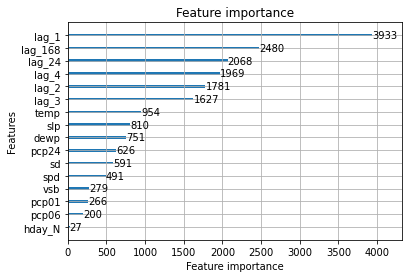

In [25]:
lgb.plot_importance(model)

In [26]:
y_test_df = pd.Series(y_test, index = X_test.index)
y_test_df.index = pd.to_datetime(y_test_df.index)

In [27]:
y_gs = pd.Series(y_gs, index = X_test.index)
y_gs.index = pd.to_datetime(y_gs.index)
y_gs

pickup_dt
2015-05-07 17:00:00    3764.495880
2015-05-07 18:00:00    4354.986360
2015-05-07 19:00:00    4813.657735
2015-05-07 20:00:00    4957.914327
2015-05-07 21:00:00    4353.676407
                          ...     
2015-06-30 19:00:00    4892.904268
2015-06-30 20:00:00    4755.508990
2015-06-30 21:00:00    4122.121652
2015-06-30 22:00:00    4182.632905
2015-06-30 23:00:00    4108.256676
Length: 1303, dtype: float64

In [28]:
pd.concat([y_test_df,y_pred_df], axis=1).plot()


Figure(id='1002', ...)

In [29]:
import pickle

pickle.dump(rs_cv, open('model_lgbm.pkl','wb'))